# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as mtick # to format x axis labels with thousand comma separators

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from workspace_utils import active_session

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import Imputer

import time

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [3]:
# my copy to play around. 
# Resaving it cus the original is hard to open in Excel becauase of sep=';'
# feat_info.to_excel("AZDIAS_Feature_Summary_RB_Copy.xlsx") 

In [4]:
# this takes forever to run due to size of dataset
# azdias.to_excel("azdias_RB_Copy.xlsx") 

### Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).



### Explore Udacity_AZDIAS_Subset.csv: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).

Configure how much of a dataframe the Notebook shows

https://discuss.analyticsvidhya.com/t/how-to-display-full-dataframe-in-pandas/23298

https://www.ritchieng.com/pandas-changing-display-options/

https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns

https://stackoverflow.com/questions/49216197/jupyter-notebook-has-become-very-slow-suddenly

be careful as high limits may slow down the notebook example from Stack Overflow

For example

pd.set_option('display.max_columns', 50000) was causing serious time issues.

I changed it to

pd.set_option('display.max_columns', 50) and problem solved.

In my personal experience,

pd.set_option('display.width', 1000) # this was causing problems

this improved Jupyter slowness pd.set_option('display.width', 50)

In [5]:
# set pandas options so I can view more of a dataframe
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [6]:
azdias.head(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   
5                  3              1                 5               2   
6                  1              5                 1               5   
7                  3              3                 4               1   
8                  4              4                 2               4   
9                  2              4                 2               3   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   
5                      2                 5          2         1943   
6                      4                 3          4            0   
7                      3                 2          5         1964   
8                      2                 2          6         1974   
9                      5                 4          1         1975   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   
5              1.0                 0           3                  8.0   
6             12.0                 0           2                  2.0   
7              9.0                 0           1                  5.0   
8              3.0                 1           3                 10.0   
9             12.0                 1           2                  4.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   
5                  2.0              1.0              1.0             4.0   
6                  1.0              1.0              1.0             2.0   
7                  2.0              1.0              1.0             1.0   
8                  3.0              1.0              1.0            10.0   
9                  1.0              1.0              1.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1

In [7]:
azdias.tail(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
891211        -1                     3          1            2.0   
891212        -1                     4          1            1.0   
891213        -1                     4          2            5.0   
891214        -1                     1          2            4.0   
891215        -1                     2          2            6.0   
891216        -1                     3          2            5.0   
891217        -1                     2          1            4.0   
891218        -1                     2          2            4.0   
891219        -1                     1          1            3.0   
891220        -1                     4          1            1.0   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
891211                  3              2                 4               3   
891212                  3              1                 5               1   
891213                  3              3                 3               5   
891214                  1              5                 2               3   
891215                  1              5                 2               4   
891216                  1              4                 2               5   
891217                  3              3                 3               2   
891218                  2              4                 2               5   
891219                  1              5                 3               5   
891220                  4              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
891211                      3                 2          2         1963   
891212                      1                 5          5            0   
891213                      3                 2          6         1966   
891214                      3                 4          1         1978   
891215                      5                 4          1            0   
891216                      4                 4          1         1976   
891217                      2                 3          6         1970   
891218                      4                 3          1         1976   
891219                      5                 5          1         1994   
891220                      1                 5          6            0   

        GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
891211              1.0                 0           3                  5.0   
891212              4.0                 0           1                  6.0   
891213              8.0                 1           1                 36.0   
891214             10.0                 0           3                  2.0   
891215             12.0                 0           2                  2.0   
891216             12.0                 0           3                  2.0   
891217              1.0                 0          -1                  2.0   
891218             10.0                 0           1                  0.0   
891219              9.0                 0           1                 29.0   
891220             12.0                 0           2                  6.0   

        LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
891211                  2.0              1.0              1.0             1.0   
891212                  2.0              1.0              1.0             1.0   
891213                 12.0             11.0              5.0             6.0   
891214                  1.0              1.0              1.0             1.0   
891215                  1.0              1.0              1.0             2.0   
891216                  1.0              1.0              1.0             2.0   
891217                  1.0              1.0              1.0             1.0   
891218                  0.0              0.0              0.0      

In [8]:
# sample dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
azdias.sample(n=20, random_state=42)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
848815         1                     3          2            4.0   
299816        -1                     2          2            4.0   
570748        -1                     1          1            5.0   
354371        -1                     3          1            6.0   
329018        -1                     3          2            6.0   
49016          1                     4          1            3.0   
454415        -1                     3          2            2.0   
361475         1                     4          2            4.0   
148484         2                     4          2            1.0   
363393        -1                     2          1            4.0   
476938         1                     3          1            NaN   
835010        -1                     3          2            2.0   
15886          1                     3          2            3.0   
704805        -1                     4          2            4.0   
4547          -1                     1          2            4.0   
440575         2                     4          2            2.0   
540600         2                     4          2            2.0   
715032        -1                     4          1            4.0   
82107         -1                     3          1            3.0   
197689        -1                     4          1            6.0   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
848815                  3              1                 5               1   
299816                  2              5                 2               5   
570748                  3              4                 3               5   
354371                  5              2                 4               2   
329018                  3              4                 3               5   
49016                   5              1                 5               1   
454415                  5              2                 3               3   
361475                  3              1                 5               1   
148484                  3              1                 5               1   
363393                  3              4                 2               4   
476938                  5              1                 5               1   
835010                  5              2                 4               3   
15886                   5              2                 3               3   
704805                  3              3                 4               3   
4547                    4              3                 2               4   
440575                  5              1                 5               2   
540600                  4              1                 5               1   
715032                  4              4                 1               4   
82107                   3              3                 3               3   
197689                  3              2                 5               1   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
848815                      2                 5          5            0   
299816                      4                 2          1         1996   
570748                      5                 3          4            0   
354371                      3                 1          6         1967   
329018                      5                 3          4            0   
49016                       2                 2          5         1942   
454415                      2                 1          6            0   
361475                      2                 5          5         1949   
148484                      3                 5          5            0   
363393                      4                 2          4            0   
476938                      2                 2          5         1950   
835010                      3           

In [9]:
def explore_data(df):
    """Explore data. Print basic information and descriptive stats."""
    print("Shape: rows, cols")
    print(df.shape)
    print("")
    print()
    print("Dataframe Information:")
    print(df.info())
    print()
    print("Desciptive stats:")
    print(df.describe())    

explore_data(azdias)    

Shape: rows, cols
(891221, 85)


Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          8

In [10]:
azdias.describe().transpose()

count         mean         std     min     25%  \
AGER_TYP               891221.0    -0.358435    1.198724    -1.0    -1.0   
ALTERSKATEGORIE_GROB   891221.0     2.777398    1.068775     1.0     2.0   
ANREDE_KZ              891221.0     1.522098    0.499512     1.0     1.0   
CJT_GESAMTTYP          886367.0     3.632838    1.595021     1.0     2.0   
FINANZ_MINIMALIST      891221.0     3.074528    1.321055     1.0     2.0   
FINANZ_SPARER          891221.0     2.821039    1.464749     1.0     1.0   
FINANZ_VORSORGER       891221.0     3.401106    1.322134     1.0     3.0   
FINANZ_ANLEGER         891221.0     3.033328    1.529603     1.0     2.0   
FINANZ_UNAUFFAELLIGER  891221.0     2.874167    1.486731     1.0     2.0   
FINANZ_HAUSBAUER       891221.0     3.075121    1.353248     1.0     2.0   
FINANZTYP              891221.0     3.790586    1.987876     1.0     2.0   
GEBURTSJAHR            891221.0  1101.178533  976.583551     0.0     0.0   
GFK_URLAUBERTYP        886367.0     7.350304    3.525723     1.0     5.0   
GREEN_AVANTGARDE       891221.0     0.196612    0.397437     0.0     0.0   
HEALTH_TYP             891221.0     1.792102    1.269062    -1.0     1.0   
LP_LEBENSPHASE_FEIN    886367.0    14.622637   12.616883     0.0     4.0   
LP_LEBENSPHASE_GROB    886367.0     4.453621    3.855639     0.0     1.0   
LP_FAMILIE_FEIN        886367.0     3.599574    3.926486     0.0     1.0   
LP_FAMILIE_GROB        886367.0     2.185966    1.756537     0.0     1.0   
LP_STATUS_FEIN         886367.0     4.791151    3.425305     1.0     2.0   
LP_STATUS_GROB         886367.0     2.432575    1.474315     1.0     1.0   
NATIONALITAET_KZ       891221.0     1.026827    0.586634     0.0     1.0   
PRAEGENDE_JUGENDJAHRE  891221.0     8.154346    4.844532     0.0     5.0   
RETOURTYP_BK_S         886367.0     3.419630    1.417741     1.0     2.0   
SEMIO_SOZ              891221.0     3.945860    1.946564     1.0     2.0   
SEMIO_FAM              891221.0     4.272729    1.915885     1.0     3.0   
SEMIO_REL              891221.0     4.240609    2.007373     1.0     3.0   
SEMIO_MAT              891221.0     4.001597    1.857540     1.0     2.0   
SEMIO_VERT             891221.0     4.023709    2.077746     1.0     2.0   
SEMIO_LUST             891221.0     4.359086    2.022829     1.0     2.0   
SEMIO_ERL              891221.0     4.481405    1.807552     1.0     3.0   
SEMIO_KULT             891221.0     4.025014    1.903816     1.0     3.0   
SEMIO_RAT              891221.0     3.910139    1.580306     1.0     3.0   
SEMIO_KRIT             891221.0     4.763223    1.830789     1.0     3.0   
SEMIO_DOM              891221.0     4.667550    1.795712     1.0     3.0   
SEMIO_KAEM             891221.0     4.445007    1.852412     1.0     3.0   
SEMIO_PFLICHT          891221.0     4.256076    1.770137     1.0     3.0   
SEMIO_TRADV            891221.0     3.661784    1.707637     1.0     2.0   
SHOPPER_TYP            891221.0     1.266967    1.287435    -1.0     0.0   
SOHO_KZ                817722.0     0.008423    0.091392     0.0     0.0   
TITEL_KZ               817722.0     0.003483    0.084957     0.0     0.0   
VERS_TYP               891221.0     1.197852    0.952532    -1.0     1.0   
ZABEOTYP               891221.0     3.362438    1.352704     1.0     3.0   
ALTER_HH               817722.0    10.864126    7.639683     0.0     0.0   
ANZ_PERSONEN           817722.0     1.727637    1.155849     0.0     1.0   
ANZ_TITEL              817722.0     0.004162    0.068855     0.0     0.0   
HH_EINKOMMEN_SCORE     872873.0     4.207243    1.624057     1.0     3.0   
KK_KUNDENTYP           306609.0     3.410640    1.628844     1.0     2.0   
W_KEIT_KIND_HH         783619.0     3.933406    1.964701     0.0     2.0   
WOHNDAUER_2008         817722.0     7.908791    1.923137     1.0     8.0   
ANZ_HAUSHALTE_AKTIV    798073.0     8.287263   15.628087     0.0     1.0   
ANZ_HH_TITEL           794213.0     0.040647    0.324028     0.0     0.0  

In [11]:
def value_counts_in_each_column(df):
    """Give value counts for each column
    to see mode and how many categories there are
    """
    for column in df.columns.tolist():
        print(column)
        print(df[column].value_counts())
        print()

In [12]:
value_counts_in_each_column(azdias)

AGER_TYP
-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

ALTERSKATEGORIE_GROB
3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

ANREDE_KZ
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64

FINANZ_MINIMALIST
3    256276
5    168863
4    167182
2    159313
1    139587
Name: FINANZ_MINIMALIST, dtype: int64

FINANZ_SPARER
1    250213
4    201223
2    153051
5    146380
3    140354
Name: FINANZ_SPARER, dtype: int64

FINANZ_VORSORGER
5    242262
3    229842
4    198218
2    116530
1    104369
Name: FINANZ_VORSORGER, dtype: int64

FINANZ_ANLEGER
5    234508
1    210812
2    161286
4    143597
3    141018
Name: FINANZ_ANLEGER, dtype: int64

FINANZ_UNAUFFAELLIGER
1    220597
5    200551
2    185749
3    170628
4    113696
Name: FINANZ_UNAUFFAELLIGER, dtype: int64

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

WOHNLAGE
3.0    249719
7.0    169318
4.0    135973
2.0    100376
5.0     74346
1.0     43918
8.0     17473
0.0      6950
Name: WOHNLAGE, dtype: int64

CAMEO_DEUG_2015
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64

CAMEO_DEU_2015
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

CAMEO_INTL_2015
51    133694

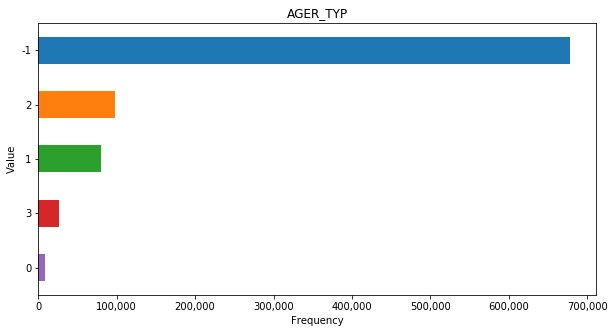

AGER_TYP
    counts  percentage
-1  677503   76.019640
 2   98472   11.049111
 1   79802    8.954232
 3   27104    3.041221
 0    8340    0.935795


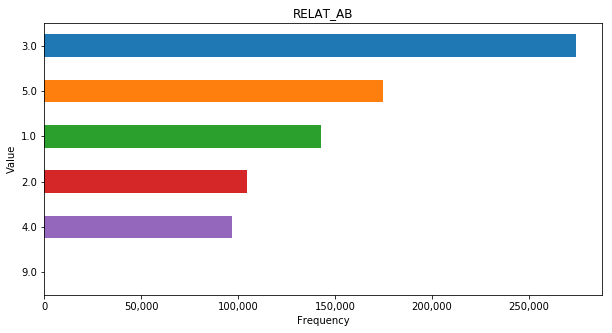

RELAT_AB
     counts  percentage
3.0  274008   34.509606
5.0  174964   22.035629
1.0  142907   17.998249
2.0  104846   13.204703
4.0   97121   12.231787
9.0     159    0.020025


In [13]:
def bar_graph_for_each_column(df,column_list='all'):
    """Loop thru all columns in the dataset. Give frequencies of values in columns.
    
    df - you data
    
    column_list = which columns do you want to look at (pass a list). Default = "all"

    Y axis - unique values in column
    X axis - frequency of that value

    https://etav.github.io/python/count_basic_freq_plot.html
    https://stackoverflow.com/questions/38152356/matplotlib-dollar-sign-with-thousands-comma-tick-labels/38152510
    https://stackoverflow.com/questions/50169311/getting-percentage-and-count-python
    """
    
    if column_list == 'all':
        column_list = df.columns.tolist()
    
    for column in column_list:
        fig, ax = plt.subplots(1, 1,figsize=(10, 5))
        df[column].value_counts().plot('barh').invert_yaxis() 

        plt.title(column)

        ax.set_ylabel('Value')
        ax.set_xlabel('Frequency')

        fmt = '{x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax.xaxis.set_major_formatter(tick) 

        plt.show()  
           
#         print(df[column].value_counts())
        
        summary = pd.concat([df[column].value_counts(), df[column].value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage'))
        print(column)
        print(summary)
                             
bar_graph_for_each_column(azdias,column_list=['AGER_TYP', 'RELAT_AB'])                              

In [14]:
# bar_graph_for_each_column?

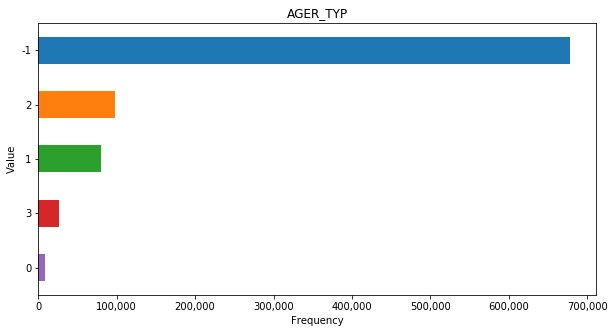

AGER_TYP
    counts  percentage
-1  677503   76.019640
 2   98472   11.049111
 1   79802    8.954232
 3   27104    3.041221
 0    8340    0.935795


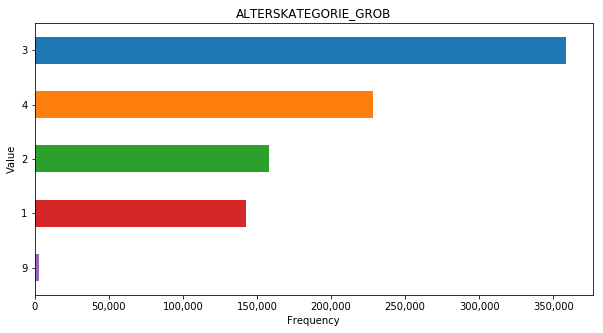

ALTERSKATEGORIE_GROB
   counts  percentage
3  358533   40.229416
4  228510   25.640105
2  158410   17.774491
1  142887   16.032724
9    2881    0.323264


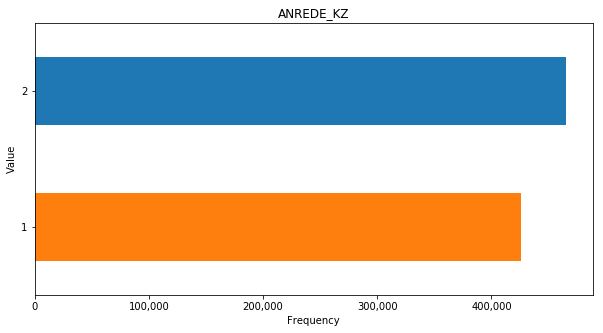

ANREDE_KZ
   counts  percentage
2  465305   52.209833
1  425916   47.790167


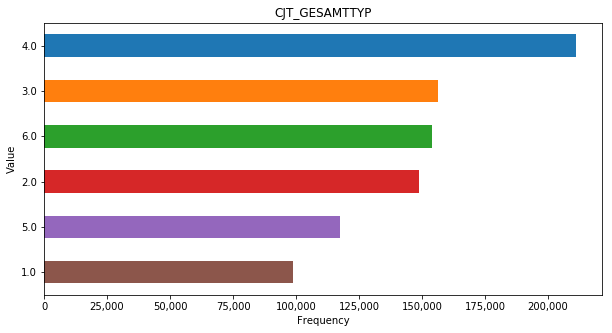

CJT_GESAMTTYP
     counts  percentage
4.0  210963   23.800864
3.0  156449   17.650589
6.0  153915   17.364703
2.0  148795   16.787065
5.0  117376   13.242370
1.0   98869   11.154409


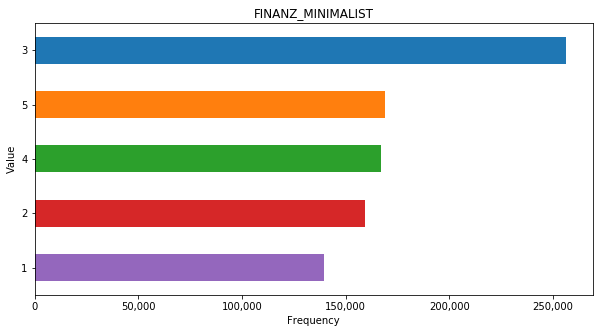

FINANZ_MINIMALIST
   counts  percentage
3  256276   28.755606
5  168863   18.947377
4  167182   18.758759
2  159313   17.875813
1  139587   15.662445


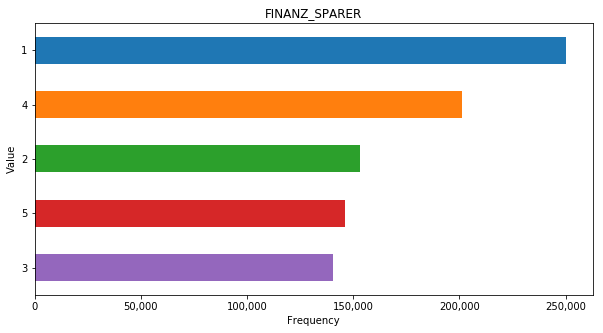

FINANZ_SPARER
   counts  percentage
1  250213   28.075303
4  201223   22.578350
2  153051   17.173182
5  146380   16.424658
3  140354   15.748507


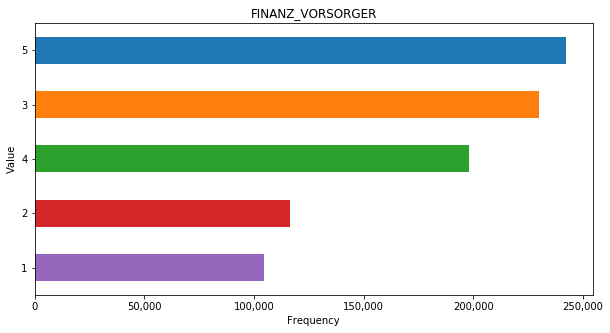

FINANZ_VORSORGER
   counts  percentage
5  242262   27.183157
3  229842   25.789563
4  198218   22.241173
2  116530   13.075320
1  104369   11.710788


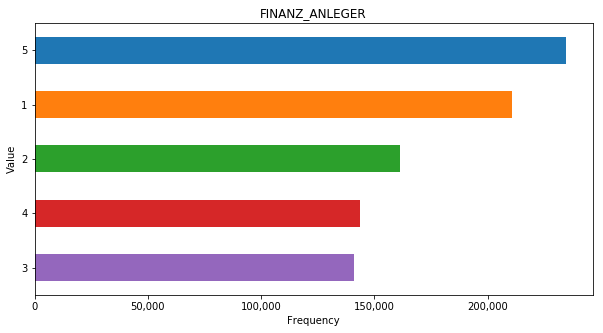

FINANZ_ANLEGER
   counts  percentage
5  234508   26.313114
1  210812   23.654290
2  161286   18.097195
4  143597   16.112390
3  141018   15.823011


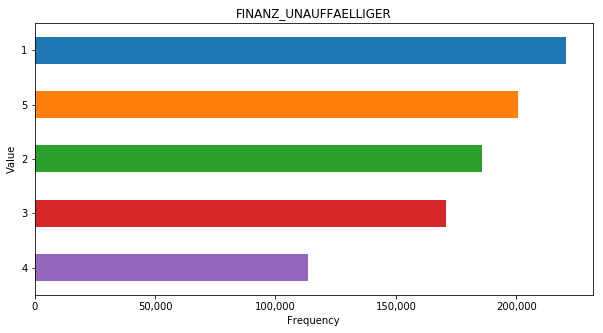

FINANZ_UNAUFFAELLIGER
   counts  percentage
1  220597   24.752222
5  200551   22.502948
2  185749   20.842081
3  170628   19.145420
4  113696   12.757330


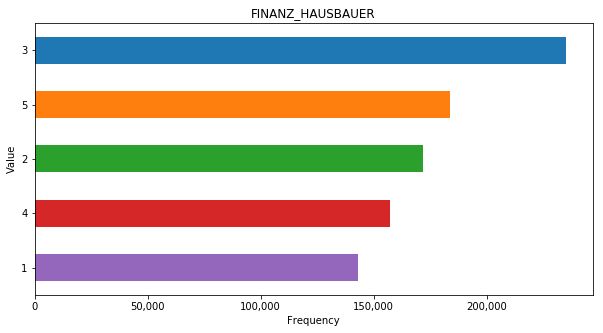

FINANZ_HAUSBAUER
   counts  percentage
3  235184   26.388965
5  183918   20.636632
2  171847   19.282198
4  157168   17.635132
1  143104   16.057072


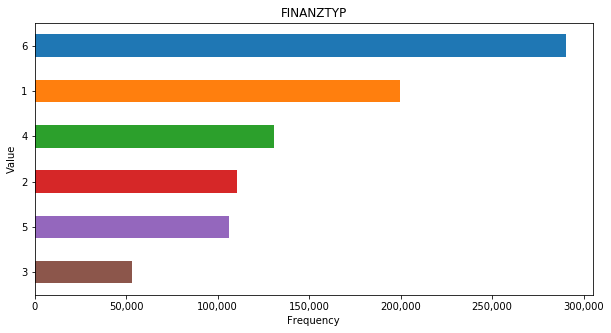

FINANZTYP
   counts  percentage
6  290367   32.580808
1  199572   22.393099
4  130625   14.656858
2  110867   12.439900
5  106436   11.942717
3   53354    5.986618


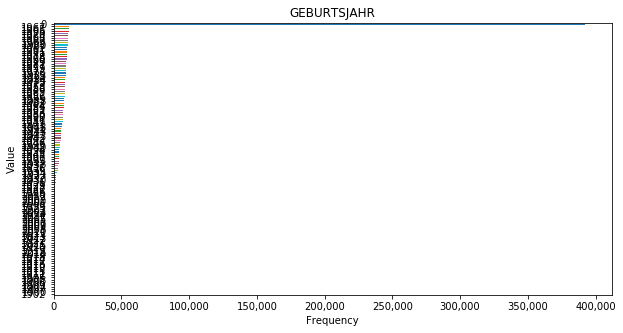

GEBURTSJAHR
      counts  percentage
0     392318   44.020282
1967   11183    1.254795
1965   11090    1.244360
1966   10933    1.226744
1970   10883    1.221134
1964   10799    1.211708
1968   10792    1.210923
1963   10513    1.179618
1969   10360    1.162450
1980   10275    1.152913
1962   10082    1.131257
1961    9880    1.108591
1971    9786    1.098044
1982    9516    1.067749
1978    9509    1.066963
1960    9492    1.065056
1979    9422    1.057201
1981    9374    1.051815
1977    9296    1.043063
1959    9098    1.020847
1972    9027    1.012880
1976    9005    1.010412
1983    8887    0.997171
1974    8676    0.973496
1984    8553    0.959695
1975    8480    0.951504
1973    8356    0.937590
1958    8323    0.933887
1986    8192    0.919188
1985    8180    0.917842
1957    8099    0.908753
1956    8039    0.902021
1955    7828    0.878346
1988    7801    0.875316
1987    7767    0.871501
1954    7533    0.845245
1989    7251    0.813603
1952    7106    0.797333
1953    7096 

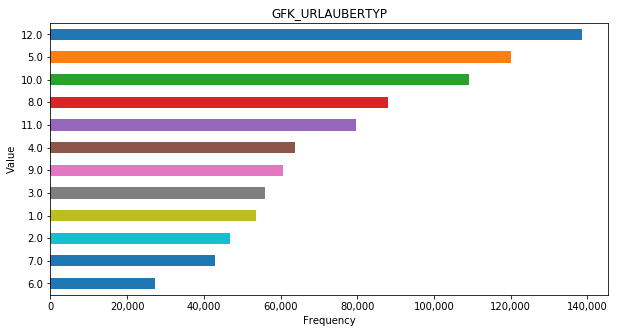

GFK_URLAUBERTYP
      counts  percentage
12.0  138545   15.630659
5.0   120126   13.552625
10.0  109127   12.311717
8.0    88042    9.932906
11.0   79740    8.996274
4.0    63770    7.194537
9.0    60614    6.838477
3.0    56007    6.318714
1.0    53600    6.047157
2.0    46702    5.268924
7.0    42956    4.846300
6.0    27138    3.061711


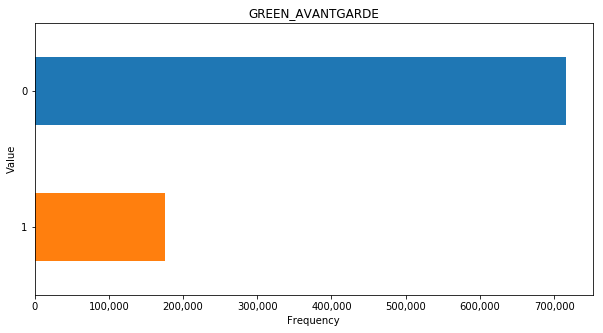

GREEN_AVANTGARDE
   counts  percentage
0  715996   80.338771
1  175225   19.661229


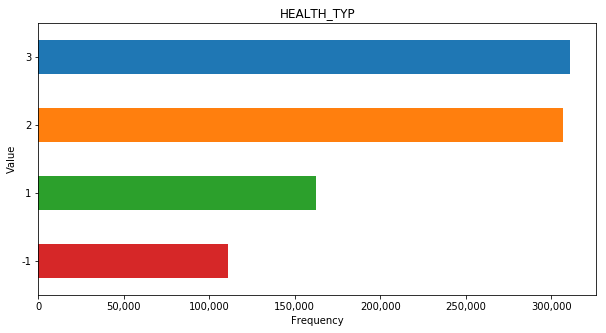

HEALTH_TYP
    counts  percentage
 3  310693   34.861499
 2  306944   34.440840
 1  162388   18.220845
-1  111196   12.476816


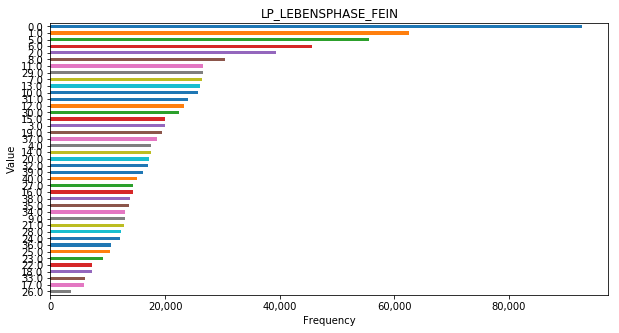

LP_LEBENSPHASE_FEIN
      counts  percentage
0.0    92778   10.467222
1.0    62667    7.070096
5.0    55542    6.266253
6.0    45614    5.146175
2.0    39434    4.448947
8.0    30475    3.438192
11.0   26710    3.013424
29.0   26577    2.998419
7.0    26508    2.990635
13.0   26085    2.942912
10.0   25789    2.909517
31.0   23987    2.706215
12.0   23300    2.628708
30.0   22361    2.522770
15.0   20062    2.263397
3.0    19985    2.254709
19.0   19484    2.198187
37.0   18525    2.089992
4.0    17595    1.985069
14.0   17529    1.977623
20.0   17132    1.932834
32.0   17105    1.929788
39.0   16182    1.825655
40.0   15150    1.709224
27.0   14475    1.633071
16.0   14466    1.632055
38.0   13914    1.569779
35.0   13679    1.543266
34.0   13074    1.475010
9.0    13066    1.474107
21.0   12766    1.440261
28.0   12264    1.383626
24.0   12091    1.364108
36.0   10505    1.185175
25.0   10370    1.169944
23.0    9191    1.036929
22.0    7224    0.815012
18.0    7168    0.808694
33.0 

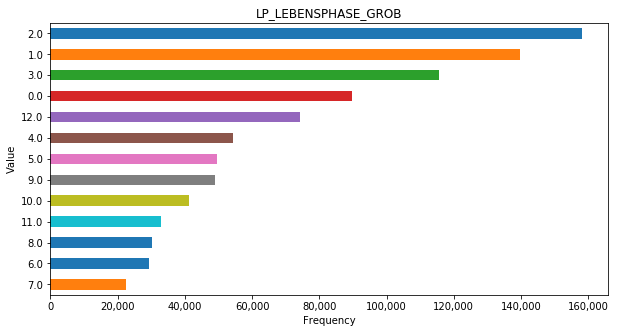

LP_LEBENSPHASE_GROB
      counts  percentage
2.0   158139   17.841255
1.0   139681   15.758822
3.0   115624   13.044709
0.0    89718   10.121992
12.0   74276    8.379825
4.0    54443    6.142264
5.0    49672    5.603999
9.0    48938    5.521189
10.0   41092    4.636003
11.0   32819    3.702642
8.0    30323    3.421043
6.0    29181    3.292203
7.0    22461    2.534052


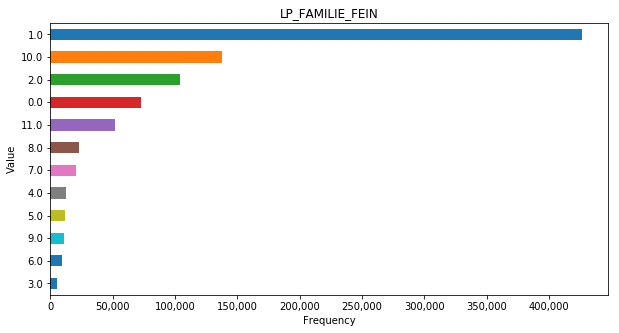

LP_FAMILIE_FEIN
      counts  percentage
1.0   426379   48.104115
10.0  137913   15.559356
2.0   104305   11.767699
0.0    72938    8.228871
11.0   51719    5.834942
8.0    23032    2.598472
7.0    20730    2.338760
4.0    12303    1.388026
5.0    11920    1.344815
9.0    11148    1.257718
6.0     9022    1.017863
3.0     4958    0.559362


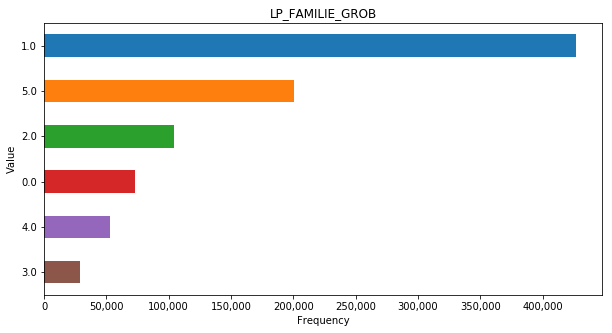

LP_FAMILIE_GROB
     counts  percentage
1.0  426379   48.104115
5.0  200780   22.652017
2.0  104305   11.767699
0.0   72938    8.228871
4.0   52784    5.955095
3.0   29181    3.292203


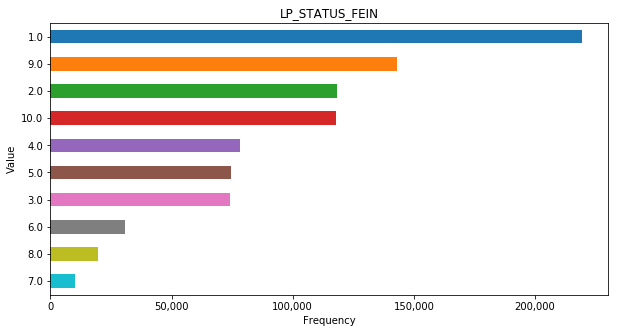

LP_STATUS_FEIN
      counts  percentage
1.0   219275   24.738624
9.0   143238   16.160123
2.0   118236   13.339396
10.0  118022   13.315252
4.0    78317    8.835731
5.0    74493    8.404307
3.0    74105    8.360532
6.0    30914    3.487720
8.0    19708    2.223458
7.0    10059    1.134857


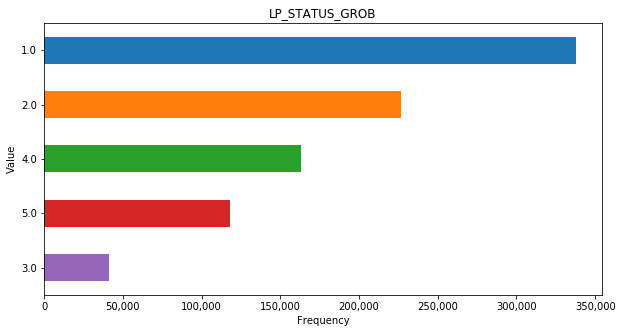

LP_STATUS_GROB
     counts  percentage
1.0  337511   38.078020
2.0  226915   25.600570
4.0  162946   18.383582
5.0  118022   13.315252
3.0   40973    4.622577


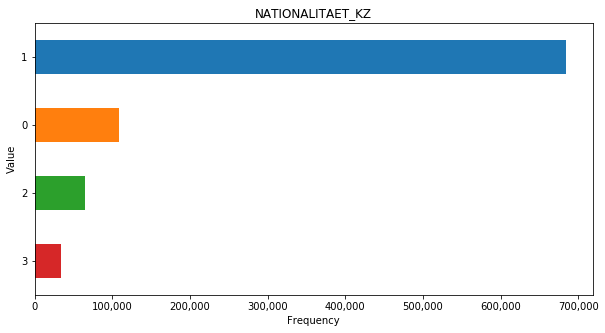

NATIONALITAET_KZ
   counts  percentage
1  684085   76.758178
0  108315   12.153551
2   65418    7.340267
3   33403    3.748004


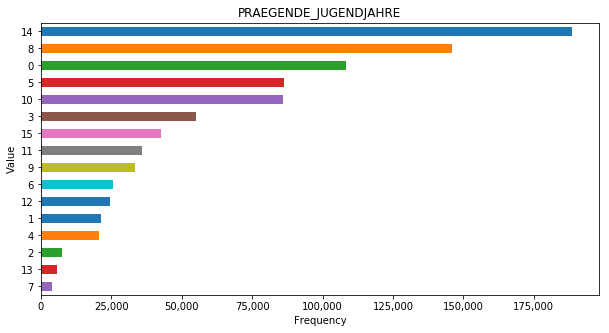

PRAEGENDE_JUGENDJAHRE
    counts  percentage
14  188697   21.172863
8   145988   16.380673
0   108164   12.136608
5    86416    9.696360
10   85808    9.628139
3    55195    6.193189
15   42547    4.774012
11   35752    4.011575
9    33570    3.766742
6    25652    2.878298
12   24446    2.742978
1    21282    2.387960
4    20451    2.294717
2     7479    0.839186
13    5764    0.646753
7     4010    0.449945


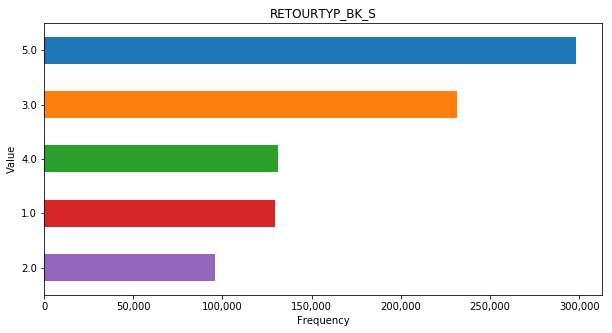

RETOURTYP_BK_S
     counts  percentage
5.0  297993   33.619595
3.0  231816   26.153501
4.0  131115   14.792405
1.0  129712   14.634119
2.0   95731   10.800380


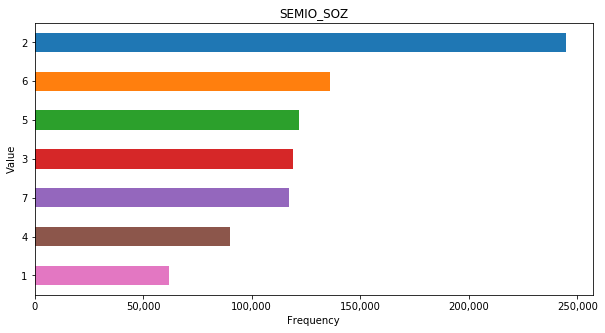

SEMIO_SOZ
   counts  percentage
2  244714   27.458285
6  136205   15.282966
5  121786   13.665073
3  118889   13.340013
7  117378   13.170471
4   90161   10.116570
1   62088    6.966622


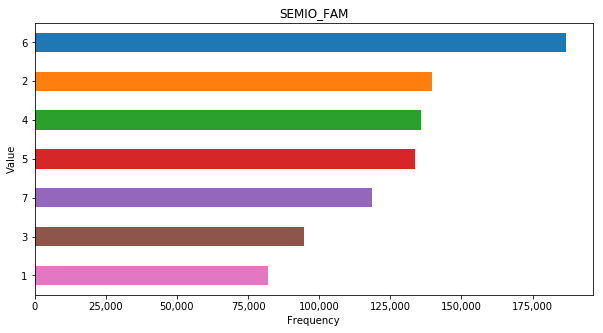

SEMIO_FAM
   counts  percentage
6  186729   20.952042
2  139562   15.659640
4  135942   15.253456
5  133740   15.006379
7  118517   13.298273
3   94815   10.638775
1   81916    9.191435


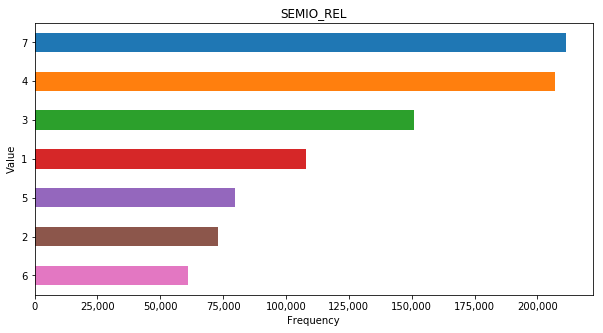

SEMIO_REL
   counts  percentage
7  211377   23.717686
4  207128   23.240925
3  150801   16.920719
1  108130   12.132793
5   79566    8.927752
2   73127    8.205260
6   61092    6.854865


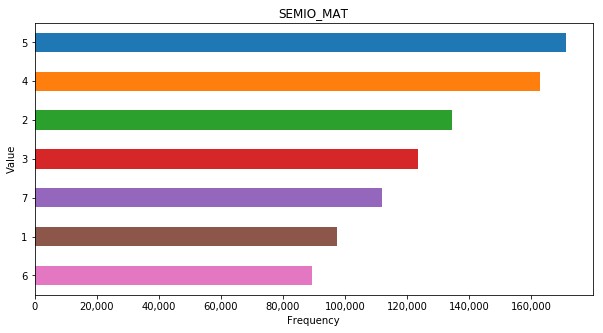

SEMIO_MAT
   counts  percentage
5  171267   19.217119
4  162862   18.274031
2  134549   15.097153
3  123701   13.879947
7  111976   12.564336
1   97341   10.922207
6   89525   10.045208


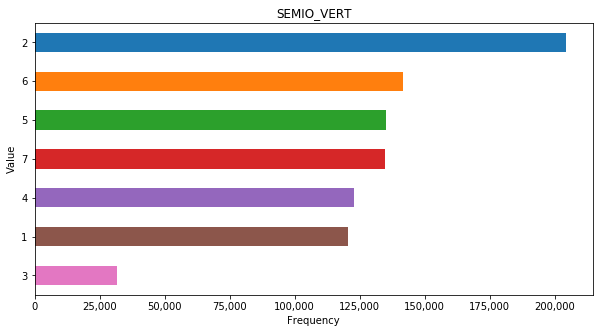

SEMIO_VERT
   counts  percentage
2  204333   22.927310
6  141714   15.901106
5  135205   15.170760
7  134756   15.120380
4  122982   13.799271
1  120437   13.513708
3   31794    3.567465


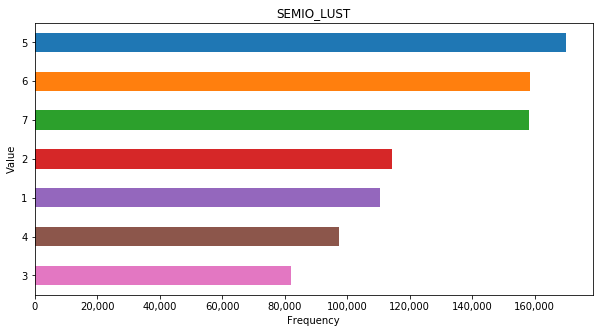

SEMIO_LUST
   counts  percentage
5  170040   19.079443
6  158624   17.798503
7  158234   17.754743
2  114373   12.833293
1  110382   12.385480
4   97495   10.939486
3   82073    9.209051


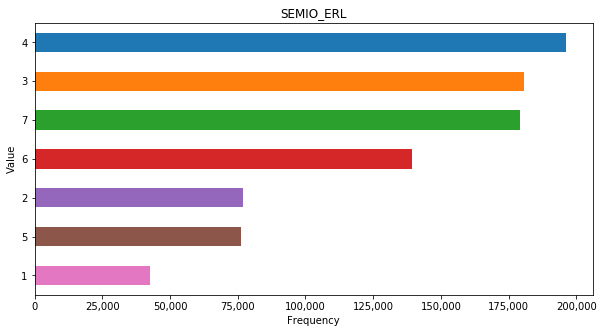

SEMIO_ERL
   counts  percentage
4  196206   22.015415
3  180824   20.289468
7  179141   20.100626
6  139209   15.620031
2   77012    8.641179
5   76133    8.542550
1   42696    4.790731


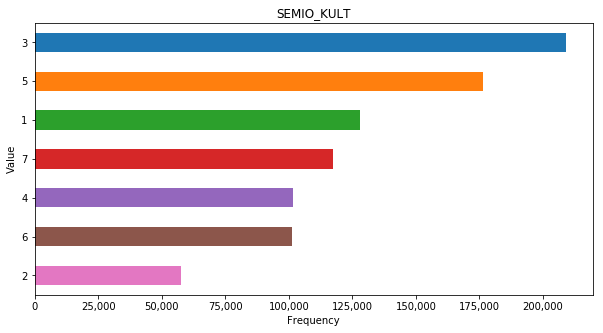

SEMIO_KULT
   counts  percentage
3  209067   23.458491
5  176282   19.779830
1  128216   14.386555
7  117378   13.170471
4  101502   11.389094
6  101286   11.364858
2   57490    6.450701


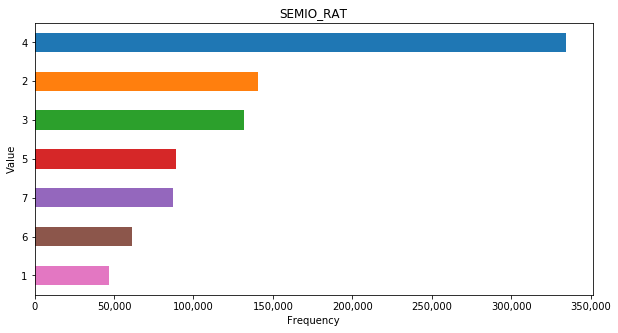

SEMIO_RAT
   counts  percentage
4  334456   37.527841
2  140433   15.757371
3  131994   14.810468
5   89056    9.992583
7   87024    9.764581
6   61484    6.898850
1   46774    5.248305


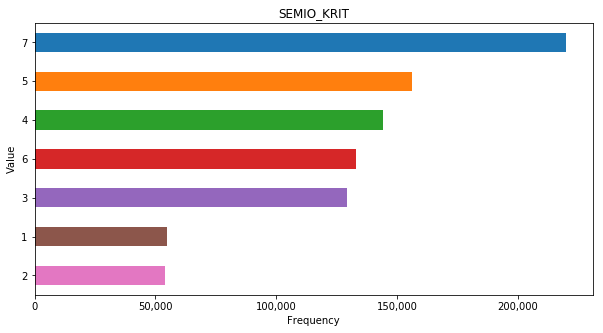

SEMIO_KRIT
   counts  percentage
7  219847   24.668068
5  156298   17.537513
4  144079   16.166473
6  133049   14.928845
3  129106   14.486418
1   54947    6.165362
2   53895    6.047322


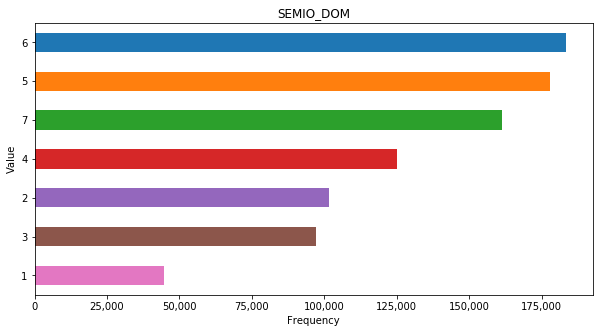

SEMIO_DOM
   counts  percentage
6  183435   20.582437
5  177889   19.960145
7  161495   18.120646
4  125115   14.038605
2  101498   11.388645
3   97027   10.886974
1   44762    5.022548


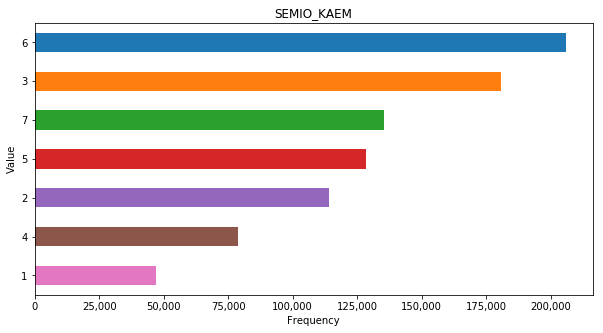

SEMIO_KAEM
   counts  percentage
6  206001   23.114469
3  180955   20.304167
7  135579   15.212725
5  128501   14.418534
2  114038   12.795704
4   78944    8.857960
1   47203    5.296442


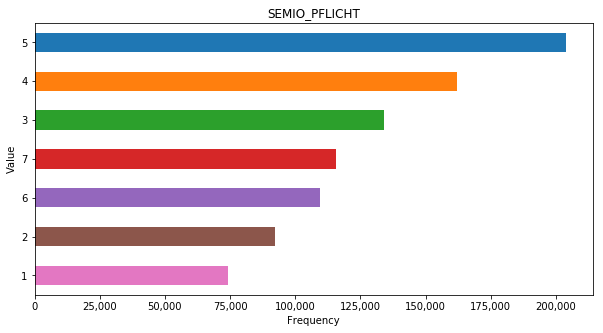

SEMIO_PFLICHT
   counts  percentage
5  203845   22.872553
4  162117   18.190438
3  133990   15.034430
7  115458   12.955036
6  109442   12.280007
2   92214   10.346929
1   74155    8.320607


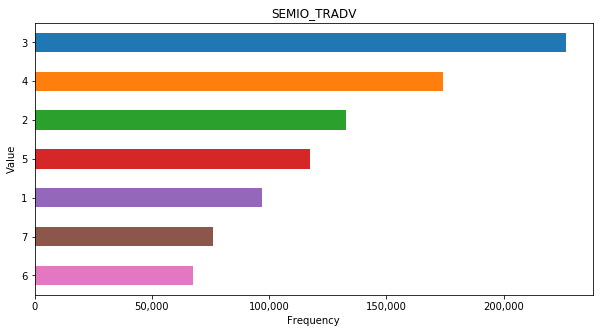

SEMIO_TRADV
   counts  percentage
3  226571   25.422538
4  174203   19.546555
2  132657   14.884860
5  117378   13.170471
1   96775   10.858698
7   76133    8.542550
6   67504    7.574328


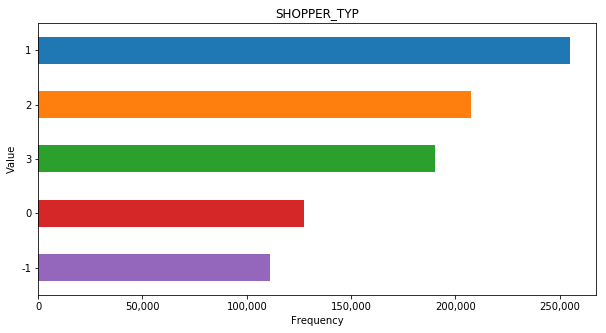

SHOPPER_TYP
    counts  percentage
 1  254761   28.585615
 2  207463   23.278513
 3  190219   21.343640
 0  127582   14.315417
-1  111196   12.476816


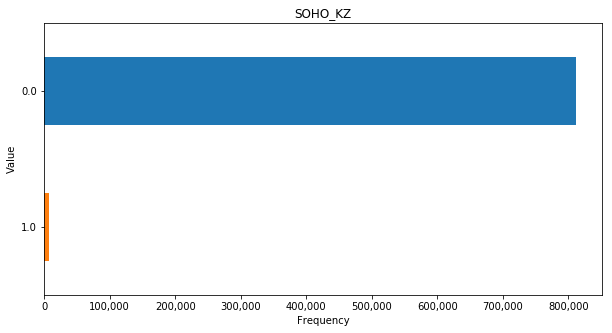

SOHO_KZ
     counts  percentage
0.0  810834    99.15766
1.0    6888     0.84234


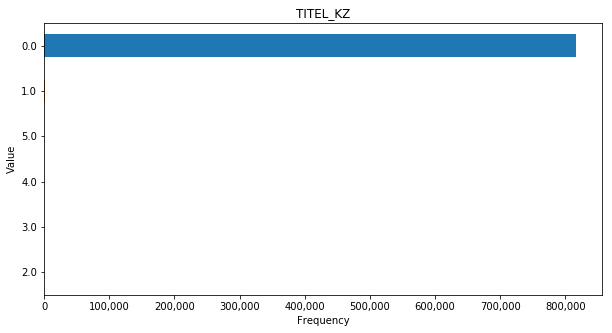

TITEL_KZ
     counts  percentage
0.0  815562   99.735852
1.0    1947    0.238100
5.0     104    0.012718
4.0      57    0.006971
3.0      49    0.005992
2.0       3    0.000367


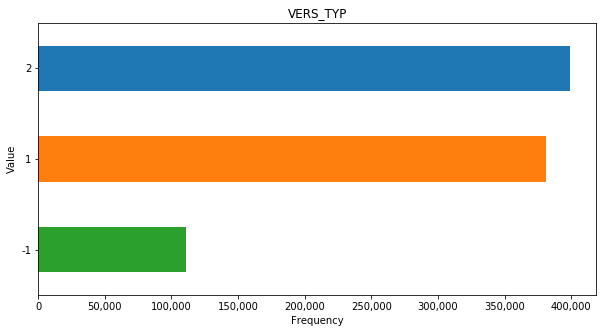

VERS_TYP
    counts  percentage
 2  398722   44.738847
 1  381303   42.784337
-1  111196   12.476816


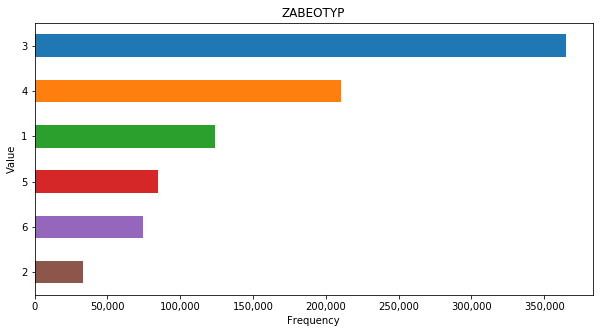

ZABEOTYP
   counts  percentage
3  364905   40.944390
4  210095   23.573839
1  123622   13.871082
5   84956    9.532540
6   74473    8.356289
2   33170    3.721860


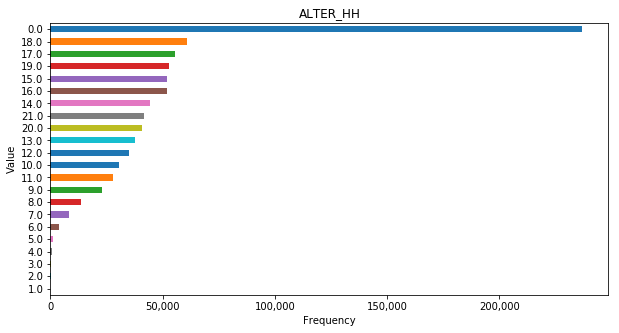

ALTER_HH
      counts  percentage
0.0   236768   28.954584
18.0   60852    7.441649
17.0   55665    6.807326
19.0   52890    6.467968
15.0   51867    6.342865
16.0   51857    6.341642
14.0   44275    5.414432
21.0   41610    5.088526
20.0   40671    4.973695
13.0   37612    4.599607
12.0   34923    4.270767
10.0   30419    3.719968
11.0   27924    3.414852
9.0    22817    2.790313
8.0    13463    1.646403
7.0     8419    1.029568
6.0     3809    0.465806
5.0     1030    0.125960
4.0      603    0.073741
3.0      200    0.024458
2.0       47    0.005748
1.0        1    0.000122


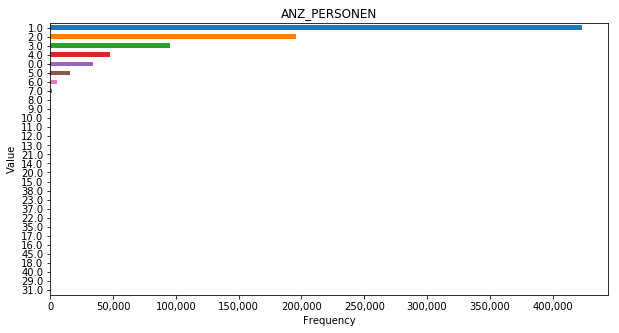

ANZ_PERSONEN
      counts  percentage
1.0   423383   51.775909
2.0   195470   23.904212
3.0    94905   11.606023
4.0    47126    5.763083
0.0    34103    4.170488
5.0    15503    1.895877
6.0     4842    0.592133
7.0     1525    0.186494
8.0      523    0.063958
9.0      180    0.022012
10.0      67    0.008193
11.0      38    0.004647
12.0      16    0.001957
13.0      11    0.001345
21.0       4    0.000489
14.0       4    0.000489
20.0       3    0.000367
15.0       3    0.000367
38.0       2    0.000245
23.0       2    0.000245
37.0       2    0.000245
22.0       2    0.000245
35.0       1    0.000122
17.0       1    0.000122
16.0       1    0.000122
45.0       1    0.000122
18.0       1    0.000122
40.0       1    0.000122
29.0       1    0.000122
31.0       1    0.000122


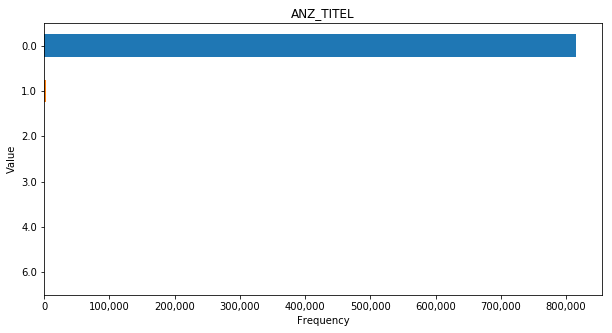

ANZ_TITEL
     counts  percentage
0.0  814542   99.611115
1.0    2970    0.363204
2.0     202    0.024703
3.0       5    0.000611
4.0       2    0.000245
6.0       1    0.000122


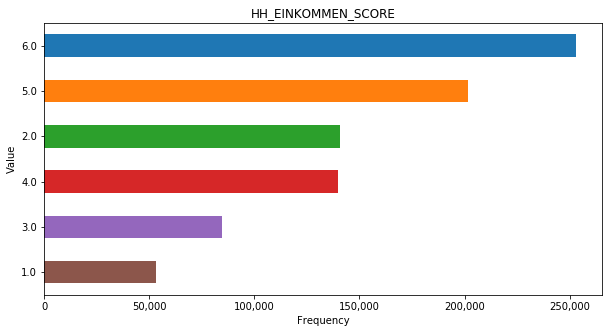

HH_EINKOMMEN_SCORE
     counts  percentage
6.0  252775   28.958967
5.0  201482   23.082625
2.0  140817   16.132587
4.0  139762   16.011722
3.0   84805    9.715617
1.0   53232    6.098482


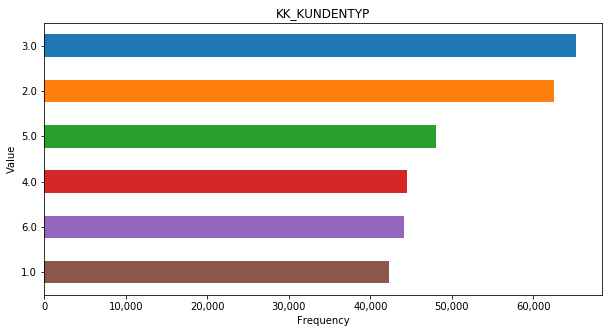

KK_KUNDENTYP
     counts  percentage
3.0   65151   21.248887
2.0   62564   20.405141
5.0   48038   15.667511
4.0   44512   14.517513
6.0   44114   14.387706
1.0   42230   13.773242


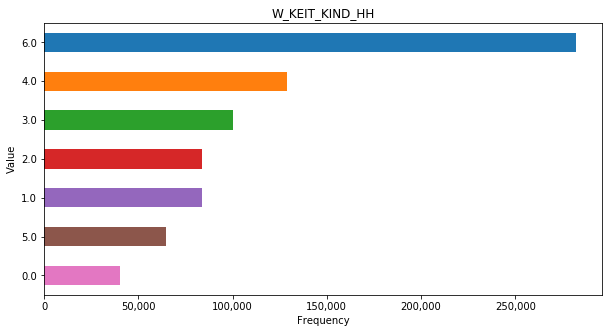

W_KEIT_KIND_HH
     counts  percentage
6.0  281966   35.982537
4.0  128675   16.420607
3.0  100170   12.782998
2.0   84000   10.719495
1.0   83706   10.681977
5.0   64716    8.258605
0.0   40386    5.153780


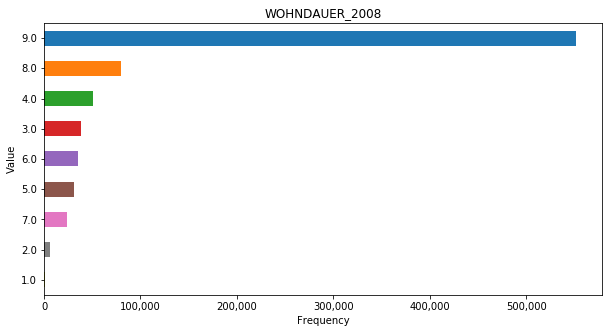

WOHNDAUER_2008
     counts  percentage
9.0  551176   67.403837
8.0   80118    9.797706
4.0   50736    6.204554
3.0   38767    4.740853
6.0   35170    4.300973
5.0   30959    3.786006
7.0   23939    2.927523
2.0    6174    0.755024
1.0     683    0.083525


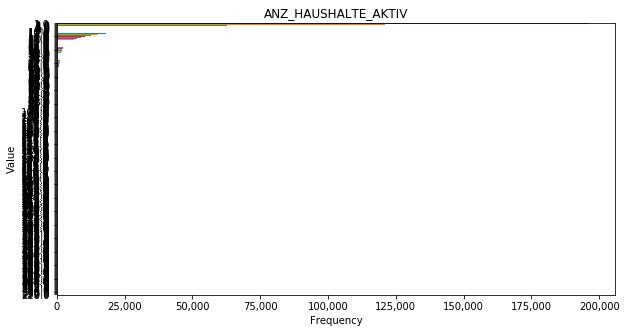

ANZ_HAUSHALTE_AKTIV
       counts  percentage
1.0    195957   24.553769
2.0    120982   15.159265
3.0     62575    7.840761
4.0     43213    5.414668
5.0     37815    4.738288
6.0     36020    4.513372
7.0     34526    4.326171
8.0     32293    4.046372
9.0     29002    3.634003
10.0    25428    3.186175
11.0    21965    2.752254
12.0    18033    2.259568
13.0    15282    1.914862
14.0    12625    1.581935
15.0    10371    1.299505
16.0     8899    1.115061
17.0     7292    0.913701
0.0      6463    0.809826
18.0     6324    0.792409
19.0     5461    0.684273
20.0     4674    0.585661
21.0     4138    0.518499
22.0     3735    0.468002
23.0     3243    0.406354
24.0     2838    0.355607
25.0     2636    0.330296
26.0     2342    0.293457
27.0     2232    0.279674
28.0     2040    0.255616
29.0     1963    0.245967
30.0     1821    0.228175
31.0     1634    0.204743
32.0     1616    0.202488
33.0     1551    0.194343
34.0     1437    0.180059
35.0     1320    0.165398
37.0     1317    0

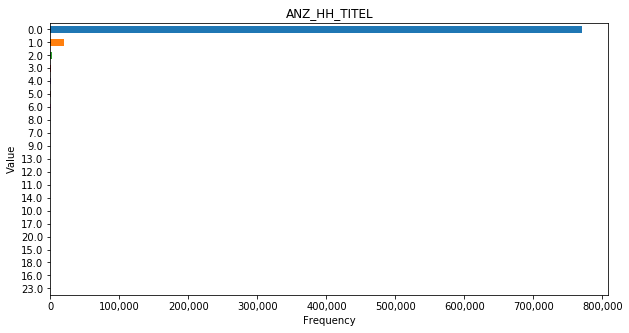

ANZ_HH_TITEL
      counts  percentage
0.0   770244   96.982044
1.0    20157    2.537984
2.0     2459    0.309615
3.0      585    0.073658
4.0      232    0.029211
5.0      117    0.014732
6.0      106    0.013347
8.0       68    0.008562
7.0       65    0.008184
9.0       34    0.004281
13.0      29    0.003651
12.0      22    0.002770
11.0      22    0.002770
14.0      16    0.002015
10.0      16    0.002015
17.0      13    0.001637
20.0       9    0.001133
15.0       7    0.000881
18.0       6    0.000755
16.0       3    0.000378
23.0       3    0.000378


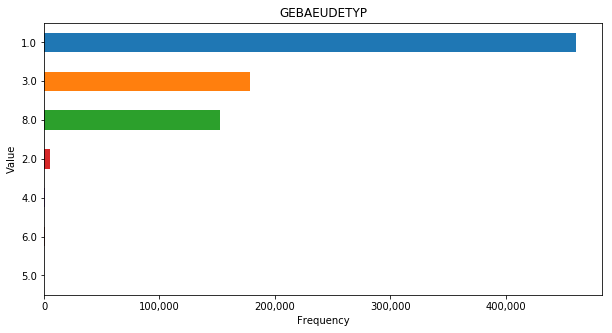

GEBAEUDETYP
     counts  percentage
1.0  460465   57.697103
3.0  178668   22.387426
8.0  152476   19.105520
2.0    4935    0.618364
4.0     900    0.112772
6.0     628    0.078690
5.0       1    0.000125


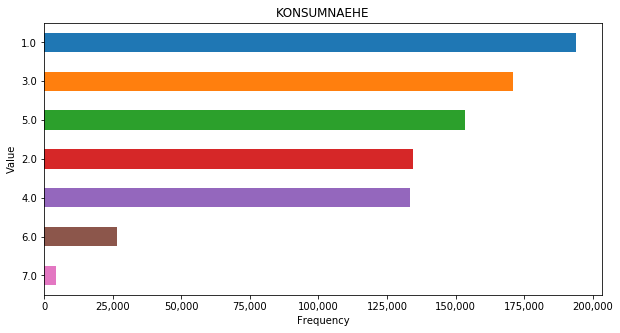

KONSUMNAEHE
     counts  percentage
1.0  193738   23.706029
3.0  171127   20.939319
5.0  153535   18.786739
2.0  134665   16.477782
4.0  133324   16.313695
6.0   26625    3.257869
7.0    4238    0.518567


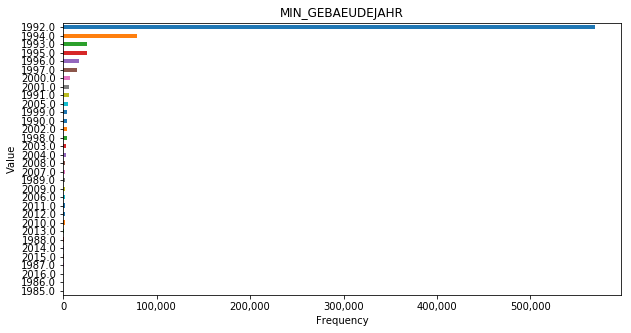

MIN_GEBAEUDEJAHR
        counts  percentage
1992.0  568776   71.268668
1994.0   78835    9.878169
1993.0   25488    3.193693
1995.0   25464    3.190686
1996.0   16611    2.081389
1997.0   14464    1.812366
2000.0    7382    0.924978
2001.0    5877    0.736399
1991.0    5811    0.728129
2005.0    5553    0.695801
1999.0    4413    0.552957
1990.0    4408    0.552330
2002.0    4216    0.528272
1998.0    4097    0.513362
2003.0    3356    0.420513
2004.0    2935    0.367761
2008.0    2197    0.275288
2007.0    2156    0.270151
1989.0    2046    0.256368
2009.0    2016    0.252608
2006.0    1984    0.248599
2011.0    1903    0.238449
2012.0    1861    0.233187
2010.0    1410    0.176676
2013.0    1230    0.154121
1988.0    1027    0.128685
2014.0    1001    0.125427
2015.0     717    0.089841
1987.0     470    0.058892
2016.0     128    0.016039
1986.0     125    0.015663
1985.0     116    0.014535


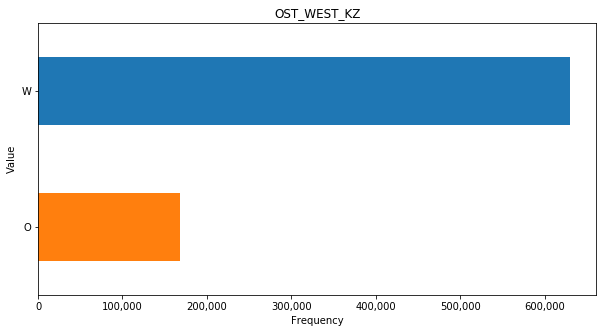

OST_WEST_KZ
   counts  percentage
W  629528   78.881005
O  168545   21.118995


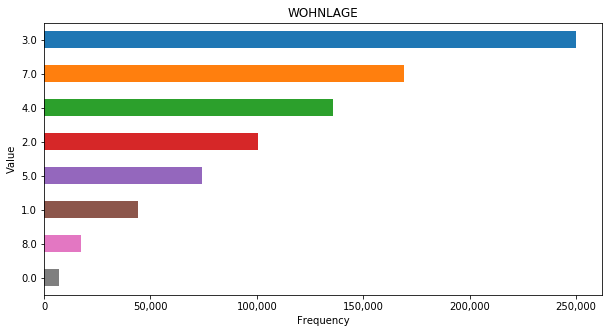

WOHNLAGE
     counts  percentage
3.0  249719   31.290245
7.0  169318   21.215854
4.0  135973   17.037664
2.0  100376   12.577296
5.0   74346    9.315689
1.0   43918    5.503005
8.0   17473    2.189399
0.0    6950    0.870848


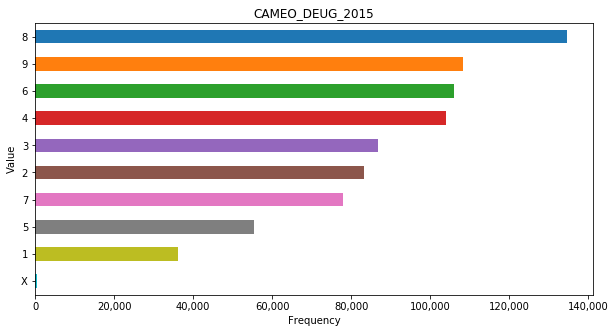

CAMEO_DEUG_2015
   counts  percentage
8  134441   16.969689
9  108177   13.654540
6  105874   13.363846
4  103912   13.116194
3   86779   10.953598
2   83231   10.505755
7   77933    9.837019
5   55310    6.981453
1   36212    4.570826
X     373    0.047082


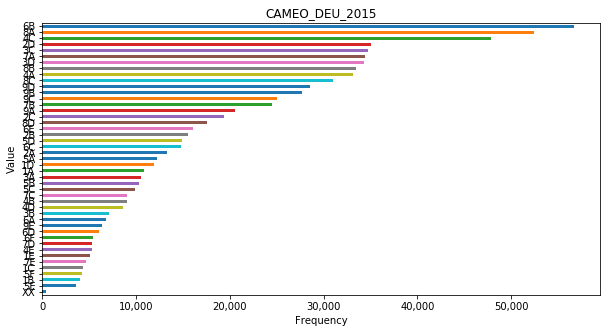

CAMEO_DEU_2015
    counts  percentage
6B   56672    7.153370
8A   52438    6.618937
4C   47819    6.035908
2D   35074    4.427183
3C   34769    4.388684
7A   34399    4.341981
3D   34307    4.330369
8B   33434    4.220175
4A   33155    4.184959
8C   30993    3.912062
9D   28593    3.609124
9B   27676    3.493377
9C   24987    3.153961
7B   24503    3.092868
9A   20542    2.592895
2C   19422    2.451524
8D   17576    2.218514
6E   16107    2.033091
2B   15486    1.954706
5D   14943    1.886166
6C   14820    1.870641
2A   13249    1.672343
5A   12214    1.541701
1D   11909    1.503202
1A   10850    1.369531
3A   10543    1.330780
5B   10354    1.306924
5C    9935    1.254036
7C    9065    1.144221
4B    9047    1.141949
4D    8570    1.081740
3B    7160    0.903764
6A    6810    0.859586
9E    6379    0.805183
6D    6073    0.766559
6F    5392    0.680600
7D    5333    0.673153
4E    5321    0.671638
1E    5065    0.639325
7E    4633    0.584796
1C    4317    0.544909
5F    4283    0.540

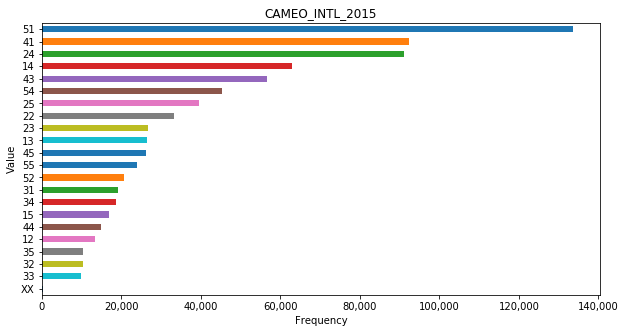

CAMEO_INTL_2015
    counts  percentage
51  133694   16.875399
41   92336   11.655025
24   91158   11.506333
14   62884    7.937474
43   56672    7.153370
54   45391    5.729436
25   39628    5.002007
22   33155    4.184959
23   26750    3.376494
13   26336    3.324237
45   26132    3.298487
55   23955    3.023697
52   20542    2.592895
31   19024    2.401286
34   18524    2.338174
15   16974    2.142527
44   14820    1.870641
12   13249    1.672343
35   10356    1.307176
32   10354    1.306924
33    9935    1.254036
XX     373    0.047082


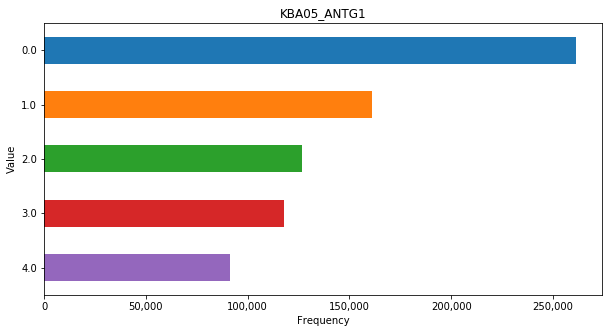

KBA05_ANTG1
     counts  percentage
0.0  261049   34.443862
1.0  161224   21.272548
2.0  126725   16.720610
3.0  117762   15.537995
4.0   91137   12.024985


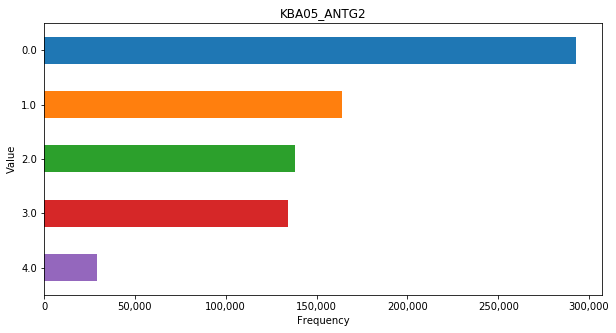

KBA05_ANTG2
     counts  percentage
0.0  292538   38.598649
1.0  163751   21.605970
2.0  138273   18.244300
3.0  134455   17.740537
4.0   28880    3.810544


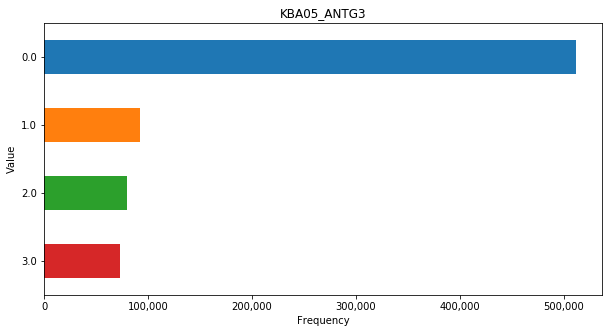

KBA05_ANTG3
     counts  percentage
0.0  511545   67.495319
1.0   92748   12.237547
2.0   80234   10.586399
3.0   73370    9.680735


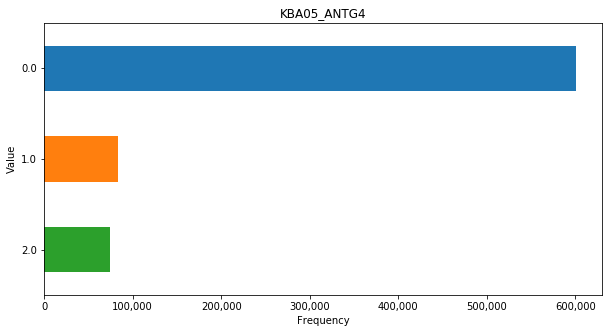

KBA05_ANTG4
     counts  percentage
0.0  600171   79.188993
1.0   83591   11.029335
2.0   74135    9.781672


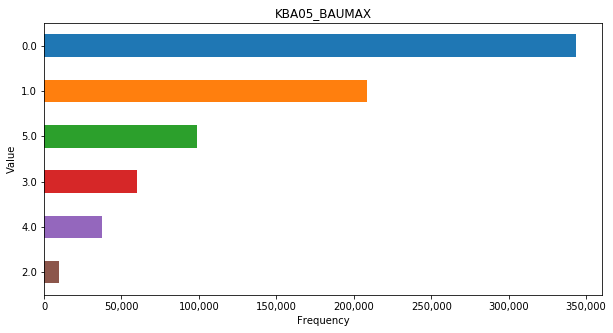

KBA05_BAUMAX
     counts  percentage
0.0  343200   45.283198
1.0  208417   27.499383
5.0   98923   13.052301
3.0   59955    7.910706
4.0   37718    4.976666
2.0    9684    1.277746


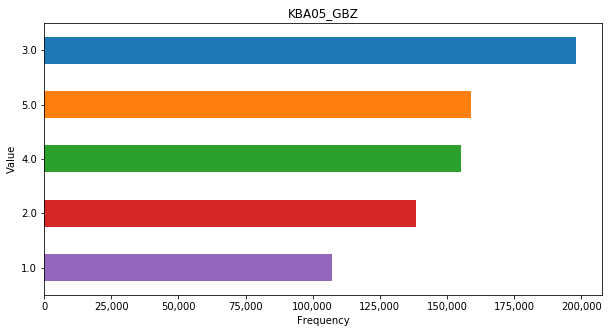

KBA05_GBZ
     counts  percentage
3.0  197833   26.102887
5.0  158971   20.975278
4.0  155301   20.491043
2.0  138528   18.277945
1.0  107264   14.152847


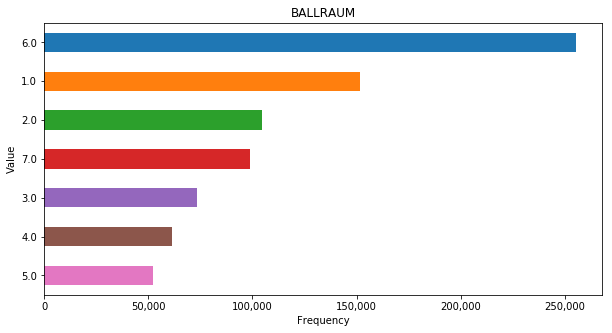

BALLRAUM
     counts  percentage
6.0  255093   31.987345
1.0  151782   19.032679
2.0  104521   13.106394
7.0   99039   12.418979
3.0   73277    9.188557
4.0   61358    7.693976
5.0   52411    6.572069


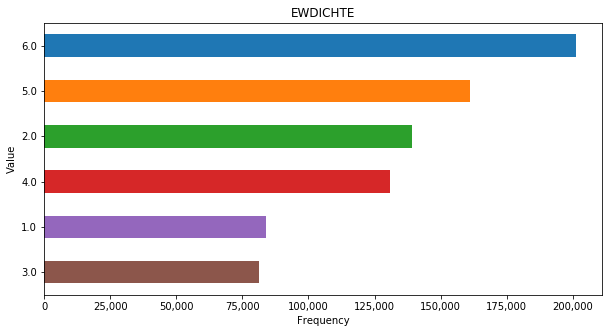

EWDICHTE
     counts  percentage
6.0  201009   25.205491
5.0  161209   20.214776
2.0  139087   17.440792
4.0  130716   16.391112
1.0   84051   10.539561
3.0   81409   10.208268


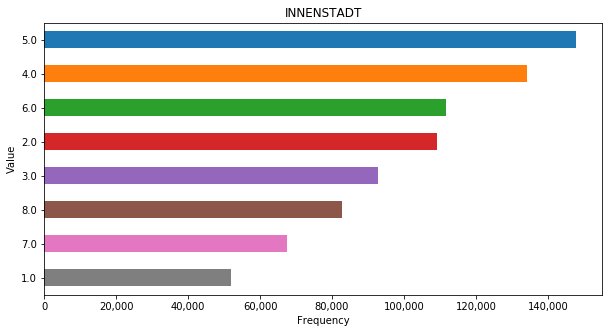

INNENSTADT
     counts  percentage
5.0  147626   18.511538
4.0  134067   16.811310
6.0  111679   14.003970
2.0  109048   13.674056
3.0   92818   11.638898
8.0   82870   10.391470
7.0   67463    8.459512
1.0   51910    6.509246


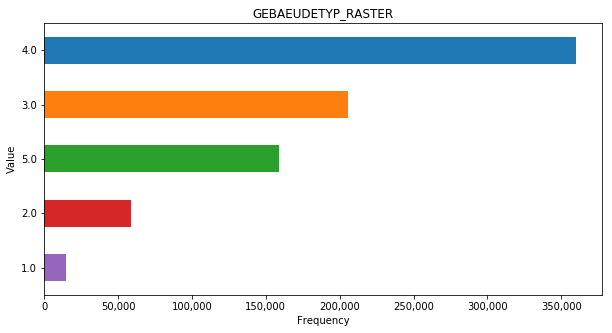

GEBAEUDETYP_RASTER
     counts  percentage
4.0  359620   45.061436
3.0  205330   25.728449
5.0  159217   19.950355
2.0   58961    7.387985
1.0   14938    1.871775


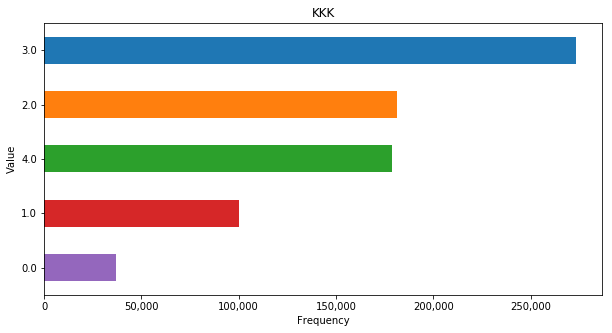

KKK
     counts  percentage
3.0  273024   35.456511
2.0  181519   23.573131
4.0  178648   23.200286
1.0   99966   12.982176
0.0   36868    4.787896


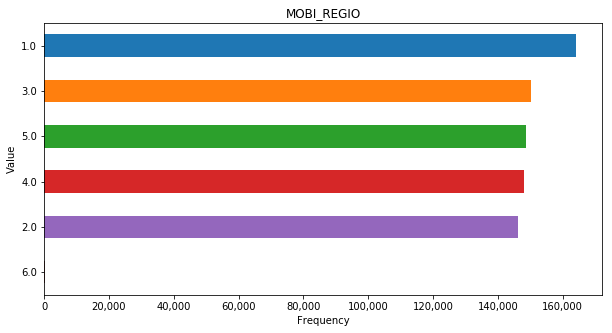

MOBI_REGIO
     counts  percentage
1.0  163993   21.637901
3.0  150336   19.835941
5.0  148713   19.621796
4.0  148209   19.555296
2.0  146305   19.304074
6.0     341    0.044993


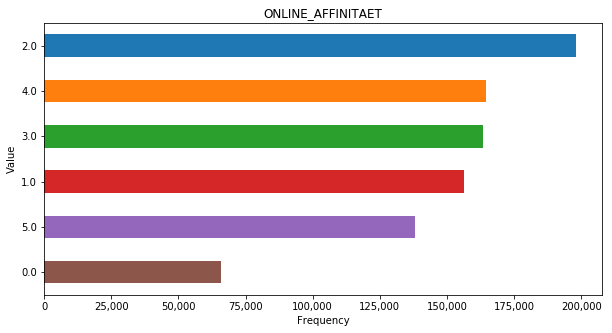

ONLINE_AFFINITAET
     counts  percentage
2.0  197850   22.321454
4.0  164704   18.581919
3.0  163487   18.444617
1.0  156499   17.656230
5.0  138111   15.581695
0.0   65716    7.414085


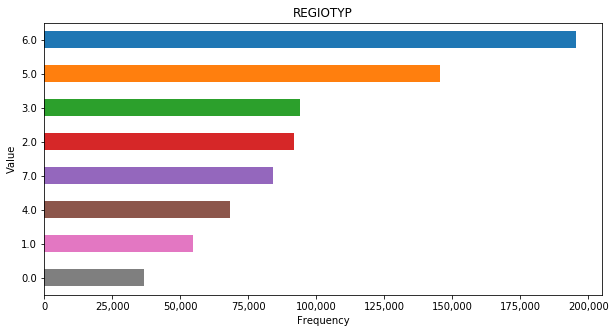

REGIOTYP
     counts  percentage
6.0  195286   25.360995
5.0  145359   18.877179
3.0   93929   12.198175
2.0   91662   11.903769
7.0   83943   10.901334
4.0   68180    8.854258
1.0   54798    7.116392
0.0   36868    4.787896


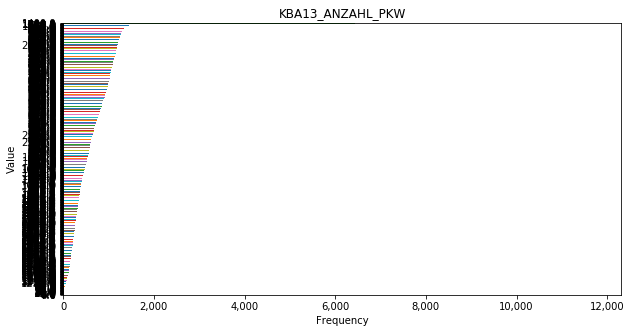

KBA13_ANZAHL_PKW
        counts  percentage
1400.0   11722    1.492448
1500.0    8291    1.055612
1300.0    6427    0.818287
1600.0    6135    0.781110
1700.0    3795    0.483180
1800.0    2617    0.333197
464.0     1604    0.204222
417.0     1604    0.204222
519.0     1600    0.203712
534.0     1496    0.190471
386.0     1458    0.185633
1900.0    1450    0.184614
395.0     1446    0.184105
481.0     1417    0.180413
455.0     1409    0.179394
483.0     1393    0.177357
452.0     1388    0.176721
418.0     1384    0.176211
454.0     1380    0.175702
450.0     1380    0.175702
494.0     1379    0.175575
459.0     1379    0.175575
492.0     1359    0.173028
504.0     1340    0.170609
387.0     1338    0.170354
420.0     1337    0.170227
439.0     1327    0.168954
506.0     1326    0.168827
388.0     1324    0.168572
456.0     1323    0.168445
487.0     1319    0.167935
402.0     1318    0.167808
421.0     1317    0.167681
499.0     1310    0.166790
466.0     1308    0.166535
491.0     1

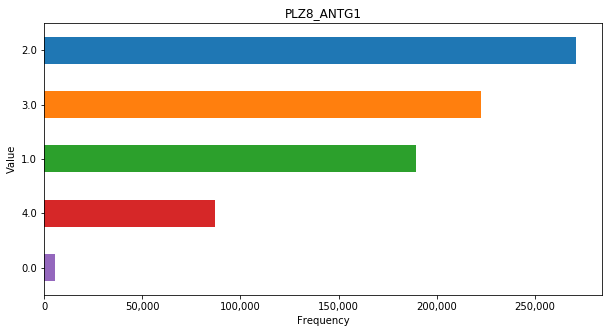

PLZ8_ANTG1
     counts  percentage
2.0  270590   34.928089
3.0  222355   28.701856
1.0  189247   24.428235
4.0   87044   11.235746
0.0    5470    0.706074


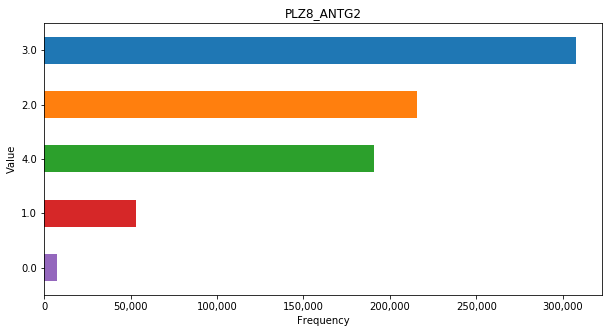

PLZ8_ANTG2
     counts  percentage
3.0  307283   39.664466
2.0  215767   27.851469
4.0  191005   24.655160
1.0   53213    6.868799
0.0    7438    0.960106


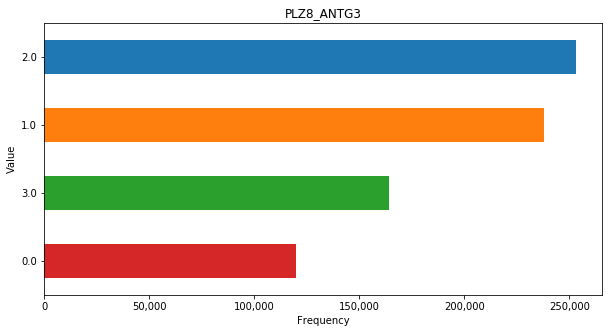

PLZ8_ANTG3
     counts  percentage
2.0  252994   32.656776
1.0  237878   30.705584
3.0  164040   21.174484
0.0  119794   15.463156


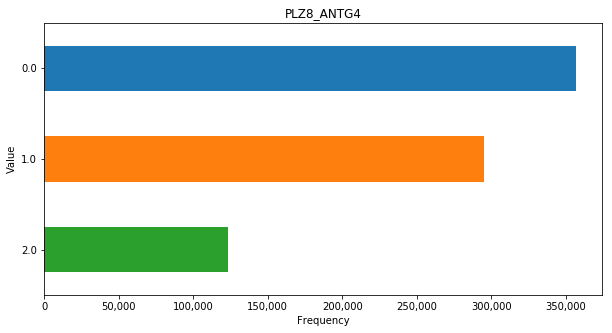

PLZ8_ANTG4
     counts  percentage
0.0  356389   46.003129
1.0  294986   38.077154
2.0  123331   15.919717


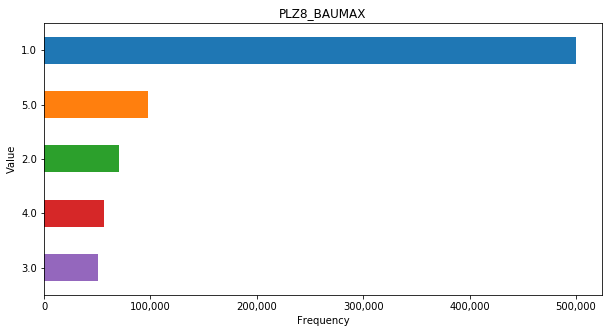

PLZ8_BAUMAX
     counts  percentage
1.0  499550   64.482526
5.0   97333   12.563863
2.0   70407    9.088222
4.0   56684    7.316840
3.0   50732    6.548549


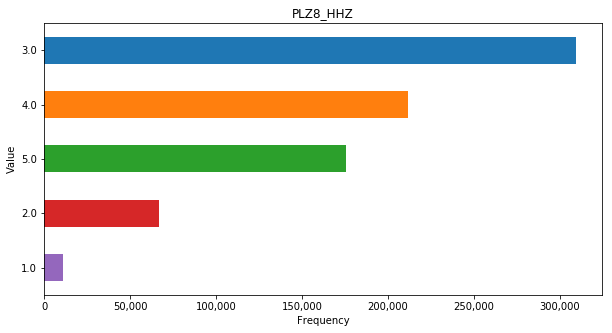

PLZ8_HHZ
     counts  percentage
3.0  309146   39.904945
4.0  211911   27.353732
5.0  175813   22.694158
2.0   66891    8.634372
1.0   10945    1.412794


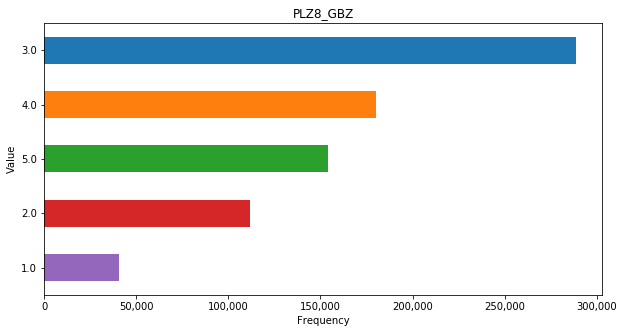

PLZ8_GBZ
     counts  percentage
3.0  288383   37.224831
4.0  180252   23.267149
5.0  153883   19.863406
2.0  111588   14.403916
1.0   40600    5.240698


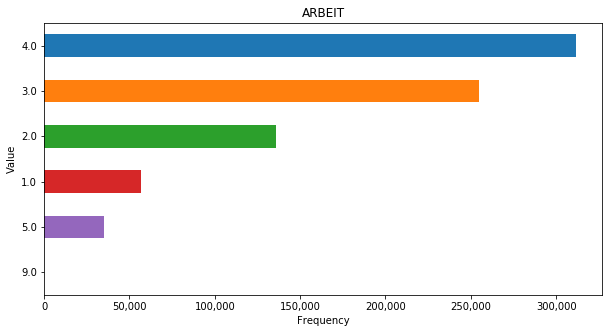

ARBEIT
     counts  percentage
4.0  311339   39.211214
3.0  254988   32.114155
2.0  135662   17.085787
1.0   56767    7.149451
5.0   35090    4.419368
9.0     159    0.020025


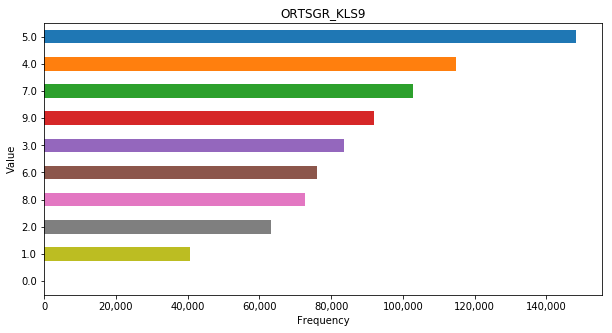

ORTSGR_KLS9
     counts  percentage
5.0  148096   18.651772
4.0  114909   14.472075
7.0  102866   12.955334
9.0   91879   11.571590
3.0   83542   10.521596
6.0   75995    9.571098
8.0   72709    9.157247
2.0   63362    7.980051
1.0   40589    5.111933
0.0      58    0.007305


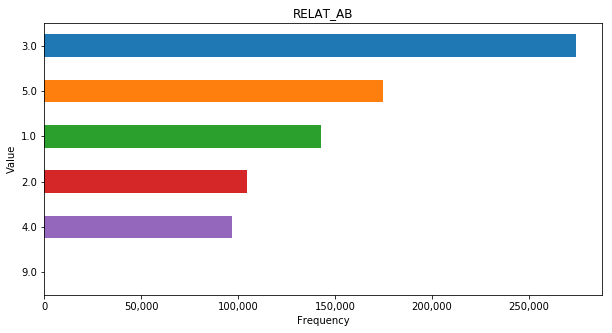

RELAT_AB
     counts  percentage
3.0  274008   34.509606
5.0  174964   22.035629
1.0  142907   17.998249
2.0  104846   13.204703
4.0   97121   12.231787
9.0     159    0.020025


In [15]:
bar_graph_for_each_column(azdias)  

### Explore AZDIAS_Feature_Summary.csv: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

In [16]:
explore_data(feat_info)   

Shape: rows, cols
(85, 4)


Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB
None

Desciptive stats:
              attribute information_level     type missing_or_unknown
count                85                85       85                 85
unique               85                 9        5                  9
top     CAMEO_DEUG_2015            person  ordinal               [-1]
freq                  1                43       49                 26


In [17]:
feat_info

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
40               TITEL_KZ            person  categorical             [-1,0]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
43               ALTER_HH         household     interval                [0]
44           ANZ_PERSONEN         household      numeric                 []
45              ANZ_TITEL         household      numeric                 []
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]
47           KK_KUNDENTYP         household  categorical               [-1]
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]
49         WOHNDAUER_2008         household      ordinal             [-1,0]
50    ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51           ANZ_HH_TITEL          building      numeric        

In [18]:
feat_info.head(10)

attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
5          FINANZ_SPARER            person      ordinal               [-1]
6       FINANZ_VORSORGER            person      ordinal               [-1]
7         FINANZ_ANLEGER            person      ordinal               [-1]
8  FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9       FINANZ_HAUSBAUER            person      ordinal               [-1]

In [19]:
feat_info

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
40               TITEL_KZ            person  categorical             [-1,0]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
43               ALTER_HH         household     interval                [0]
44           ANZ_PERSONEN         household      numeric                 []
45              ANZ_TITEL         household      numeric                 []
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]
47           KK_KUNDENTYP         household  categorical               [-1]
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]
49         WOHNDAUER_2008         household      ordinal             [-1,0]
50    ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51           ANZ_HH_TITEL          building      numeric        

In [20]:
# bar_graph_for_each_column?

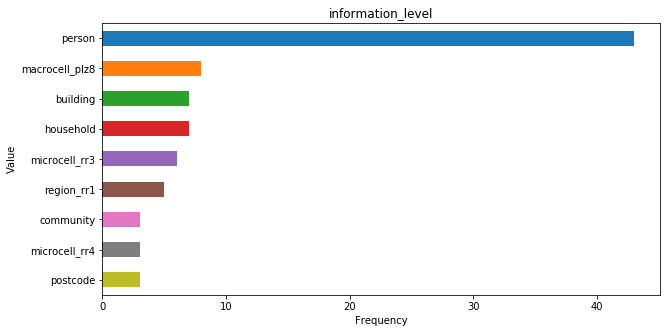

information_level
                counts  percentage
person              43   50.588235
macrocell_plz8       8    9.411765
building             7    8.235294
household            7    8.235294
microcell_rr3        6    7.058824
region_rr1           5    5.882353
community            3    3.529412
microcell_rr4        3    3.529412
postcode             3    3.529412


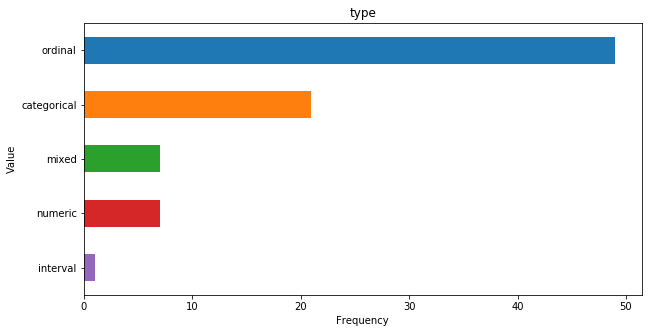

type
             counts  percentage
ordinal          49   57.647059
categorical      21   24.705882
mixed             7    8.235294
numeric           7    8.235294
interval          1    1.176471


In [21]:
bar_graph_for_each_column(feat_info, column_list=['information_level','type'])

Most data is about a person and is ordinal. Second group, after ordinal, is categorical.

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

### Identify missing or unknown data values and convert them to NaNs.

In [23]:
# how many missing (NAN) values there are in each column
# this is BEFORE we convert categories which are not misssing values, but denote missing or unknown information
# This is how much data is NATURALLY missing (Python NAN, SQL null, Excel blank)

azdias.isnull().sum()    
# this will give you the same result:
# azdias.isna().sum()       

# If you add it up to azdias.info() non-null, you will get 891221 in each row.

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [24]:
# how many missing (NAN) values there are in each column
# this is BEFORE we convert categories which are not misssing values, but denote missing or unknown information
# This is how much data is NATURALLY missing (Python NAN, SQL null, Excel blank)
def how_many_NA(df):
    """Loop thru columns. Give number of missing NA values.
    
    his function tells you how many missing values there are in each column.

    if you add it up to azdias.info() non-null, you will get 891221 in each row.
    
    This is an extended version of the function above. It also calculates % of missing columns. 
    Returns a dataframe/report on NAN
    """
    missing_NA_list = []
    missing_NA_percent_list = []
    
    for column in df.columns.tolist():
        missing_NA = df[column].isna().sum()
        
        missing_NA_percent = missing_NA / len(df)
        
        missing_NA_list.append(missing_NA)
        missing_NA_percent_list.append(missing_NA_percent)
        
    missing_value_report_df = pd.DataFrame(
            {'Column': df.columns.tolist(),
             'missing_NA': missing_NA_list,
             'missing_NA_percent': missing_NA_percent_list
             }
            )
    return missing_value_report_df



In [25]:
azdias_NA_report = how_many_NA(azdias)
azdias_NA_report

Column  missing_NA  missing_NA_percent
0                AGER_TYP           0            0.000000
1    ALTERSKATEGORIE_GROB           0            0.000000
2               ANREDE_KZ           0            0.000000
3           CJT_GESAMTTYP        4854            0.005446
4       FINANZ_MINIMALIST           0            0.000000
5           FINANZ_SPARER           0            0.000000
6        FINANZ_VORSORGER           0            0.000000
7          FINANZ_ANLEGER           0            0.000000
8   FINANZ_UNAUFFAELLIGER           0            0.000000
9        FINANZ_HAUSBAUER           0            0.000000
10              FINANZTYP           0            0.000000
11            GEBURTSJAHR           0            0.000000
12        GFK_URLAUBERTYP        4854            0.005446
13       GREEN_AVANTGARDE           0            0.000000
14             HEALTH_TYP           0            0.000000
15    LP_LEBENSPHASE_FEIN        4854            0.005446
16    LP_LEBENSPHASE_GROB        4854            0.005446
17        LP_FAMILIE_FEIN        4854            0.005446
18        LP_FAMILIE_GROB        4854            0.005446
19         LP_STATUS_FEIN        4854            0.005446
20         LP_STATUS_GROB        4854            0.005446
21       NATIONALITAET_KZ           0            0.000000
22  PRAEGENDE_JUGENDJAHRE           0            0.000000
23         RETOURTYP_BK_S        4854            0.005446
24              SEMIO_SOZ           0            0.000000
25              SEMIO_FAM           0            0.000000
26              SEMIO_REL           0            0.000000
27              SEMIO_MAT           0            0.000000
28             SEMIO_VERT           0            0.000000
29             SEMIO_LUST           0            0.000000
30              SEMIO_ERL           0            0.000000
31             SEMIO_KULT           0            0.000000
32              SEMIO_RAT           0            0.000000
33             SEMIO_KRIT           0            0.000000
34              SEMIO_DOM           0            0.000000
35             SEMIO_KAEM           0            0.000000
36          SEMIO_PFLICHT           0            0.000000
37            SEMIO_TRADV           0            0.000000
38            SHOPPER_TYP           0            0.000000
39                SOHO_KZ       73499            0.082470
40               TITEL_KZ       73499            0.082470
41               VERS_TYP           0            0.000000
42               ZABEOTYP           0            0.000000
43               ALTER_HH       73499            0.082470
44           ANZ_PERSONEN       73499            0.082470
45              ANZ_TITEL       73499            0.082470
46     HH_EINKOMMEN_SCORE       18348            0.020587
47           KK_KUNDENTYP      584612            0.655967
48         W_KEIT_KIND_HH      107602            0.120735
49         WOHNDAUER_2008       73499            0.082470
50    ANZ_HAUSHALTE_AKTIV       93148            0.104517
51           ANZ_HH_TITEL       97008            0.108848
52            GEBAEUDETYP       93148            0.104517
53            KONSUMNAEHE       73969            0.082997
54       MIN_GEBAEUDEJAHR       93148            0.104517
55            OST_WEST_KZ       93148            0.104517
56               WOHNLAGE       93148            0.104517
57        CAMEO_DEUG_2015       98979            0.111060
58         CAMEO_DEU_2015       98979            0.111060
59        CAMEO_INTL_2015       98979            0.111060
60            KBA05_ANTG1      133324            0.149597
61            KBA05_ANTG2      133324            0.149597
62            KBA05_ANTG3      133324            0.149597
63            KBA05_ANTG4      133324            0.149597
64           KBA05_BAUMAX      133324            0.149597
65              KBA05_GBZ      133324            0.149597
66               BALLRAUM       93740            0.105182
67               EWDICHTE       93740            0.105182
68             IN

In [26]:
# how_many_NA?

In [27]:
# save to Excel
# azdias_NA_report.to_excel("azdias_NA_report.xlsx")

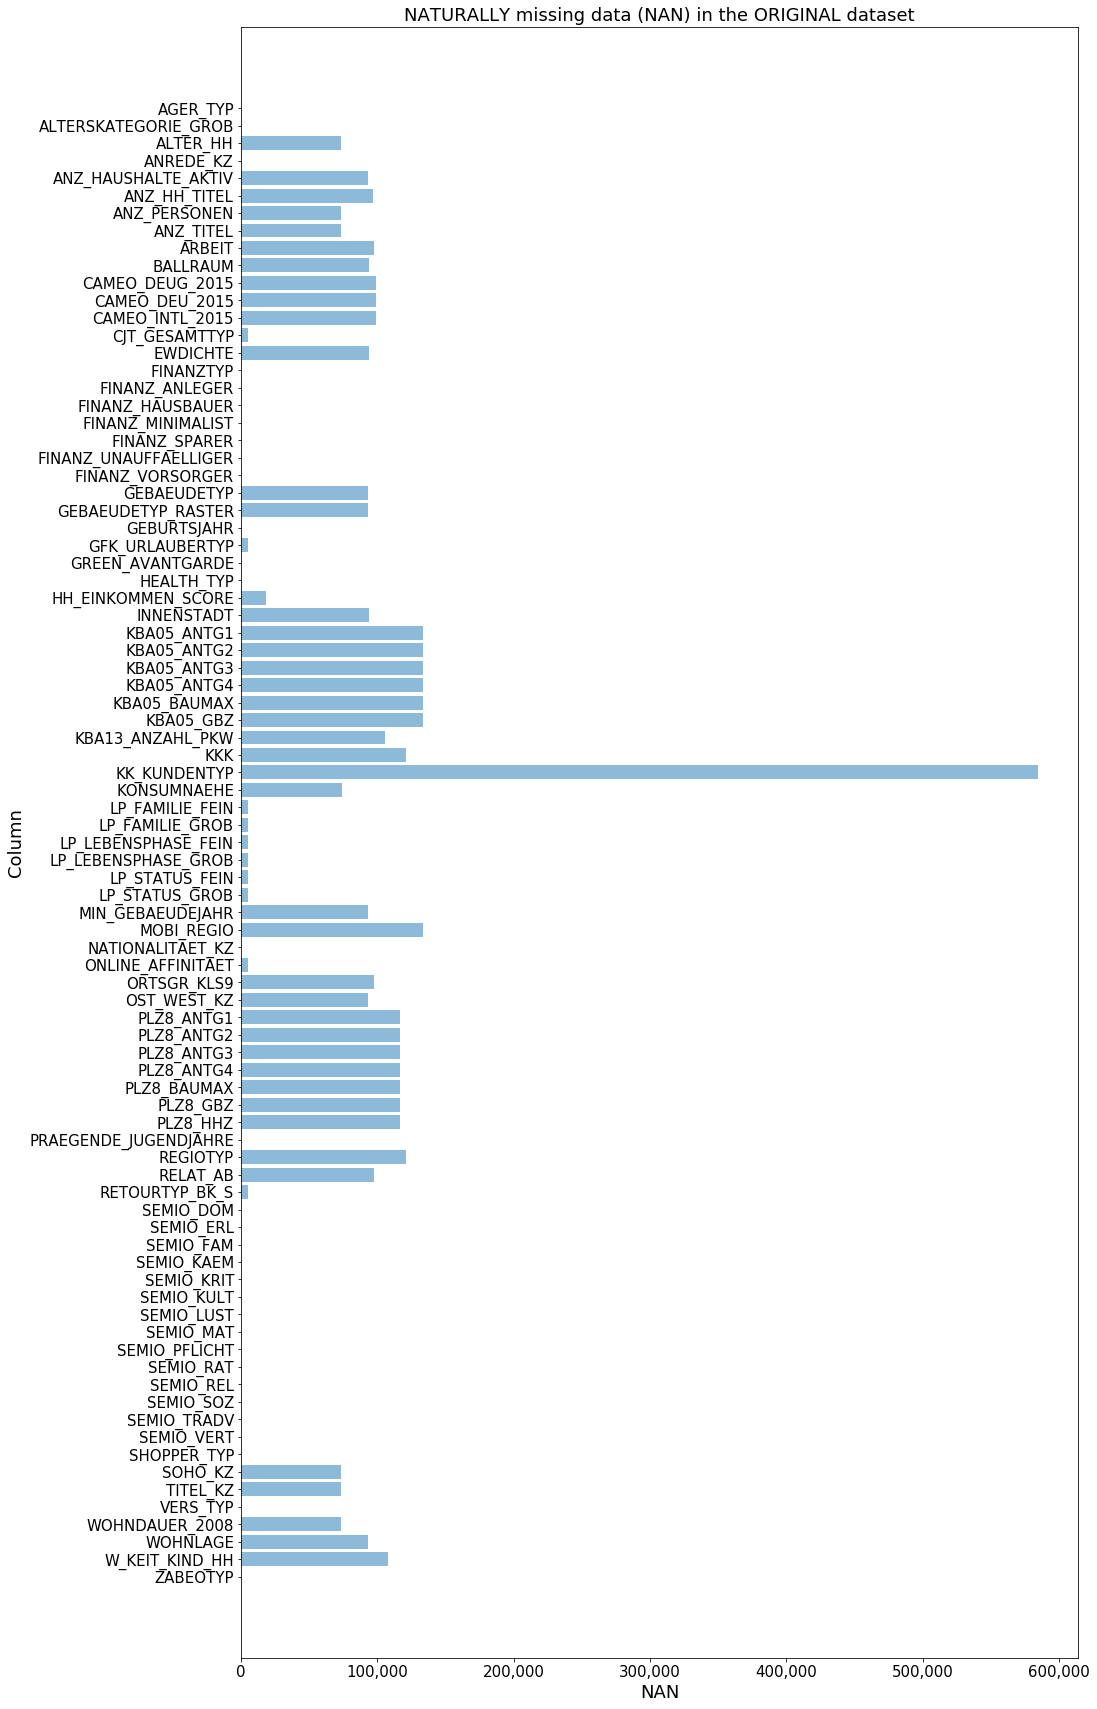

In [28]:
"""https://pythonspot.com/matplotlib-bar-chart/
https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib
https://stackoverflow.com/questions/28022227/sorted-bar-charts-with-pandas-matplotlib-or-seaborn
"""
fig, ax = plt.subplots(1, 1,figsize=(15, 30))
plt.barh(azdias_NA_report['Column'], azdias_NA_report['missing_NA'], align='center', alpha=0.5)
plt.ylabel('Column', fontsize=18)
plt.xlabel('NAN', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('NATURALLY missing data (NAN) in the ORIGINAL dataset', fontsize=18)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.invert_yaxis()

plt.show()

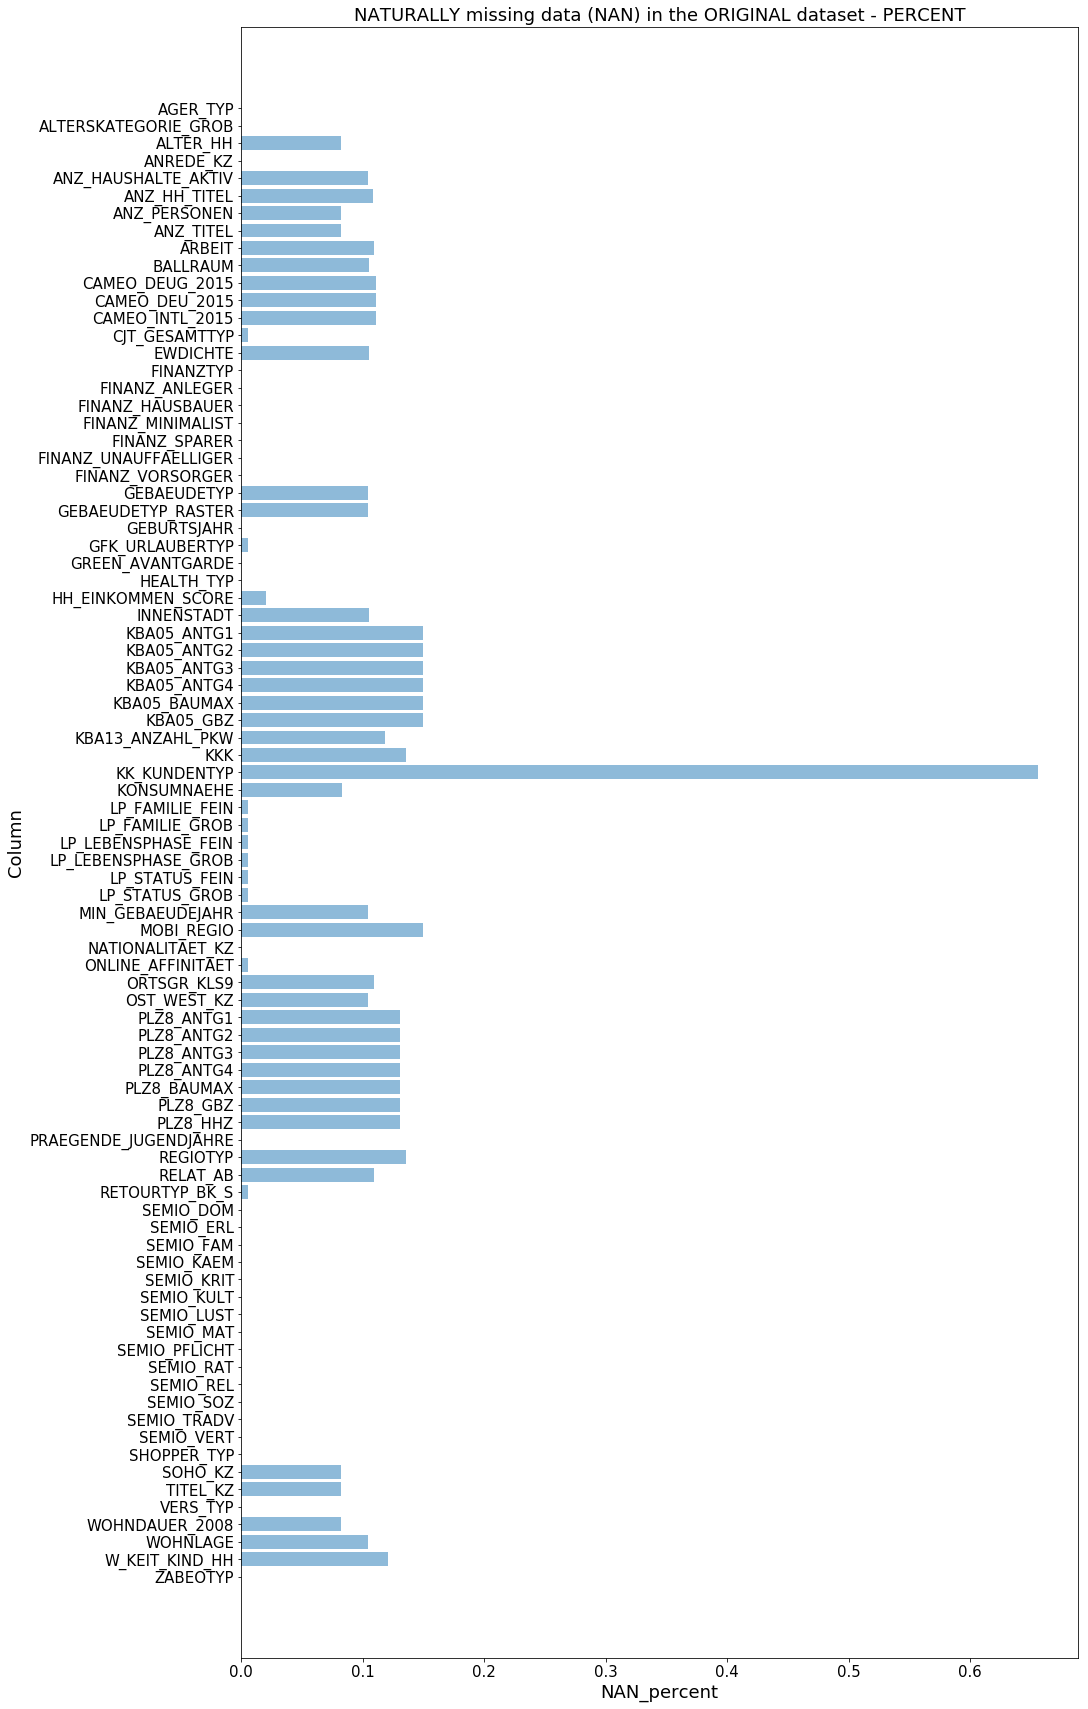

In [29]:
"""https://pythonspot.com/matplotlib-bar-chart/
https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib
https://stackoverflow.com/questions/28022227/sorted-bar-charts-with-pandas-matplotlib-or-seaborn
"""
fig, ax = plt.subplots(1, 1,figsize=(15, 30))
plt.barh(azdias_NA_report['Column'], azdias_NA_report['missing_NA_percent'], align='center', alpha=0.5)
plt.ylabel('Column', fontsize=18)
plt.xlabel('NAN_percent', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('NATURALLY missing data (NAN) in the ORIGINAL dataset - PERCENT', fontsize=18)

ax.invert_yaxis()

plt.show()

In [30]:
""" 
this is like VLOOKUP in Excel. Look up value from [missing_or_unknown] column of 
feat_info by value in [attribute] column of feat_info
https://stackoverflow.com/questions/18327624/find-elements-index-in-pandas-series

these values match feat_info.missing_or_unknown values

"""
for column in azdias.columns.tolist():
    print(feat_info.missing_or_unknown[feat_info[feat_info.attribute == column].index[0]])

[-1,0]
[-1,0,9]
[-1,0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[0]
[]
[]
[-1,0]
[0]
[0]
[0]
[0]
[0]
[0]
[-1,0]
[-1,0]
[0]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1,9]
[-1]
[-1]
[-1,0]
[-1]
[-1,9]
[0]
[]
[]
[-1,0]
[-1]
[-1,0]
[-1,0]
[0]
[]
[-1,0]
[]
[0]
[-1]
[-1]
[-1,X]
[XX]
[-1,XX]
[-1]
[-1]
[-1]
[-1]
[-1,0]
[-1,0]
[-1]
[-1]
[-1]
[]
[-1,0]
[]
[]
[-1,0]
[]
[-1]
[-1]
[-1]
[-1]
[-1,0]
[-1]
[-1]
[-1,9]
[-1,0]
[-1,9]


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

##### Identify missing or unknown data values and convert them to NaNs.



In [31]:
def how_many_coded_uknown_or_missing(df):
    
    """"loop thru columns of df.
        Look at which specific values are codes for missing and uknown.
        How many values are coded as missing or unknown? Print report.
    """
    
    # initialize empty lists
    coded_unknown_or_missing_list = []
    coded_unknown_or_missing_percent_list = []
    i = 0

    # loop thu each column. Which values indicate missing and uknown?
    # how many values are coded as missing and uknown? (They would need to be replaced with NAN)
    for column in df.columns.tolist():
        
        # this is just the number of column
        print("Colum number:", i)
        i=i+1

        list_NAN_for_this_column = feat_info.missing_or_unknown[feat_info[feat_info.attribute == column].index[0]]

        print(column)
        
        print("missing' or 'unknown' code BEFORE parsing/cleaning the string")
        print(list_NAN_for_this_column)
        print(type(list_NAN_for_this_column))

        list_NAN_for_this_column = list_NAN_for_this_column.strip('[').strip(']').split(",")

        print("missing' or 'unknown' code AFTER parsing/cleaning the string")
        print(list_NAN_for_this_column)
        print(type(list_NAN_for_this_column))

        print("Sum of values in the original dataset which are coded as unknown or missing.")

        coded_unknown_or_missing = df[column].isin(list_NAN_for_this_column).sum()

        print(coded_unknown_or_missing)
        print("#############################################################################")
        print()
        
        
        # append sum of values are coded as missing and uknown to the list
        coded_unknown_or_missing_list.append(coded_unknown_or_missing)

        coded_unknown_or_missing_percent = coded_unknown_or_missing / len(df)

        coded_unknown_or_missing_percent_list.append(coded_unknown_or_missing_percent)    

    # create df
    
    coded_missing_unknown_report_df = pd.DataFrame(
                {
                 'Column': df.columns.tolist(),
                 'Coded_Uknown_or_Missing': coded_unknown_or_missing_list,
                 'Coded_Uknown_or_Missing_Percent': coded_unknown_or_missing_percent_list
                 }
                )
    
    return coded_missing_unknown_report_df  

In [32]:
azdias_coded_unknown_or_missing_report = how_many_coded_uknown_or_missing(azdias)

Colum number: 0
AGER_TYP
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1,0]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1', '0']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or missing.
685843
#############################################################################

Colum number: 1
ALTERSKATEGORIE_GROB
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1,0,9]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1', '0', '9']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or missing.
2881
#############################################################################

Colum number: 2
ANREDE_KZ
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1,0]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1', '0']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or 

0
#############################################################################

Colum number: 29
SEMIO_LUST
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1,9]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1', '9']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or missing.
0
#############################################################################

Colum number: 30
SEMIO_ERL
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1,9]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1', '9']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or missing.
0
#############################################################################

Colum number: 31
SEMIO_KULT
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1,9]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1', '9']
<class 'list'>
Sum of 

0
#############################################################################

Colum number: 53
KONSUMNAEHE
missing' or 'unknown' code BEFORE parsing/cleaning the string
[]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or missing.
0
#############################################################################

Colum number: 54
MIN_GEBAEUDEJAHR
missing' or 'unknown' code BEFORE parsing/cleaning the string
[0]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['0']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or missing.
0
#############################################################################

Colum number: 55
OST_WEST_KZ
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1']
<class 'list'>
Sum of values in the orig

0
#############################################################################

Colum number: 77
PLZ8_ANTG3
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or missing.
0
#############################################################################

Colum number: 78
PLZ8_ANTG4
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1']
<class 'list'>
Sum of values in the original dataset which are coded as unknown or missing.
0
#############################################################################

Colum number: 79
PLZ8_BAUMAX
missing' or 'unknown' code BEFORE parsing/cleaning the string
[-1,0]
<class 'str'>
missing' or 'unknown' code AFTER parsing/cleaning the string
['-1', '0']
<class 'list'>
Sum of values in th

In [33]:
# azdias_coded_unknown_or_missing_report.to_excel("azdias_coded_unknown_or_missing_report.xlsx")

In [34]:
azdias_coded_unknown_or_missing_report

Column  Coded_Uknown_or_Missing  \
0                AGER_TYP                   685843   
1    ALTERSKATEGORIE_GROB                     2881   
2               ANREDE_KZ                        0   
3           CJT_GESAMTTYP                        0   
4       FINANZ_MINIMALIST                        0   
5           FINANZ_SPARER                        0   
6        FINANZ_VORSORGER                        0   
7          FINANZ_ANLEGER                        0   
8   FINANZ_UNAUFFAELLIGER                        0   
9        FINANZ_HAUSBAUER                        0   
10              FINANZTYP                        0   
11            GEBURTSJAHR                   392318   
12        GFK_URLAUBERTYP                        0   
13       GREEN_AVANTGARDE                        0   
14             HEALTH_TYP                   111196   
15    LP_LEBENSPHASE_FEIN                    92778   
16    LP_LEBENSPHASE_GROB                    89718   
17        LP_FAMILIE_FEIN                    72938   
18        LP_FAMILIE_GROB                    72938   
19         LP_STATUS_FEIN                        0   
20         LP_STATUS_GROB                        0   
21       NATIONALITAET_KZ                   108315   
22  PRAEGENDE_JUGENDJAHRE                   108164   
23         RETOURTYP_BK_S                        0   
24              SEMIO_SOZ                        0   
25              SEMIO_FAM                        0   
26              SEMIO_REL                        0   
27              SEMIO_MAT                        0   
28             SEMIO_VERT                        0   
29             SEMIO_LUST                        0   
30              SEMIO_ERL                        0   
31             SEMIO_KULT                        0   
32              SEMIO_RAT                        0   
33             SEMIO_KRIT                        0   
34              SEMIO_DOM                        0   
35             SEMIO_KAEM                        0   
36          SEMIO_PFLICHT                        0   
37            SEMIO_TRADV                        0   
38            SHOPPER_TYP                   111196   
39                SOHO_KZ                        0   
40               TITEL_KZ                   815562   
41               VERS_TYP                   111196   
42               ZABEOTYP                        0   
43               ALTER_HH                   236768   
44           ANZ_PERSONEN                        0   
45              ANZ_TITEL                        0   
46     HH_EINKOMMEN_SCORE                        0   
47           KK_KUNDENTYP                        0   
48         W_KEIT_KIND_HH                    40386   
49         WOHNDAUER_2008                        0   
50    ANZ_HAUSHALTE_AKTIV                     6463   
51           ANZ_HH_TITEL                        0   
52            GEBAEUDETYP                        0   
53            KONSUMNAEHE                        0   
54       MIN_GEBAEUDEJAHR                        0   
55            OST_WEST_KZ                        0   
56               WOHNLAGE                        0   
57        CAMEO_DEUG_2015                      373   
58         CAMEO_DEU_2015                      373   
59        CAMEO_INTL_2015                      373   
60            KBA05_ANTG1                        0   
61            KBA05_ANTG2                        0   
62            KBA05_ANTG3                        0   
63            KBA05_ANTG4                        0   
64           KBA05_BAUMAX                   343200   
65              KBA05_GBZ                        0   
66               BALLRAUM                        0   
67               EWDICHTE                        0   
68             INNENSTADT                        0   
69     GEBAEUDETYP_RASTER                        0   
70                    KKK                    36868   
71             MOBI_REGIO                        0   
72      ONLINE_AFFINITAET                        0   
73               REGIOT

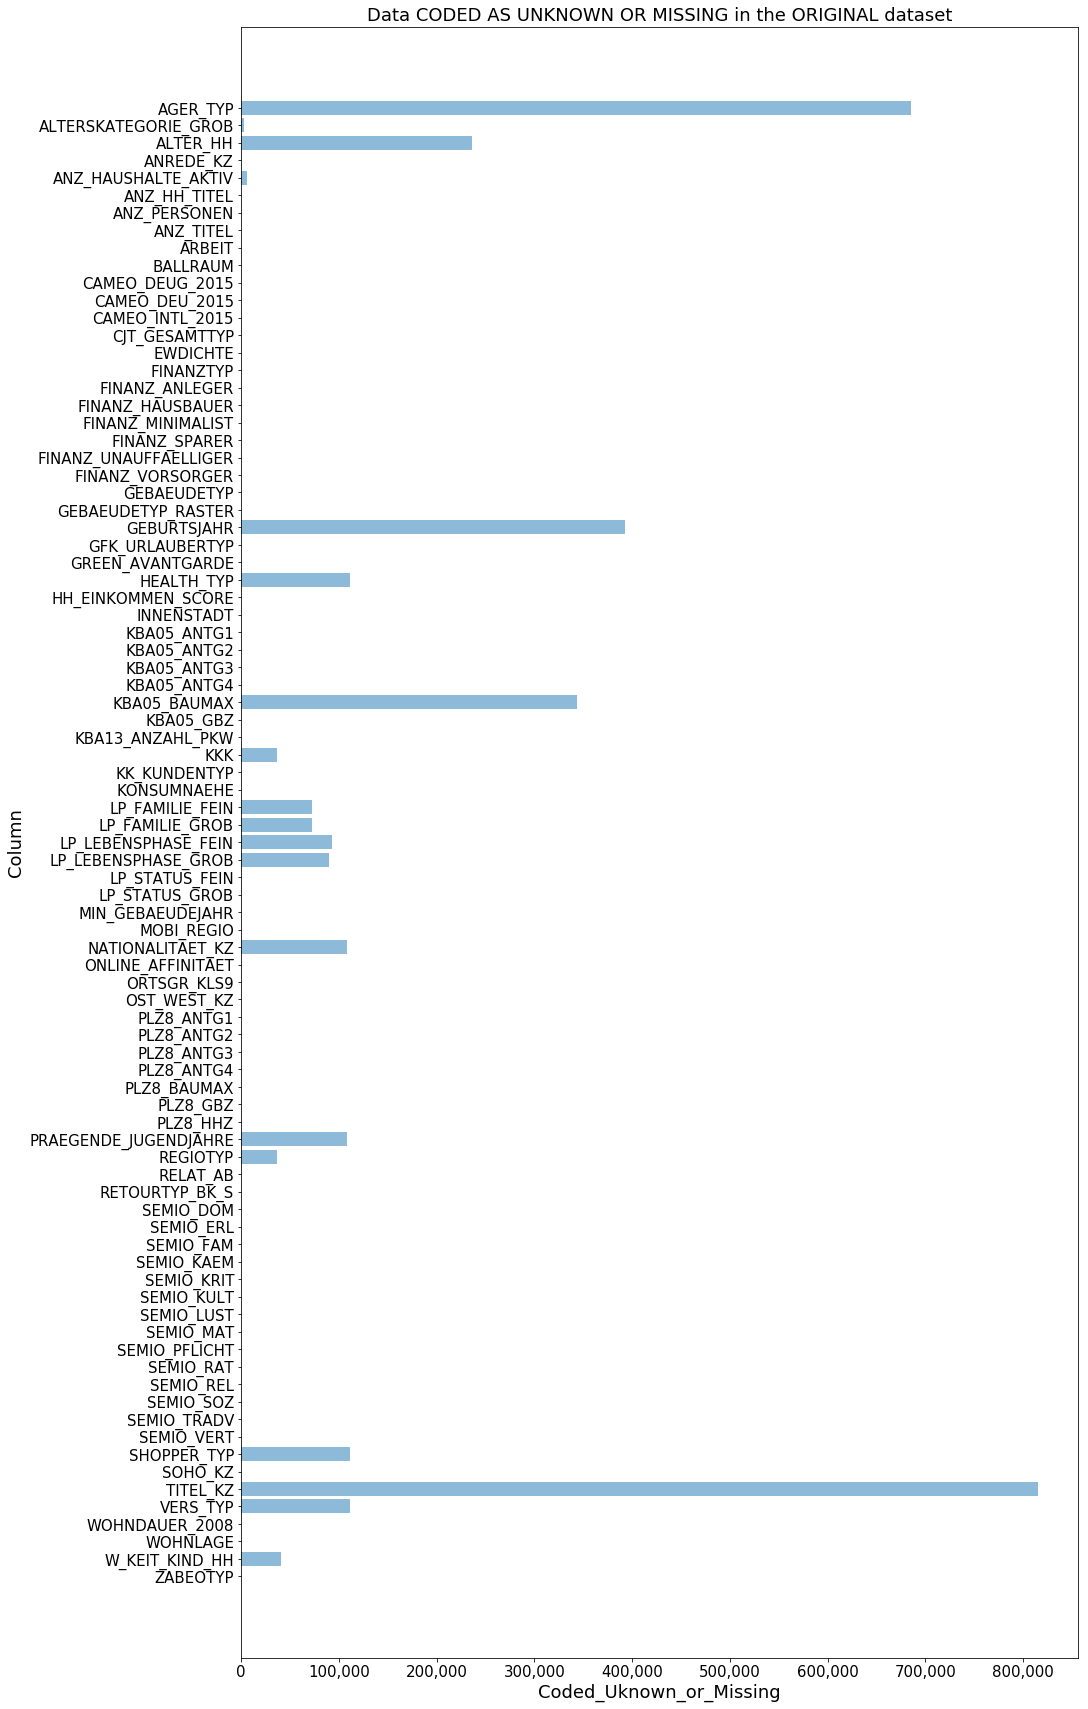

In [35]:
"""https://pythonspot.com/matplotlib-bar-chart/
https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib
https://stackoverflow.com/questions/28022227/sorted-bar-charts-with-pandas-matplotlib-or-seaborn
"""
fig, ax = plt.subplots(1, 1,figsize=(15, 30))
plt.barh(azdias_coded_unknown_or_missing_report['Column'], azdias_coded_unknown_or_missing_report['Coded_Uknown_or_Missing'], align='center', alpha=0.5)
plt.ylabel('Column', fontsize=18)
plt.xlabel('Coded_Uknown_or_Missing', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Data CODED AS UNKNOWN OR MISSING in the ORIGINAL dataset', fontsize=18)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.invert_yaxis()

plt.show()

In [36]:
def replace_coded_as_missing_unknown_with_NANs(df):
    
    """
    copy dataframe 
    
    in the copy, replace missing and uknown codes with NAN
    
    int64 gets replaced with float64, not sure why, probably cus NAN corresponds to a float
    
    https://stackoverflow.com/questions/53819909/pandas-replace-values-in-dataframe-conditionally-based-on-string-compare
    
    https://stackoverflow.com/questions/41870093/pandas-shift-converts-my-column-from-integer-to-float
    
    """
    
    # create a copy
    df_cleaned = df.copy()
    
    for column in df_cleaned.columns.tolist():
        
        # which values in this columnn are indicating missing or uknown?
        list_NAN_for_this_column = feat_info.missing_or_unknown[feat_info[feat_info.attribute == column].index[0]]
       
        # clean up the missing and unkown codes
        list_NAN_for_this_column = list_NAN_for_this_column.strip('[').strip(']').split(",")
                
        # replace with NAN. 2 methods. Link in docustring from Stack Overflow. Both work well and been tested
        
#        df_cleaned[column] = np.where(df_cleaned[column].isin(list_NAN_for_this_column), np.nan, df_cleaned[column])
        
        df_cleaned.loc[df_cleaned[column].isin(list_NAN_for_this_column), column] = np.nan
        
    return df_cleaned

In [37]:
azdias_cleaned = replace_coded_as_missing_unknown_with_NANs(azdias)  

In [38]:
def check_column(df, df_cleaned, column):
    """check if i replaced the right values with NAN"""
    print("delete these values:", feat_info.missing_or_unknown[feat_info[feat_info.attribute == column].index[0]])
    print()
    print(df[column].value_counts())
    print()
    print(df_cleaned[column].value_counts())

In [39]:
check_column(azdias, azdias_cleaned, 'AGER_TYP')

delete these values: [-1,0]

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64


In [40]:
for column in ['ALTERSKATEGORIE_GROB', 'ORTSGR_KLS9', 'RELAT_AB', 'ANREDE_KZ']:
    check_column(azdias, azdias_cleaned, column)
    print('################################')
    print()

delete these values: [-1,0,9]

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: ALTERSKATEGORIE_GROB, dtype: int64
################################

delete these values: [-1,0]

5.0    148096
4.0    114909
7.0    102866
9.0     91879
3.0     83542
6.0     75995
8.0     72709
2.0     63362
1.0     40589
0.0        58
Name: ORTSGR_KLS9, dtype: int64

5.0    148096
4.0    114909
7.0    102866
9.0     91879
3.0     83542
6.0     75995
8.0     72709
2.0     63362
1.0     40589
Name: ORTSGR_KLS9, dtype: int64
################################

delete these values: [-1,9]

3.0    274008
5.0    174964
1.0    142907
2.0    104846
4.0     97121
9.0       159
Name: RELAT_AB, dtype: int64

3.0    274008
5.0    174964
1.0    142907
2.0    104846
4.0     97121
Name: RELAT_AB, dtype: int64
################################

delete these values: [-1,0]

2    465305
1    425916
Name: ANREDE_

In [41]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_cleaned_NA_report = how_many_NA(azdias_cleaned)
azdias_cleaned_NA_report

Column  missing_NA  missing_NA_percent
0                AGER_TYP      685843            0.769554
1    ALTERSKATEGORIE_GROB        2881            0.003233
2               ANREDE_KZ           0            0.000000
3           CJT_GESAMTTYP        4854            0.005446
4       FINANZ_MINIMALIST           0            0.000000
5           FINANZ_SPARER           0            0.000000
6        FINANZ_VORSORGER           0            0.000000
7          FINANZ_ANLEGER           0            0.000000
8   FINANZ_UNAUFFAELLIGER           0            0.000000
9        FINANZ_HAUSBAUER           0            0.000000
10              FINANZTYP           0            0.000000
11            GEBURTSJAHR      392318            0.440203
12        GFK_URLAUBERTYP        4854            0.005446
13       GREEN_AVANTGARDE           0            0.000000
14             HEALTH_TYP      111196            0.124768
15    LP_LEBENSPHASE_FEIN       97632            0.109549
16    LP_LEBENSPHASE_GROB       94572            0.106115
17        LP_FAMILIE_FEIN       77792            0.087287
18        LP_FAMILIE_GROB       77792            0.087287
19         LP_STATUS_FEIN        4854            0.005446
20         LP_STATUS_GROB        4854            0.005446
21       NATIONALITAET_KZ      108315            0.121536
22  PRAEGENDE_JUGENDJAHRE      108164            0.121366
23         RETOURTYP_BK_S        4854            0.005446
24              SEMIO_SOZ           0            0.000000
25              SEMIO_FAM           0            0.000000
26              SEMIO_REL           0            0.000000
27              SEMIO_MAT           0            0.000000
28             SEMIO_VERT           0            0.000000
29             SEMIO_LUST           0            0.000000
30              SEMIO_ERL           0            0.000000
31             SEMIO_KULT           0            0.000000
32              SEMIO_RAT           0            0.000000
33             SEMIO_KRIT           0            0.000000
34              SEMIO_DOM           0            0.000000
35             SEMIO_KAEM           0            0.000000
36          SEMIO_PFLICHT           0            0.000000
37            SEMIO_TRADV           0            0.000000
38            SHOPPER_TYP      111196            0.124768
39                SOHO_KZ       73499            0.082470
40               TITEL_KZ      889061            0.997576
41               VERS_TYP      111196            0.124768
42               ZABEOTYP           0            0.000000
43               ALTER_HH      310267            0.348137
44           ANZ_PERSONEN       73499            0.082470
45              ANZ_TITEL       73499            0.082470
46     HH_EINKOMMEN_SCORE       18348            0.020587
47           KK_KUNDENTYP      584612            0.655967
48         W_KEIT_KIND_HH      147988            0.166051
49         WOHNDAUER_2008       73499            0.082470
50    ANZ_HAUSHALTE_AKTIV       99611            0.111769
51           ANZ_HH_TITEL       97008            0.108848
52            GEBAEUDETYP       93148            0.104517
53            KONSUMNAEHE       73969            0.082997
54       MIN_GEBAEUDEJAHR       93148            0.104517
55            OST_WEST_KZ       93148            0.104517
56               WOHNLAGE       93148            0.104517
57        CAMEO_DEUG_2015       99352            0.111479
58         CAMEO_DEU_2015       99352            0.111479
59        CAMEO_INTL_2015       99352            0.111479
60            KBA05_ANTG1      133324            0.149597
61            KBA05_ANTG2      133324            0.149597
62            KBA05_ANTG3      133324            0.149597
63            KBA05_ANTG4      133324            0.149597
64           KBA05_BAUMAX      476524            0.534687
65              KBA05_GBZ      133324            0.149597
66               BALLRAUM       93740            0.105182
67               EWDICHTE       93740            0.105182
68             IN

In [42]:
# azdias_cleaned_NA_report.to_excel("azdias_cleaned_NA_report.xlsx")

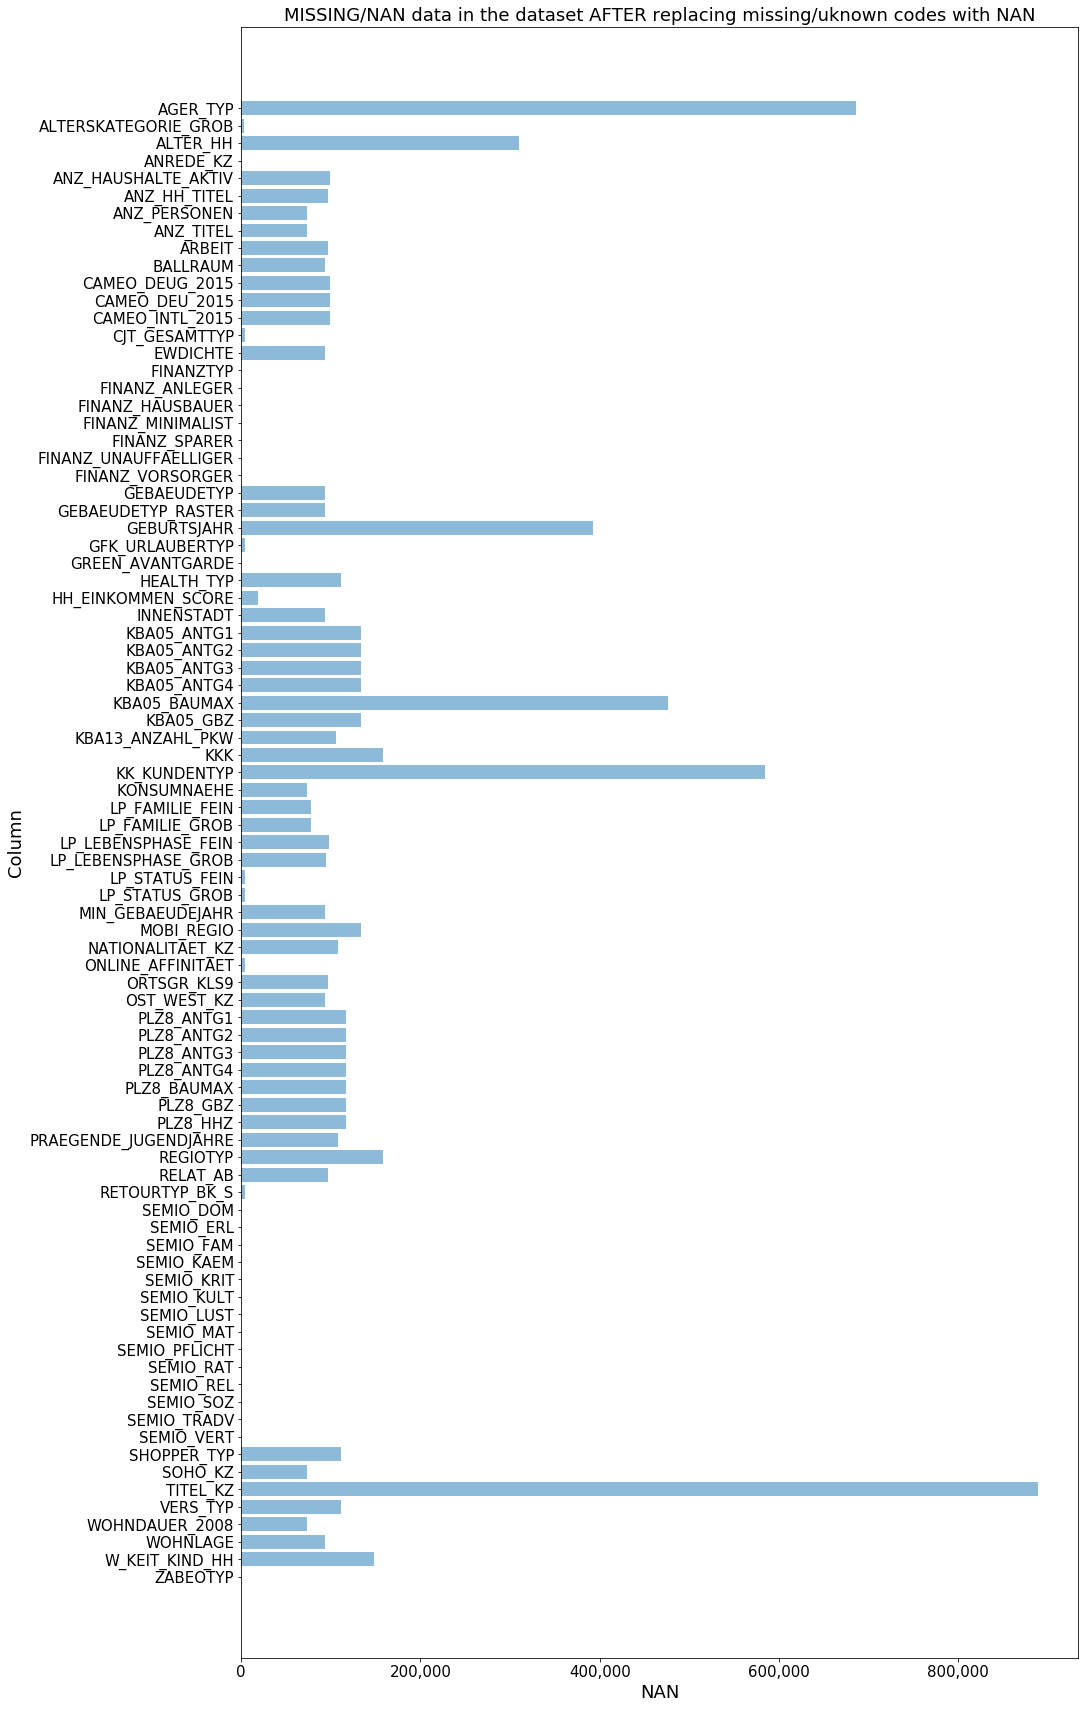

In [43]:
# Investigate patterns in the amount of missing data in each column.

"""https://pythonspot.com/matplotlib-bar-chart/
https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib
https://stackoverflow.com/questions/28022227/sorted-bar-charts-with-pandas-matplotlib-or-seaborn
"""
fig, ax = plt.subplots(1, 1,figsize=(15, 30))
plt.barh(azdias_cleaned_NA_report['Column'], azdias_cleaned_NA_report['missing_NA'], align='center', alpha=0.5)
plt.ylabel('Column', fontsize=18)
plt.xlabel('NAN', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('MISSING/NAN data in the dataset AFTER replacing missing/uknown codes with NAN', fontsize=18)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.invert_yaxis()

plt.show()

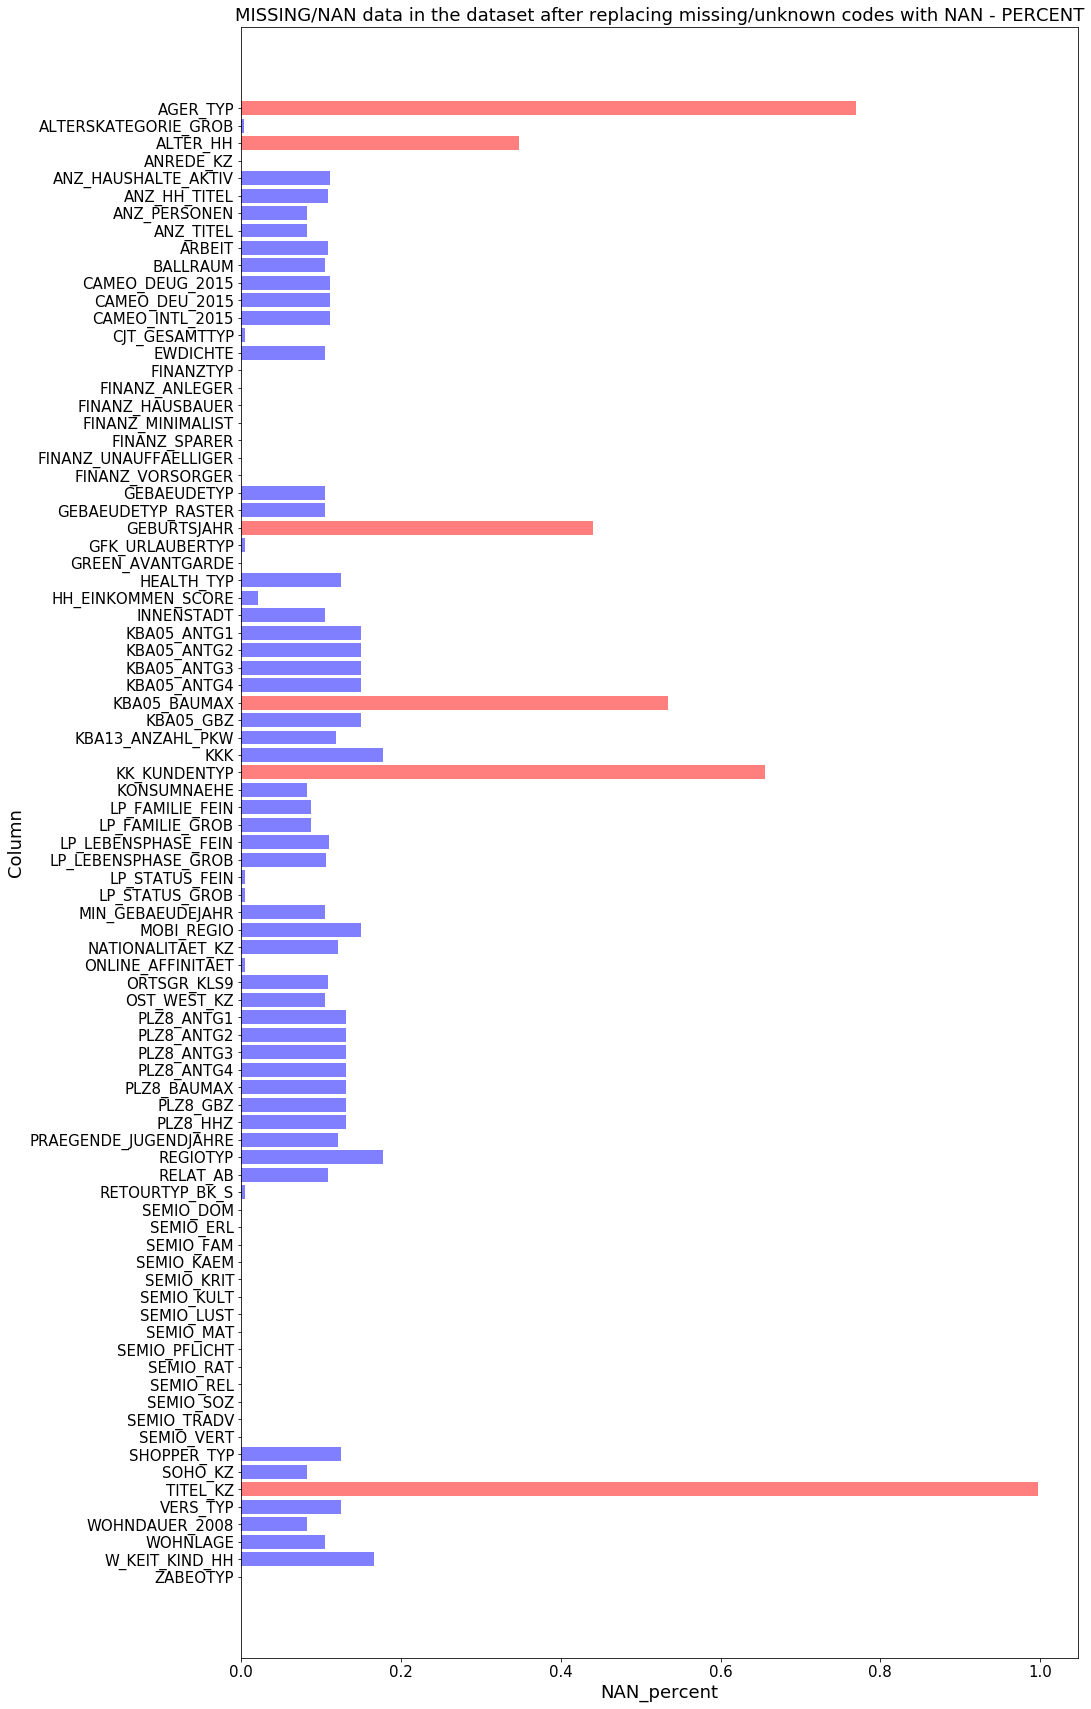

In [44]:
# Investigate patterns in the amount of missing data in each column.

"""

red bars indicate columns with more than 33% missing data

https://pythonspot.com/matplotlib-bar-chart/

https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

https://stackoverflow.com/questions/28022227/sorted-bar-charts-with-pandas-matplotlib-or-seaborn

https://stackoverflow.com/questions/22341271/get-list-from-pandas-dataframe-column

https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true-matplotlib

"""

##############################################################################

# in a visualization below, outliers will be marked in red. 
# Outlier is a column wiht more than 33% missing data
condition = azdias_cleaned_NA_report['missing_NA_percent']>0.33
 
azdias_cleaned_NA_report['colour'] = np.where(condition==True, 'red', 'blue')

##############################################################################


fig, ax = plt.subplots(1, 1,figsize=(15, 30))

clrs = list(azdias_cleaned_NA_report['colour'])
clrs

plt.barh(azdias_cleaned_NA_report['Column'], azdias_cleaned_NA_report['missing_NA_percent'], align='center', alpha=0.5, color = clrs)
plt.ylabel('Column', fontsize=18)
plt.xlabel('NAN_percent', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('MISSING/NAN data in the dataset after replacing missing/unknown codes with NAN - PERCENT', fontsize=18)

ax.invert_yaxis()

plt.show()

In [45]:
# Investigate patterns in the amount of missing data in each column.
#  the following columns have more than 1/3 of data missing
outliers_df = azdias_cleaned_NA_report[azdias_cleaned_NA_report['missing_NA_percent']>0.333]
outliers_df

Column  missing_NA  missing_NA_percent colour
0       AGER_TYP      685843            0.769554    red
11   GEBURTSJAHR      392318            0.440203    red
40      TITEL_KZ      889061            0.997576    red
43      ALTER_HH      310267            0.348137    red
47  KK_KUNDENTYP      584612            0.655967    red
64  KBA05_BAUMAX      476524            0.534687    red

In [46]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

print("BEFORE removing outlier colums, shape: ", azdias_cleaned.shape)

for outlier_column in outliers_df['Column'].tolist():
    del(azdias_cleaned[outlier_column])
    
print("AFTER removing outlier colums, shape: ", azdias_cleaned.shape)   

BEFORE removing outlier colums, shape:  (891221, 85)
AFTER removing outlier colums, shape:  (891221, 79)


Removed 6 columns with too much missing data

In [47]:
azdias_cleaned_NA_report = how_many_NA(azdias_cleaned)
azdias_cleaned_NA_report

Column  missing_NA  missing_NA_percent
0    ALTERSKATEGORIE_GROB        2881            0.003233
1               ANREDE_KZ           0            0.000000
2           CJT_GESAMTTYP        4854            0.005446
3       FINANZ_MINIMALIST           0            0.000000
4           FINANZ_SPARER           0            0.000000
5        FINANZ_VORSORGER           0            0.000000
6          FINANZ_ANLEGER           0            0.000000
7   FINANZ_UNAUFFAELLIGER           0            0.000000
8        FINANZ_HAUSBAUER           0            0.000000
9               FINANZTYP           0            0.000000
10        GFK_URLAUBERTYP        4854            0.005446
11       GREEN_AVANTGARDE           0            0.000000
12             HEALTH_TYP      111196            0.124768
13    LP_LEBENSPHASE_FEIN       97632            0.109549
14    LP_LEBENSPHASE_GROB       94572            0.106115
15        LP_FAMILIE_FEIN       77792            0.087287
16        LP_FAMILIE_GROB       77792            0.087287
17         LP_STATUS_FEIN        4854            0.005446
18         LP_STATUS_GROB        4854            0.005446
19       NATIONALITAET_KZ      108315            0.121536
20  PRAEGENDE_JUGENDJAHRE      108164            0.121366
21         RETOURTYP_BK_S        4854            0.005446
22              SEMIO_SOZ           0            0.000000
23              SEMIO_FAM           0            0.000000
24              SEMIO_REL           0            0.000000
25              SEMIO_MAT           0            0.000000
26             SEMIO_VERT           0            0.000000
27             SEMIO_LUST           0            0.000000
28              SEMIO_ERL           0            0.000000
29             SEMIO_KULT           0            0.000000
30              SEMIO_RAT           0            0.000000
31             SEMIO_KRIT           0            0.000000
32              SEMIO_DOM           0            0.000000
33             SEMIO_KAEM           0            0.000000
34          SEMIO_PFLICHT           0            0.000000
35            SEMIO_TRADV           0            0.000000
36            SHOPPER_TYP      111196            0.124768
37                SOHO_KZ       73499            0.082470
38               VERS_TYP      111196            0.124768
39               ZABEOTYP           0            0.000000
40           ANZ_PERSONEN       73499            0.082470
41              ANZ_TITEL       73499            0.082470
42     HH_EINKOMMEN_SCORE       18348            0.020587
43         W_KEIT_KIND_HH      147988            0.166051
44         WOHNDAUER_2008       73499            0.082470
45    ANZ_HAUSHALTE_AKTIV       99611            0.111769
46           ANZ_HH_TITEL       97008            0.108848
47            GEBAEUDETYP       93148            0.104517
48            KONSUMNAEHE       73969            0.082997
49       MIN_GEBAEUDEJAHR       93148            0.104517
50            OST_WEST_KZ       93148            0.104517
51               WOHNLAGE       93148            0.104517
52        CAMEO_DEUG_2015       99352            0.111479
53         CAMEO_DEU_2015       99352            0.111479
54        CAMEO_INTL_2015       99352            0.111479
55            KBA05_ANTG1      133324            0.149597
56            KBA05_ANTG2      133324            0.149597
57            KBA05_ANTG3      133324            0.149597
58            KBA05_ANTG4      133324            0.149597
59              KBA05_GBZ      133324            0.149597
60               BALLRAUM       93740            0.105182
61               EWDICHTE       93740            0.105182
62             INNENSTADT       93740            0.105182
63     GEBAEUDETYP_RASTER       93155            0.104525
64                    KKK      158064            0.177357
65             MOBI_REGIO      133324            0.149597
66      ONLINE_AFFINITAET        4854            0.005446
67               REGIOTYP      158064            0.177357
68       KBA13_AN

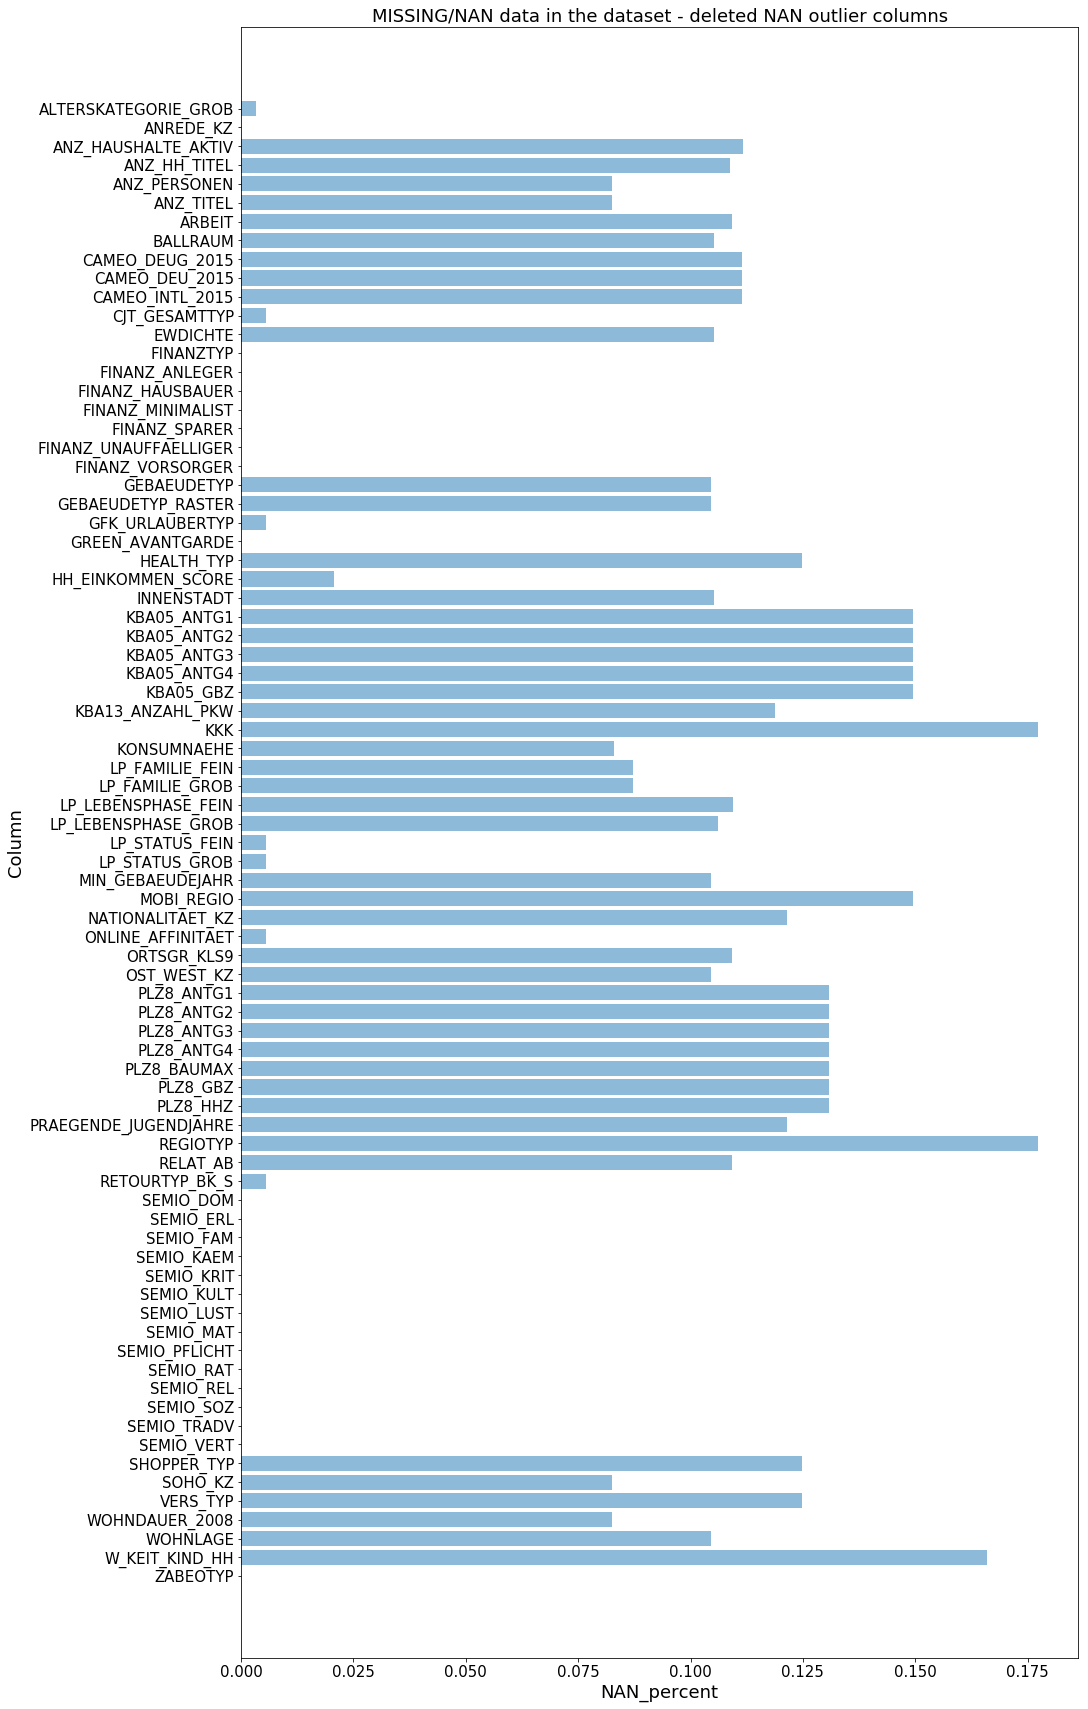

In [48]:
"""https://pythonspot.com/matplotlib-bar-chart/

https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

https://stackoverflow.com/questions/28022227/sorted-bar-charts-with-pandas-matplotlib-or-seaborn

"""

fig, ax = plt.subplots(1, 1,figsize=(15, 30))
plt.barh(azdias_cleaned_NA_report['Column'], azdias_cleaned_NA_report['missing_NA_percent'], align='center', alpha=0.5)
plt.ylabel('Column', fontsize=18)
plt.xlabel('NAN_percent', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('MISSING/NAN data in the dataset - deleted NAN outlier columns', fontsize=18)

ax.invert_yaxis()

plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The following columns have been removed. They all have more than 33% missing data

- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX


3 of them are related to age: AGER_TYP, GEBURTSJAHR and ALTER_HH.

KK_KUNDERTYP has the largest amount of natually missing (NA) data (66%).

AGE_TYP and TITEL_KUZ have the largest amount of data coded as missing or unknown.

An odd thing is that, once you remove the outlier columns, if you sort all variables alphabetically, then variables with missing values are grouped together in 3 groups. You can see this above in the chart **MISSING/NAN data in the dataset - deleted NAN outlier columns**. This could be just happenstance. It's like we have 3 groups or clusters. This is just a metaphor/comparison I use here, I know it's not a cluster in the statistical sense of the word.


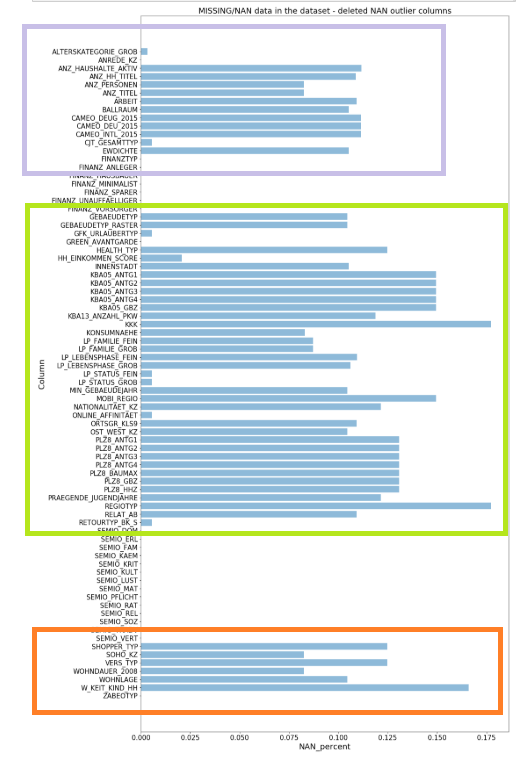

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [49]:
def count_NAN_in_each_ROW(df):
    """
    Count number of missing values in each row.
    Add a column NAN_count.
    https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe"""
    # number of columns MINUS smth like Excel COUNTA function (should count both text and numbers)
    df['NAN_count'] = df.shape[1] - df.apply(lambda x: x.count(), axis=1)
    
# test the function above
test = azdias_cleaned.sample(n=100, random_state=42)

count_NAN_in_each_ROW(test)

# test.to_excel("test.xlsx")

In [50]:
# test

In [51]:
# TESTING THE FUNCTION ABOVE - DONT USE FOR ANALYSIS
# sns.set(style="darkgrid")
# fig, ax = plt.subplots(1, 1,figsize=(20, 10))
# sns.countplot(x="NAN_count", data=test, color = 'blue', alpha=0.5)

# plt.ylabel('Frequency', fontsize=18)
# plt.xlabel('NAN Values in Row', fontsize=18)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.title('Missing Data in Rows TEST DONT USE FOR ANALYSIS', fontsize=18)
# plt.show()

In [52]:
"""https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column

https://pandas.pydata.org/pandas-docs/version/0.18/generated/pandas.DataFrame.sort_values.html#pandas.DataFrame.sort_values"""

def row_wise_NA_count_summary_report(df):
    row_wise_NA_count = df['NAN_count'].value_counts().to_frame()
    
    row_wise_NA_count= row_wise_NA_count.reset_index()
    
    row_wise_NA_count.columns = ['NAN Count in Row', 'Frequency']
    row_wise_NA_count=row_wise_NA_count.sort_values(by ='NAN Count in Row')
    
    return row_wise_NA_count

In [53]:
# """TEST - DONT USE FOR ANALYSIS"""

# row_wise_NA_count_summary_report_test = row_wise_NA_count_summary_report(test)

# row_wise_NA_count_summary_report_test

In [54]:
# this takes a while to run, but not too bad, just like 3-5 mins
count_NAN_in_each_ROW(azdias_cleaned)

In [55]:
# I added a column at the very end. NAN_count
azdias_cleaned.head(50)

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                    2.0        1.0            2.0                3.0   
1                    1.0        2.0            5.0                1.0   
2                    3.0        2.0            3.0                1.0   
3                    4.0        2.0            2.0                4.0   
4                    3.0        1.0            5.0                4.0   
5                    1.0        2.0            2.0                3.0   
6                    2.0        2.0            5.0                1.0   
7                    1.0        1.0            3.0                3.0   
8                    3.0        1.0            3.0                4.0   
9                    3.0        2.0            4.0                2.0   
10                   3.0        2.0            1.0                2.0   
11                   2.0        1.0            6.0                3.0   
12                   3.0        1.0            6.0                5.0   
13                   1.0        2.0            5.0                1.0   
14                   3.0        1.0            6.0                3.0   
15                   4.0        2.0            4.0                4.0   
16                   1.0        2.0            1.0                4.0   
17                   2.0        1.0            6.0                3.0   
18                   2.0        2.0            6.0                2.0   
19                   3.0        1.0            3.0                5.0   
20                   2.0        2.0            4.0                4.0   
21                   2.0        1.0            3.0                3.0   
22                   1.0        1.0            4.0                1.0   
23                   3.0        1.0            3.0                5.0   
24                   3.0        2.0            6.0                3.0   
25                   1.0        1.0            3.0                3.0   
26                   3.0        1.0            3.0                5.0   
27                   3.0        1.0            4.0                3.0   
28                   3.0        1.0            2.0                3.0   
29                   4.0        2.0            1.0                5.0   
30                   3.0        2.0            3.0                4.0   
31                   2.0        2.0            6.0                1.0   
32                   1.0        1.0            4.0                5.0   
33                   2.0        2.0            4.0                2.0   
34                   1.0        2.0            2.0                4.0   
35                   2.0        2.0            2.0                3.0   
36                   3.0        2.0            2.0                2.0   
37                   4.0        1.0            2.0                5.0   
38                   2.0        2.0            6.0                3.0   
39                   4.0        1.0            4.0                5.0   
40                   4.0        2.0            1.0                3.0   
41                   1.0        2.0            3.0                2.0   
42                   1.0        2.0            5.0                3.0   
43                   1.0        2.0            4.0                1.0   
44                   3.0        2.0            4.0                3.0   
45                   4.0        2.0            2.0                5.0   
46                   NaN        2.0            3.0                2.0   
47                   4.0        2.0            2.0                4.0   
48                   3.0        2.0            6.0                3.0   
49                   2.0        1.0            6.0                4.0   

    FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0             4.0               3.0             5.0                    5.0   
1             5.0               2.0             5.0                    4.0   
2             4.0               1.0           

In [56]:
# checking my NAN_count in each row
azdias_cleaned.isnull().sum(axis=1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
30        34
31         0
32         0
33         0
34         4
35        43
36         0
37         0
38         0
39         5
40         4
41         0
42         2
43         0
44         0
45         0
46        40
47         0
48        47
49         0
50         0
51         0
52         0
53        43
54        47
55         0
56         0
57         0
58         0
59         0
60         4
61        43
62        43
63         0
64         5
65         0
66         0
67         0
68         0
69        47
70         7
71         0
72         1
73         8
74         0
75        47
76        43

In [57]:
row_wise_NA_count_summary_report_azdias_cleaned = row_wise_NA_count_summary_report(azdias_cleaned)

row_wise_NA_count_summary_report_azdias_cleaned

# this is an aggregation. How many missing values per row vs frequency

NAN Count in Row  Frequency
0                  0     623209
7                  1      15738
2                  2      27926
6                  3      17629
10                 4      12607
5                  5      22515
8                  6      13771
9                  7      13714
4                  8      24592
16                 9       3042
12                10       5410
21                11       1127
22                12        766
15                13       3255
19                14       2243
13                15       4743
18                16       2505
23                17        677
26                18        428
20                19       1180
29                20        349
32                21        150
35                22        129
34                23        132
38                24         69
40                25         55
39                26         59
41                27         24
45                28          5
43                29         12
44                30          6
46                31          3
30                32        206
17                33       2985
11                34      10816
14                35       3911
36                36         84
24                37        538
27                38        421
37                39         77
33                40        137
28                41        356
42                42         21
3                 43      27369
31                44        155
25                45        494
1                 47      45578
48                48          1
47                49          2

In [58]:
len(azdias_cleaned) -623209

268012

In [59]:
print(sum(azdias_cleaned.isnull().any(axis=1)))

268012


In [60]:
# 268012 rows have missing values

In [61]:
# 30% of rows have missing values - this calculation is manual and hardcoded
(len(azdias_cleaned) -623209) / len(azdias_cleaned)

0.3007245116531141

In [62]:
print(azdias_cleaned['NAN_count'].describe())

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: NAN_count, dtype: float64


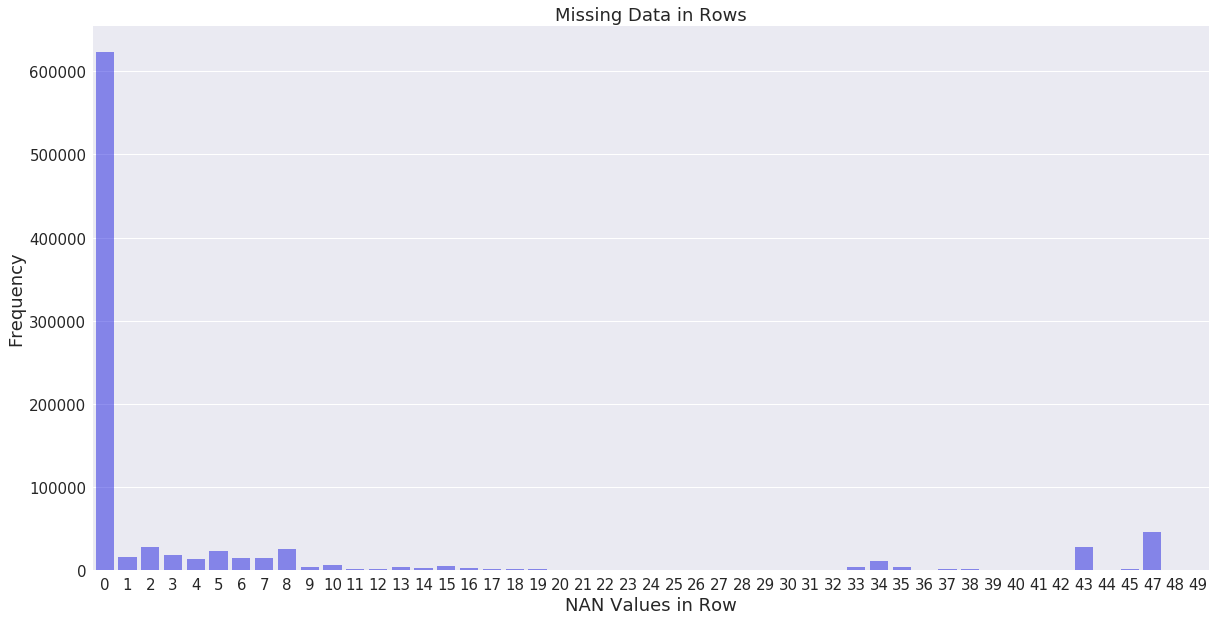

In [63]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(1, 1,figsize=(20, 10))
sns.countplot(x="NAN_count", data=azdias_cleaned, color = 'blue', alpha=0.5)

plt.ylabel('Frequency', fontsize=18)
plt.xlabel('NAN Values in Row', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Missing Data in Rows', fontsize=18)
plt.show()

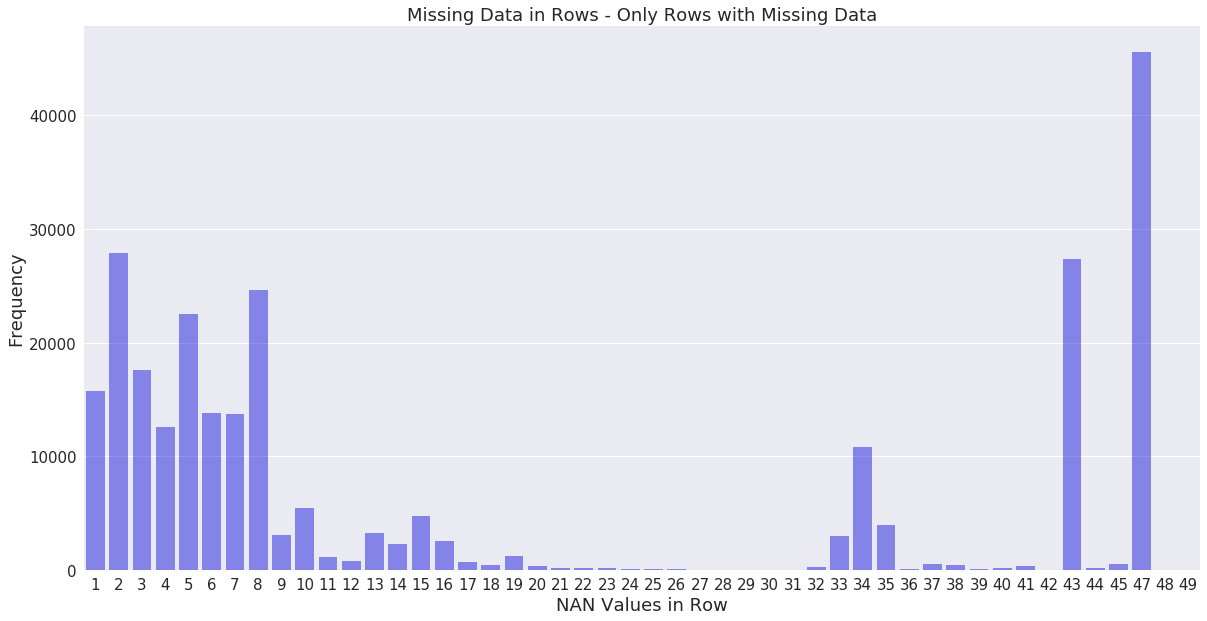

In [64]:
fig, ax = plt.subplots(1, 1,figsize=(20, 10))

sns.countplot(x="NAN_count", data=azdias_cleaned[azdias_cleaned['NAN_count']>0], color = 'blue', alpha=0.5)

plt.ylabel('Frequency', fontsize=18)
plt.xlabel('NAN Values in Row', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Missing Data in Rows - Only Rows with Missing Data', fontsize=18)
plt.show()

This is just my screenshot, where I can draw things on

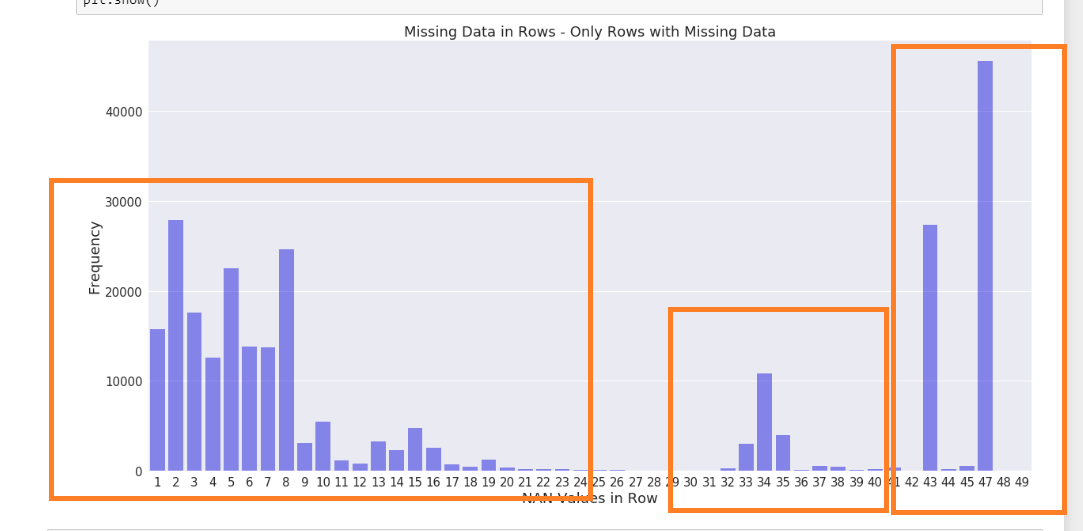

Notice how there are 3 "clusters" of data depending on how many values with missing data there are in each row. We can remove data with missing rows, depending on our threshold. Possible thresholds are: 

29-30ish

40-42ish

9-10 ish is also possible, to tolerate very few missing values

Below I will explore what's going to happen with different thresholds: how much data will be dropped.

In [65]:
azdias_cleaned.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0        1.0            2.0                3.0   
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0            4.0               3.0             5.0                    5.0   
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
0               3.0        4.0             10.0               0.0         NaN   
1               5.0        1.0             10.0               0.0         3.0   
2               5.0        1.0             10.0               1.0         3.0   
3               2.0        6.0              1.0               0.0         2.0   
4               2.0        5.0              5.0               0.0         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
0                 15.0                  4.0              2.0              2.0   
1                 21.0                  6.0              5.0              3.0   
2                  3.0                  1.0              1.0              1.0   
3                  NaN                  NaN              NaN              NaN   
4                 32.0                 10.0             10.0              5.0   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
0             1.0             1.0               NaN                    NaN   
1             2.0             1.0               1.0                   14.0   
2             3.0             2.0               1.0                   15.0   
3             9.0             4.0               1.0                    8.0   
4             3.0             2.0               1.0                    8.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
0             5.0        2.0        6.0        7.0        5.0         1.0   
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
0         5.0        3.0         3.0        4.0         7.0        6.0   
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
0         6.0            5.0          3.0          NaN      NaN       NaN   
1         4.0            7.0          6.0          3.0      1.0       2.0   
2         7.0            3.0          3.0          2.0      0.0       1.0   
3         5.0            4.0          4.0          1.0      0.0       1.0   
4         2.0            4.0          2.0          2.0      0.0       2.0   

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
0       3.0           NaN        NaN                 2.0             NaN   
1       5.0           2.0        0.0                 6.0             3.0   
2       5.0           1.0        0.0                 4.0         

In [66]:
azdias_cleaned['NAN_count'].describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: NAN_count, dtype: float64

In [67]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def divide_into_subsets(df_cleaned, threshold):
    
    """divide data into 2 subsets depending on how many missing values there in row
    provide threshold
    """
    condition = df_cleaned['NAN_count'] > threshold

    df_cleaned['many_missing_values_in_row'] = np.where(condition==True, 1, 0)

    print("Threshold of missing rows in the row: ", threshold)
    print()

    
    print('Total nrow:', len(df_cleaned['many_missing_values_in_row']))
    print()

    df_cleaned_missing_few = df_cleaned[df_cleaned['many_missing_values_in_row'] ==0]
    df_cleaned_missing_many = df_cleaned[df_cleaned['many_missing_values_in_row'] ==1]

    print("Few Missing Values. Will be kept.")
    print(len(df_cleaned_missing_few['NAN_count']))
    print()
    print("Lots of Missing Values. Will be deleted")
    print(len(df_cleaned_missing_many['NAN_count']))
    print()
    print("% of rows with lots of missing values. % of data deleted ") 
    print(df_cleaned['many_missing_values_in_row'].mean())
    
    return df_cleaned_missing_few, df_cleaned_missing_many, threshold

In [68]:
azdias_cleaned_missing_few, azdias_cleaned_missing_many, threshold =   divide_into_subsets(azdias_cleaned, 30)

Threshold of missing rows in the row:  30

Total nrow: 891221

Few Missing Values. Will be kept.
798067

Lots of Missing Values. Will be deleted
93154

% of rows with lots of missing values. % of data deleted 
0.104524018173


In [69]:
# threshold: 9
# keep: 774743
# drop: 116478 (0.130694855709)

# threshold: 29
# keep: 798061
# drop: 93160 (0.104530750509694)

# threshold: 30
# keep: 798067
# drop: 93154 (0.104524018173)

# threshold:  42
# keep: 817622
# drop: 73599 (0.08258221024863642)

### Let's use 30 as a threshold for how many mising values we can tolerate in our rows

In [70]:
azdias_cleaned_missing_few, azdias_cleaned_missing_many, threshold =   divide_into_subsets(azdias_cleaned, 30)

Threshold of missing rows in the row:  30

Total nrow: 891221

Few Missing Values. Will be kept.
798067

Lots of Missing Values. Will be deleted
93154

% of rows with lots of missing values. % of data deleted 
0.104524018173


In [71]:
azdias_cleaned.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0        1.0            2.0                3.0   
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0            4.0               3.0             5.0                    5.0   
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
0               3.0        4.0             10.0               0.0         NaN   
1               5.0        1.0             10.0               0.0         3.0   
2               5.0        1.0             10.0               1.0         3.0   
3               2.0        6.0              1.0               0.0         2.0   
4               2.0        5.0              5.0               0.0         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
0                 15.0                  4.0              2.0              2.0   
1                 21.0                  6.0              5.0              3.0   
2                  3.0                  1.0              1.0              1.0   
3                  NaN                  NaN              NaN              NaN   
4                 32.0                 10.0             10.0              5.0   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
0             1.0             1.0               NaN                    NaN   
1             2.0             1.0               1.0                   14.0   
2             3.0             2.0               1.0                   15.0   
3             9.0             4.0               1.0                    8.0   
4             3.0             2.0               1.0                    8.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
0             5.0        2.0        6.0        7.0        5.0         1.0   
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
0         5.0        3.0         3.0        4.0         7.0        6.0   
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
0         6.0            5.0          3.0          NaN      NaN       NaN   
1         4.0            7.0          6.0          3.0      1.0       2.0   
2         7.0            3.0          3.0          2.0      0.0       1.0   
3         5.0            4.0          4.0          1.0      0.0       1.0   
4         2.0            4.0          2.0          2.0      0.0       2.0   

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
0       3.0           NaN        NaN                 2.0             NaN   
1       5.0           2.0        0.0                 6.0             3.0   
2       5.0           1.0        0.0                 4.0         

In [72]:
azdias_cleaned_missing_few.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
1               5.0        1.0             10.0               0.0         3.0   
2               5.0        1.0             10.0               1.0         3.0   
3               2.0        6.0              1.0               0.0         2.0   
4               2.0        5.0              5.0               0.0         3.0   
5               5.0        2.0              1.0               0.0         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
1                 21.0                  6.0              5.0              3.0   
2                  3.0                  1.0              1.0              1.0   
3                  NaN                  NaN              NaN              NaN   
4                 32.0                 10.0             10.0              5.0   
5                  8.0                  2.0              1.0              1.0   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
1             2.0             1.0               1.0                   14.0   
2             3.0             2.0               1.0                   15.0   
3             9.0             4.0               1.0                    8.0   
4             3.0             2.0               1.0                    8.0   
5             4.0             2.0               1.0                    3.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
1         4.0            7.0          6.0          3.0      1.0       2.0   
2         7.0            3.0          3.0          2.0      0.0       1.0   
3         5.0            4.0          4.0          1.0      0.0       1.0   
4         2.0            4.0          2.0          2.0      0.0       2.0   
5         4.0            7.0          6.0          0.0      0.0       2.0   

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
1       5.0           2.0        0.0                 6.0             3.0   
2       5.0           1.0        0.0                 4.0             3.0   
3       3.0           0.0        0.0                 1.0         

In [73]:
# Investigate patterns in the amount of missing data in each column.
# Very few missing columns
no_or_very_few_NAN = azdias_cleaned_NA_report[azdias_cleaned_NA_report['missing_NA_percent']<0.025]

no_or_very_few_NAN

Column  missing_NA  missing_NA_percent
0    ALTERSKATEGORIE_GROB        2881            0.003233
1               ANREDE_KZ           0            0.000000
2           CJT_GESAMTTYP        4854            0.005446
3       FINANZ_MINIMALIST           0            0.000000
4           FINANZ_SPARER           0            0.000000
5        FINANZ_VORSORGER           0            0.000000
6          FINANZ_ANLEGER           0            0.000000
7   FINANZ_UNAUFFAELLIGER           0            0.000000
8        FINANZ_HAUSBAUER           0            0.000000
9               FINANZTYP           0            0.000000
10        GFK_URLAUBERTYP        4854            0.005446
11       GREEN_AVANTGARDE           0            0.000000
17         LP_STATUS_FEIN        4854            0.005446
18         LP_STATUS_GROB        4854            0.005446
21         RETOURTYP_BK_S        4854            0.005446
22              SEMIO_SOZ           0            0.000000
23              SEMIO_FAM           0            0.000000
24              SEMIO_REL           0            0.000000
25              SEMIO_MAT           0            0.000000
26             SEMIO_VERT           0            0.000000
27             SEMIO_LUST           0            0.000000
28              SEMIO_ERL           0            0.000000
29             SEMIO_KULT           0            0.000000
30              SEMIO_RAT           0            0.000000
31             SEMIO_KRIT           0            0.000000
32              SEMIO_DOM           0            0.000000
33             SEMIO_KAEM           0            0.000000
34          SEMIO_PFLICHT           0            0.000000
35            SEMIO_TRADV           0            0.000000
39               ZABEOTYP           0            0.000000
42     HH_EINKOMMEN_SCORE       18348            0.020587
66      ONLINE_AFFINITAET        4854            0.005446

In [74]:
no_or_very_few_NAN['missing_NA_percent'].max()

0.020587486156632306

In [75]:
# THIS RUNS on my machine but not in Udacity workspace

# AttributeError: module 'seaborn' has no attribute 'catplot'

# """https://seaborn.pydata.org/generated/
# seaborn.countplot.html"""

# i = 0
# for variable in no_or_very_few_NAN['Column'].tolist():
#     if i > 5:
#         break

#     sns.catplot(x=variable, col="many_missing_values_in_row",
#                 data=azdias_cleaned, kind="count",
#                 height=4, aspect=.7)
#     plt.show()
#     i = i+1

### Dataset with few vs lost of missing values - are they the same or different? I'm trying this out with diff thresholds of row missing data

In [76]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def pairwise_comparison(stop_after = 5):
    
    """create countplots of columns with few or no missing values 
    for two datasets: with few and with many missing values in rows
    stops after several variables
    indicates a threshold you picked above (threshold separates two subsets)
    """
    sns.set(style="white", palette="muted", color_codes=True)

    i = 0

    for variable in no_or_very_few_NAN['Column'].tolist():

        # testing and running this check on only a few variables
        if i > stop_after:
            break
    #         pass

        fig, ax = plt.subplots(1, 2,figsize=(15, 7))    

        plt.subplot(1,2,1)  

        sns.countplot(x=variable, data=azdias_cleaned_missing_few, color = 'blue', alpha=0.5)

        plt.ylabel('Frequency', fontsize=14)

        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        title = 'FEW missing values in rows, threshold: ' + str(threshold)
        plt.title(title,  fontsize=18)


        plt.subplot(1,2,2) 
        sns.countplot(x=variable, data=azdias_cleaned_missing_many, color = 'blue', alpha=0.5)

        plt.ylabel('Frequency', fontsize=14)

        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        title = 'MANY missing values in rows, threshold: ' + str(threshold)
        plt.title(title,  fontsize=18)
        plt.show()

        i = i+1

Threshold of missing rows in the row:  9

Total nrow: 891221

Few Missing Values. Will be kept.
774743

Lots of Missing Values. Will be deleted
116478

% of rows with lots of missing values. % of data deleted 
0.130694855709


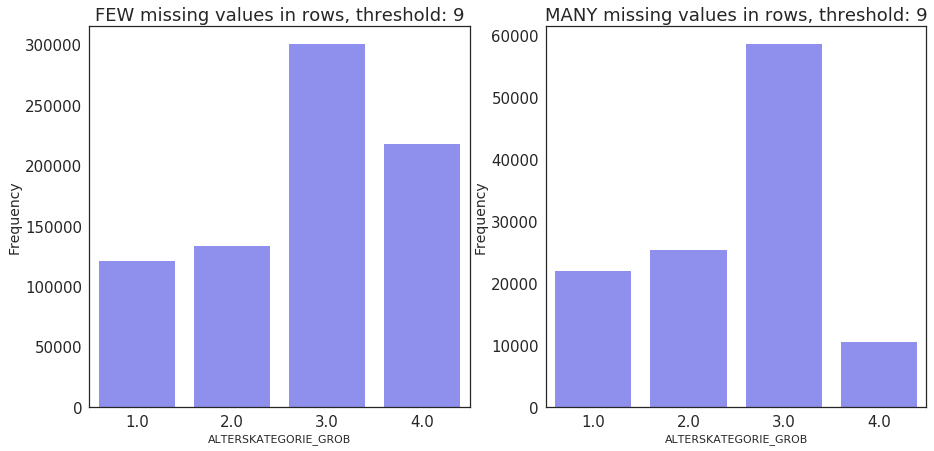

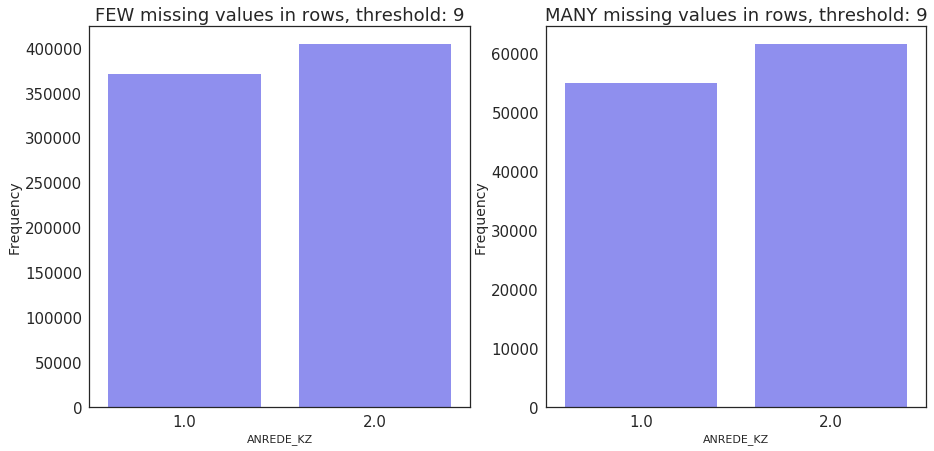

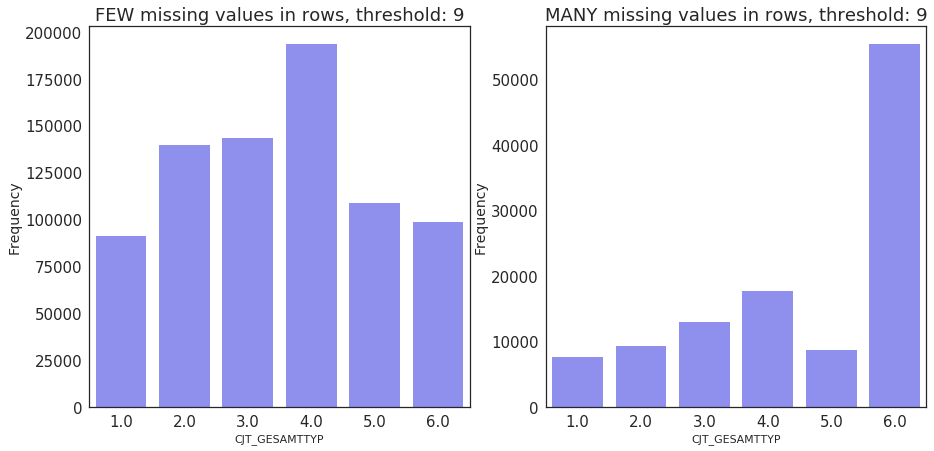

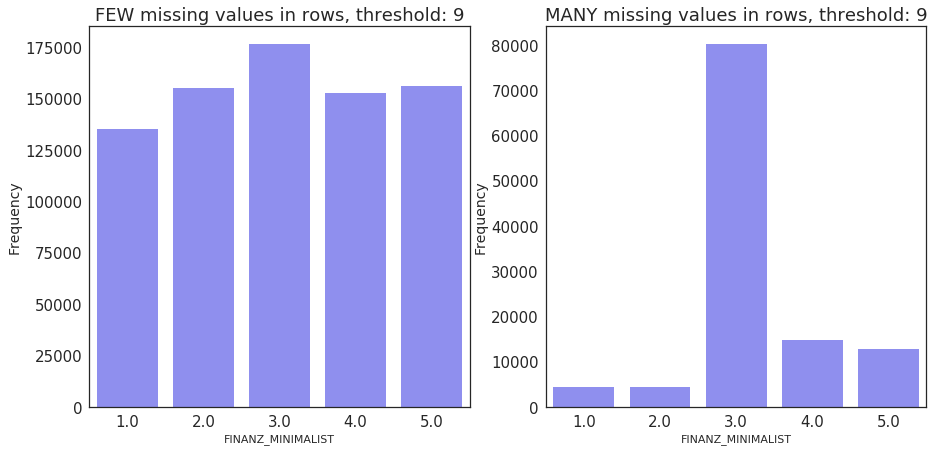

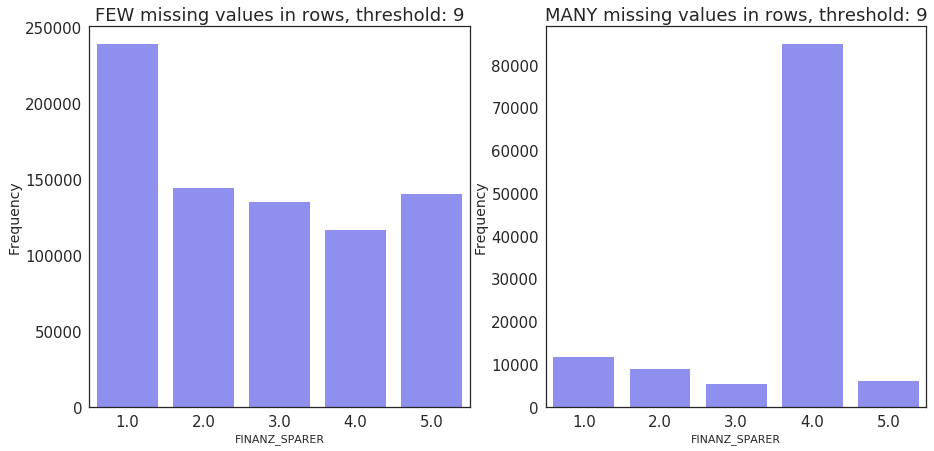

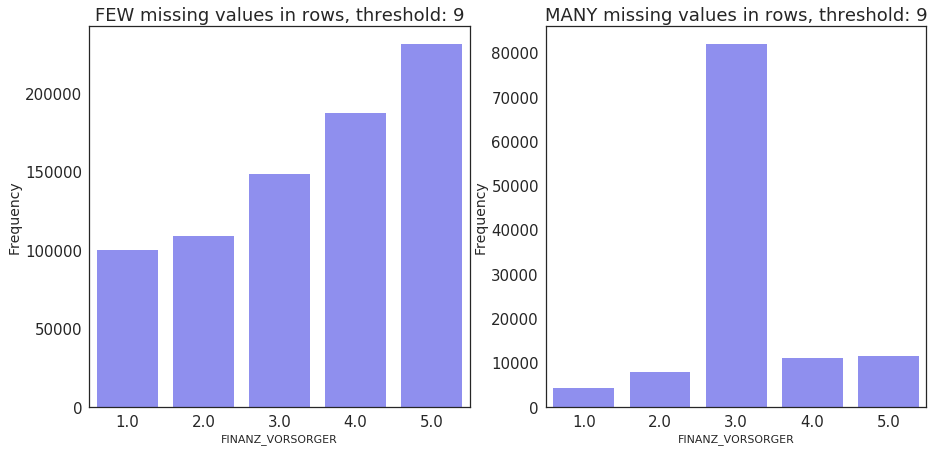

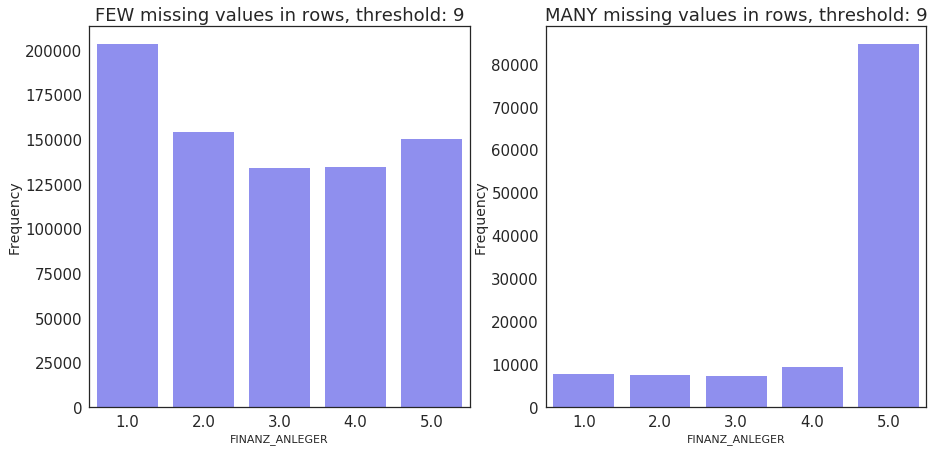

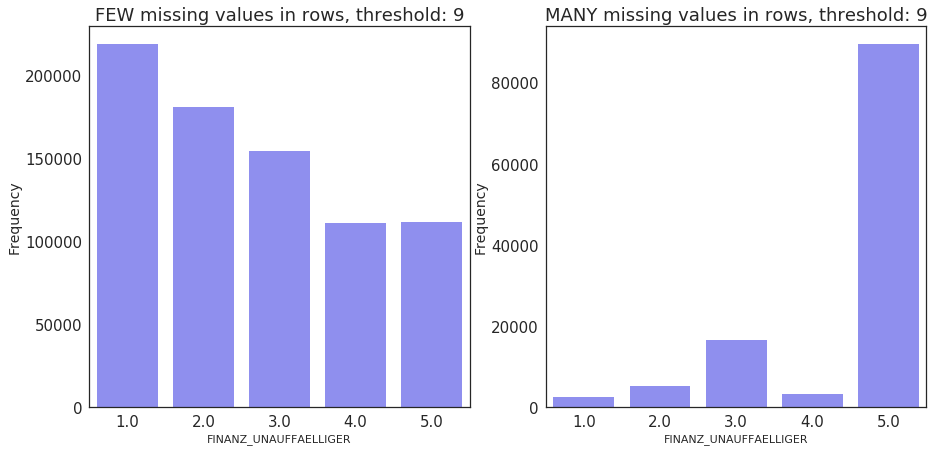

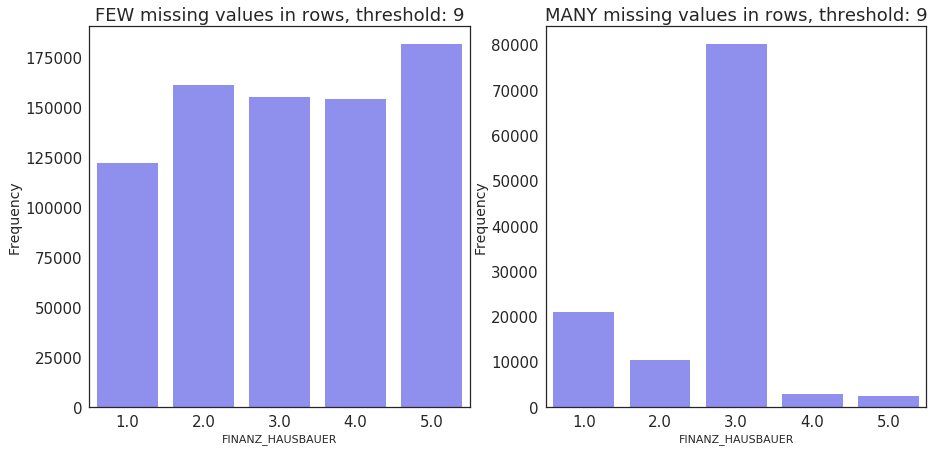

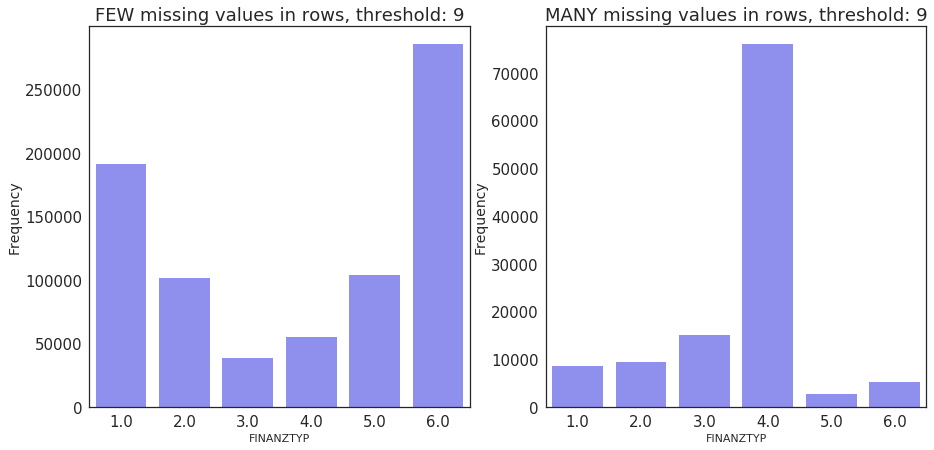

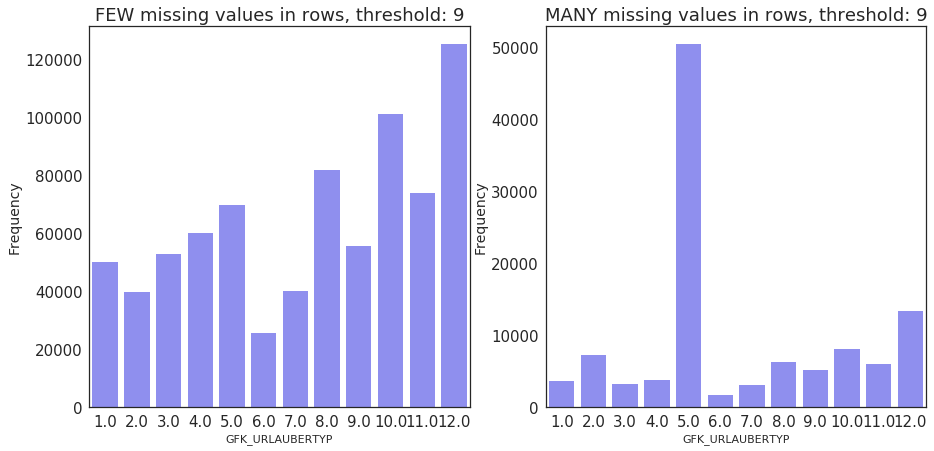

In [77]:
azdias_cleaned_missing_few, azdias_cleaned_missing_many, threshold =   divide_into_subsets(azdias_cleaned, 9)
pairwise_comparison(10)

Threshold of missing rows in the row:  30

Total nrow: 891221

Few Missing Values. Will be kept.
798067

Lots of Missing Values. Will be deleted
93154

% of rows with lots of missing values. % of data deleted 
0.104524018173


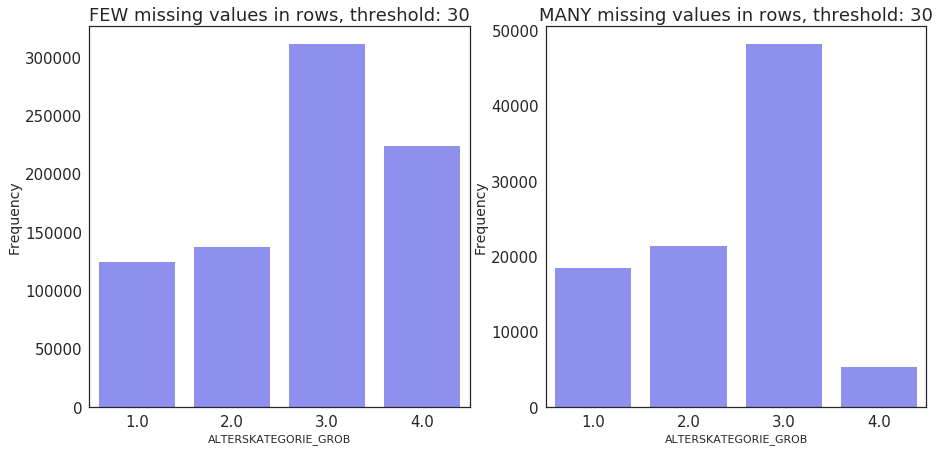

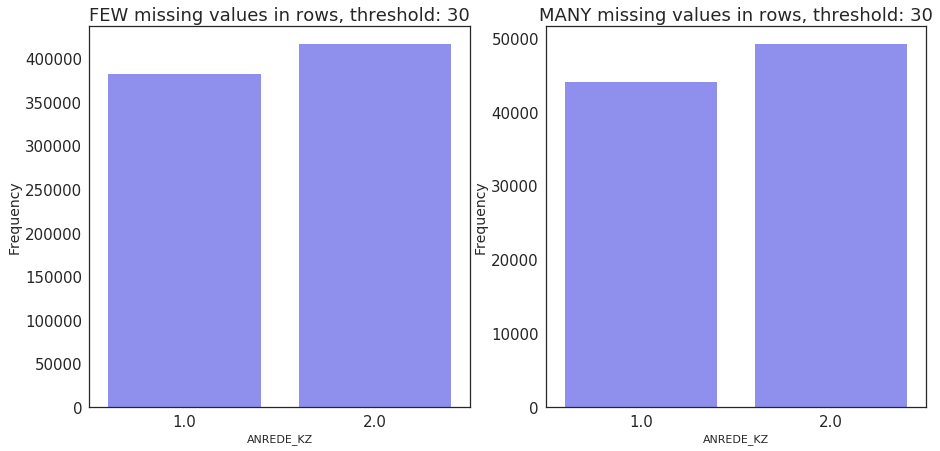

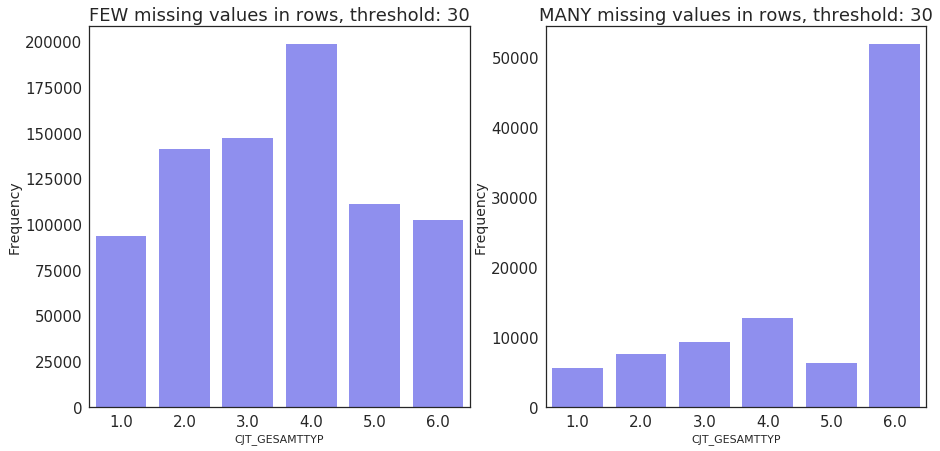

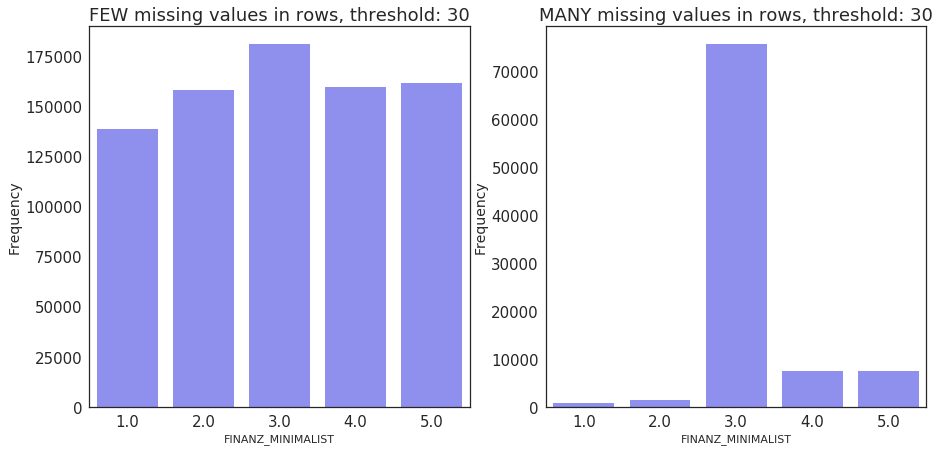

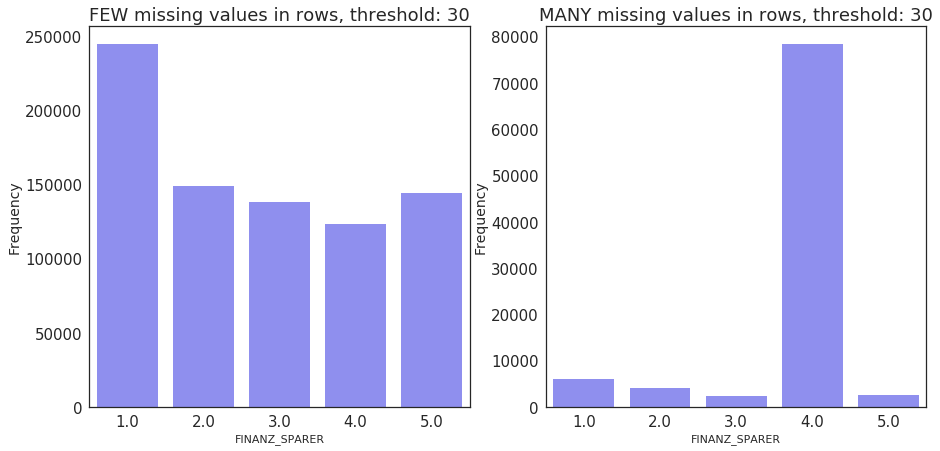

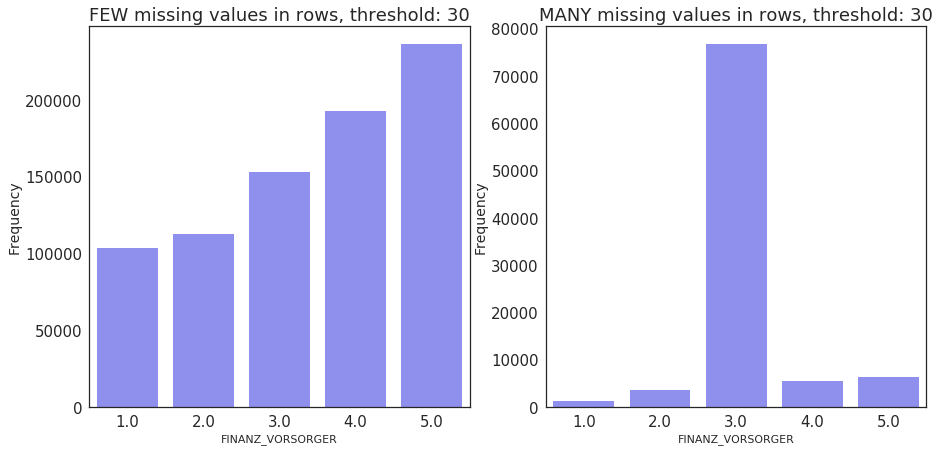

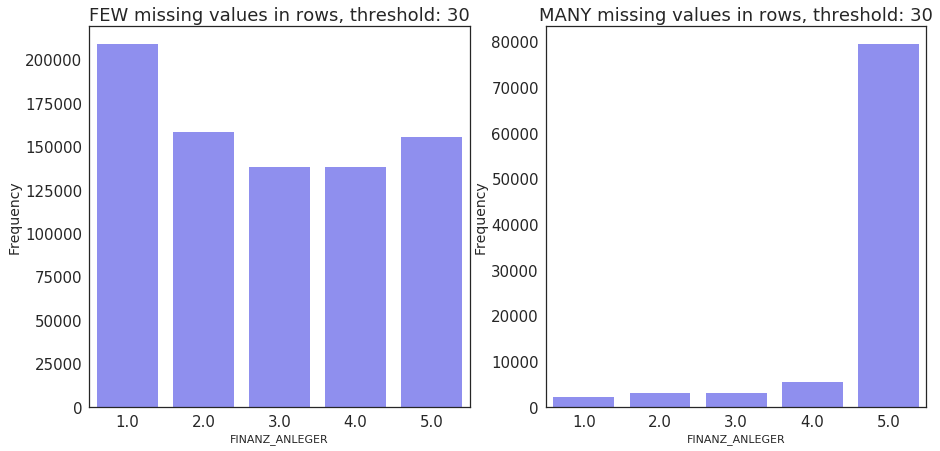

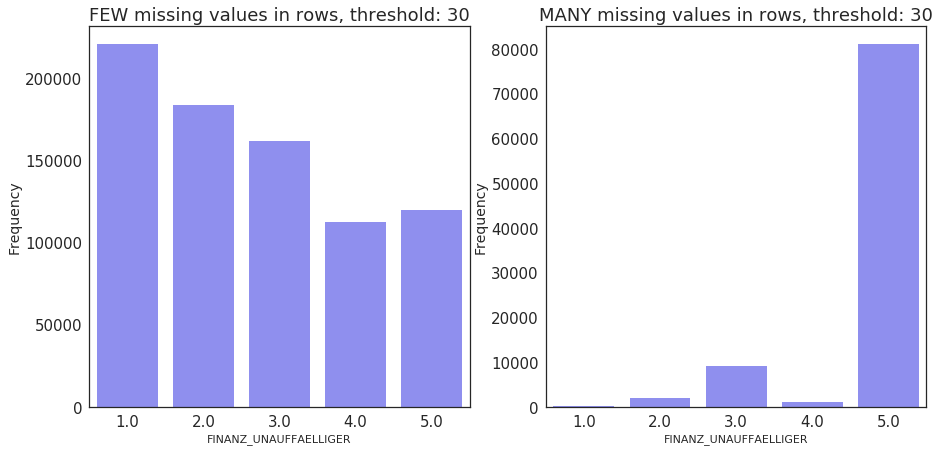

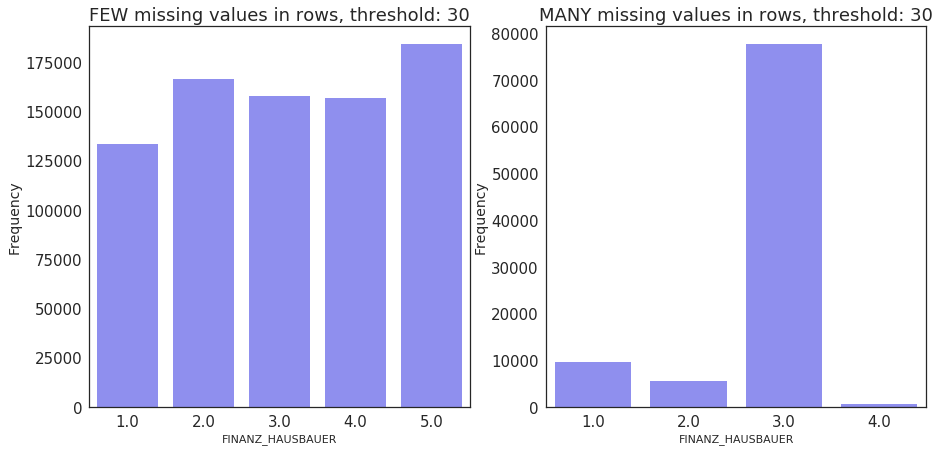

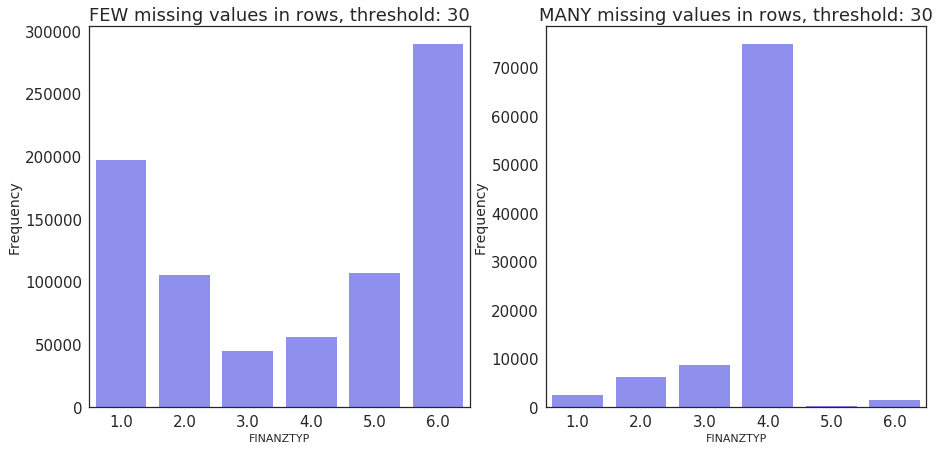

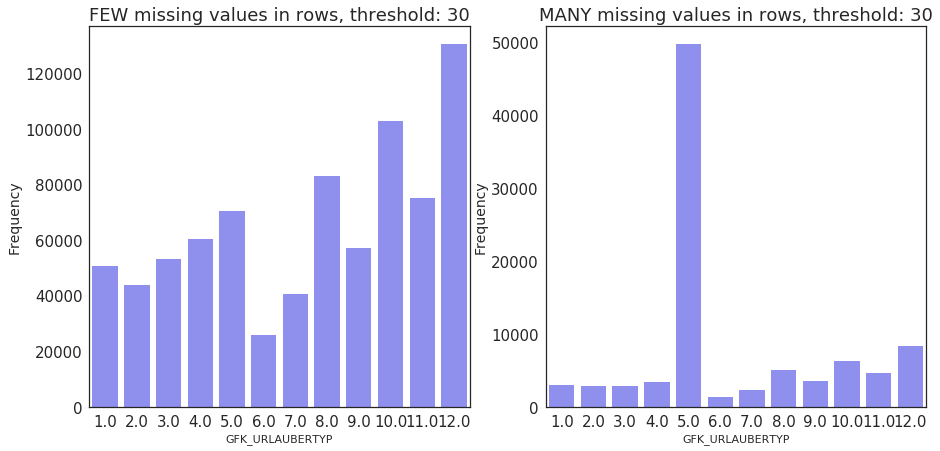

In [78]:
azdias_cleaned_missing_few, azdias_cleaned_missing_many, threshold =   divide_into_subsets(azdias_cleaned, 30)
pairwise_comparison(10)

Threshold of missing rows in the row:  42

Total nrow: 891221

Few Missing Values. Will be kept.
817622

Lots of Missing Values. Will be deleted
73599

% of rows with lots of missing values. % of data deleted 
0.0825822102486


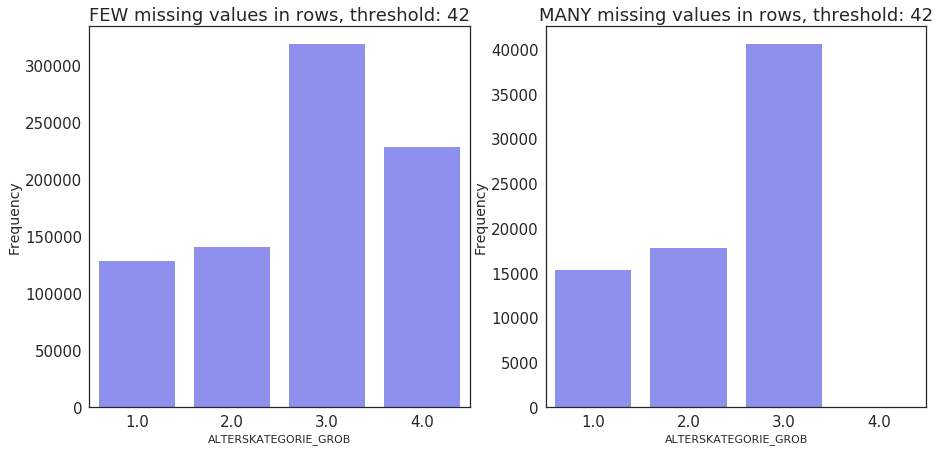

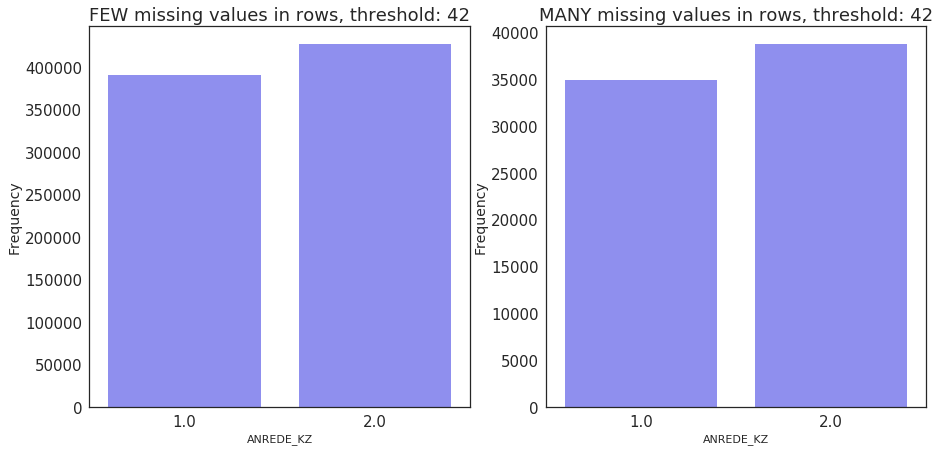

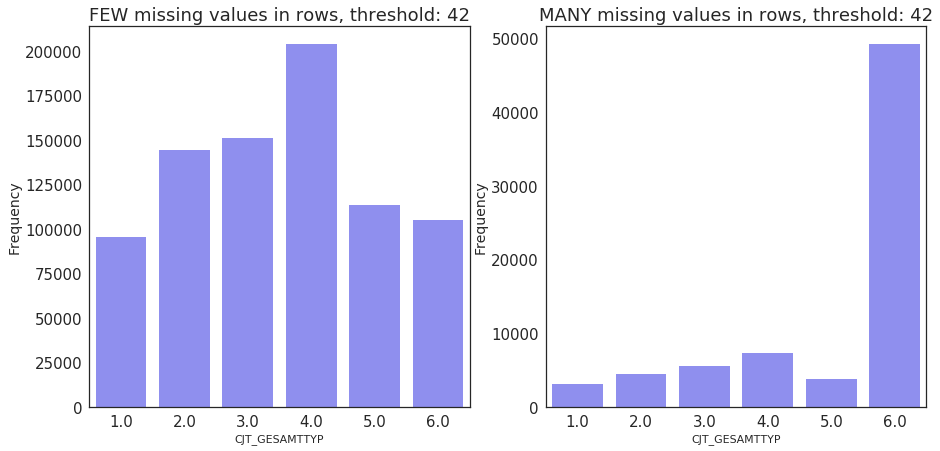

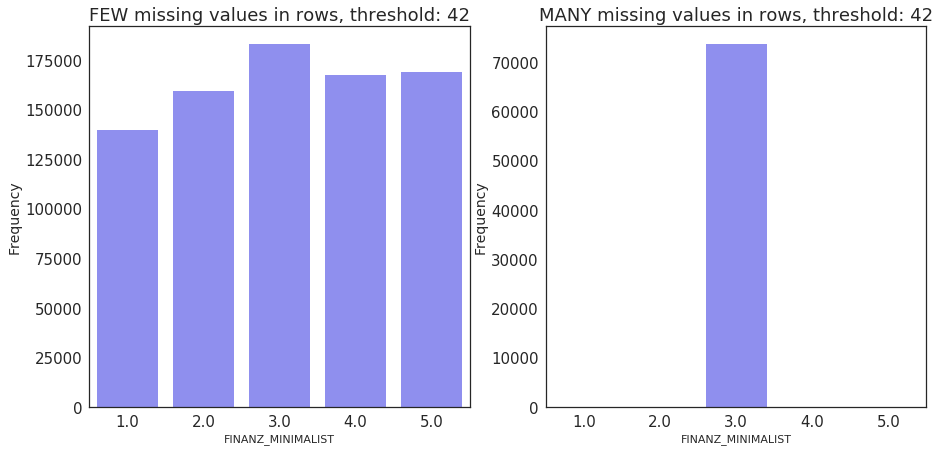

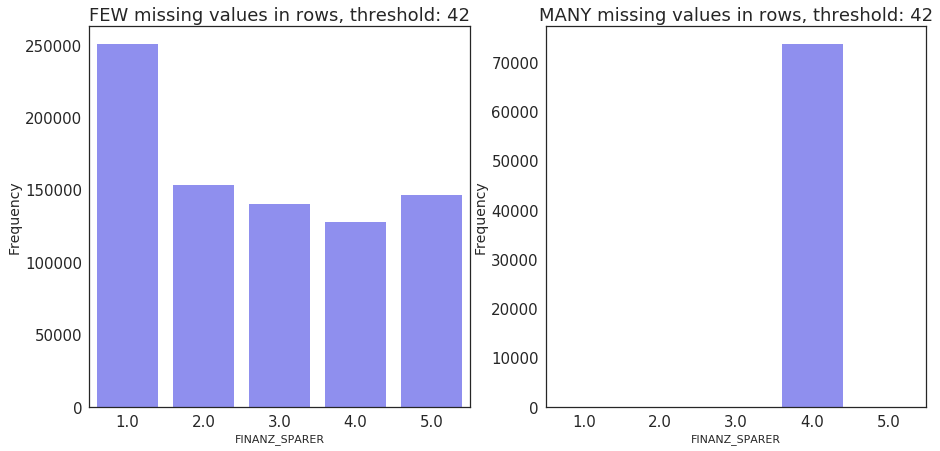

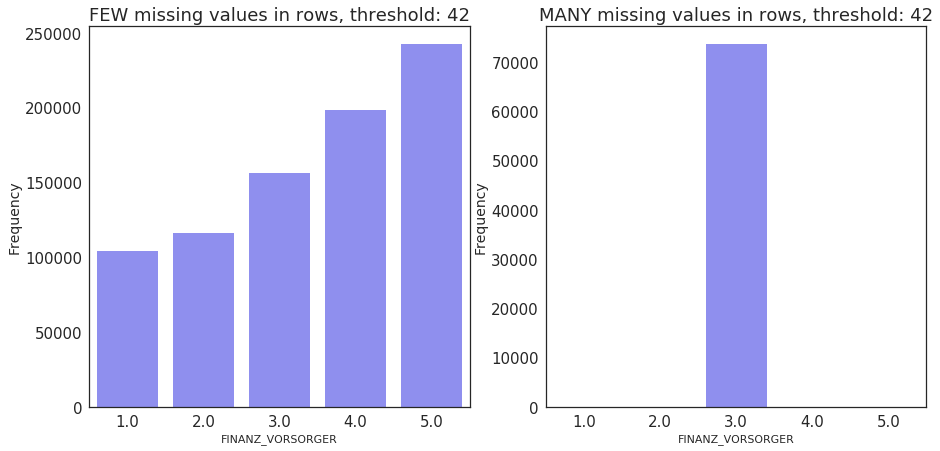

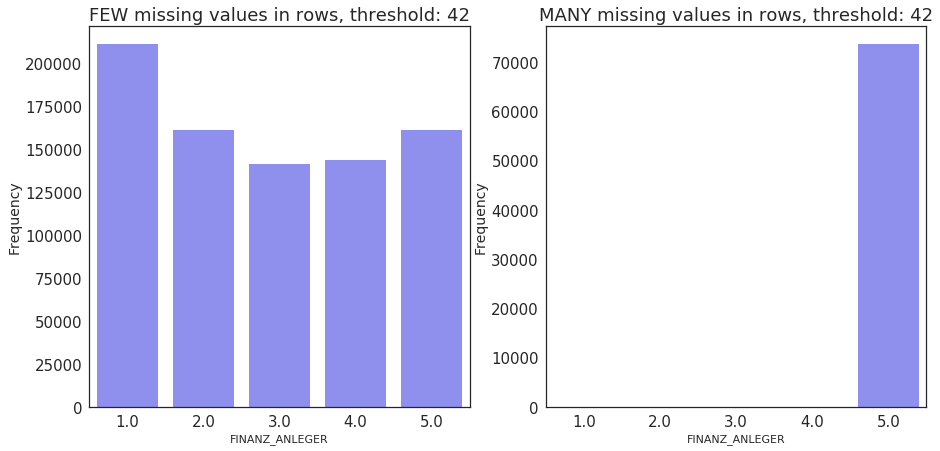

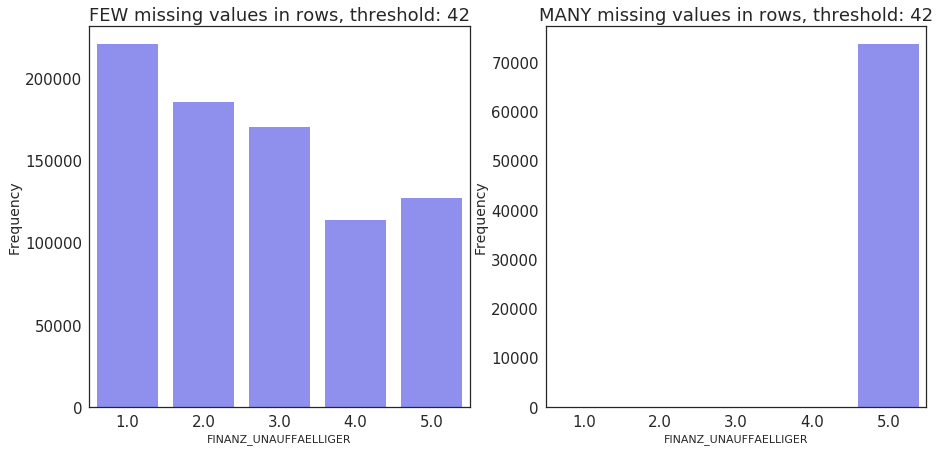

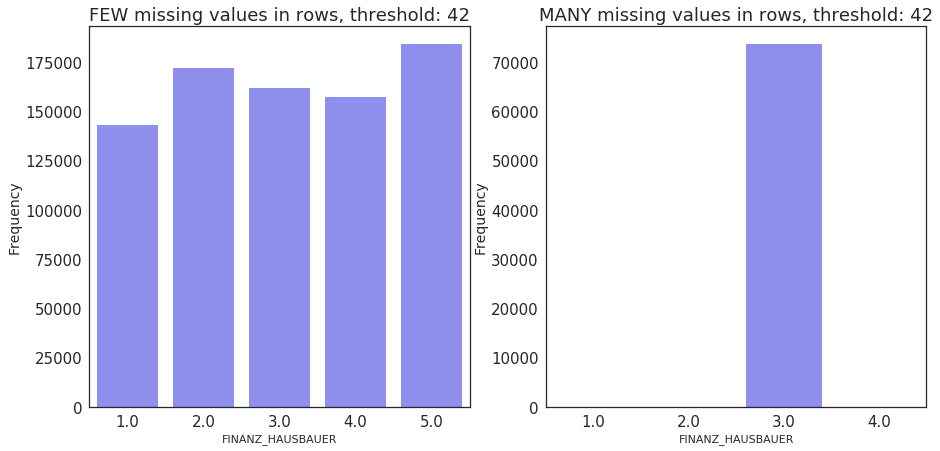

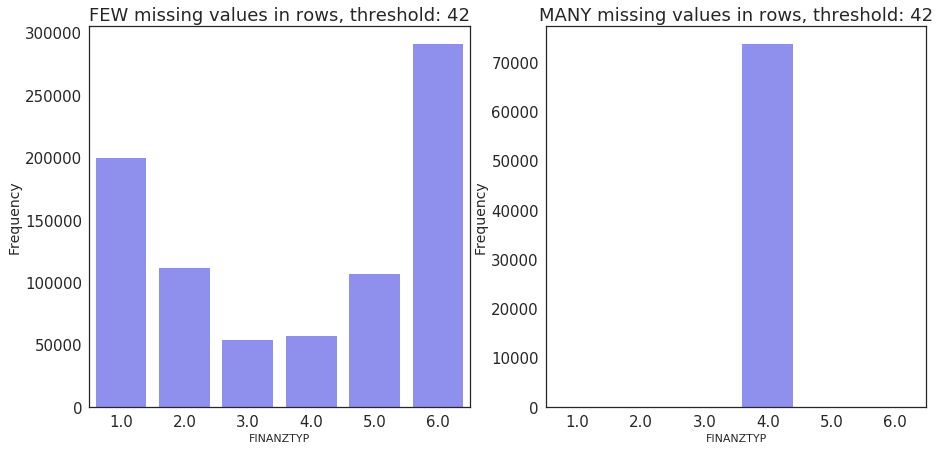

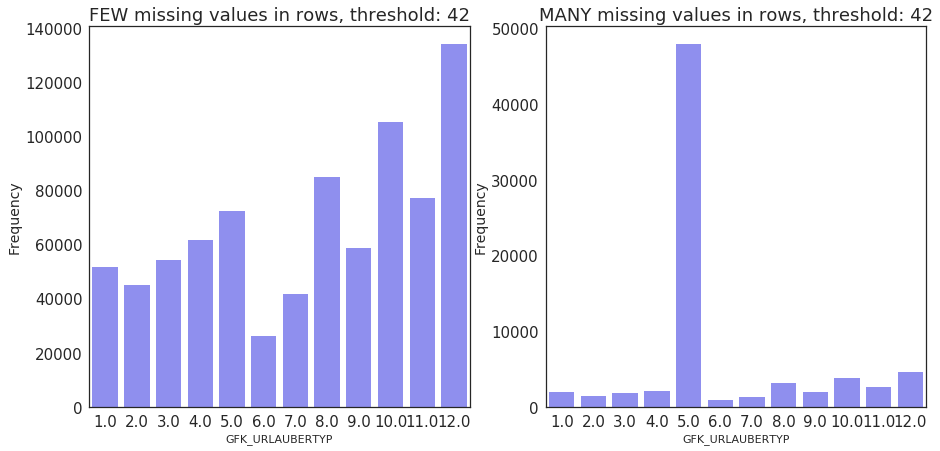

In [79]:
azdias_cleaned_missing_few, azdias_cleaned_missing_many, threshold =   divide_into_subsets(azdias_cleaned, 42)
pairwise_comparison(10)

In [80]:
# I'm re-running this code to make sure I'm actually usingng the threshold I decided on 
# (I was playing a lot above with different thresholds)
azdias_cleaned_missing_few, azdias_cleaned_missing_many, threshold =   divide_into_subsets(azdias_cleaned, 30)

Threshold of missing rows in the row:  30

Total nrow: 891221

Few Missing Values. Will be kept.
798067

Lots of Missing Values. Will be deleted
93154

% of rows with lots of missing values. % of data deleted 
0.104524018173


In [81]:
azdias_cleaned_missing_few.shape

(798067, 81)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Data with lots of missing values in rows appear to be qualitatively different from data with few or no missing values. You can see this if you compare the above distributions side by side. 

There are 3 clusters of data depending on how many values with missing data there are in each row.

I we can split the dataset into two subsets, depending on how much missing data there are in each row. We can use several possible thresholds: 30 and 42. 

30 would split cluster 1 from the rest of the data (~10%). 

42 would split cluster 3 from the rest of the data (~8% of the data). This option was used to subset the data. 8% of data has been removed. 817622 rows out of 891221 remained.

I ended up going with threshold of 30, to minimize missing data, while still following hte logic of my analysis (the 3 cluster of dataset based on missing data).

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [82]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [83]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [84]:
categorical_vars = feat_info[feat_info['type']=='categorical']

len(categorical_vars)

21

In [85]:
list(categorical_vars['attribute'])

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [86]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

"""
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html
#https://stackoverflow.com/questions/36198118/np-isnan-on-arrays-of-dtype-object
"""
categorical_vars = feat_info[feat_info['type']=='categorical']

len(categorical_vars)

categorical_vars = list(categorical_vars['attribute'])

binary = []
multilevel = []

for variable in categorical_vars:
    print(variable)
    print()
    # is this categorical column removed from the cleaned dataset? Because it has too much missing info
    if variable in (list(outliers_df['Column'])):
        print("This column has been removed from azdias_cleaned_missing_few as having too much missing data.")
    else:
        
        # these levels includes nan
        unique_levels = list(azdias_cleaned_missing_few[variable].unique())
        # number of unique levels, excluding nan
        number_of_unique_levels = len(unique_levels) - sum(pd.isnull(unique_levels))
        print("Number of Unique levels: ", number_of_unique_levels)
        print()
        
        # is it multilevel of binary?
        if number_of_unique_levels > 2:
            print("Multilevel Categorical")
            multilevel.append(variable)
        else: 
            print("Binary Categorical")
            binary.append(variable)
        print()
        print("Unique Levels: ", unique_levels)        
        print()
    print("###################################################################")   

AGER_TYP

This column has been removed from azdias_cleaned_missing_few as having too much missing data.
###################################################################
ANREDE_KZ

Number of Unique levels:  2

Binary Categorical

Unique Levels:  [2.0, 1.0]

###################################################################
CJT_GESAMTTYP

Number of Unique levels:  6

Multilevel Categorical

Unique Levels:  [5.0, 3.0, 2.0, 4.0, 1.0, 6.0, nan]

###################################################################
FINANZTYP

Number of Unique levels:  6

Multilevel Categorical

Unique Levels:  [1.0, 6.0, 5.0, 2.0, 4.0, 3.0]

###################################################################
GFK_URLAUBERTYP

Number of Unique levels:  12

Multilevel Categorical

Unique Levels:  [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 2.0, 7.0, 6.0, nan]

###################################################################
GREEN_AVANTGARDE

Number of Unique levels:  2

Binary Categorical

Unique Leve

In [87]:
print("Binary Categoricals: ")    
print(binary)  
print()
print("Multilevel Categoricals: ")
print(multilevel)

Binary Categoricals: 
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multilevel Categoricals: 
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


This one needs to be recoded:

OST_WEST_KZ

Number of Unique levels:  2

Binary

Unique Levels:  [nan, 'W', 'O']

In [88]:
azdias_cleaned_missing_few.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
1               5.0        1.0             10.0               0.0         3.0   
2               5.0        1.0             10.0               1.0         3.0   
3               2.0        6.0              1.0               0.0         2.0   
4               2.0        5.0              5.0               0.0         3.0   
5               5.0        2.0              1.0               0.0         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
1                 21.0                  6.0              5.0              3.0   
2                  3.0                  1.0              1.0              1.0   
3                  NaN                  NaN              NaN              NaN   
4                 32.0                 10.0             10.0              5.0   
5                  8.0                  2.0              1.0              1.0   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
1             2.0             1.0               1.0                   14.0   
2             3.0             2.0               1.0                   15.0   
3             9.0             4.0               1.0                    8.0   
4             3.0             2.0               1.0                    8.0   
5             4.0             2.0               1.0                    3.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
1         4.0            7.0          6.0          3.0      1.0       2.0   
2         7.0            3.0          3.0          2.0      0.0       1.0   
3         5.0            4.0          4.0          1.0      0.0       1.0   
4         2.0            4.0          2.0          2.0      0.0       2.0   
5         4.0            7.0          6.0          0.0      0.0       2.0   

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
1       5.0           2.0        0.0                 6.0             3.0   
2       5.0           1.0        0.0                 4.0             3.0   
3       3.0           0.0        0.0                 1.0         

In [89]:
# Re-encode categorical variable(s) to be kept in the analysis.

# print(azdias_cleaned_missing_few['OST_WEST_KZ'].head(100))

azdias_cleaned_missing_few['OST_WEST_KZ'].tail(100)

891112    O
891113    O
891114    W
891115    W
891116    W
891117    W
891118    W
891119    W
891120    W
891121    W
891122    W
891123    W
891124    W
891125    W
891126    W
891127    W
891128    W
891129    W
891131    W
891132    W
891133    W
891134    W
891135    W
891136    W
891138    O
891139    O
891141    W
891142    W
891143    W
891144    W
891145    W
891146    W
891147    W
891148    W
891149    W
891150    W
891151    W
891152    W
891153    W
891154    W
891155    W
891156    W
891157    W
891158    W
891160    W
891161    W
891162    W
891163    W
891165    W
891166    W
891167    W
891168    W
891169    W
891170    W
891172    W
891173    W
891174    W
891176    W
891177    W
891178    W
891179    W
891180    W
891181    W
891182    W
891183    W
891184    W
891186    W
891188    W
891189    W
891190    W
891191    W
891192    W
891193    W
891194    W
891195    W
891196    W
891197    W
891198    W
891199    W
891200    W
891201    W
891202    W
891203    W
8912

In [90]:
print(azdias_cleaned.shape)
print(azdias_cleaned_missing_few.shape)

(891221, 81)
(798067, 81)


W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


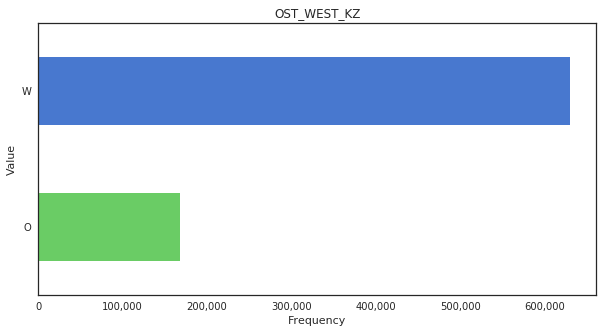

OST_WEST_KZ
   counts  percentage
W  629528   78.881005
O  168545   21.118995


In [91]:
print(azdias_cleaned.OST_WEST_KZ.value_counts())
bar_graph_for_each_column(azdias_cleaned,column_list=['OST_WEST_KZ']) 

# this gives me the same result:
# print(azdias_cleaned_missing_few.OST_WEST_KZ.value_counts())
# bar_graph_for_each_column(azdias_cleaned_missing_few,column_list=['OST_WEST_KZ'])  

In [92]:
"""Deep Learning. Lesson 1 Intro to Neural Networks. 36 Notebook: Analyzing Student Data"""
# Make dummy variables for OST_WEST_KZ
azdias_cleaned_encoded = pd.concat([azdias_cleaned_missing_few, pd.get_dummies(azdias_cleaned_missing_few['OST_WEST_KZ'], prefix='OST_WEST_KZ')], axis=1)

In [93]:
azdias_cleaned_encoded.shape

(798067, 83)

In [94]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
1               5.0        1.0             10.0               0.0         3.0   
2               5.0        1.0             10.0               1.0         3.0   
3               2.0        6.0              1.0               0.0         2.0   
4               2.0        5.0              5.0               0.0         3.0   
5               5.0        2.0              1.0               0.0         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
1                 21.0                  6.0              5.0              3.0   
2                  3.0                  1.0              1.0              1.0   
3                  NaN                  NaN              NaN              NaN   
4                 32.0                 10.0             10.0              5.0   
5                  8.0                  2.0              1.0              1.0   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
1             2.0             1.0               1.0                   14.0   
2             3.0             2.0               1.0                   15.0   
3             9.0             4.0               1.0                    8.0   
4             3.0             2.0               1.0                    8.0   
5             4.0             2.0               1.0                    3.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
1         4.0            7.0          6.0          3.0      1.0       2.0   
2         7.0            3.0          3.0          2.0      0.0       1.0   
3         5.0            4.0          4.0          1.0      0.0       1.0   
4         2.0            4.0          2.0          2.0      0.0       2.0   
5         4.0            7.0          6.0          0.0      0.0       2.0   

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
1       5.0           2.0        0.0                 6.0             3.0   
2       5.0           1.0        0.0                 4.0             3.0   
3       3.0           0.0        0.0                 1.0         

In [95]:
azdias_cleaned_encoded[['OST_WEST_KZ', 'OST_WEST_KZ_O', 'OST_WEST_KZ_W']].tail(100)

OST_WEST_KZ  OST_WEST_KZ_O  OST_WEST_KZ_W
891112           O              1              0
891113           O              1              0
891114           W              0              1
891115           W              0              1
891116           W              0              1
891117           W              0              1
891118           W              0              1
891119           W              0              1
891120           W              0              1
891121           W              0              1
891122           W              0              1
891123           W              0              1
891124           W              0              1
891125           W              0              1
891126           W              0              1
891127           W              0              1
891128           W              0              1
891129           W              0              1
891131           W              0              1
891132           W              0              1
891133           W              0              1
891134           W              0              1
891135           W              0              1
891136           W              0              1
891138           O              1              0
891139           O              1              0
891141           W              0              1
891142           W              0              1
891143           W              0              1
891144           W              0              1
891145           W              0              1
891146           W              0              1
891147           W              0              1
891148           W              0              1
891149           W              0              1
891150           W              0              1
891151           W              0              1
891152           W              0              1
891153           W              0              1
891154           W              0              1
891155           W              0              1
891156           W              0              1
891157           W              0              1
891158           W              0              1
891160           W              0              1
891161           W              0              1
891162           W              0              1
891163           W              0              1
891165           W              0              1
891166           W              0              1
891167           W              0              1
891168           W              0              1
891169           W              0              1
891170           W              0              1
891172           W              0              1
891173           W              0              1
891174           W              0              1
891176           W              0              1
891177           W              0              1
891178           W              0              1
891179           W              0              1
891180           W              0              1
891181           W              0              1
891182           W              0              1
891183           W              0              1
891184           W              0              1
891186           W              0              1
891188           W              0              1
891189           W              0              1
891190           W              0              1
891191           W              0              1
891192           W              0              1
891193           W              0              1
891194           W              0              1
891195           W              0              1
891196           W              0              1
891197           W              0              1
891198           W              0              1
891199           W              0              1
891200           W              0              1
891201           W              0     

In [96]:
pd.crosstab(azdias_cleaned_encoded.OST_WEST_KZ, azdias_cleaned_encoded.OST_WEST_KZ_O)

OST_WEST_KZ_O       0       1
OST_WEST_KZ                  
O                   0  168542
W              629525       0

In [97]:
pd.crosstab(azdias_cleaned_encoded.OST_WEST_KZ, azdias_cleaned_encoded.OST_WEST_KZ_W)

OST_WEST_KZ_W       0       1
OST_WEST_KZ                  
O              168542       0
W                   0  629525

In [98]:
pd.crosstab(azdias_cleaned_encoded.OST_WEST_KZ_O, azdias_cleaned_encoded.OST_WEST_KZ_W)

OST_WEST_KZ_W       0       1
OST_WEST_KZ_O                
0                   0  629525
1              168542       0

In [99]:
# Drop the previous OST_WEST_KZ column
print(azdias_cleaned_encoded.shape)
# we actually don't need both dummy vars. 2nd one doesn't add anything. We can drop OST_WEST_KZ_W and keep OST_WEST_KZ_O
azdias_cleaned_encoded = azdias_cleaned_encoded.drop(['OST_WEST_KZ_W','OST_WEST_KZ'], axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 83)
(798067, 81)


In [100]:
print(len(multilevel))
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop(multilevel, axis = 1)
print(azdias_cleaned_encoded.shape)

13
(798067, 81)
(798067, 68)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Categorical variables**

**Kept untouched**

Binary Categoricals: `['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']`

**Recoded as dummy variable**

Binary Categorical: `'OST_WEST_KZ'`

**Dropped from analysis** just to keep things straighforward and also avoid overfitting due to having too many independent variables: 

Multilevel Categoricals: `['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']`

When I was working on the very last part of the project, description of the customer clusters, I regretted dropping all of these vars. I should have kept a couple of them at least, indicating shopper type.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [101]:
#  How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

##### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.



In [102]:
azdias_cleaned_encoded["PRAEGENDE_JUGENDJAHRE"].value_counts()

14.0    182985
8.0     141630
10.0     85808
5.0      84692
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [103]:
# for item in my_dict:
#     print(item)
#     print(my_dict[item])

In [104]:
def recode_column_according_2_my_dict(df, oldvar, newvar, my_dict):
    """recode a column according to how it's specified in my dictionary my_dict"""

    for item in my_dict:
        condition = df[oldvar].isin(my_dict[item])
        df[newvar] = np.where(condition==True, item, df[newvar])

    """
    https://stackoverflow.com/questions/33271098/python-get-a-frequency-count-based-on-two-columns-variables-in-pandas-datafra
    """
    return pd.crosstab(df[oldvar], df[newvar])  

In [105]:
#https://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column

# initialize column
azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = 0

# here's how the column will be recoded
my_dict = {
    40:[1,2],
    50:[3,4],
    60:[5,6,7],
    70:[8,9],
    80:[10,11,12,13],
    90:[14,15]
}
recode_column_according_2_my_dict(azdias_cleaned_encoded, "PRAEGENDE_JUGENDJAHRE", "PRAEGENDE_JUGENDJAHRE_DECADE", my_dict)  

PRAEGENDE_JUGENDJAHRE_DECADE     40     50     60      70     80      90
PRAEGENDE_JUGENDJAHRE                                                   
1.0                           20678      0      0       0      0       0
2.0                            7479      0      0       0      0       0
3.0                               0  53845      0       0      0       0
4.0                               0  20451      0       0      0       0
5.0                               0      0  84692       0      0       0
6.0                               0      0  25652       0      0       0
7.0                               0      0   4010       0      0       0
8.0                               0      0      0  141630      0       0
9.0                               0      0      0   33570      0       0
10.0                              0      0      0       0  85808       0
11.0                              0      0      0       0  35752       0
12.0                              0      0      0       0  24446       0
13.0                              0      0      0       0   5764       0
14.0                              0      0      0       0      0  182985
15.0                              0      0      0       0      0   42547

In [106]:
azdias_cleaned_encoded[["PRAEGENDE_JUGENDJAHRE","PRAEGENDE_JUGENDJAHRE_DECADE"]].head(100)

PRAEGENDE_JUGENDJAHRE  PRAEGENDE_JUGENDJAHRE_DECADE
1                     14.0                            90
2                     15.0                            90
3                      8.0                            70
4                      8.0                            70
5                      3.0                            50
6                     10.0                            80
7                      8.0                            70
8                     11.0                            80
9                     15.0                            90
10                     3.0                            50
12                     8.0                            70
13                    15.0                            90
15                     5.0                            60
16                    14.0                            90
18                    10.0                            80
19                     9.0                            70
20                    11.0                            80
21                    10.0                            80
22                    14.0                            90
23                     9.0                            70
25                    14.0                            90
26                     8.0                            70
27                    11.0                            80
28                    10.0                            80
29                     6.0                            60
31                    10.0                            80
32                    15.0                            90
33                     8.0                            70
34                     4.0                            50
36                     8.0                            70
37                     8.0                            70
38                    10.0                            80
39                    11.0                            80
40                     NaN                             0
41                    15.0                            90
42                    14.0                            90
43                    14.0                            90
44                     8.0                            70
45                     5.0                            60
47                     4.0                            50
49                    10.0                            80
50                    14.0                            90
51                    15.0                            90
52                    14.0                            90
55                     8.0                            70
56                    11.0                            80
57                    14.0                            90
58                    15.0                            90
59                    10.0                            80
60                     8.0                            70
63                    15.0                            90
64                    14.0                            90
65                     8.0                            70
66                    14.0                            90
67                     5.0                            60
68                     5.0                            60
70                    11.0                            80
71                     8.0                            70
72                     NaN                             0
73                    10.0                            80
74                    11.0                            80
77                     8.0                            70
78                    10.0                            80
79                    15.0                            90
80                    10.0                            80
82                    14.0                            90
84                     8.0                            70
85                     5.0                            60
86                     3.0                            50
87             

In [107]:
azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'] = ""

my_dict ={
    "AVANTGARDE": [2, 4, 6, 7, 9, 11, 13, 15],
    "MAINSTREAM": [1, 3, 5, 8, 10, 12, 14]    
}

recode_column_according_2_my_dict(azdias_cleaned_encoded, "PRAEGENDE_JUGENDJAHRE", "PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP", my_dict)

PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP  AVANTGARDE  MAINSTREAM
PRAEGENDE_JUGENDJAHRE                                      
1.0                                           0       20678
2.0                                        7479           0
3.0                                           0       53845
4.0                                       20451           0
5.0                                           0       84692
6.0                                       25652           0
7.0                                        4010           0
8.0                                           0      141630
9.0                                       33570           0
10.0                                          0       85808
11.0                                      35752           0
12.0                                          0       24446
13.0                                       5764           0
14.0                                          0      182985
15.0                                      42547           0

In [108]:
azdias_cleaned_encoded[["PRAEGENDE_JUGENDJAHRE","PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP"]].head(100)

PRAEGENDE_JUGENDJAHRE PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP
1                     14.0                          MAINSTREAM
2                     15.0                          AVANTGARDE
3                      8.0                          MAINSTREAM
4                      8.0                          MAINSTREAM
5                      3.0                          MAINSTREAM
6                     10.0                          MAINSTREAM
7                      8.0                          MAINSTREAM
8                     11.0                          AVANTGARDE
9                     15.0                          AVANTGARDE
10                     3.0                          MAINSTREAM
12                     8.0                          MAINSTREAM
13                    15.0                          AVANTGARDE
15                     5.0                          MAINSTREAM
16                    14.0                          MAINSTREAM
18                    10.0                          MAINSTREAM
19                     9.0                          AVANTGARDE
20                    11.0                          AVANTGARDE
21                    10.0                          MAINSTREAM
22                    14.0                          MAINSTREAM
23                     9.0                          AVANTGARDE
25                    14.0                          MAINSTREAM
26                     8.0                          MAINSTREAM
27                    11.0                          AVANTGARDE
28                    10.0                          MAINSTREAM
29                     6.0                          AVANTGARDE
31                    10.0                          MAINSTREAM
32                    15.0                          AVANTGARDE
33                     8.0                          MAINSTREAM
34                     4.0                          AVANTGARDE
36                     8.0                          MAINSTREAM
37                     8.0                          MAINSTREAM
38                    10.0                          MAINSTREAM
39                    11.0                          AVANTGARDE
40                     NaN                                    
41                    15.0                          AVANTGARDE
42                    14.0                          MAINSTREAM
43                    14.0                          MAINSTREAM
44                     8.0                          MAINSTREAM
45                     5.0                          MAINSTREAM
47                     4.0                          AVANTGARDE
49                    10.0                          MAINSTREAM
50                    14.0                          MAINSTREAM
51                    15.0                          AVANTGARDE
52                    14.0                          MAINSTREAM
55                     8.0                          MAINSTREAM
56                    11.0                          AVANTGARDE
57                    14.0                          MAINSTREAM
58                    15.0                          AVANTGARDE
59                    10.0                          MAINSTREAM
60                     8.0                          MAINSTREAM
63                    15.0                          AVANTGARDE
64                    14.0                          MAINSTREAM
65                     8.0                          MAINSTREAM
66                    14.0                          MAINSTREAM
67                     5.0                          MAINSTREAM
68                     5.0                          MAINSTREAM
70                    11.0                          AVANTGARDE
71                     8.0                          MAINSTREAM
72                     NaN                                    
73                    10.0                          MAINSTREAM
74                    11.0                          AVANTGARDE
77                     8.0                          MAINSTREAM
78                    10.0          

In [109]:
"""Deep Learning. Lesson 1 Intro to Neural Networks. 36 Notebook: Analyzing Student Data"""
# Make dummy variables for PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP
azdias_cleaned_encoded = pd.concat([azdias_cleaned_encoded, pd.get_dummies(azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'], prefix='PRAEGENDE_JUGENDJAHRE_MOVEMENT')], axis=1)

In [110]:
pd.crosstab(azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'], azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_AVANTGARDE'])

PRAEGENDE_JUGENDJAHRE_MOVEMENT_AVANTGARDE       0       1
PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP                      
                                            28758       0
AVANTGARDE                                      0  175225
MAINSTREAM                                 594084       0

In [111]:
pd.crosstab(azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'], azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_MAINSTREAM'])

PRAEGENDE_JUGENDJAHRE_MOVEMENT_MAINSTREAM       0       1
PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP                      
                                            28758       0
AVANTGARDE                                 175225       0
MAINSTREAM                                      0  594084

In [112]:
pd.crosstab(azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_AVANTGARDE'], azdias_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_MAINSTREAM'])

PRAEGENDE_JUGENDJAHRE_MOVEMENT_MAINSTREAM       0       1
PRAEGENDE_JUGENDJAHRE_MOVEMENT_AVANTGARDE                
0                                           28758  594084
1                                          175225       0

In [113]:
azdias_cleaned_encoded["PRAEGENDE_JUGENDJAHRE"].isna().sum()

28758

In [114]:
# Drop the previous PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP column. 
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop(['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'], axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 73)
(798067, 72)


In [115]:
# Drop the previous PRAEGENDE_JUGENDJAHRE
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 72)
(798067, 71)


In [116]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
1               0.0         3.0                 21.0                  6.0   
2               1.0         3.0                  3.0                  1.0   
3               0.0         2.0                  NaN                  NaN   
4               0.0         3.0                 32.0                 10.0   
5               0.0         3.0                  8.0                  2.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  ANZ_PERSONEN  \
1         4.0            7.0          6.0      1.0       2.0           2.0   
2         7.0            3.0          3.0      0.0       1.0           1.0   
3         5.0            4.0          4.0      0.0       1.0           0.0   
4         2.0            4.0          2.0      0.0       2.0           4.0   
5         4.0            7.0          6.0      0.0       2.0           1.0   

   ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  \
1        0.0                 6.0             3.0             9.0   
2        0.0                 4.0             3.0             9.0   
3        0.0                 1.0             NaN             9.0   
4        0.0                 5.0             2.0             9.0   
5        0.0                 5.0             6.0             9.0   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE  \
1                 11.0           0.0          1.0            1992.0       4.0   
2                 10.0           0.0          5.0            1992.0       2.0   
3                  1.0           0.0          4.0            1997.0       7.0   
4                  3.0           0.0          4.0            1992.0       3.0   
5                  5.0           0.0          5.0            1992.0       7.0   

  CAMEO_INTL_2015  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  \
1              51          0.0          0.0          0.0          2.0   
2              24          1.0          3.0          1.0          0.0   
3              12          4.0          1.0          0.0          0.0   
4              43          1.0          4.0          1.0     

In [117]:
azdias_cleaned_encoded.PRAEGENDE_JUGENDJAHRE_MOVEMENT_.describe()

count    798067.000000
mean          0.036035
std           0.186376
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT_, dtype: float64

In [118]:
azdias_cleaned_encoded.PRAEGENDE_JUGENDJAHRE_MOVEMENT_.sum()

28758

In [119]:
# Drop the previous PRAEGENDE_JUGENDJAHRE_MOVEMENT_. This column just indicated sum(NAN) in PRAEGENDE_JUGENDJAHRE
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop('PRAEGENDE_JUGENDJAHRE_MOVEMENT_', axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 71)
(798067, 70)


In [120]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
1               0.0         3.0                 21.0                  6.0   
2               1.0         3.0                  3.0                  1.0   
3               0.0         2.0                  NaN                  NaN   
4               0.0         3.0                 32.0                 10.0   
5               0.0         3.0                  8.0                  2.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  ANZ_PERSONEN  \
1         4.0            7.0          6.0      1.0       2.0           2.0   
2         7.0            3.0          3.0      0.0       1.0           1.0   
3         5.0            4.0          4.0      0.0       1.0           0.0   
4         2.0            4.0          2.0      0.0       2.0           4.0   
5         4.0            7.0          6.0      0.0       2.0           1.0   

   ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  \
1        0.0                 6.0             3.0             9.0   
2        0.0                 4.0             3.0             9.0   
3        0.0                 1.0             NaN             9.0   
4        0.0                 5.0             2.0             9.0   
5        0.0                 5.0             6.0             9.0   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE  \
1                 11.0           0.0          1.0            1992.0       4.0   
2                 10.0           0.0          5.0            1992.0       2.0   
3                  1.0           0.0          4.0            1997.0       7.0   
4                  3.0           0.0          4.0            1992.0       3.0   
5                  5.0           0.0          5.0            1992.0       7.0   

  CAMEO_INTL_2015  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  \
1              51          0.0          0.0          0.0          2.0   
2              24          1.0          3.0          1.0          0.0   
3              12          4.0          1.0          0.0          0.0   
4              43          1.0          4.0          1.0     

###### Investigate "CAMEO_INTL_2015" and engineer two new variables.



In [121]:
azdias_cleaned_encoded["CAMEO_INTL_2015"].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39627
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [122]:
azdias_cleaned_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798067 entries, 1 to 891220
Data columns (total 70 columns):
ALTERSKATEGORIE_GROB                         795264 non-null float64
ANREDE_KZ                                    798067 non-null float64
FINANZ_MINIMALIST                            798067 non-null float64
FINANZ_SPARER                                798067 non-null float64
FINANZ_VORSORGER                             798067 non-null float64
FINANZ_ANLEGER                               798067 non-null float64
FINANZ_UNAUFFAELLIGER                        798067 non-null float64
FINANZ_HAUSBAUER                             798067 non-null float64
GREEN_AVANTGARDE                             798067 non-null float64
HEALTH_TYP                                   761341 non-null float64
LP_LEBENSPHASE_FEIN                          747828 non-null float64
LP_LEBENSPHASE_GROB                          750721 non-null float64
RETOURTYP_BK_S                               793318 non-null 

In [123]:
"""
https://stackoverflow.com/questions/41271299/how-can-i-get-the-first-two-digits-of-a-number
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.slice.html
"""
azdias_cleaned_encoded["CAMEO_INTL_2015_WEALTH"] =azdias_cleaned_encoded["CAMEO_INTL_2015"].str.slice(0,1)

azdias_cleaned_encoded["CAMEO_INTL_2015_LIFE_STAGE_TYP"] =azdias_cleaned_encoded["CAMEO_INTL_2015"].str.slice(1,2)

In [124]:
azdias_cleaned_encoded[["CAMEO_INTL_2015", "CAMEO_INTL_2015_WEALTH","CAMEO_INTL_2015_LIFE_STAGE_TYP"]].head(10)

CAMEO_INTL_2015 CAMEO_INTL_2015_WEALTH CAMEO_INTL_2015_LIFE_STAGE_TYP
1               51                      5                              1
2               24                      2                              4
3               12                      1                              2
4               43                      4                              3
5               54                      5                              4
6               22                      2                              2
7               14                      1                              4
8               13                      1                              3
9               15                      1                              5
10              51                      5                              1

In [125]:
pd.crosstab(azdias_cleaned_encoded["CAMEO_INTL_2015"], azdias_cleaned_encoded["CAMEO_INTL_2015_WEALTH"])

CAMEO_INTL_2015_WEALTH      1      2      3      4       5
CAMEO_INTL_2015                                           
12                      13249      0      0      0       0
13                      26335      0      0      0       0
14                      62884      0      0      0       0
15                      16974      0      0      0       0
22                          0  33154      0      0       0
23                          0  26750      0      0       0
24                          0  91158      0      0       0
25                          0  39627      0      0       0
31                          0      0  19024      0       0
32                          0      0  10354      0       0
33                          0      0   9935      0       0
34                          0      0  18524      0       0
35                          0      0  10356      0       0
41                          0      0      0  92336       0
43                          0      0      0  56672       0
44                          0      0      0  14820       0
45                          0      0      0  26132       0
51                          0      0      0      0  133694
52                          0      0      0      0   20542
54                          0      0      0      0   45391
55                          0      0      0      0   23955

In [126]:
pd.crosstab(azdias_cleaned_encoded["CAMEO_INTL_2015"], azdias_cleaned_encoded["CAMEO_INTL_2015_LIFE_STAGE_TYP"])

CAMEO_INTL_2015_LIFE_STAGE_TYP       1      2      3      4      5
CAMEO_INTL_2015                                                   
12                                   0  13249      0      0      0
13                                   0      0  26335      0      0
14                                   0      0      0  62884      0
15                                   0      0      0      0  16974
22                                   0  33154      0      0      0
23                                   0      0  26750      0      0
24                                   0      0      0  91158      0
25                                   0      0      0      0  39627
31                               19024      0      0      0      0
32                                   0  10354      0      0      0
33                                   0      0   9935      0      0
34                                   0      0      0  18524      0
35                                   0      0      0      0  10356
41                               92336      0      0      0      0
43                                   0      0  56672      0      0
44                                   0      0      0  14820      0
45                                   0      0      0      0  26132
51                              133694      0      0      0      0
52                                   0  20542      0      0      0
54                                   0      0      0  45391      0
55                                   0      0      0      0  23955

In [127]:
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop('CAMEO_INTL_2015', axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 72)
(798067, 71)


In [128]:
mixed_vars = feat_info[feat_info['type']=='mixed']
len(mixed_vars)
list(mixed_vars['attribute'])

# PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 has already been taken care of

# ['LP_LEBENSPHASE_FEIN',
#  'LP_LEBENSPHASE_GROB',
#  'PRAEGENDE_JUGENDJAHRE', Converted by PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT
#  'WOHNLAGE',
#  'CAMEO_INTL_2015', Converted to CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFE_STAGE_TYP
#  'KBA05_BAUMAX',
#  'PLZ8_BAUMAX']

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [129]:
# 8.6. PLZ8_BAUMAX
# Most common building type within the PLZ8 region
# 
# -1: unknown
# 0: unknown
# 1: mainly 1-2 family homes
# 2: mainly 3-5 family homes
# 3: mainly 6-10 family homes
# 4: mainly 10+ family homes
# 5: mainly business buildings


azdias_cleaned_encoded["PLZ8_BAUMAX"].value_counts()

1.0    499550
5.0     97333
2.0     70407
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX, dtype: int64

In [130]:
azdias_cleaned_encoded["PLZ8_BAUMAX"].isna().sum()

23361

In [131]:
my_dict ={
"FAMILY": [1,2,3,4],
"BUSINESS": [5]
}

azdias_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_TEMP'] = ""

recode_column_according_2_my_dict(azdias_cleaned_encoded, "PLZ8_BAUMAX", "PLZ8_BAUMAX_BLDNG_TYPE_TEMP", my_dict)

PLZ8_BAUMAX_BLDNG_TYPE_TEMP  BUSINESS  FAMILY
PLZ8_BAUMAX                                  
1.0                                 0  499550
2.0                                 0   70407
3.0                                 0   50732
4.0                                 0   56684
5.0                             97333       0

In [132]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
1               0.0         3.0                 21.0                  6.0   
2               1.0         3.0                  3.0                  1.0   
3               0.0         2.0                  NaN                  NaN   
4               0.0         3.0                 32.0                 10.0   
5               0.0         3.0                  8.0                  2.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  ANZ_PERSONEN  \
1         4.0            7.0          6.0      1.0       2.0           2.0   
2         7.0            3.0          3.0      0.0       1.0           1.0   
3         5.0            4.0          4.0      0.0       1.0           0.0   
4         2.0            4.0          2.0      0.0       2.0           4.0   
5         4.0            7.0          6.0      0.0       2.0           1.0   

   ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  \
1        0.0                 6.0             3.0             9.0   
2        0.0                 4.0             3.0             9.0   
3        0.0                 1.0             NaN             9.0   
4        0.0                 5.0             2.0             9.0   
5        0.0                 5.0             6.0             9.0   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE  \
1                 11.0           0.0          1.0            1992.0       4.0   
2                 10.0           0.0          5.0            1992.0       2.0   
3                  1.0           0.0          4.0            1997.0       7.0   
4                  3.0           0.0          4.0            1992.0       3.0   
5                  5.0           0.0          5.0            1992.0       7.0   

   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  \
1          0.0          0.0          0.0          2.0        1.0       6.0   
2          1.0          3.0          1.0          0.0        3.0       2.0   
3          4.0          1.0          0.0          0.0        4.0       4.0   
4          1.0          4.0          1.0 

In [133]:
azdias_cleaned_encoded = pd.concat([azdias_cleaned_encoded, pd.get_dummies(azdias_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_TEMP'], prefix='PLZ8_BAUMAX_BLDNG_TYPE')], axis=1)


In [134]:
pd.crosstab(azdias_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_TEMP'], azdias_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_BUSINESS'])

PLZ8_BAUMAX_BLDNG_TYPE_BUSINESS       0      1
PLZ8_BAUMAX_BLDNG_TYPE_TEMP                   
                                  23361      0
BUSINESS                              0  97333
FAMILY                           677373      0

In [135]:
pd.crosstab(azdias_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_TEMP'], azdias_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_FAMILY'])

PLZ8_BAUMAX_BLDNG_TYPE_FAMILY      0       1
PLZ8_BAUMAX_BLDNG_TYPE_TEMP                 
                               23361       0
BUSINESS                       97333       0
FAMILY                             0  677373

In [136]:
pd.crosstab(azdias_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_BUSINESS'], azdias_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_FAMILY'])

PLZ8_BAUMAX_BLDNG_TYPE_FAMILY        0       1
PLZ8_BAUMAX_BLDNG_TYPE_BUSINESS               
0                                23361  677373
1                                97333       0

In [137]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
1               0.0         3.0                 21.0                  6.0   
2               1.0         3.0                  3.0                  1.0   
3               0.0         2.0                  NaN                  NaN   
4               0.0         3.0                 32.0                 10.0   
5               0.0         3.0                  8.0                  2.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  ANZ_PERSONEN  \
1         4.0            7.0          6.0      1.0       2.0           2.0   
2         7.0            3.0          3.0      0.0       1.0           1.0   
3         5.0            4.0          4.0      0.0       1.0           0.0   
4         2.0            4.0          2.0      0.0       2.0           4.0   
5         4.0            7.0          6.0      0.0       2.0           1.0   

   ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  \
1        0.0                 6.0             3.0             9.0   
2        0.0                 4.0             3.0             9.0   
3        0.0                 1.0             NaN             9.0   
4        0.0                 5.0             2.0             9.0   
5        0.0                 5.0             6.0             9.0   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE  \
1                 11.0           0.0          1.0            1992.0       4.0   
2                 10.0           0.0          5.0            1992.0       2.0   
3                  1.0           0.0          4.0            1997.0       7.0   
4                  3.0           0.0          4.0            1992.0       3.0   
5                  5.0           0.0          5.0            1992.0       7.0   

   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  \
1          0.0          0.0          0.0          2.0        1.0       6.0   
2          1.0          3.0          1.0          0.0        3.0       2.0   
3          4.0          1.0          0.0          0.0        4.0       4.0   
4          1.0          4.0          1.0 

In [138]:
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop(['PLZ8_BAUMAX_BLDNG_TYPE_TEMP','PLZ8_BAUMAX_BLDNG_TYPE_'], axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 75)
(798067, 73)


In [139]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
1               0.0         3.0                 21.0                  6.0   
2               1.0         3.0                  3.0                  1.0   
3               0.0         2.0                  NaN                  NaN   
4               0.0         3.0                 32.0                 10.0   
5               0.0         3.0                  8.0                  2.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  ANZ_PERSONEN  \
1         4.0            7.0          6.0      1.0       2.0           2.0   
2         7.0            3.0          3.0      0.0       1.0           1.0   
3         5.0            4.0          4.0      0.0       1.0           0.0   
4         2.0            4.0          2.0      0.0       2.0           4.0   
5         4.0            7.0          6.0      0.0       2.0           1.0   

   ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  \
1        0.0                 6.0             3.0             9.0   
2        0.0                 4.0             3.0             9.0   
3        0.0                 1.0             NaN             9.0   
4        0.0                 5.0             2.0             9.0   
5        0.0                 5.0             6.0             9.0   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE  \
1                 11.0           0.0          1.0            1992.0       4.0   
2                 10.0           0.0          5.0            1992.0       2.0   
3                  1.0           0.0          4.0            1997.0       7.0   
4                  3.0           0.0          4.0            1992.0       3.0   
5                  5.0           0.0          5.0            1992.0       7.0   

   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  \
1          0.0          0.0          0.0          2.0        1.0       6.0   
2          1.0          3.0          1.0          0.0        3.0       2.0   
3          4.0          1.0          0.0          0.0        4.0       4.0   
4          1.0          4.0          1.0 

In [140]:
pd.crosstab(azdias_cleaned_encoded.PLZ8_BAUMAX, azdias_cleaned_encoded.PLZ8_BAUMAX_BLDNG_TYPE_BUSINESS)

PLZ8_BAUMAX_BLDNG_TYPE_BUSINESS       0      1
PLZ8_BAUMAX                                   
1.0                              499550      0
2.0                               70407      0
3.0                               50732      0
4.0                               56684      0
5.0                                   0  97333

In [141]:
pd.crosstab(azdias_cleaned_encoded.PLZ8_BAUMAX, azdias_cleaned_encoded.PLZ8_BAUMAX_BLDNG_TYPE_FAMILY)

PLZ8_BAUMAX_BLDNG_TYPE_FAMILY      0       1
PLZ8_BAUMAX                                 
1.0                                0  499550
2.0                                0   70407
3.0                                0   50732
4.0                                0   56684
5.0                            97333       0

In [142]:
# how many family homes are there?
condition = azdias_cleaned_encoded['PLZ8_BAUMAX'] == 5
 
azdias_cleaned_encoded['PLZ8_BAUMAX_FAMILY_HOMES'] = azdias_cleaned_encoded['PLZ8_BAUMAX']
 
azdias_cleaned_encoded['PLZ8_BAUMAX_FAMILY_HOMES']  = np.where(condition==True, 0, azdias_cleaned_encoded['PLZ8_BAUMAX'])

pd.crosstab(azdias_cleaned_encoded['PLZ8_BAUMAX'], azdias_cleaned_encoded['PLZ8_BAUMAX_FAMILY_HOMES'] )

PLZ8_BAUMAX_FAMILY_HOMES    0.0     1.0    2.0    3.0    4.0
PLZ8_BAUMAX                                                 
1.0                           0  499550      0      0      0
2.0                           0       0  70407      0      0
3.0                           0       0      0  50732      0
4.0                           0       0      0      0  56684
5.0                       97333       0      0      0      0

In [143]:
azdias_cleaned_encoded['PLZ8_BAUMAX'].value_counts()

1.0    499550
5.0     97333
2.0     70407
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX, dtype: int64

In [144]:
azdias_cleaned_encoded['PLZ8_BAUMAX_FAMILY_HOMES'].value_counts()

1.0    499550
0.0     97333
2.0     70407
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX_FAMILY_HOMES, dtype: int64

In [145]:
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop('PLZ8_BAUMAX', axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 74)
(798067, 73)


In [146]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
1               0.0         3.0                 21.0                  6.0   
2               1.0         3.0                  3.0                  1.0   
3               0.0         2.0                  NaN                  NaN   
4               0.0         3.0                 32.0                 10.0   
5               0.0         3.0                  8.0                  2.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  ANZ_PERSONEN  \
1         4.0            7.0          6.0      1.0       2.0           2.0   
2         7.0            3.0          3.0      0.0       1.0           1.0   
3         5.0            4.0          4.0      0.0       1.0           0.0   
4         2.0            4.0          2.0      0.0       2.0           4.0   
5         4.0            7.0          6.0      0.0       2.0           1.0   

   ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  \
1        0.0                 6.0             3.0             9.0   
2        0.0                 4.0             3.0             9.0   
3        0.0                 1.0             NaN             9.0   
4        0.0                 5.0             2.0             9.0   
5        0.0                 5.0             6.0             9.0   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE  \
1                 11.0           0.0          1.0            1992.0       4.0   
2                 10.0           0.0          5.0            1992.0       2.0   
3                  1.0           0.0          4.0            1997.0       7.0   
4                  3.0           0.0          4.0            1992.0       3.0   
5                  5.0           0.0          5.0            1992.0       7.0   

   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  \
1          0.0          0.0          0.0          2.0        1.0       6.0   
2          1.0          3.0          1.0          0.0        3.0       2.0   
3          4.0          1.0          0.0          0.0        4.0       4.0   
4          1.0          4.0          1.0 

In [147]:
pd.crosstab(azdias_cleaned_encoded.PLZ8_BAUMAX_BLDNG_TYPE_FAMILY, azdias_cleaned_encoded.PLZ8_BAUMAX_FAMILY_HOMES)

PLZ8_BAUMAX_FAMILY_HOMES         0.0     1.0    2.0    3.0    4.0
PLZ8_BAUMAX_BLDNG_TYPE_FAMILY                                    
0                              97333       0      0      0      0
1                                  0  499550  70407  50732  56684

In [148]:
# 3.7. WOHNLAGE
# Neighborhood quality (or rural flag)
# 
# -1: unknown
# 0: no score calculated
# 1: very good neighborhood
# 2: good neighborhood
# 3: average neighborhood
# 4: poor neighborhood
# 5: very poor neighborhood
# 7: rural neighborhood
# 8: new building in rural neighborhood


# note: 0 means no score calculated. In feature_info file, this should have been included into a code for missing/uknown(?)

In [149]:
#explore
print(azdias_cleaned_encoded["WOHNLAGE"].value_counts())
print()

3.0    249719
7.0    169317
4.0    135973
2.0    100376
5.0     74346
1.0     43917
8.0     17472
0.0      6947
Name: WOHNLAGE, dtype: int64



In [150]:
#explore nan
print(azdias_cleaned_encoded["WOHNLAGE"].isna().sum())

0


In [151]:
condition = azdias_cleaned_encoded["WOHNLAGE"].isin([7,8])
 
azdias_cleaned_encoded["WOHNLAGE_RURAL_FLAG"] = np.where(condition==True, 1,0)

pd.crosstab(azdias_cleaned_encoded["WOHNLAGE"], azdias_cleaned_encoded["WOHNLAGE_RURAL_FLAG"] )

WOHNLAGE_RURAL_FLAG       0       1
WOHNLAGE                           
0.0                    6947       0
1.0                   43917       0
2.0                  100376       0
3.0                  249719       0
4.0                  135973       0
5.0                   74346       0
7.0                       0  169317
8.0                       0   17472

In [152]:
condition = azdias_cleaned_encoded["WOHNLAGE"].isin([7,8])
 
azdias_cleaned_encoded["WOHNLAGE_CITY_NEIGHBOURHOOD"] = np.where(condition==True, 0,azdias_cleaned_encoded["WOHNLAGE"])

pd.crosstab(azdias_cleaned_encoded["WOHNLAGE"], azdias_cleaned_encoded["WOHNLAGE_CITY_NEIGHBOURHOOD"])

WOHNLAGE_CITY_NEIGHBOURHOOD     0.0    1.0     2.0     3.0     4.0    5.0
WOHNLAGE                                                                 
0.0                            6947      0       0       0       0      0
1.0                               0  43917       0       0       0      0
2.0                               0      0  100376       0       0      0
3.0                               0      0       0  249719       0      0
4.0                               0      0       0       0  135973      0
5.0                               0      0       0       0       0  74346
7.0                          169317      0       0       0       0      0
8.0                           17472      0       0       0       0      0

In [153]:
azdias_cleaned_encoded["WOHNLAGE"].value_counts()

3.0    249719
7.0    169317
4.0    135973
2.0    100376
5.0     74346
1.0     43917
8.0     17472
0.0      6947
Name: WOHNLAGE, dtype: int64

In [154]:
azdias_cleaned_encoded["WOHNLAGE_CITY_NEIGHBOURHOOD"].value_counts()

3.0    249719
0.0    193736
4.0    135973
2.0    100376
5.0     74346
1.0     43917
Name: WOHNLAGE_CITY_NEIGHBOURHOOD, dtype: int64

In [155]:
# drop the original column
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop(['WOHNLAGE'], axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 75)
(798067, 74)


In [156]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
1               0.0         3.0                 21.0                  6.0   
2               1.0         3.0                  3.0                  1.0   
3               0.0         2.0                  NaN                  NaN   
4               0.0         3.0                 32.0                 10.0   
5               0.0         3.0                  8.0                  2.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0        5.0        4.0        4.0        3.0         1.0   
2             3.0        4.0        1.0        3.0        3.0         4.0   
3             2.0        5.0        1.0        2.0        1.0         4.0   
4             5.0        6.0        4.0        4.0        2.0         7.0   
5             3.0        2.0        4.0        7.0        4.0         2.0   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1         2.0        2.0         3.0        6.0         4.0        7.0   
2         4.0        6.0         3.0        4.0         7.0        7.0   
3         4.0        7.0         4.0        3.0         4.0        4.0   
4         4.0        4.0         6.0        2.0         3.0        2.0   
5         2.0        2.0         5.0        7.0         4.0        4.0   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  ANZ_PERSONEN  \
1         4.0            7.0          6.0      1.0       2.0           2.0   
2         7.0            3.0          3.0      0.0       1.0           1.0   
3         5.0            4.0          4.0      0.0       1.0           0.0   
4         2.0            4.0          2.0      0.0       2.0           4.0   
5         4.0            7.0          6.0      0.0       2.0           1.0   

   ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  \
1        0.0                 6.0             3.0             9.0   
2        0.0                 4.0             3.0             9.0   
3        0.0                 1.0             NaN             9.0   
4        0.0                 5.0             2.0             9.0   
5        0.0                 5.0             6.0             9.0   

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  \
1                 11.0           0.0          1.0            1992.0   
2                 10.0           0.0          5.0            1992.0   
3                  1.0           0.0          4.0            1997.0   
4                  3.0           0.0          4.0            1992.0   
5                  5.0           0.0          5.0            1992.0   

   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  \
1          0.0          0.0          0.0          2.0        1.0       6.0   
2          1.0          3.0          1.0          0.0        3.0       2.0   
3          4.0          1.0          0.0          0.0        4.0       4.0   
4          1.0          4.0          1.0          0.0        3.0       2.0   
5          2.0         

In [157]:
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 74)
(798067, 72)


In [158]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1               0.0         3.0             1.0        5.0        4.0   
2               1.0         3.0             3.0        4.0        1.0   
3               0.0         2.0             2.0        5.0        1.0   
4               0.0         3.0             5.0        6.0        4.0   
5               0.0         3.0             3.0        2.0        4.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1        4.0        3.0         1.0         2.0        2.0         3.0   
2        3.0        3.0         4.0         4.0        6.0         3.0   
3        2.0        1.0         4.0         4.0        7.0         4.0   
4        4.0        2.0         7.0         4.0        4.0         6.0   
5        7.0        4.0         2.0         2.0        2.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1        6.0         4.0        7.0         4.0            7.0          6.0   
2        4.0         7.0        7.0         7.0            3.0          3.0   
3        3.0         4.0        4.0         5.0            4.0          4.0   
4        2.0         3.0        2.0         2.0            4.0          2.0   
5        7.0         4.0        4.0         4.0            7.0          6.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1      1.0       2.0           2.0        0.0                 6.0   
2      0.0       1.0           1.0        0.0                 4.0   
3      0.0       1.0           0.0        0.0                 1.0   
4      0.0       2.0           4.0        0.0                 5.0   
5      0.0       2.0           1.0        0.0                 5.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1             3.0             9.0                 11.0           0.0   
2             3.0             9.0                 10.0           0.0   
3             NaN             9.0                  1.0           0.0   
4             2.0             9.0                  3.0           0.0   
5             6.0             9.0                  5.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
1          1.0            1992.0          0.0          0.0          0.0   
2          5.0            1992.0          1.0          3.0          1.0   
3          4.0            1997.0          4.0          1.0          0.0   
4          4.0            1992.0          1.0          4.0          1.0   
5          5.0            1992.0          2.0          2.0          0.0   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
1          2.0        1.0       6.0       3.0         8.0                 3.0   
2          0.0        3.0       2.0       4.0         4.0                 4.0   
3          0.0        4.0       4.0       2.0         6.0                 4.0   
4          0.0        3.0       2.0       5.0         1.0                 5.0   
5          0.0        4.0 

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

`LP_LEBENSPHASE_FEIN`. There are too many dimensions (age, income, home owenrship, family status, parenthood) and levels here. Some of these dimensions are present in other variables just to keep things simple, I dropped it. 

`LP_LEBENSPHASE_GROB`. Family component is already present in other variables, such as `LP_FAMILIE_FEIN`. Income has only two levels: 1) low and avg & 2) high. There are other variables which indicate income, such as `LP_STATUS_FEIN`, `SP_STATUS_GROS`,  `HH_EINKOMMEN_SCORE`. Dropped this column.

`PRAEGENDE_JUGENDJAHRE`. Converted to `PRAEGENDE_JUGENDJAHRE_DECADE` and `PRAEGENDE_JUGENDJAHRE_MOVEMENT_AVANTGARDE` (dummy variable) and `PRAEGENDE_JUGENDJAHRE_MOVEMENT_MAINSTREAM` (dummy variable).

`WOHNLAGE`. Converted to `WOHNLAGE_RURAL_FLAG` (dummy variable) and `WOHNLAGE_CITY_NEIGHBOURHOOD`

`CAMEO_INTL_2015`. Converted to `CAMEO_INTL_2015_WEALTH` and `CAMEO_INTL_2015_LIFE_STAGE_TYP`.

`KBA05_BAUMAX` This one was removed earlier as an outlier column with too much missing data.

`PLZ8_BAUMAX` Converted to `PLZ8_BAUMAX_BLDNG_TYPE_BUSINESS` (dummy variable),	`PLZ8_BAUMAX_BLDNG_TYPE_FAMILY` (dummy variable), `PLZ8_BAUMAX_FAMILY_HOMES`.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### If there are other re-engineering tasks you need to perform, make sure you take care of them here. (Dealing with missing data will come in step 2.1.)



### Do whatever you need to in order to ensure that the dataframe only contains the columns that should be passed to the algorithm functions.



In [161]:
print(azdias_cleaned_encoded.shape)
azdias_cleaned_encoded = azdias_cleaned_encoded.drop(['NAN_count','many_missing_values_in_row'], axis = 1)
print(azdias_cleaned_encoded.shape)

(798067, 72)
(798067, 70)


In [162]:
azdias_cleaned_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798067 entries, 1 to 891220
Data columns (total 70 columns):
ALTERSKATEGORIE_GROB                         795264 non-null float64
ANREDE_KZ                                    798067 non-null float64
FINANZ_MINIMALIST                            798067 non-null float64
FINANZ_SPARER                                798067 non-null float64
FINANZ_VORSORGER                             798067 non-null float64
FINANZ_ANLEGER                               798067 non-null float64
FINANZ_UNAUFFAELLIGER                        798067 non-null float64
FINANZ_HAUSBAUER                             798067 non-null float64
GREEN_AVANTGARDE                             798067 non-null float64
HEALTH_TYP                                   761341 non-null float64
RETOURTYP_BK_S                               793318 non-null float64
SEMIO_SOZ                                    798067 non-null float64
SEMIO_FAM                                    798067 non-null 

In [163]:
for item in list(mixed_vars['attribute']):
    print(item)
    try: 
        print(azdias_cleaned_encoded[item])
    except:
        print('this var has been deleted and/or recoded')
    print()    

LP_LEBENSPHASE_FEIN
this var has been deleted and/or recoded

LP_LEBENSPHASE_GROB
this var has been deleted and/or recoded

PRAEGENDE_JUGENDJAHRE
this var has been deleted and/or recoded

WOHNLAGE
this var has been deleted and/or recoded

CAMEO_INTL_2015
this var has been deleted and/or recoded

KBA05_BAUMAX
this var has been deleted and/or recoded

PLZ8_BAUMAX
this var has been deleted and/or recoded



In [164]:
for item in multilevel:
    print(item)
    try: 
        print(azdias_cleaned_encoded[item])
    except:
        print('this var has been deleted and/or recoded')
    print()    

CJT_GESAMTTYP
this var has been deleted and/or recoded

FINANZTYP
this var has been deleted and/or recoded

GFK_URLAUBERTYP
this var has been deleted and/or recoded

LP_FAMILIE_FEIN
this var has been deleted and/or recoded

LP_FAMILIE_GROB
this var has been deleted and/or recoded

LP_STATUS_FEIN
this var has been deleted and/or recoded

LP_STATUS_GROB
this var has been deleted and/or recoded

NATIONALITAET_KZ
this var has been deleted and/or recoded

SHOPPER_TYP
this var has been deleted and/or recoded

ZABEOTYP
this var has been deleted and/or recoded

GEBAEUDETYP
this var has been deleted and/or recoded

CAMEO_DEUG_2015
this var has been deleted and/or recoded

CAMEO_DEU_2015
this var has been deleted and/or recoded



In [165]:
for item in ['OST_WEST_KZ']:
    print(item)
    try: 
        print(azdias_cleaned_encoded[item])
    except:
        print('this var has been deleted and/or recoded')
    print()     

OST_WEST_KZ
this var has been deleted and/or recoded



In [166]:
for item in ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']:
    print(item)
    try: 
        print(azdias_cleaned_encoded[item])
    except:
        print('this var has been deleted and/or recoded')
    print()    

PRAEGENDE_JUGENDJAHRE
this var has been deleted and/or recoded

CAMEO_INTL_2015
this var has been deleted and/or recoded



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [167]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame

    NOTE: This function does NOT build a cleaning procedure from scratch.
    It reuses the data transformation functions from previous sections. 
    This will help avoid code repetition and make this function more readable and easy to maintain.
    """

    ###########################################################################
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
#    df = azdias.copy() # test - remove later. Keep commented out in PROD
    
    
    df_cleaned = replace_coded_as_missing_unknown_with_NANs(df) 
    
    # summarize NAN for columns
    df_cleaned_NA_report = how_many_NA(df_cleaned)

    # remove selected columns and rows, ...

    # Investigate patterns in the amount of missing data in each column.
    #  the following columns have more than 1/3 of data missing
    outliers_df = df_cleaned_NA_report[df_cleaned_NA_report['missing_NA_percent']>0.333]

    # delete outlier columns with too much missing data
    for outlier_column in outliers_df['Column'].tolist():
        del(df_cleaned[outlier_column])

    ###########################################################################
    # add a column to the df_cleaned with NAN count for each row - takes 3-5 mins to run
    count_NAN_in_each_ROW(df_cleaned)

    # divide into subsets
    df_cleaned_missing_few, df_cleaned_missing_many, threshold = divide_into_subsets(df_cleaned, 30)

    # select, re-encode, and engineer column values.
    #########################################################
    # Make dummy variables for OST_WEST_KZ

    df_cleaned_encoded = pd.concat([df_cleaned_missing_few, pd.get_dummies(df_cleaned_missing_few['OST_WEST_KZ'], prefix='OST_WEST_KZ')], axis=1)



    #########################################################
    # recode PRAEGENDE_JUGENDJAHRE
    # initialize column
    df_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = 0

    my_dict = {
    40:[1,2],
    50:[3,4],
    60:[5,6,7],
    70:[8,9],
    80:[10,11,12,13],
    90:[14,15]
    }
    
    print(my_dict)
    
    recode_column_according_2_my_dict(df_cleaned_encoded, "PRAEGENDE_JUGENDJAHRE", "PRAEGENDE_JUGENDJAHRE_DECADE",my_dict)
    
    print(pd.crosstab(df_cleaned_encoded["PRAEGENDE_JUGENDJAHRE"], df_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_DECADE']))


    df_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'] = ""

    my_dict ={
        "AVANTGARDE": [2, 4, 6, 7, 9, 11, 13, 15],
        "MAINSTREAM": [1, 3, 5, 8, 10, 12, 14]
    }

    recode_column_according_2_my_dict(df_cleaned_encoded, "PRAEGENDE_JUGENDJAHRE", "PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP",my_dict)

    # Make dummy variables for PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP
    df_cleaned_encoded = pd.concat([df_cleaned_encoded, pd.get_dummies(df_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'], prefix='PRAEGENDE_JUGENDJAHRE_MOVEMENT')], axis=1)


    print(pd.crosstab(df_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'], df_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_AVANTGARDE']))

    print(pd.crosstab(df_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP'], df_cleaned_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT_MAINSTREAM']))


    # PRAEGENDE_JUGENDJAHRE_MOVEMENT_ is caused by missing values, we don't need this col, it just tell u number of NAN in the original column PRAEGENDE_JUGENDJAHRE
    # PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP is a temporary column, we don't need it either


    #########################################################
    df_cleaned_encoded["CAMEO_INTL_2015_WEALTH"] =df_cleaned_encoded["CAMEO_INTL_2015"].str.slice(0,1)

    df_cleaned_encoded["CAMEO_INTL_2015_LIFE_STAGE_TYP"] =df_cleaned_encoded["CAMEO_INTL_2015"].str.slice(1,2)



    #########################################################

    df_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_TEMP'] = ""

    my_dict ={
    "FAMILY": [1,2,3,4],
    "BUSINESS": [5]
    }

    recode_column_according_2_my_dict(df_cleaned_encoded, "PLZ8_BAUMAX", "PLZ8_BAUMAX_BLDNG_TYPE_TEMP", my_dict)

    df_cleaned_encoded = pd.concat([df_cleaned_encoded, pd.get_dummies(df_cleaned_encoded['PLZ8_BAUMAX_BLDNG_TYPE_TEMP'], prefix='PLZ8_BAUMAX_BLDNG_TYPE')], axis=1)



    # how many family homes are there?
    condition = df_cleaned_encoded['PLZ8_BAUMAX'] == 5

    # df_cleaned_encoded['PLZ8_BAUMAX_FAMILY_HOMES'] = df_cleaned_encoded['PLZ8_BAUMAX']

    df_cleaned_encoded['PLZ8_BAUMAX_FAMILY_HOMES']  = np.where(condition==True, 0, df_cleaned_encoded['PLZ8_BAUMAX'])


    #########################################################

    condition = df_cleaned_encoded["WOHNLAGE"].isin([7,8])

    df_cleaned_encoded["WOHNLAGE_RURAL_FLAG"] = np.where(condition==True, 1,0)

    # condition = df_cleaned_encoded["WOHNLAGE"].isin([7,8])

    df_cleaned_encoded["WOHNLAGE_CITY_NEIGHBOURHOOD"] = np.where(condition==True, 0,df_cleaned_encoded["WOHNLAGE"])

    #########################################################
    # the variable multilevel comes from code above which analyzes cat variables
    df_cleaned_encoded = df_cleaned_encoded.drop(multilevel, axis = 1)

    drop_list = ['OST_WEST_KZ','OST_WEST_KZ_W','PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_MOVEMENT_TEMP','PRAEGENDE_JUGENDJAHRE_MOVEMENT_','CAMEO_INTL_2015','PLZ8_BAUMAX_BLDNG_TYPE_TEMP','PLZ8_BAUMAX_BLDNG_TYPE_','PLZ8_BAUMAX','WOHNLAGE','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','NAN_count','many_missing_values_in_row']

    df_cleaned_encoded = df_cleaned_encoded.drop(drop_list, axis = 1)


    # Return the cleaned dataframe.
    return df_cleaned_encoded



In [168]:
azdias_cleaned_encoded_TEST_BIGASS_CLEANING_FUNCTION = clean_data(azdias)

Threshold of missing rows in the row:  30

Total nrow: 891221

Few Missing Values. Will be kept.
798067

Lots of Missing Values. Will be deleted
93154

% of rows with lots of missing values. % of data deleted 
0.104524018173
{40: [1, 2], 50: [3, 4], 60: [5, 6, 7], 70: [8, 9], 80: [10, 11, 12, 13], 90: [14, 15]}
PRAEGENDE_JUGENDJAHRE_DECADE     40     50     60      70     80      90
PRAEGENDE_JUGENDJAHRE                                                   
1.0                           20678      0      0       0      0       0
2.0                            7479      0      0       0      0       0
3.0                               0  53845      0       0      0       0
4.0                               0  20451      0       0      0       0
5.0                               0      0  84692       0      0       0
6.0                               0      0  25652       0      0       0
7.0                               0      0   4010       0      0       0
8.0                           

In [169]:
# I want to make my cleaning function returns the same resutls as my cleaning steps abovel 
# If it says True below, then we're good
azdias_cleaned_encoded.equals(azdias_cleaned_encoded_TEST_BIGASS_CLEANING_FUNCTION)

True

#### Explore the dataframe produced by the cleaning function

In [170]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1               0.0         3.0             1.0        5.0        4.0   
2               1.0         3.0             3.0        4.0        1.0   
3               0.0         2.0             2.0        5.0        1.0   
4               0.0         3.0             5.0        6.0        4.0   
5               0.0         3.0             3.0        2.0        4.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1        4.0        3.0         1.0         2.0        2.0         3.0   
2        3.0        3.0         4.0         4.0        6.0         3.0   
3        2.0        1.0         4.0         4.0        7.0         4.0   
4        4.0        2.0         7.0         4.0        4.0         6.0   
5        7.0        4.0         2.0         2.0        2.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1        6.0         4.0        7.0         4.0            7.0          6.0   
2        4.0         7.0        7.0         7.0            3.0          3.0   
3        3.0         4.0        4.0         5.0            4.0          4.0   
4        2.0         3.0        2.0         2.0            4.0          2.0   
5        7.0         4.0        4.0         4.0            7.0          6.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1      1.0       2.0           2.0        0.0                 6.0   
2      0.0       1.0           1.0        0.0                 4.0   
3      0.0       1.0           0.0        0.0                 1.0   
4      0.0       2.0           4.0        0.0                 5.0   
5      0.0       2.0           1.0        0.0                 5.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1             3.0             9.0                 11.0           0.0   
2             3.0             9.0                 10.0           0.0   
3             NaN             9.0                  1.0           0.0   
4             2.0             9.0                  3.0           0.0   
5             6.0             9.0                  5.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
1          1.0            1992.0          0.0          0.0          0.0   
2          5.0            1992.0          1.0          3.0          1.0   
3          4.0            1997.0          4.0          1.0          0.0   
4          4.0            1992.0          1.0          4.0          1.0   
5          5.0            1992.0          2.0          2.0          0.0   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
1          2.0        1.0       6.0       3.0         8.0                 3.0   
2          0.0        3.0       2.0       4.0         4.0                 4.0   
3          0.0        4.0       4.0       2.0         6.0                 4.0   
4          0.0        3.0       2.0       5.0         1.0                 5.0   
5          0.0        4.0 

In [171]:
azdias_cleaned_encoded_TEST_BIGASS_CLEANING_FUNCTION.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1               0.0         3.0             1.0        5.0        4.0   
2               1.0         3.0             3.0        4.0        1.0   
3               0.0         2.0             2.0        5.0        1.0   
4               0.0         3.0             5.0        6.0        4.0   
5               0.0         3.0             3.0        2.0        4.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1        4.0        3.0         1.0         2.0        2.0         3.0   
2        3.0        3.0         4.0         4.0        6.0         3.0   
3        2.0        1.0         4.0         4.0        7.0         4.0   
4        4.0        2.0         7.0         4.0        4.0         6.0   
5        7.0        4.0         2.0         2.0        2.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1        6.0         4.0        7.0         4.0            7.0          6.0   
2        4.0         7.0        7.0         7.0            3.0          3.0   
3        3.0         4.0        4.0         5.0            4.0          4.0   
4        2.0         3.0        2.0         2.0            4.0          2.0   
5        7.0         4.0        4.0         4.0            7.0          6.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1      1.0       2.0           2.0        0.0                 6.0   
2      0.0       1.0           1.0        0.0                 4.0   
3      0.0       1.0           0.0        0.0                 1.0   
4      0.0       2.0           4.0        0.0                 5.0   
5      0.0       2.0           1.0        0.0                 5.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1             3.0             9.0                 11.0           0.0   
2             3.0             9.0                 10.0           0.0   
3             NaN             9.0                  1.0           0.0   
4             2.0             9.0                  3.0           0.0   
5             6.0             9.0                  5.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
1          1.0            1992.0          0.0          0.0          0.0   
2          5.0            1992.0          1.0          3.0          1.0   
3          4.0            1997.0          4.0          1.0          0.0   
4          4.0            1992.0          1.0          4.0          1.0   
5          5.0            1992.0          2.0          2.0          0.0   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
1          2.0        1.0       6.0       3.0         8.0                 3.0   
2          0.0        3.0       2.0       4.0         4.0                 4.0   
3          0.0        4.0       4.0       2.0         6.0                 4.0   
4          0.0        3.0       2.0       5.0         1.0                 5.0   
5          0.0        4.0 

In [172]:
azdias_cleaned_encoded.shape

(798067, 70)

In [173]:
azdias_cleaned_encoded_TEST_BIGASS_CLEANING_FUNCTION.shape

(798067, 70)

In [174]:
azdias_cleaned_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798067 entries, 1 to 891220
Data columns (total 70 columns):
ALTERSKATEGORIE_GROB                         795264 non-null float64
ANREDE_KZ                                    798067 non-null float64
FINANZ_MINIMALIST                            798067 non-null float64
FINANZ_SPARER                                798067 non-null float64
FINANZ_VORSORGER                             798067 non-null float64
FINANZ_ANLEGER                               798067 non-null float64
FINANZ_UNAUFFAELLIGER                        798067 non-null float64
FINANZ_HAUSBAUER                             798067 non-null float64
GREEN_AVANTGARDE                             798067 non-null float64
HEALTH_TYP                                   761341 non-null float64
RETOURTYP_BK_S                               793318 non-null float64
SEMIO_SOZ                                    798067 non-null float64
SEMIO_FAM                                    798067 non-null 

In [175]:
azdias_cleaned_encoded_TEST_BIGASS_CLEANING_FUNCTION.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798067 entries, 1 to 891220
Data columns (total 70 columns):
ALTERSKATEGORIE_GROB                         795264 non-null float64
ANREDE_KZ                                    798067 non-null float64
FINANZ_MINIMALIST                            798067 non-null float64
FINANZ_SPARER                                798067 non-null float64
FINANZ_VORSORGER                             798067 non-null float64
FINANZ_ANLEGER                               798067 non-null float64
FINANZ_UNAUFFAELLIGER                        798067 non-null float64
FINANZ_HAUSBAUER                             798067 non-null float64
GREEN_AVANTGARDE                             798067 non-null float64
HEALTH_TYP                                   761341 non-null float64
RETOURTYP_BK_S                               793318 non-null float64
SEMIO_SOZ                                    798067 non-null float64
SEMIO_FAM                                    798067 non-null 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

### If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.



In [176]:
# how many columns have missing values
azdias_cleaned_encoded.isnull().any().sum()  

34

In [177]:
azdias_cleaned_encoded.isnull().sum()   

ALTERSKATEGORIE_GROB                          2803
ANREDE_KZ                                        0
FINANZ_MINIMALIST                                0
FINANZ_SPARER                                    0
FINANZ_VORSORGER                                 0
FINANZ_ANLEGER                                   0
FINANZ_UNAUFFAELLIGER                            0
FINANZ_HAUSBAUER                                 0
GREEN_AVANTGARDE                                 0
HEALTH_TYP                                   36726
RETOURTYP_BK_S                                4749
SEMIO_SOZ                                        0
SEMIO_FAM                                        0
SEMIO_REL                                        0
SEMIO_MAT                                        0
SEMIO_VERT                                       0
SEMIO_LUST                                       0
SEMIO_ERL                                        0
SEMIO_KULT                                       0
SEMIO_RAT                      

In [178]:
# this is a test of using StandardScaler on a dataset with missing values, ignoring NAN
#Source: https://stackoverflow.com/questions/50897516/assigning-nan-to-1-after-performing-standardscaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# The standard score of a sample x is calculated as:

# z = (x - u) / s
    
    
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

#Create a dataframe
df = pd.DataFrame({'col1': [0, np.nan, 2, 3, np.nan, 4, 5, np.nan, 6, 7, np.nan]})
print(df)

#Get the index of null values
null_values = df['col1'].isnull()

df_copy = df.copy()
#Perform standard scalar on only non-NaN values
df_copy.loc[~null_values, ['col1']] = StandardScaler().fit_transform(df.loc[~null_values, ['col1']])
print(df_copy)

#https://medium.com/@seb231/principal-component-analysis-with-missing-data-9e28f440ce93
# https://scikit-learn.org/dev/modules/impute.html
# https://stackoverflow.com/questions/29420737/pca-with-missing-values-in-python

# my understanding that even if i were to do it, i may run into issues later on while conducing PCA

    col1
0    0.0
1    NaN
2    2.0
3    3.0
4    NaN
5    4.0
6    5.0
7    NaN
8    6.0
9    7.0
10   NaN
        col1
0  -1.728498
1        NaN
2  -0.832240
3  -0.384111
4        NaN
5   0.064018
6   0.512148
7        NaN
8   0.960277
9   1.408406
10       NaN


In [179]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1               0.0         3.0             1.0        5.0        4.0   
2               1.0         3.0             3.0        4.0        1.0   
3               0.0         2.0             2.0        5.0        1.0   
4               0.0         3.0             5.0        6.0        4.0   
5               0.0         3.0             3.0        2.0        4.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1        4.0        3.0         1.0         2.0        2.0         3.0   
2        3.0        3.0         4.0         4.0        6.0         3.0   
3        2.0        1.0         4.0         4.0        7.0         4.0   
4        4.0        2.0         7.0         4.0        4.0         6.0   
5        7.0        4.0         2.0         2.0        2.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1        6.0         4.0        7.0         4.0            7.0          6.0   
2        4.0         7.0        7.0         7.0            3.0          3.0   
3        3.0         4.0        4.0         5.0            4.0          4.0   
4        2.0         3.0        2.0         2.0            4.0          2.0   
5        7.0         4.0        4.0         4.0            7.0          6.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1      1.0       2.0           2.0        0.0                 6.0   
2      0.0       1.0           1.0        0.0                 4.0   
3      0.0       1.0           0.0        0.0                 1.0   
4      0.0       2.0           4.0        0.0                 5.0   
5      0.0       2.0           1.0        0.0                 5.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1             3.0             9.0                 11.0           0.0   
2             3.0             9.0                 10.0           0.0   
3             NaN             9.0                  1.0           0.0   
4             2.0             9.0                  3.0           0.0   
5             6.0             9.0                  5.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
1          1.0            1992.0          0.0          0.0          0.0   
2          5.0            1992.0          1.0          3.0          1.0   
3          4.0            1997.0          4.0          1.0          0.0   
4          4.0            1992.0          1.0          4.0          1.0   
5          5.0            1992.0          2.0          2.0          0.0   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
1          2.0        1.0       6.0       3.0         8.0                 3.0   
2          0.0        3.0       2.0       4.0         4.0                 4.0   
3          0.0        4.0       4.0       2.0         6.0                 4.0   
4          0.0        3.0       2.0       5.0         1.0                 5.0   
5          0.0        4.0 

In [180]:
azdias_cleaned_encoded_NA_report = how_many_NA(azdias_cleaned_encoded)
azdias_cleaned_encoded_NA_report

Column  missing_NA  missing_NA_percent
0                        ALTERSKATEGORIE_GROB        2803            0.003512
1                                   ANREDE_KZ           0            0.000000
2                           FINANZ_MINIMALIST           0            0.000000
3                               FINANZ_SPARER           0            0.000000
4                            FINANZ_VORSORGER           0            0.000000
5                              FINANZ_ANLEGER           0            0.000000
6                       FINANZ_UNAUFFAELLIGER           0            0.000000
7                            FINANZ_HAUSBAUER           0            0.000000
8                            GREEN_AVANTGARDE           0            0.000000
9                                  HEALTH_TYP       36726            0.046019
10                             RETOURTYP_BK_S        4749            0.005951
11                                  SEMIO_SOZ           0            0.000000
12                                  SEMIO_FAM           0            0.000000
13                                  SEMIO_REL           0            0.000000
14                                  SEMIO_MAT           0            0.000000
15                                 SEMIO_VERT           0            0.000000
16                                 SEMIO_LUST           0            0.000000
17                                  SEMIO_ERL           0            0.000000
18                                 SEMIO_KULT           0            0.000000
19                                  SEMIO_RAT           0            0.000000
20                                 SEMIO_KRIT           0            0.000000
21                                  SEMIO_DOM           0            0.000000
22                                 SEMIO_KAEM           0            0.000000
23                              SEMIO_PFLICHT           0            0.000000
24                                SEMIO_TRADV           0            0.000000
25                                    SOHO_KZ           0            0.000000
26                                   VERS_TYP       36726            0.046019
27                               ANZ_PERSONEN           0            0.000000
28                                  ANZ_TITEL           0            0.000000
29                         HH_EINKOMMEN_SCORE           0            0.000000
30                             W_KEIT_KIND_HH       59305            0.074311
31                             WOHNDAUER_2008           0            0.000000
32                        ANZ_HAUSHALTE_AKTIV        6462            0.008097
33                               ANZ_HH_TITEL        3859            0.004835
34                                KONSUMNAEHE          72            0.000090
35                           MIN_GEBAEUDEJAHR           0            0.000000
36                                KBA05_ANTG1       40170            0.050334
37                                KBA05_ANTG2       40170            0.050334
38                                KBA05_ANTG3       40170            0.050334
39                                KBA05_ANTG4       40170            0.050334
40                                  KBA05_GBZ       40170            0.050334
41                                   BALLRAUM         592            0.000742
42                                   EWDICHTE         592            0.000742
43                                 INNENSTADT         592            0.000742
44                         GEBAEUDETYP_RASTER           7            0.000009
45                                        KKK       64910            0.081334
46                                 MOBI_REGIO       40170            0.050334
47                          ONLINE_AFFINITAET        4749            0.005951
48                                   REGIOTYP       64910            0.081334
49                           KBA13_ANZAHL_PKW       12647            0.015847
50                                 PLZ8_ANTG1       23361    

In [181]:
# columns with missing data
azdias_cleaned_encoded_NA_report[azdias_cleaned_encoded_NA_report['missing_NA'] != 0].sort_values(by='missing_NA_percent',ascending=False)

Column  missing_NA  missing_NA_percent
45                             KKK       64910            0.081334
48                        REGIOTYP       64910            0.081334
30                  W_KEIT_KIND_HH       59305            0.074311
37                     KBA05_ANTG2       40170            0.050334
40                       KBA05_GBZ       40170            0.050334
39                     KBA05_ANTG4       40170            0.050334
38                     KBA05_ANTG3       40170            0.050334
36                     KBA05_ANTG1       40170            0.050334
46                      MOBI_REGIO       40170            0.050334
9                       HEALTH_TYP       36726            0.046019
26                        VERS_TYP       36726            0.046019
52                      PLZ8_ANTG3       23361            0.029272
53                      PLZ8_ANTG4       23361            0.029272
54                        PLZ8_HHZ       23361            0.029272
51                      PLZ8_ANTG2       23361            0.029272
50                      PLZ8_ANTG1       23361            0.029272
55                        PLZ8_GBZ       23361            0.029272
67        PLZ8_BAUMAX_FAMILY_HOMES       23361            0.029272
49                KBA13_ANZAHL_PKW       12647            0.015847
32             ANZ_HAUSHALTE_AKTIV        6462            0.008097
63          CAMEO_INTL_2015_WEALTH        6201            0.007770
64  CAMEO_INTL_2015_LIFE_STAGE_TYP        6201            0.007770
47               ONLINE_AFFINITAET        4749            0.005951
10                  RETOURTYP_BK_S        4749            0.005951
56                          ARBEIT        4227            0.005297
58                        RELAT_AB        4227            0.005297
57                     ORTSGR_KLS9        4126            0.005170
33                    ANZ_HH_TITEL        3859            0.004835
0             ALTERSKATEGORIE_GROB        2803            0.003512
43                      INNENSTADT         592            0.000742
42                        EWDICHTE         592            0.000742
41                        BALLRAUM         592            0.000742
34                     KONSUMNAEHE          72            0.000090
44              GEBAEUDETYP_RASTER           7            0.000009

In [182]:
# list of columns with missing data
list_of_columns_with_missing_data = list(azdias_cleaned_encoded_NA_report[azdias_cleaned_encoded_NA_report['missing_NA'] != 0]['Column'])
list_of_columns_with_missing_data

['ALTERSKATEGORIE_GROB',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'VERS_TYP',
 'W_KEIT_KIND_HH',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'CAMEO_INTL_2015_WEALTH',
 'CAMEO_INTL_2015_LIFE_STAGE_TYP',
 'PLZ8_BAUMAX_FAMILY_HOMES']

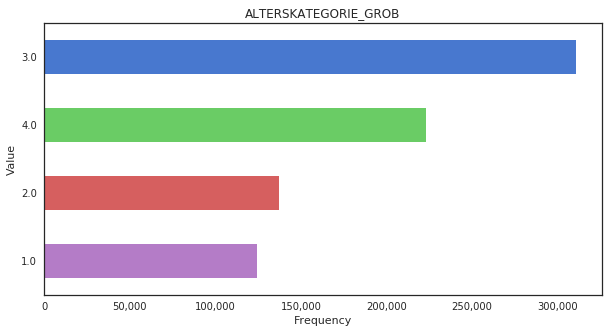

ALTERSKATEGORIE_GROB
     counts  percentage
3.0  310466   39.039363
4.0  223265   28.074325
2.0  137100   17.239558
1.0  124433   15.646754


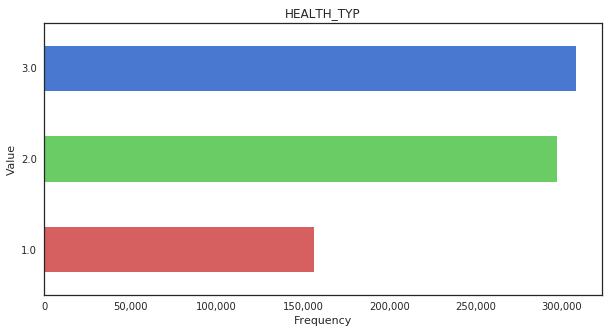

HEALTH_TYP
     counts  percentage
3.0  307926   40.445214
2.0  297008   39.011166
1.0  156407   20.543620


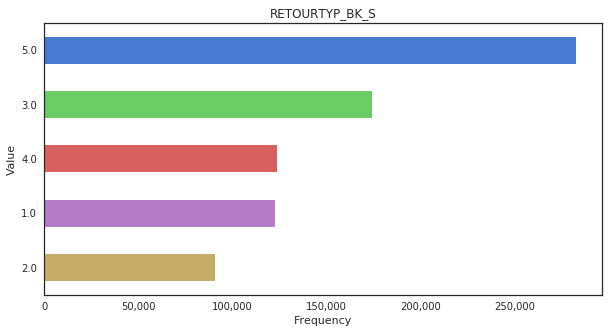

RETOURTYP_BK_S
     counts  percentage
5.0  282167   35.567956
3.0  174283   21.968870
4.0  123422   15.557696
1.0  122787   15.477652
2.0   90659   11.427826


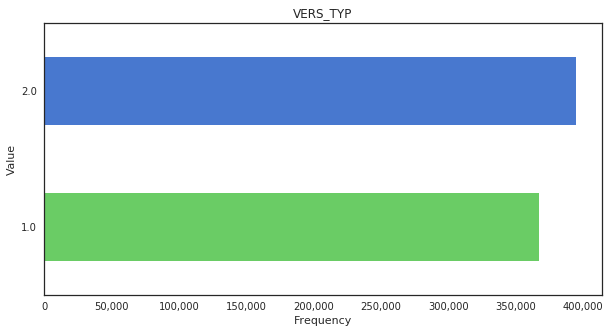

VERS_TYP
     counts  percentage
2.0  394238   51.782053
1.0  367103   48.217947


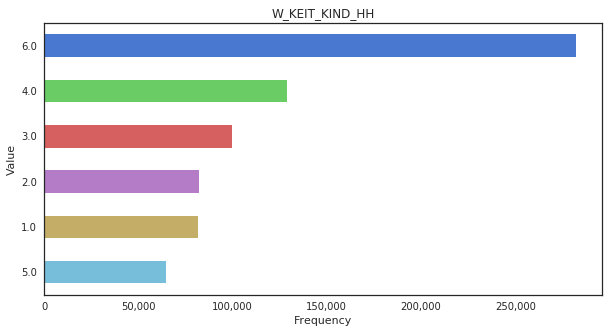

W_KEIT_KIND_HH
     counts  percentage
6.0  281963   38.166960
4.0  128673   17.417382
3.0   99515   13.470509
2.0   82043   11.105471
1.0   81853   11.079752
5.0   64715    8.759925


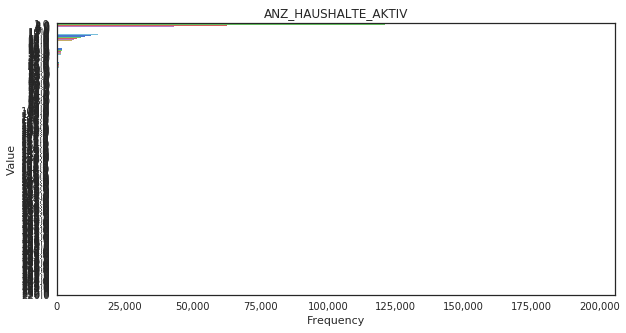

ANZ_HAUSHALTE_AKTIV
       counts  percentage
1.0    195955   24.754139
2.0    120980   15.282875
3.0     62575    7.904826
4.0     43213    5.458909
5.0     37815    4.777004
6.0     36020    4.550249
7.0     34526    4.361519
8.0     32293    4.079434
9.0     29002    3.663696
10.0    25428    3.212208
11.0    21964    2.774616
12.0    18033    2.278030
13.0    15282    1.930508
14.0    12625    1.594861
15.0    10371    1.310123
16.0     8899    1.124172
17.0     7292    0.921166
18.0     6324    0.798883
19.0     5461    0.689864
20.0     4674    0.590446
21.0     4138    0.522735
22.0     3735    0.471826
23.0     3243    0.409674
24.0     2838    0.358512
25.0     2636    0.332994
26.0     2342    0.295855
27.0     2232    0.281959
28.0     2040    0.257704
29.0     1963    0.247977
30.0     1821    0.230039
31.0     1634    0.206416
32.0     1616    0.204142
33.0     1551    0.195931
34.0     1437    0.181530
35.0     1320    0.166750
37.0     1317    0.166371
36.0     1281    0

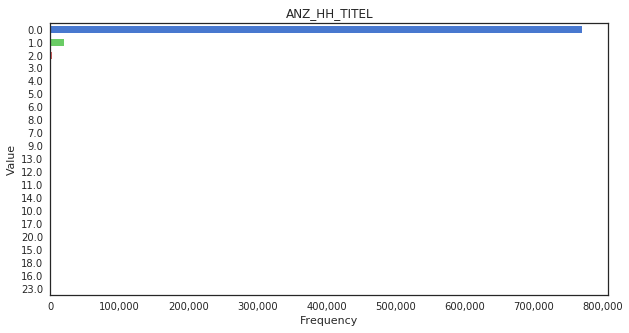

ANZ_HH_TITEL
      counts  percentage
0.0   770239   96.982025
1.0    20157    2.538000
2.0     2459    0.309617
3.0      585    0.073658
4.0      232    0.029211
5.0      117    0.014732
6.0      106    0.013347
8.0       68    0.008562
7.0       65    0.008184
9.0       34    0.004281
13.0      29    0.003651
12.0      22    0.002770
11.0      22    0.002770
14.0      16    0.002015
10.0      16    0.002015
17.0      13    0.001637
20.0       9    0.001133
15.0       7    0.000881
18.0       6    0.000755
16.0       3    0.000378
23.0       3    0.000378


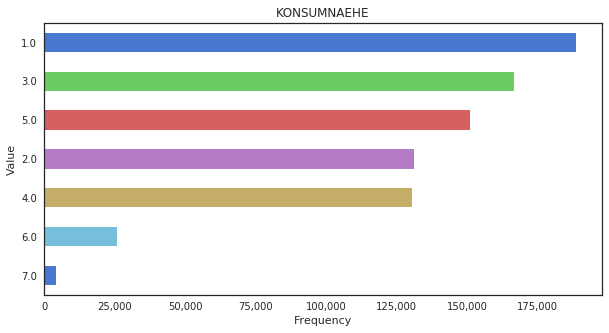

KONSUMNAEHE
     counts  percentage
1.0  188458   23.616439
3.0  166797   20.902011
5.0  150940   18.914905
2.0  131327   16.457121
4.0  130330   16.332183
6.0   26023    3.261048
7.0    4120    0.516294


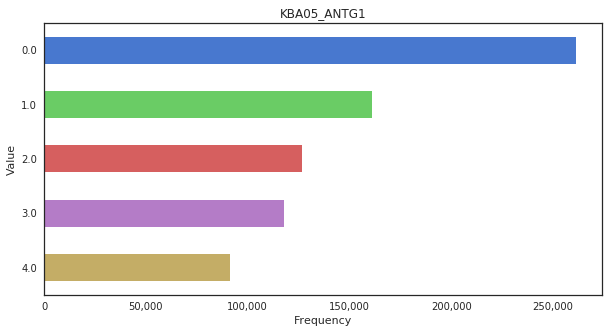

KBA05_ANTG1
     counts  percentage
0.0  261049   34.443862
1.0  161224   21.272548
2.0  126725   16.720610
3.0  117762   15.537995
4.0   91137   12.024985


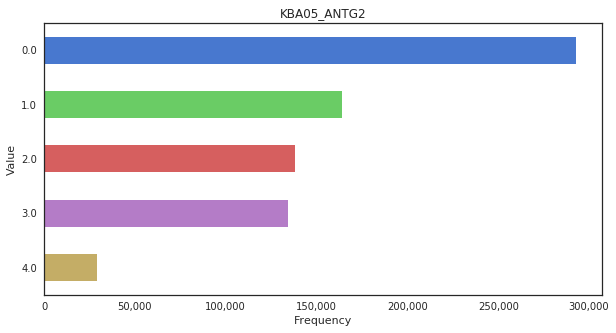

KBA05_ANTG2
     counts  percentage
0.0  292538   38.598649
1.0  163751   21.605970
2.0  138273   18.244300
3.0  134455   17.740537
4.0   28880    3.810544


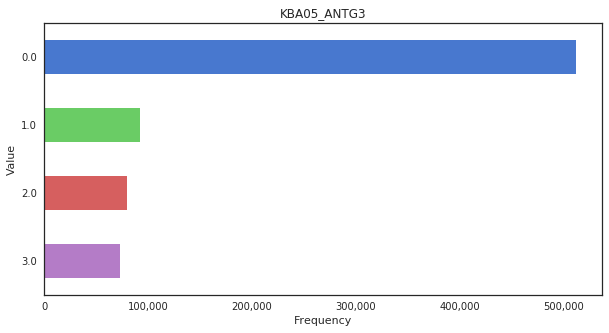

KBA05_ANTG3
     counts  percentage
0.0  511545   67.495319
1.0   92748   12.237547
2.0   80234   10.586399
3.0   73370    9.680735


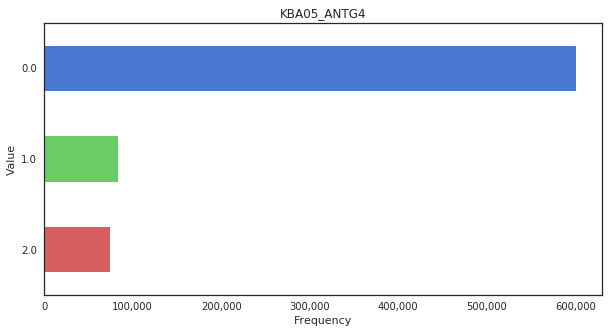

KBA05_ANTG4
     counts  percentage
0.0  600171   79.188993
1.0   83591   11.029335
2.0   74135    9.781672


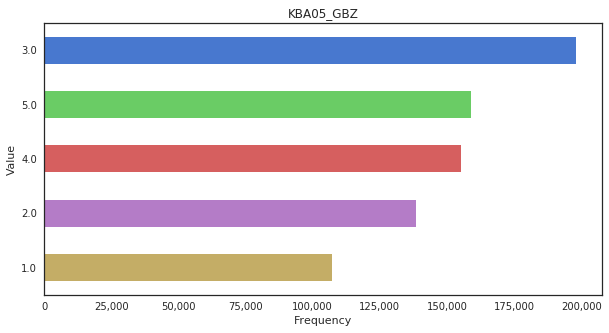

KBA05_GBZ
     counts  percentage
3.0  197833   26.102887
5.0  158971   20.975278
4.0  155301   20.491043
2.0  138528   18.277945
1.0  107264   14.152847


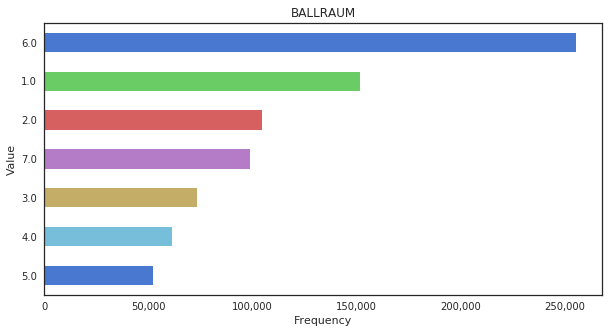

BALLRAUM
     counts  percentage
6.0  255090   31.987210
1.0  151781   19.032697
2.0  104521   13.106492
7.0   99039   12.419073
3.0   73276    9.188501
4.0   61357    7.693909
5.0   52411    6.572118


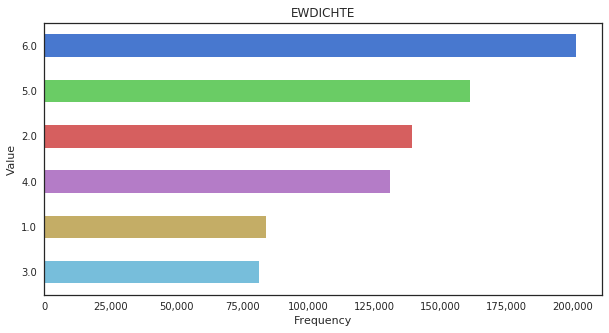

EWDICHTE
     counts  percentage
6.0  201009   25.205680
5.0  161208   20.214803
2.0  139087   17.440923
4.0  130716   16.391235
1.0   84047   10.539139
3.0   81408   10.208220


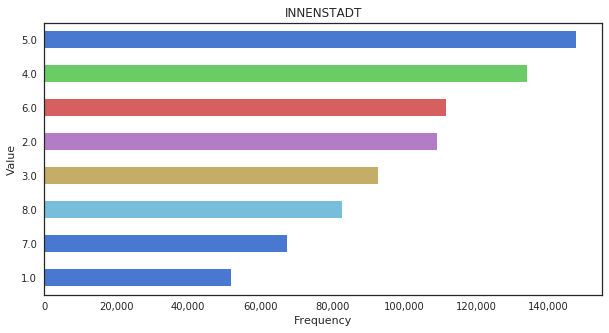

INNENSTADT
     counts  percentage
5.0  147624   18.511427
4.0  134067   16.811436
6.0  111678   14.003950
2.0  109048   13.674159
3.0   92817   11.638860
8.0   82868   10.391298
7.0   67463    8.459576
1.0   51910    6.509295


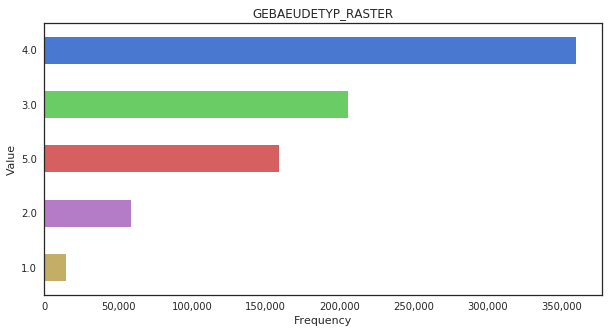

GEBAEUDETYP_RASTER
     counts  percentage
4.0  359618   45.061524
3.0  205329   25.728517
5.0  159215   19.950254
2.0   58961    7.388041
1.0   14937    1.871664


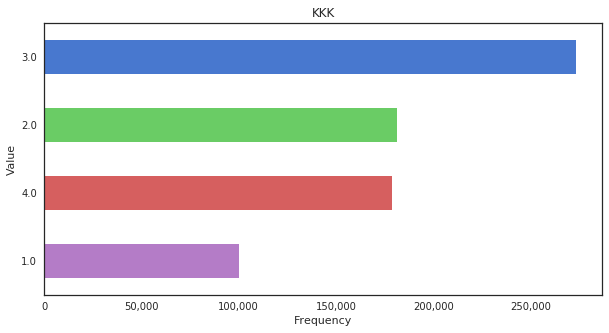

KKK
     counts  percentage
3.0  273024   37.239500
2.0  181519   24.758544
4.0  178648   24.366950
1.0   99966   13.635006


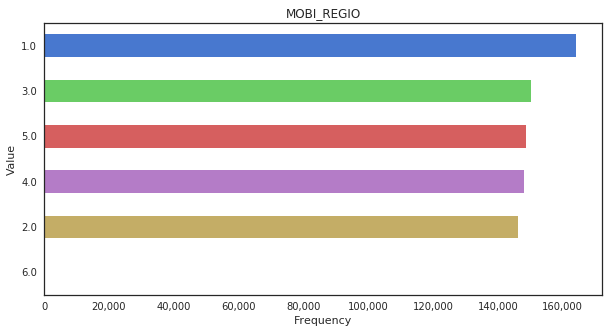

MOBI_REGIO
     counts  percentage
1.0  163993   21.637901
3.0  150336   19.835941
5.0  148713   19.621796
4.0  148209   19.555296
2.0  146305   19.304074
6.0     341    0.044993


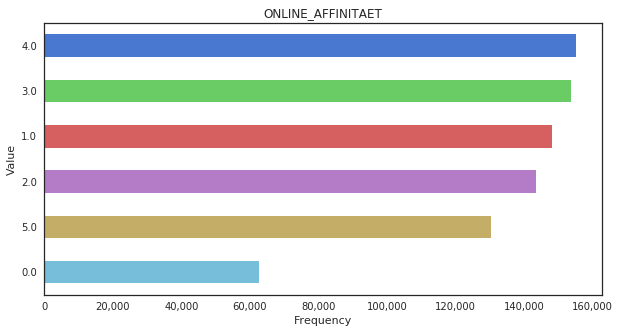

ONLINE_AFFINITAET
     counts  percentage
4.0  154959   19.533025
3.0  153679   19.371677
1.0  148126   18.671705
2.0  143459   18.083417
5.0  130440   16.442335
0.0   62655    7.897842


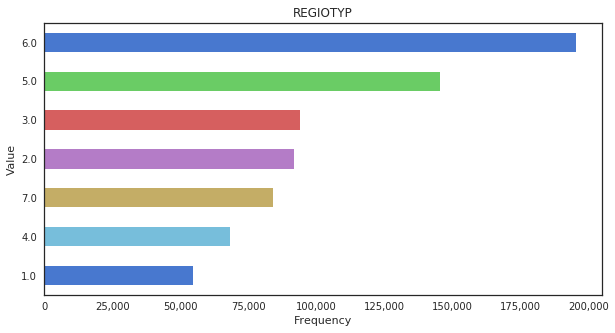

REGIOTYP
     counts  percentage
6.0  195286   26.636314
5.0  145359   19.826449
3.0   93929   12.811581
2.0   91662   12.502370
7.0   83943   11.449526
4.0   68180    9.299509
1.0   54798    7.474252


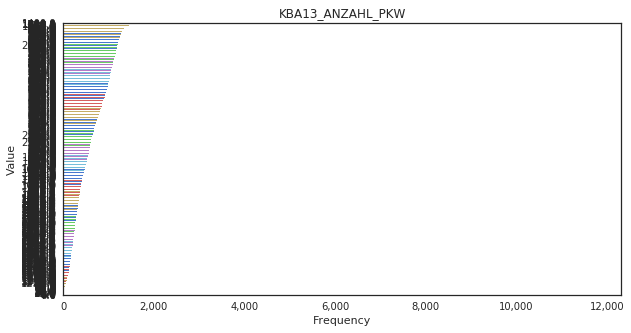

KBA13_ANZAHL_PKW
        counts  percentage
1400.0   11722    1.492450
1500.0    8291    1.055614
1300.0    6427    0.818288
1600.0    6135    0.781111
1700.0    3795    0.483181
1800.0    2617    0.333198
464.0     1604    0.204222
417.0     1604    0.204222
519.0     1600    0.203713
534.0     1496    0.190471
386.0     1458    0.185633
1900.0    1450    0.184615
395.0     1446    0.184105
481.0     1417    0.180413
455.0     1409    0.179394
483.0     1393    0.177357
452.0     1388    0.176721
418.0     1384    0.176211
454.0     1380    0.175702
450.0     1380    0.175702
494.0     1379    0.175575
459.0     1379    0.175575
492.0     1359    0.173028
504.0     1340    0.170609
387.0     1338    0.170355
420.0     1337    0.170227
439.0     1327    0.168954
506.0     1326    0.168827
388.0     1324    0.168572
456.0     1323    0.168445
487.0     1319    0.167936
402.0     1318    0.167808
421.0     1317    0.167681
499.0     1310    0.166790
466.0     1308    0.166535
491.0     1

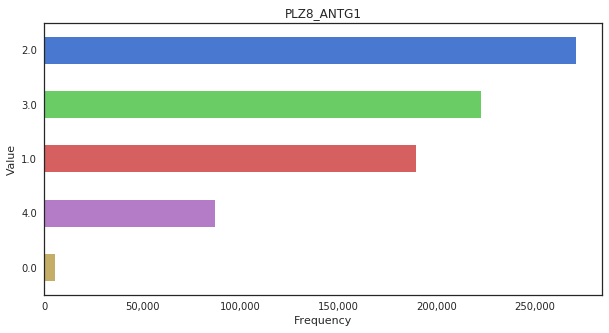

PLZ8_ANTG1
     counts  percentage
2.0  270590   34.928089
3.0  222355   28.701856
1.0  189247   24.428235
4.0   87044   11.235746
0.0    5470    0.706074


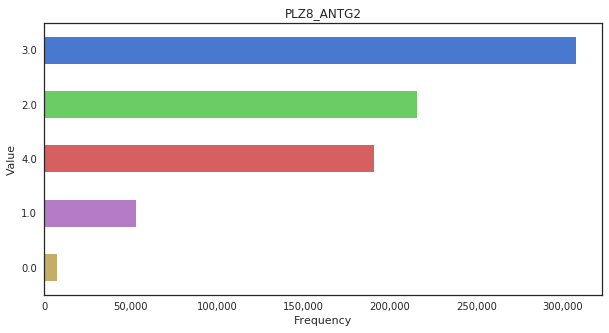

PLZ8_ANTG2
     counts  percentage
3.0  307283   39.664466
2.0  215767   27.851469
4.0  191005   24.655160
1.0   53213    6.868799
0.0    7438    0.960106


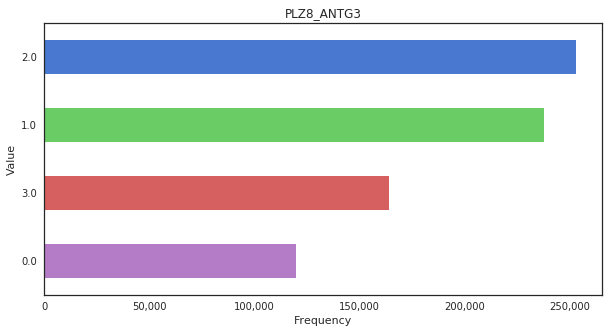

PLZ8_ANTG3
     counts  percentage
2.0  252994   32.656776
1.0  237878   30.705584
3.0  164040   21.174484
0.0  119794   15.463156


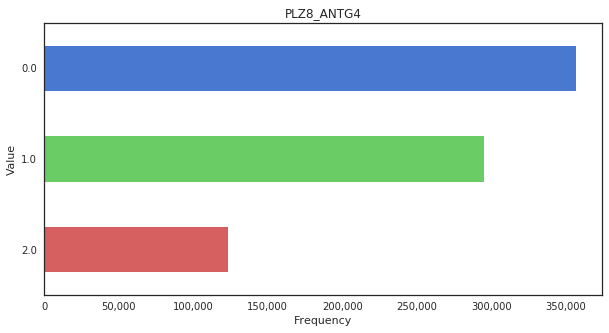

PLZ8_ANTG4
     counts  percentage
0.0  356389   46.003129
1.0  294986   38.077154
2.0  123331   15.919717


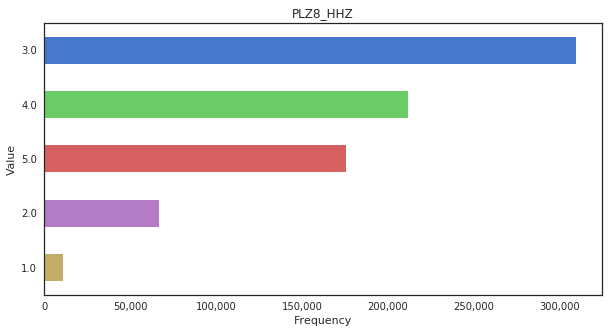

PLZ8_HHZ
     counts  percentage
3.0  309146   39.904945
4.0  211911   27.353732
5.0  175813   22.694158
2.0   66891    8.634372
1.0   10945    1.412794


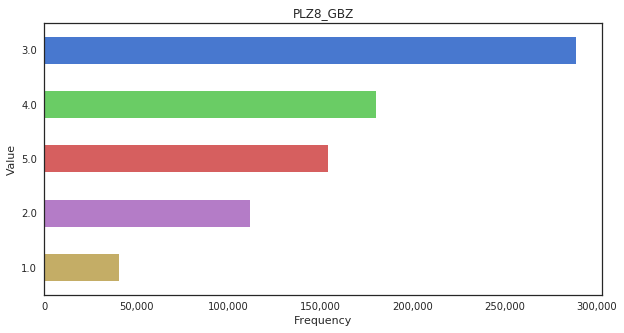

PLZ8_GBZ
     counts  percentage
3.0  288383   37.224831
4.0  180252   23.267149
5.0  153883   19.863406
2.0  111588   14.403916
1.0   40600    5.240698


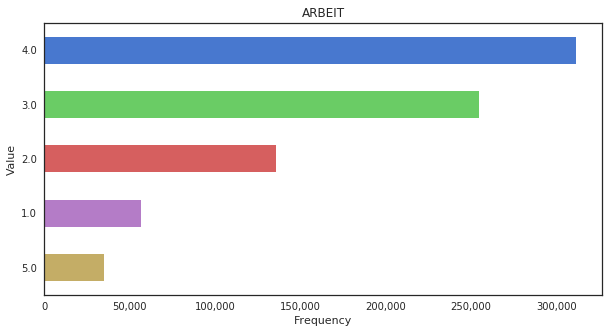

ARBEIT
     counts  percentage
4.0  311337   39.219112
3.0  254987   32.120704
2.0  135661   17.089212
1.0   56766    7.150811
5.0   35089    4.420160


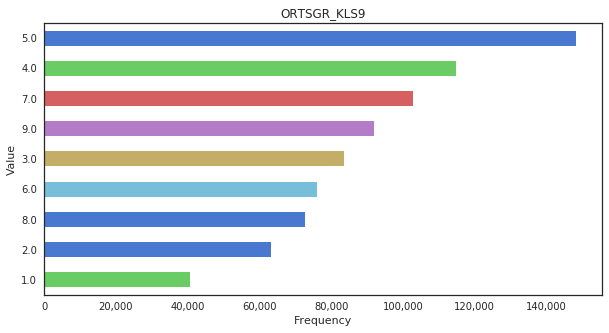

ORTSGR_KLS9
     counts  percentage
5.0  148095   18.653149
4.0  114909   14.473242
7.0  102866   12.956378
9.0   91878   11.572396
3.0   83539   10.522067
6.0   75995    9.571870
8.0   72709    9.157985
2.0   63361    7.980568
1.0   40589    5.112345


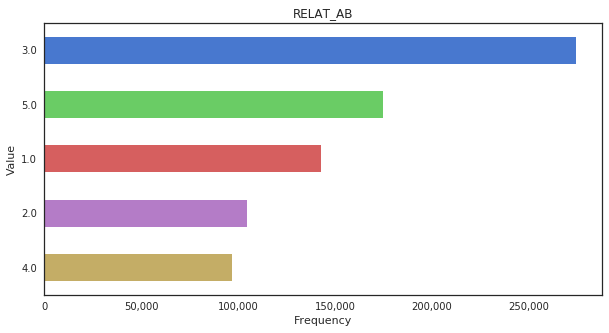

RELAT_AB
     counts  percentage
3.0  274005   34.516401
5.0  174963   22.040084
1.0  142906   18.001864
2.0  104846   13.207447
4.0   97120   12.234203


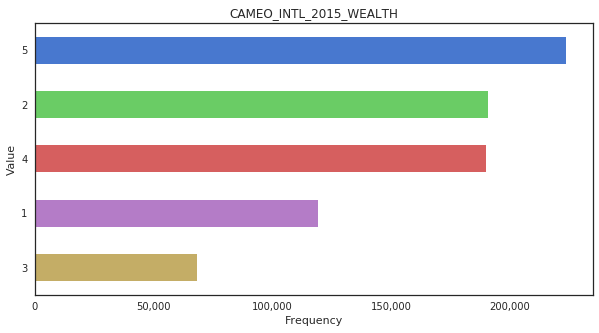

CAMEO_INTL_2015_WEALTH
   counts  percentage
5  223582   28.234828
2  190689   24.080968
4  189960   23.988907
1  119442   15.083613
3   68193    8.611684


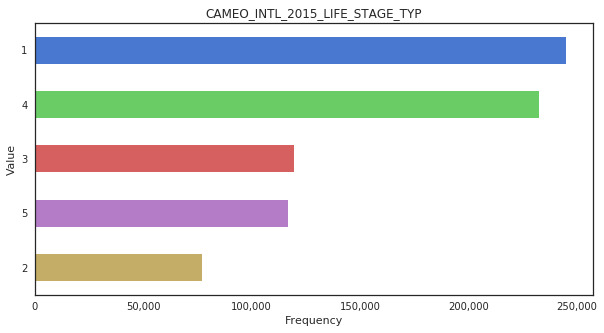

CAMEO_INTL_2015_LIFE_STAGE_TYP
   counts  percentage
1  245054   30.946397
4  232777   29.396009
3  119692   15.115184
5  117044   14.780784
2   77299    9.761626


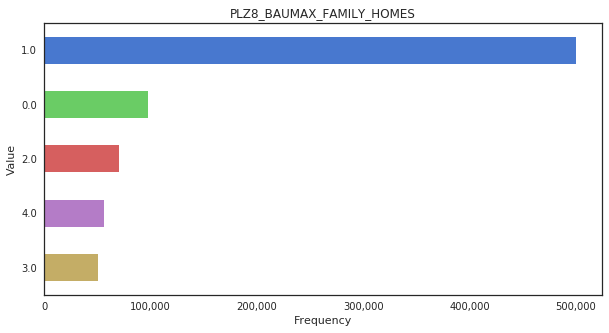

PLZ8_BAUMAX_FAMILY_HOMES
     counts  percentage
1.0  499550   64.482526
0.0   97333   12.563863
2.0   70407    9.088222
4.0   56684    7.316840
3.0   50732    6.548549


In [183]:
# the purpose of the below is to undersntannd how best to impute missing values.
# bar graphs for columns with missing data
# look and see which are good candidates for imputation with most frequent value. Avg?
bar_graph_for_each_column(azdias_cleaned_encoded, list_of_columns_with_missing_data)

ANZ_HH_TITEL, 0 should have been replaced by NAN, but the feature into doc didn't say anything about 0s here (?)

In [184]:
azdias_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
1               0.0         3.0             1.0        5.0        4.0   
2               1.0         3.0             3.0        4.0        1.0   
3               0.0         2.0             2.0        5.0        1.0   
4               0.0         3.0             5.0        6.0        4.0   
5               0.0         3.0             3.0        2.0        4.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
1        4.0        3.0         1.0         2.0        2.0         3.0   
2        3.0        3.0         4.0         4.0        6.0         3.0   
3        2.0        1.0         4.0         4.0        7.0         4.0   
4        4.0        2.0         7.0         4.0        4.0         6.0   
5        7.0        4.0         2.0         2.0        2.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
1        6.0         4.0        7.0         4.0            7.0          6.0   
2        4.0         7.0        7.0         7.0            3.0          3.0   
3        3.0         4.0        4.0         5.0            4.0          4.0   
4        2.0         3.0        2.0         2.0            4.0          2.0   
5        7.0         4.0        4.0         4.0            7.0          6.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
1      1.0       2.0           2.0        0.0                 6.0   
2      0.0       1.0           1.0        0.0                 4.0   
3      0.0       1.0           0.0        0.0                 1.0   
4      0.0       2.0           4.0        0.0                 5.0   
5      0.0       2.0           1.0        0.0                 5.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
1             3.0             9.0                 11.0           0.0   
2             3.0             9.0                 10.0           0.0   
3             NaN             9.0                  1.0           0.0   
4             2.0             9.0                  3.0           0.0   
5             6.0             9.0                  5.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
1          1.0            1992.0          0.0          0.0          0.0   
2          5.0            1992.0          1.0          3.0          1.0   
3          4.0            1997.0          4.0          1.0          0.0   
4          4.0            1992.0          1.0          4.0          1.0   
5          5.0            1992.0          2.0          2.0          0.0   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
1          2.0        1.0       6.0       3.0         8.0                 3.0   
2          0.0        3.0       2.0       4.0         4.0                 4.0   
3          0.0        4.0       4.0       2.0         6.0                 4.0   
4          0.0        3.0       2.0       5.0         1.0                 5.0   
5          0.0        4.0 

In [185]:
# Imputer produces an array, not a dataframe. I'll lose my columns I'll need to rebuild the df. 
# So I need to save my column names
columns_list = list(azdias_cleaned_encoded.columns)
print(type(columns_list))
columns_list

<class 'list'>


['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'OST_WEST_KZ_O',
 'PRAEGENDE_

In [186]:
"""
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html
https://stackoverflow.com/questions/25017626/predicting-missing-values-with-scikit-learns-imputer-module
https://stackoverflow.com/questions/52384806/imputer-on-some-columns-in-a-dataframe
"""

imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

azdias_cleaned_encoded_imputed = imputer.fit_transform(azdias_cleaned_encoded)

print(type(azdias_cleaned_encoded_imputed))

azdias_cleaned_encoded_imputed = pd.DataFrame(azdias_cleaned_encoded_imputed,columns=columns_list)

print(type(azdias_cleaned_encoded_imputed))

azdias_cleaned_encoded_imputed.head()

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   1.0        2.0                1.0            5.0   
1                   3.0        2.0                1.0            4.0   
2                   4.0        2.0                4.0            2.0   
3                   3.0        1.0                4.0            3.0   
4                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               2.0             5.0                    4.0               5.0   
1               1.0             2.0                    3.0               5.0   
2               5.0             2.0                    1.0               2.0   
3               4.0             1.0                    3.0               2.0   
4               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0               0.0         3.0             1.0        5.0        4.0   
1               1.0         3.0             3.0        4.0        1.0   
2               0.0         2.0             2.0        5.0        1.0   
3               0.0         3.0             5.0        6.0        4.0   
4               0.0         3.0             3.0        2.0        4.0   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0        4.0        3.0         1.0         2.0        2.0         3.0   
1        3.0        3.0         4.0         4.0        6.0         3.0   
2        2.0        1.0         4.0         4.0        7.0         4.0   
3        4.0        2.0         7.0         4.0        4.0         6.0   
4        7.0        4.0         2.0         2.0        2.0         5.0   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0        6.0         4.0        7.0         4.0            7.0          6.0   
1        4.0         7.0        7.0         7.0            3.0          3.0   
2        3.0         4.0        4.0         5.0            4.0          4.0   
3        2.0         3.0        2.0         2.0            4.0          2.0   
4        7.0         4.0        4.0         4.0            7.0          6.0   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0      1.0       2.0           2.0        0.0                 6.0   
1      0.0       1.0           1.0        0.0                 4.0   
2      0.0       1.0           0.0        0.0                 1.0   
3      0.0       2.0           4.0        0.0                 5.0   
4      0.0       2.0           1.0        0.0                 5.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0             3.0             9.0                 11.0           0.0   
1             3.0             9.0                 10.0           0.0   
2             6.0             9.0                  1.0           0.0   
3             2.0             9.0                  3.0           0.0   
4             6.0             9.0                  5.0           0.0   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
0          1.0            1992.0          0.0          0.0          0.0   
1          5.0            1992.0          1.0          3.0          1.0   
2          4.0            1997.0          4.0          1.0          0.0   
3          4.0            1992.0          1.0          4.0          1.0   
4          5.0            1992.0          2.0          2.0          0.0   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
0          2.0        1.0       6.0       3.0         8.0                 3.0   
1          0.0        3.0       2.0       4.0         4.0                 4.0   
2          0.0        4.0       4.0       2.0         6.0                 4.0   
3          0.0        3.0       2.0       5.0         1.0                 5.0   
4          0.0        4.0 

In [187]:
# number of cols with nan
azdias_cleaned_encoded_imputed.isnull().any().sum()  

0

In [188]:
# we now should have no NANs
azdias_cleaned_encoded_imputed.isnull().sum()  

ALTERSKATEGORIE_GROB                         0
ANREDE_KZ                                    0
FINANZ_MINIMALIST                            0
FINANZ_SPARER                                0
FINANZ_VORSORGER                             0
FINANZ_ANLEGER                               0
FINANZ_UNAUFFAELLIGER                        0
FINANZ_HAUSBAUER                             0
GREEN_AVANTGARDE                             0
HEALTH_TYP                                   0
RETOURTYP_BK_S                               0
SEMIO_SOZ                                    0
SEMIO_FAM                                    0
SEMIO_REL                                    0
SEMIO_MAT                                    0
SEMIO_VERT                                   0
SEMIO_LUST                                   0
SEMIO_ERL                                    0
SEMIO_KULT                                   0
SEMIO_RAT                                    0
SEMIO_KRIT                                   0
SEMIO_DOM    

In [189]:
# checking how mode imputation worked

print(azdias_cleaned_encoded['KKK'].isna().sum())
print(azdias_cleaned_encoded['KKK'].value_counts())

print(azdias_cleaned_encoded_imputed['KKK'].isna().sum())
print(azdias_cleaned_encoded_imputed['KKK'].value_counts())

64910
3.0    273024
2.0    181519
4.0    178648
1.0     99966
Name: KKK, dtype: int64
0
3.0    337934
2.0    181519
4.0    178648
1.0     99966
Name: KKK, dtype: int64


In [190]:
# KKK
64910 + 273024

337934

In [191]:
len(list_of_columns_with_missing_data)

34

In [192]:
# checking how mode imputation worked
# NAN count + mode frequency in the initial dataset = mode frequency in IMPUTED dataset

x = 10 # give a number from 0 to 33. This will indicate which col with missing value you're checking

test = list_of_columns_with_missing_data[x]

print("checking column:")
print(test)
print()


print('Before imputation:')
print('NAN', azdias_cleaned_encoded[test].isna().sum())
print(azdias_cleaned_encoded[test].value_counts())
print()

print('After imputation:')
print('NAN', azdias_cleaned_encoded_imputed[test].isna().sum())
print(azdias_cleaned_encoded_imputed[test].value_counts())

print()
if azdias_cleaned_encoded[test].isna().sum() + max(azdias_cleaned_encoded[test].value_counts())== max(azdias_cleaned_encoded_imputed[test].value_counts()):
    print('All good :) ')
    print(azdias_cleaned_encoded[test].isna().sum(), '+', max(azdias_cleaned_encoded[test].value_counts()), '==', max(azdias_cleaned_encoded_imputed[test].value_counts()))
else:
    print('Smth is wrong :( )')

checking column:
KBA05_ANTG3

Before imputation:
NAN 40170
0.0    511545
1.0     92748
2.0     80234
3.0     73370
Name: KBA05_ANTG3, dtype: int64

After imputation:
NAN 0
0.0    551715
1.0     92748
2.0     80234
3.0     73370
Name: KBA05_ANTG3, dtype: int64

All good :) 
40170 + 511545 == 551715


In [193]:
# PLZ8_BAUMAX_FAMILY_HOMES
23361 + 499550

522911

In [194]:
# ALTERSKATEGORIE_GROB
2803 + 310466

313269

### Apply feature scaling to the general population demographics data.



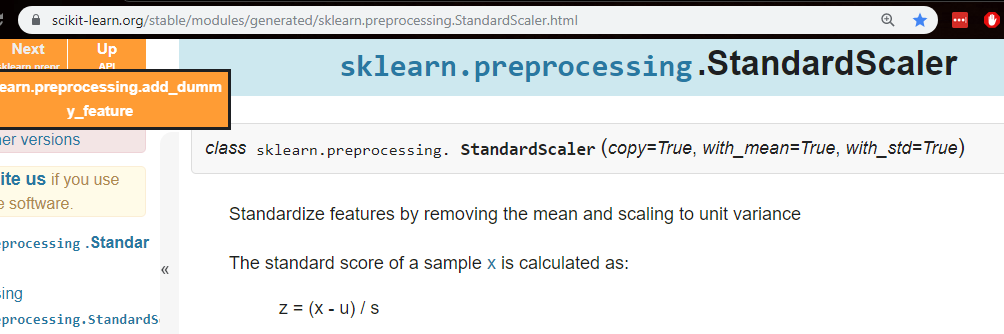

In [195]:
"""
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn
"""

scaler = StandardScaler()

azdias_scaled = scaler.fit_transform(azdias_cleaned_encoded_imputed)

print(type(azdias_scaled))

azdias_scaled = pd.DataFrame(azdias_scaled, columns=columns_list)

print(type(azdias_scaled))

azdias_scaled.head()

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -1.766647   0.957912          -1.494594       1.537920   
1              0.200522   0.957912          -1.494594       0.864560   
2              1.184107   0.957912           0.683145      -0.482159   
3              0.200522  -1.043937           0.683145       0.191200   
4             -1.766647   0.957912          -0.042768      -1.155519   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -1.040686        1.465965               0.958633          1.339319   
1         -1.766972       -0.570999               0.244109          1.339319   
2          1.138172       -0.570999              -1.184938         -0.791197   
3          0.411886       -1.249987               0.244109         -0.791197   
4          1.138172       -0.570999              -0.470414          1.339319   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0         -0.530407    1.010156       -1.685452   0.443205  -0.059355   
1          1.885345    1.010156       -0.310902  -0.072013  -1.626994   
2         -0.530407   -0.311824       -0.998177   0.443205  -1.626994   
3         -0.530407    1.010156        1.063648   0.958423  -0.059355   
4         -0.530407    1.010156       -0.310902  -1.102449  -0.059355   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0   0.002834  -0.463909   -1.684507   -1.109913  -1.435372   -0.578164   
1  -0.520587  -0.463909   -0.142554   -0.158741   0.754262   -0.578164   
2  -1.044008  -1.509281   -0.142554   -0.158741   1.301671   -0.067376   
3   0.002834  -0.986595    1.399399   -0.158741  -0.340555    0.954200   
4   1.573097   0.058776   -1.170522   -1.109913  -1.435372    0.443412   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0   1.274185   -0.312196   1.339262   -0.157565       1.518699     1.288987   
1   0.064233    1.391992   1.339262    1.448745      -0.638942    -0.410210   
2  -0.540743   -0.312196  -0.303542    0.377872      -0.099532     0.156189   
3  -1.145720   -0.880259  -1.398745   -1.228438      -0.099532    -0.976609   
4   1.879161   -0.312196  -0.303542   -0.157565       1.518699     1.288987   

    SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0  10.85417  0.922940      0.234458  -0.060408            1.026720   
1  -0.09213 -1.083494     -0.630198  -0.060408           -0.267573   
2  -0.09213 -1.083494     -1.494855  -0.060408           -2.209012   
3  -0.09213  0.922940      1.963772  -0.060408            0.379574   
4  -0.09213  0.922940     -0.630198  -0.060408            0.379574   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0       -0.730192        0.567332             0.173104     -0.125133   
1       -0.730192        0.567332             0.109101     -0.125133   
2        0.957029        0.567332            -0.466933     -0.125133   
3       -1.292599        0.567332            -0.338925     -0.125133   
4        0.957029        0.567332            -0.210918     -0.125133   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
0    -1.304533         -0.383167    -1.008836    -0.965690    -0.594874   
1     1.274844         -0.383167    -0.297919     1.444756     0.408133   
2     0.630000          1.117198     1.834830    -0.162208    -0.594874   
3     0.630000         -0.383167    -0.297919     2.248238     0.408133   
4     1.274844         -0.383167     0.412997     0.641274    -0.594874   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
0     2.730674  -1.659274  0.845251 -0.547161    1.701105           -0.799742   
1    -0.464084  -0.116192 -0.986687  0.034482   -0.271086            0.283466   
2    -0.464084   0.655349 -0.070718 -1.128805    0.715010            0.283466   
3    -0.464084  -0.116192 -0.986687  0.616126   -1.750229            1.366673   
4    -0.464084   0.6

In [196]:
azdias_cleaned_encoded_imputed.describe().transpose()

count         mean         std  \
ALTERSKATEGORIE_GROB                       798067.0     2.796131    1.016690   
ANREDE_KZ                                  798067.0     1.521486    0.499538   
FINANZ_MINIMALIST                          798067.0     3.058916    1.377576   
FINANZ_SPARER                              798067.0     2.716050    1.485091   
FINANZ_VORSORGER                           798067.0     3.432887    1.376869   
FINANZ_ANLEGER                             798067.0     2.840956    1.472781   
FINANZ_UNAUFFAELLIGER                      798067.0     2.658361    1.399534   
FINANZ_HAUSBAUER                           798067.0     3.114092    1.408110   
GREEN_AVANTGARDE                           798067.0     0.219562    0.413950   
HEALTH_TYP                                 798067.0     2.235876    0.756442   
RETOURTYP_BK_S                             798067.0     3.452369    1.455023   
SEMIO_SOZ                                  798067.0     4.139771    1.940928   
SEMIO_FAM                                  798067.0     4.113588    1.913707   
SEMIO_REL                                  798067.0     3.994586    1.910509   
SEMIO_MAT                                  798067.0     3.887550    1.913197   
SEMIO_VERT                                 798067.0     4.277350    1.945586   
SEMIO_LUST                                 798067.0     4.333779    2.102670   
SEMIO_ERL                                  798067.0     4.622122    1.826790   
SEMIO_KULT                                 798067.0     4.131906    1.957760   
SEMIO_RAT                                  798067.0     3.893826    1.652959   
SEMIO_KRIT                                 798067.0     4.549580    1.760370   
SEMIO_DOM                                  798067.0     4.554312    1.826147   
SEMIO_KAEM                                 798067.0     4.294274    1.867635   
SEMIO_PFLICHT                              798067.0     4.184520    1.853878   
SEMIO_TRADV                                798067.0     3.724242    1.765541   
SOHO_KZ                                    798067.0     0.008417    0.091355   
VERS_TYP                                   798067.0     1.540010    0.498397   
ANZ_PERSONEN                               798067.0     1.728842    1.156529   
ANZ_TITEL                                  798067.0     0.004161    0.068887   
HH_EINKOMMEN_SCORE                         798067.0     4.413465    1.545246   
W_KEIT_KIND_HH                             798067.0     4.298335    1.778073   
WOHNDAUER_2008                             798067.0     7.908934    1.923155   
ANZ_HAUSHALTE_AKTIV                        798067.0     8.295401   15.624098   
ANZ_HH_TITEL                               798067.0     0.040450    0.323257   
KONSUMNAEHE                                798067.0     3.023021    1.550763   
MIN_GEBAEUDEJAHR                           798067.0  1993.276914    3.332524   
KBA05_ANTG1                                798067.0     1.419064    1.406636   
KBA05_ANTG2                                798067.0     1.201882    1.244584   
KBA05_ANTG3                                798067.0     0.593091    0.997003   
KBA05_ANTG4                                798067.0     0.290528    0.626026   
KBA05_GBZ                                  798067.0     3.150598    1.296109   
BALLRAUM                                   798067.0     4.154412    2.183481   
EWDICHTE                                   798067.0     3.940716    1.719267   
INNENSTADT                                 798067.0     4.549816    2.028202   
GEBAEUDETYP_RASTER                         798067.0     3.738309    0.923185   
KKK                                        798067.0     2.745882    0.942213   
MOBI_REGIO                                 798067.0     2.864707    1.457131   
ONLINE_AFFINITAET                          798067.0     2.740513    1.554132   
REGIOTYP                                   798067.0     4.596357    1.808968   
KBA13_ANZAHL_PKW                           798

In [197]:
# mean close to zero. Stdev is close to 1
azdias_scaled.describe().transpose()

count          mean       std  \
ALTERSKATEGORIE_GROB                       798067.0 -1.320003e-16  1.000001   
ANREDE_KZ                                  798067.0  3.258161e-16  1.000001   
FINANZ_MINIMALIST                          798067.0  5.657155e-17  1.000001   
FINANZ_SPARER                              798067.0 -1.007675e-16  1.000001   
FINANZ_VORSORGER                           798067.0  1.164640e-16  1.000001   
FINANZ_ANLEGER                             798067.0  1.377340e-17  1.000001   
FINANZ_UNAUFFAELLIGER                      798067.0  4.154278e-17  1.000001   
FINANZ_HAUSBAUER                           798067.0 -1.895334e-16  1.000001   
GREEN_AVANTGARDE                           798067.0 -1.104899e-17  1.000001   
HEALTH_TYP                                 798067.0  2.394809e-16  1.000001   
RETOURTYP_BK_S                             798067.0  1.348849e-18  1.000001   
SEMIO_SOZ                                  798067.0  8.304550e-17  1.000001   
SEMIO_FAM                                  798067.0  6.091636e-17  1.000001   
SEMIO_REL                                  798067.0  1.940919e-18  1.000001   
SEMIO_MAT                                  798067.0  6.134371e-18  1.000001   
SEMIO_VERT                                 798067.0  2.115601e-16  1.000001   
SEMIO_LUST                                 798067.0  2.120498e-16  1.000001   
SEMIO_ERL                                  798067.0  1.769085e-16  1.000001   
SEMIO_KULT                                 798067.0 -1.305891e-16  1.000001   
SEMIO_RAT                                  798067.0 -1.729198e-16  1.000001   
SEMIO_KRIT                                 798067.0  5.967880e-17  1.000001   
SEMIO_DOM                                  798067.0 -2.576792e-16  1.000001   
SEMIO_KAEM                                 798067.0  2.900694e-17  1.000001   
SEMIO_PFLICHT                              798067.0 -1.856694e-16  1.000001   
SEMIO_TRADV                                798067.0 -1.355082e-16  1.000001   
SOHO_KZ                                    798067.0 -1.736143e-18  1.000001   
VERS_TYP                                   798067.0 -7.072779e-17  1.000001   
ANZ_PERSONEN                               798067.0  1.207287e-16  1.000001   
ANZ_TITEL                                  798067.0  3.648571e-17  1.000001   
HH_EINKOMMEN_SCORE                         798067.0  2.181842e-16  1.000001   
W_KEIT_KIND_HH                             798067.0  8.087755e-17  1.000001   
WOHNDAUER_2008                             798067.0  1.798466e-17  1.000001   
ANZ_HAUSHALTE_AKTIV                        798067.0 -3.774998e-17  1.000001   
ANZ_HH_TITEL                               798067.0  2.740435e-17  1.000001   
KONSUMNAEHE                                798067.0  7.888321e-17  1.000001   
MIN_GEBAEUDEJAHR                           798067.0 -1.373679e-14  1.000001   
KBA05_ANTG1                                798067.0 -1.070176e-16  1.000001   
KBA05_ANTG2                                798067.0 -3.984225e-19  1.000001   
KBA05_ANTG3                                798067.0 -7.874966e-17  1.000001   
KBA05_ANTG4                                798067.0 -5.667839e-17  1.000001   
KBA05_GBZ                                  798067.0  5.794266e-17  1.000001   
BALLRAUM                                   798067.0  2.276573e-16  1.000001   
EWDICHTE                                   798067.0  1.134280e-16  1.000001   
INNENSTADT                                 798067.0  5.666503e-17  1.000001   
GEBAEUDETYP_RASTER                         798067.0 -1.568672e-16  1.000001   
KKK                                        798067.0 -1.006785e-16  1.000001   
MOBI_REGIO                                 798067.0  1.470647e-16  1.000001   
ONLINE_AFFINITAET                          798067.0  6.094752e-17  1.000001   
REGIOTYP                                   798067.0  8.563191e-17  1.000001   
KBA13_ANZAHL_PKW                           798067.0  1.169893e-17  1.000001   
PLZ8_ANTG1       

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Imputed columns with most frequent value, because a lot of them they have a more or less prominent most frequent value (with a high frequency relative to other levels, without a close number two). I appears that mode is a goood option to impute. Many columns have a good pronounced mode, with no close 2nd most freq value. Not all columns have that. You can argue that maybe median may be better for some columns (e.g., KBA13_ANZAHL_PKW), but just to keep things simple I'll use mode.

Scaled data with StandardScaler.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [198]:
# Apply PCA to the data.

def do_pca(data_scaled,n_components=None):
    '''
    
    Source: Udacity Nanodegree Unsupervised Learning 4 Dimensionality Reduction and PCA 
    Assumes data is already scaled.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components,random_state=42)
    X_pca = pca.fit_transform(data_scaled)
    return pca, X_pca

In [199]:
pca, X_pca = do_pca(azdias_scaled)

In [200]:
print(azdias_scaled.shape)
print(X_pca.shape)

(798067, 70)
(798067, 70)


In [201]:
type(X_pca)

numpy.ndarray

In [202]:
X_pca

array([[  3.40924403e+00,  -2.98838568e+00,  -3.12516794e+00, ...,
         -1.36618198e-01,  -6.44366539e-02,  -9.46553317e-15],
       [ -1.20625506e+00,   6.41781896e-01,  -2.70946954e+00, ...,
          9.19622464e-02,   1.52014813e-01,  -1.12218904e-14],
       [ -4.02314639e+00,   1.73019209e+00,  -7.35136675e-01, ...,
         -6.63697460e-01,   1.98517770e-01,   4.04347317e-15],
       ..., 
       [ -2.01092829e+00,  -3.15269527e+00,  -3.15103351e+00, ...,
         -1.23762901e-01,   9.82314928e-02,  -6.75218026e-17],
       [  6.13439976e+00,  -3.98322369e+00,   2.22490845e+00, ...,
          1.14138153e-01,  -5.23150612e-02,   2.15489491e-17],
       [ -3.75399180e-01,   8.63149953e-01,   2.85234550e+00, ...,
         -1.98221526e-01,  -1.72061349e-01,   3.30086049e-16]])

In [203]:
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [204]:
# np.arange(0,1.1, 0.1)

In [205]:
# turn off scientific notation
# Credit:
# https://twitter.com/vboykis
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [206]:
# look at each PCA and how much variance it explains
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)+1
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)
test_pca_df = pd.DataFrame({'pca': ind, 'vals': vals, 'cumvals': cumvals})
test_pca_df

pca  vals  cumvals
0     1 0.166    0.166
1     2 0.121    0.287
2     3 0.087    0.374
3     4 0.059    0.433
4     5 0.037    0.470
5     6 0.034    0.505
6     7 0.027    0.531
7     8 0.025    0.557
8     9 0.024    0.581
9    10 0.022    0.603
10   11 0.021    0.623
11   12 0.020    0.643
12   13 0.019    0.662
13   14 0.018    0.680
14   15 0.017    0.697
15   16 0.016    0.713
16   17 0.016    0.728
17   18 0.014    0.742
18   19 0.013    0.756
19   20 0.013    0.768
20   21 0.012    0.781
21   22 0.012    0.793
22   23 0.012    0.805
23   24 0.011    0.815
24   25 0.011    0.826
25   26 0.010    0.836
26   27 0.010    0.846
27   28 0.009    0.855
28   29 0.007    0.862
29   30 0.007    0.869
30   31 0.007    0.876
31   32 0.007    0.883
32   33 0.006    0.889
33   34 0.006    0.895
34   35 0.006    0.901
35   36 0.006    0.907
36   37 0.006    0.912
37   38 0.005    0.918
38   39 0.005    0.923
39   40 0.005    0.928
40   41 0.004    0.932
41   42 0.004    0.936
42   43 0.004    0.941
43   44 0.004    0.944
44   45 0.004    0.948
45   46 0.004    0.952
46   47 0.004    0.955
47   48 0.003    0.959
48   49 0.003    0.962
49   50 0.003    0.965
50   51 0.003    0.968
51   52 0.003    0.971
52   53 0.003    0.974
53   54 0.002    0.976
54   55 0.002    0.979
55   56 0.002    0.981
56   57 0.002    0.983
57   58 0.002    0.985
58   59 0.002    0.987
59   60 0.002    0.989
60   61 0.002    0.991
61   62 0.002    0.992
62   63 0.002    0.994
63   64 0.001    0.996
64   65 0.001    0.997
65   66 0.001    0.998
66   67 0.001    0.999
67   68 0.001    1.000
68   69 0.000    1.000
69   70 0.000    1.000

In [207]:
def look_at_pca_and_variance(x):
    y = min(np.where(np.cumsum(pca.explained_variance_ratio_)>=x)[0]+1)
    print('To explain', x, 'of variance, we need', y, 'PCAs')
    return y
look_at_pca_and_variance(0.6)    

To explain 0.6 of variance, we need 10 PCAs


10

In [208]:
look_at_pca_and_variance(0.7)  

To explain 0.7 of variance, we need 16 PCAs


16

In [209]:
look_at_pca_and_variance(0.8)  

To explain 0.8 of variance, we need 23 PCAs


23

#### - Starting from PCA 27, they explain less than 1% each. They are noise

#### - We need 23 PCAs to explain 80% of variance

#### - PCA reduces many dimensions to fewer dimensions. It is a linear projection

#### - It's done so k means runs faster and so we have less noise (our model will generalize better)

#### - If there's non-linearity, it won't be captured by K means

#### - tSNE could be used as an alternative to capture non-linearity

In [210]:
# num_components=len(pca.explained_variance_ratio_)
# ind = np.arange(num_components)+1
# ind

In [211]:
# np.arange(0,71, 5)

To explain 0.6 of variance, we need 10 PCAs
To explain 0.7 of variance, we need 16 PCAs
To explain 0.8 of variance, we need 23 PCAs


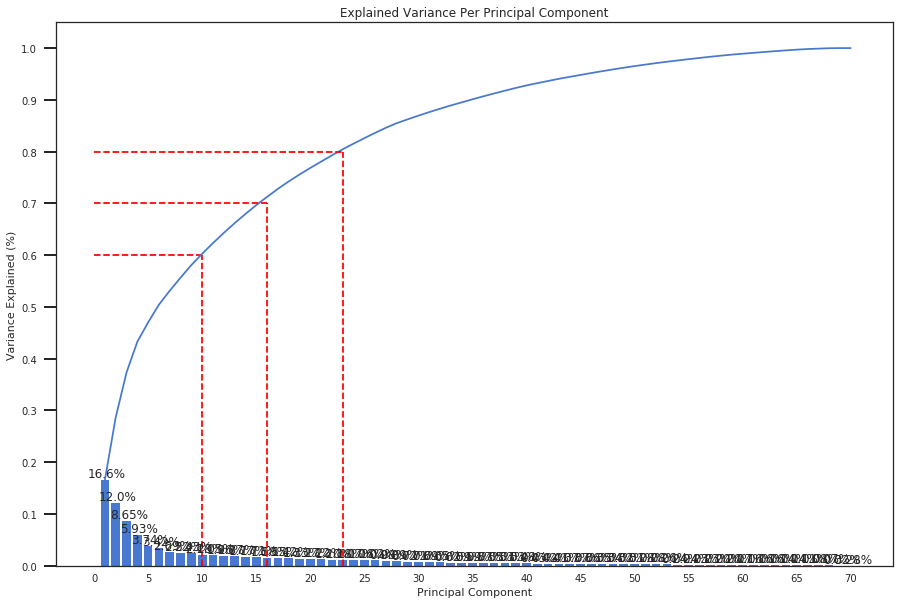

In [212]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Source: Udacity Nanodegree Unsupervised Learning 4 Dimensionality Reduction and PCA 
    https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib
    
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)+1
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15,10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    plt.yticks(np.arange(0,1.1, 0.1)) # I added this to see every 10% on the y axis
    plt.xticks(np.arange(0,71, 5))
    
    # draw lines to understand how many PCAs I would need
    X = 0.6
    Y = look_at_pca_and_variance(X)
    plt.hlines(y=X, xmin=0, xmax=Y, color='red', linestyles='dashed',zorder=1)
    plt.vlines(x=Y, ymin=0, ymax=X, color='red', linestyles='dashed',zorder=2)
    
    X = 0.7
    Y = look_at_pca_and_variance(X)
    plt.hlines(y=X, xmin=0, xmax=Y, color='red', linestyles='dashed',zorder=3)
    plt.vlines(x=Y, ymin=0, ymax=X, color='red', linestyles='dashed',zorder=4)
    
    X = 0.8
    Y = look_at_pca_and_variance(X)
    plt.hlines(y=X, xmin=0, xmax=Y, color='red', linestyles='dashed',zorder=3)
    plt.vlines(x=Y, ymin=0, ymax=X, color='red', linestyles='dashed',zorder=4)


    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)    

In [213]:
# Percentage of variance explained 
pca.explained_variance_ratio_.sum()

1.0000000000000002

(798067, 70)
(798067, 23)
To explain 0.6 of variance, we need 10 PCAs
To explain 0.7 of variance, we need 16 PCAs
To explain 0.8 of variance, we need 23 PCAs


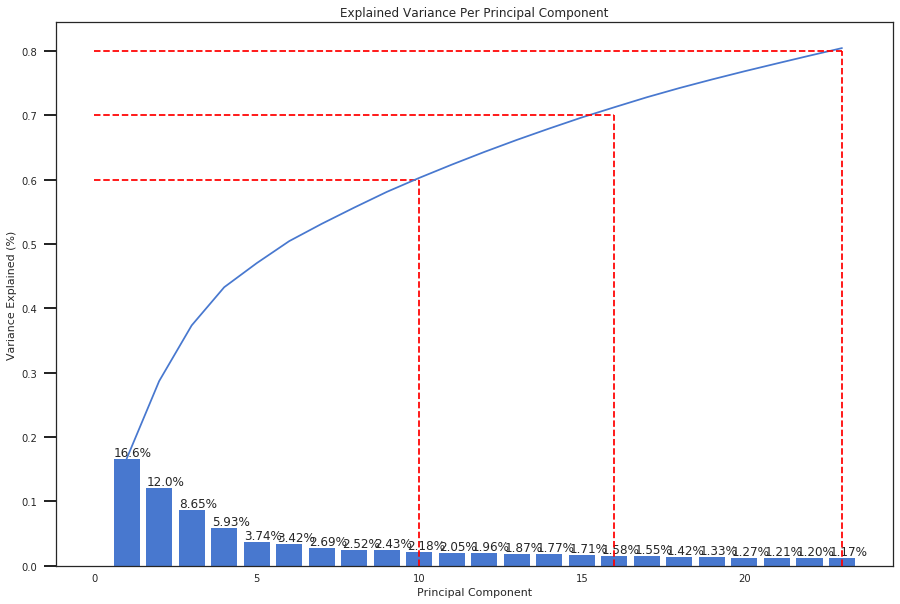

In [214]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca, X_pca = do_pca(azdias_scaled,n_components=23)
print(azdias_scaled.shape)
print(X_pca.shape)
scree_plot(pca)  

In [215]:
# Percentage of variance explained 
pca.explained_variance_ratio_.sum()

0.80447380248239619

In [216]:
type(azdias_scaled)

pandas.core.frame.DataFrame

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I would take 23 components because they would let me explain almost 80% of variability in the data.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

https://stackoverflow.com/questions/12067446/how-many-principal-components-to-take

https://blogs.sas.com/content/iml/2017/08/02/retain-principal-components.html

https://www.researchgate.net/post/How_many_components_can_I_retrieve_in_principal_component_analysis

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [217]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(full_dataset, pca,number):
	'''
    Source: Udacity Nanodegree Unsupervised Learning 4 Dimensionality Reduction and PCA 
    
    https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    
    https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html
    
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''
	number_minus_1 = number-1

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (10,15))

	# Plot the feature weights as a function of the components
	components.iloc[[number_minus_1]].plot(ax = ax, kind = 'bar', width =3);
	ax.set_ylabel("Feature Weights")
	#create ticks for X axis
	dimension_of_interest = []    
	dimension_of_interest.append(dimensions[number_minus_1])
	ax.set_xticklabels(dimension_of_interest, rotation=0) 
    
	ax.set_xlabel("Dataset Variables")
	# title
	title = "Feature Weights for Dimension " + str(number)
	ax.set_title(title)

	# Display the explained variance ratios
	ax.text(-0.1, ax.get_ylim()[1] + 0.05,s="Explained Variance\n          %.4f"%(pca.explained_variance_ratio_[number_minus_1]))
    
	ax.legend(bbox_to_anchor=(1.1, 1.05)) # move legend outta the graph
    
	return pd.concat([variance_ratios, components], axis = 1)

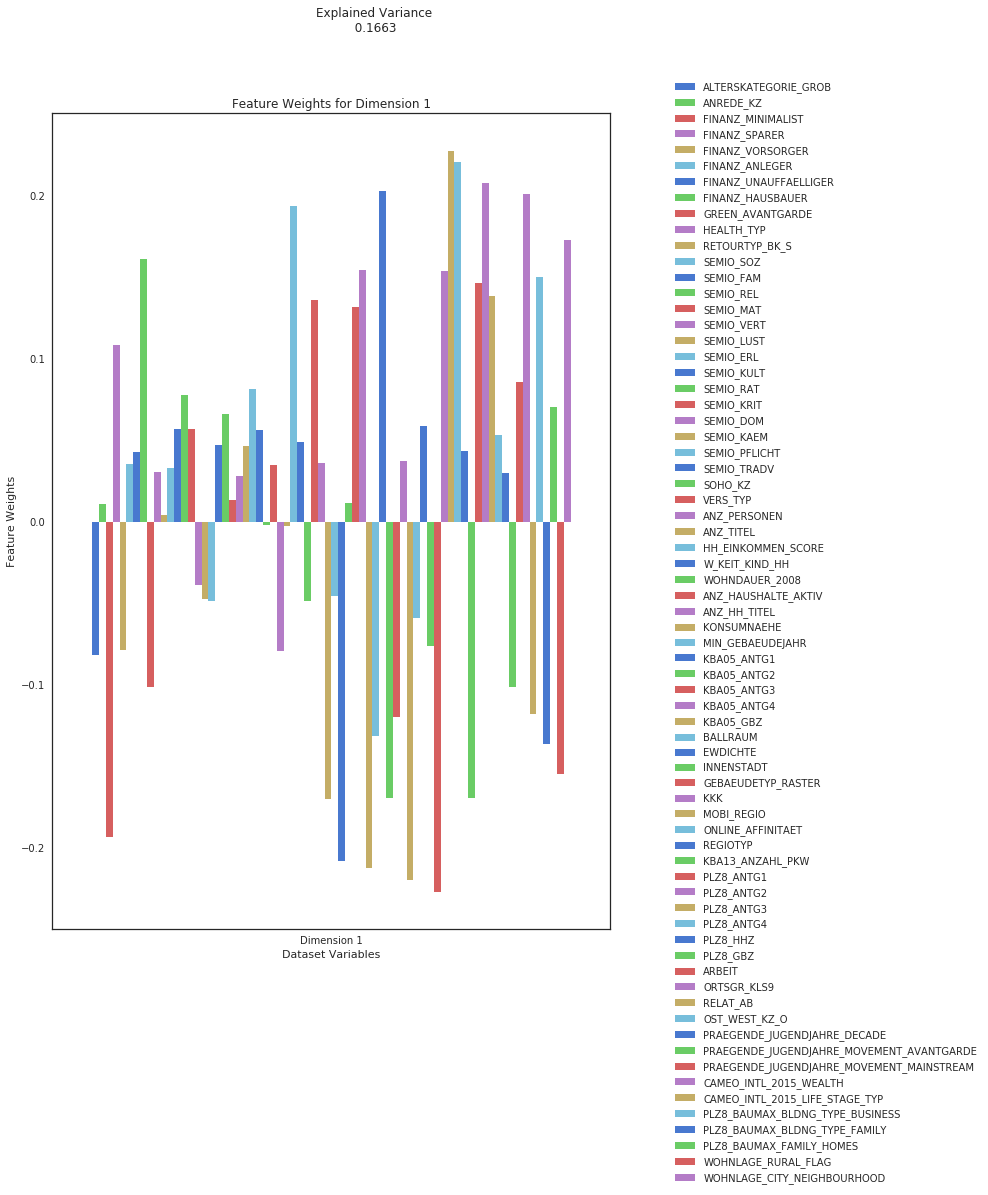

In [218]:
my_pca_results = pca_results(azdias_scaled, pca, 1)

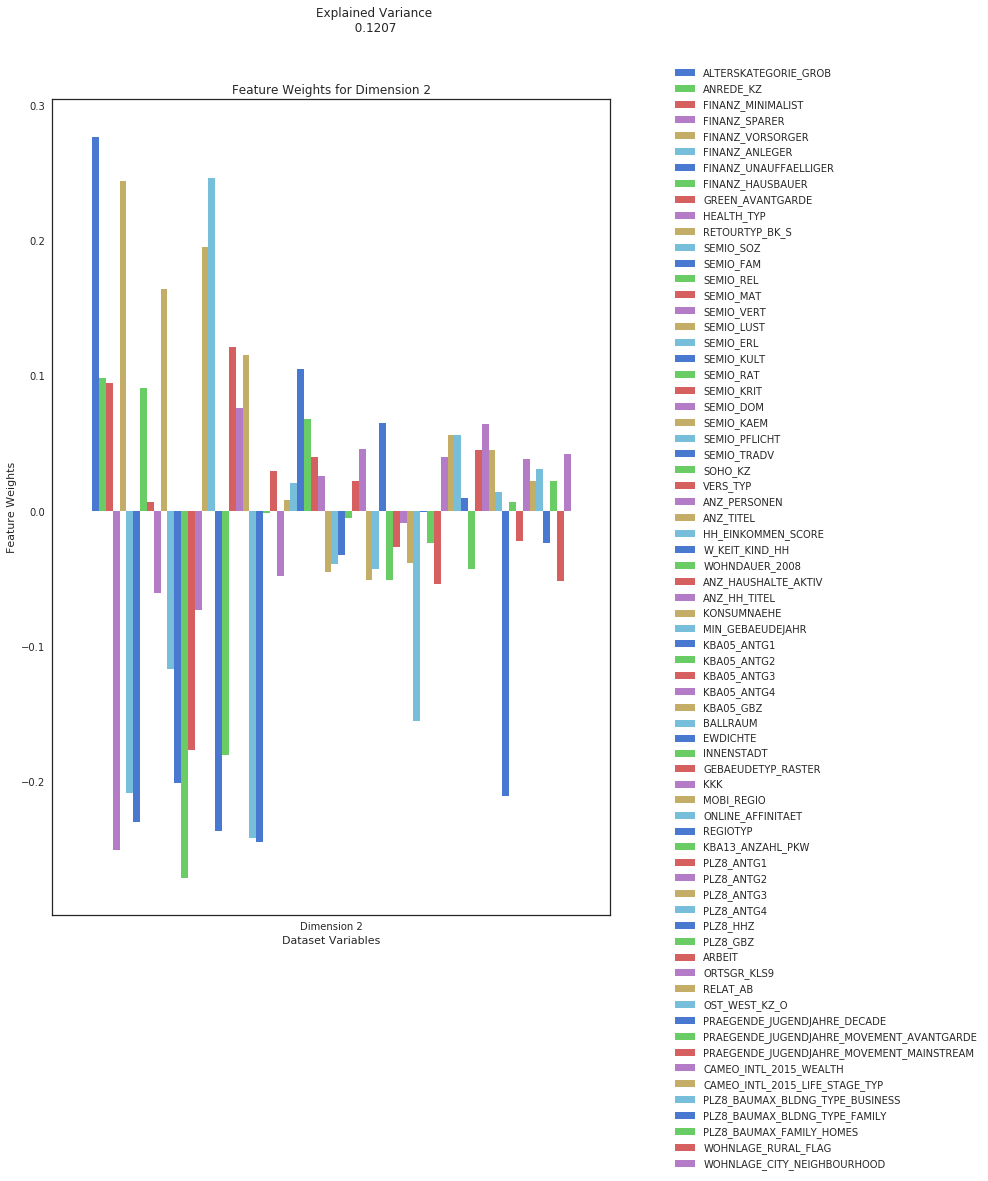

In [219]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

my_pca_results = pca_results(azdias_scaled, pca, 2)

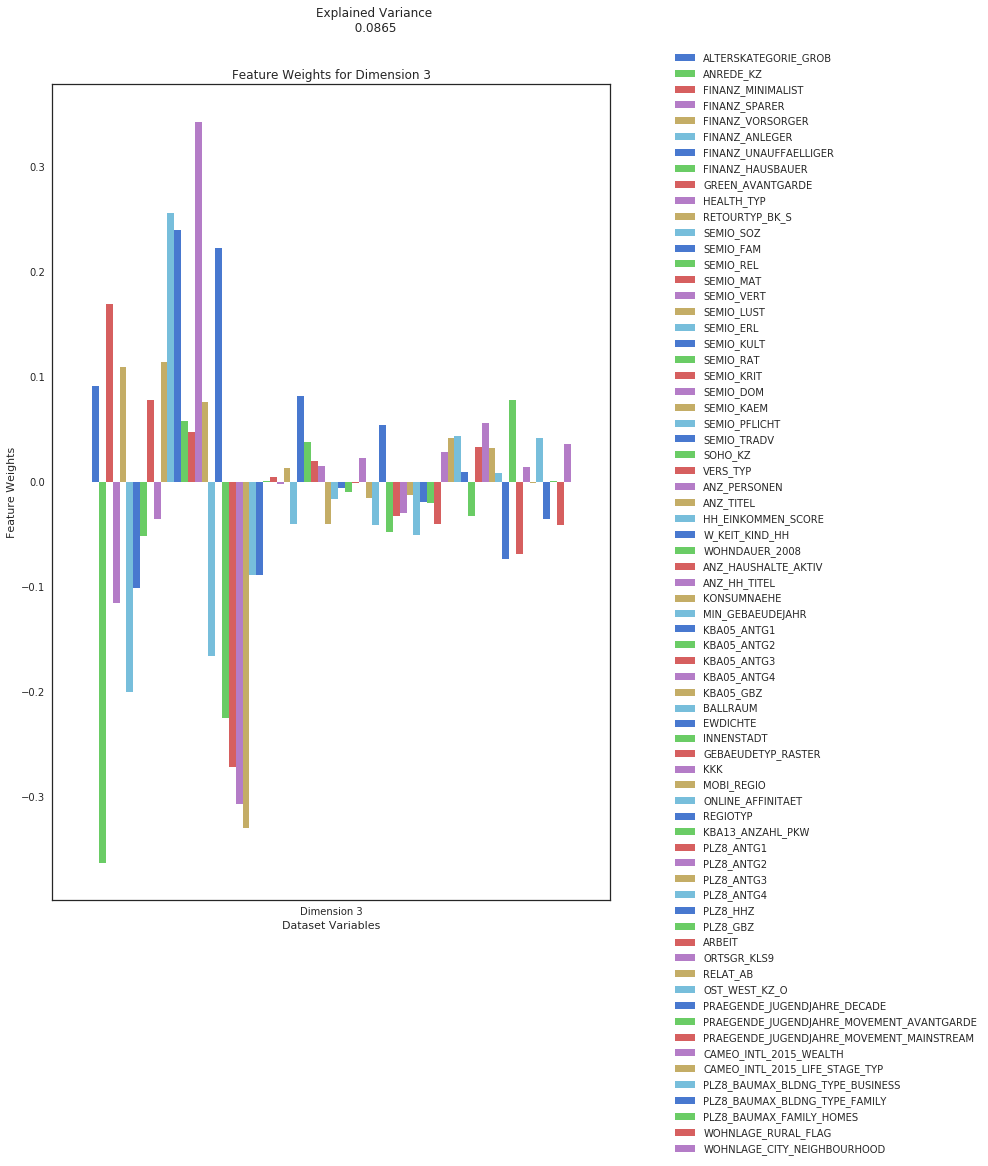

In [220]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

my_pca_results = pca_results(azdias_scaled, pca, 3)

In [221]:
def plot_pca(data, pca, n_compo):
    '''
	The above visualizations are too large to understand. Vis below only shows top vars.
    Adapted from: 
    https://github.com/MiguelAMartinez/identify-customer-segments-Arvato/blob/master/Identify_Customer_Segments.ipynb
    Plot the features with the most absolute variance for given pca component.
	'''
    
    compo = pd.DataFrame(pca.components_, columns = data.keys()).iloc[n_compo-1]
    compo.sort_values(ascending=False, inplace=True)
    compo = pd.concat([compo.head(7), compo.tail(7)])
    
    fig, ax = plt.subplots(figsize = (10,7))
    
    compo.plot(kind='barh', title='Component ' + str(n_compo))
    
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

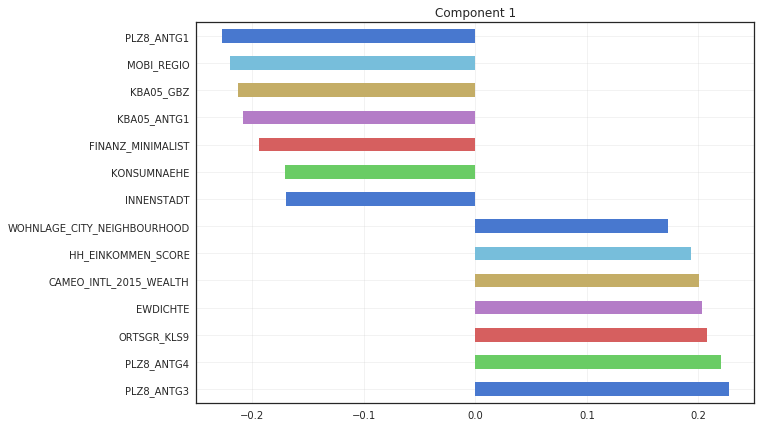

In [222]:
plot_pca(azdias_scaled, pca,1) 

In [223]:
# I wasn't sure if i should supply a scaled dataset or the non-scated one. It doesn't matter cus the results will be equal
# my_pca_results_1 = pca_results(azdias_cleaned_encoded_imputed, pca, 1)
# my_pca_results_2 = pca_results(azdias_scaled, pca, 1)
# my_pca_results_1.equals(my_pca_results_2)
# True

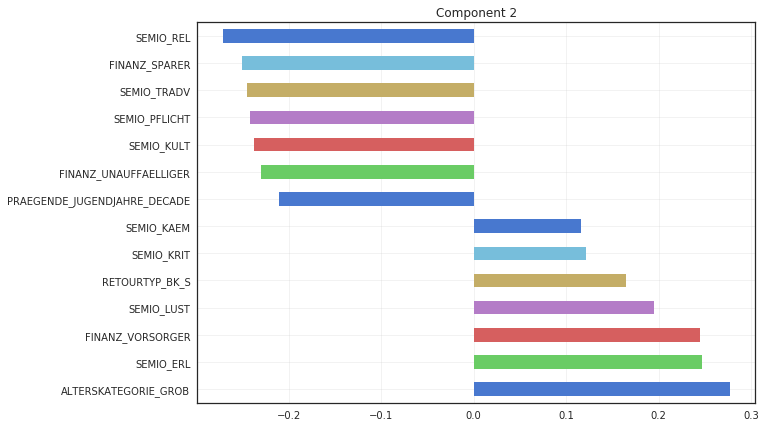

In [224]:
plot_pca(azdias_scaled, pca,2) 

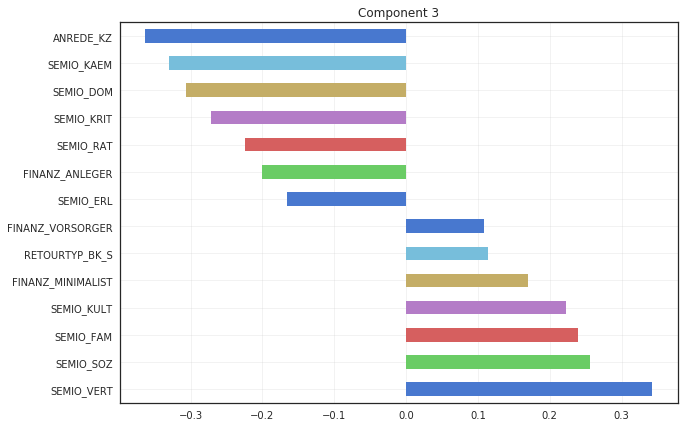

In [225]:
plot_pca(azdias_scaled, pca,3) 

In [226]:
my_pca_results.head()
# temp_df = my_pca_results.head()
# temp_df.to_excel("feature_weights.xlsx")

Explained Variance  ALTERSKATEGORIE_GROB  ANREDE_KZ  \
Dimension 1               0.166                -0.082      0.011   
Dimension 2               0.121                 0.277      0.098   
Dimension 3               0.086                 0.091     -0.363   
Dimension 4               0.059                -0.053      0.064   
Dimension 5               0.037                 0.011      0.017   

             FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
Dimension 1             -0.194          0.108            -0.079   
Dimension 2              0.095         -0.251             0.244   
Dimension 3              0.169         -0.116             0.109   
Dimension 4              0.043          0.021            -0.037   
Dimension 5              0.007         -0.002            -0.035   

             FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
Dimension 1           0.035                  0.043             0.161   
Dimension 2          -0.208                 -0.230             0.091   
Dimension 3          -0.201                 -0.101            -0.052   
Dimension 4          -0.070                  0.093            -0.096   
Dimension 5           0.008                  0.001            -0.013   

             GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  \
Dimension 1            -0.101       0.030           0.004      0.033   
Dimension 2             0.007      -0.060           0.165     -0.117   
Dimension 3             0.078      -0.035           0.114      0.256   
Dimension 4             0.388       0.011          -0.018     -0.018   
Dimension 5            -0.027      -0.027          -0.016     -0.016   

             SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
Dimension 1      0.057      0.078      0.056      -0.039      -0.048   
Dimension 2     -0.201     -0.271     -0.177      -0.073       0.196   
Dimension 3      0.239      0.058      0.047       0.343       0.075   
Dimension 4     -0.035      0.004      0.008      -0.045      -0.006   
Dimension 5     -0.003     -0.021      0.021       0.001       0.023   

             SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
Dimension 1     -0.049       0.047      0.066       0.013      0.028   
Dimension 2      0.247      -0.237     -0.180       0.122      0.077   
Dimension 3     -0.166       0.223     -0.225      -0.272     -0.307   
Dimension 4     -0.010      -0.041      0.069       0.031      0.125   
Dimension 5      0.004      -0.051      0.011       0.020     -0.024   

             SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  \
Dimension 1       0.046          0.081        0.056   -0.002     0.034   
Dimension 2       0.116         -0.242       -0.245   -0.002     0.030   
Dimension 3      -0.330         -0.089       -0.089    0.000     0.004   
Dimension 4       0.092          0.034        0.062    0.002     0.017   
Dimension 5      -0.021         -0.031        0.017   -0.001    -0.050   

             ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
Dimension 1        -0.079     -0.003               0.193           0.049   
Dimension 2        -0.048      0.008               0.021           0.105   
Dimension 3        -0.003      0.013              -0.040           0.081   
Dimension 4         0.094      0.041              -0.223          -0.089   
Dimension 5        -0.019      0.032              -0.065           0.001   

             WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  \
Dimension 1          -0.049                0.136         0.036       -0.170   
Dimension 2           0.069                0.041         0.026       -0.045   
Dimension 3           0.037                0.020         0.015       -0.040   
Dimension 4           0.007               -0.035         0.025       -0.110   
Dimension 5          -0.044                0.183         0.136       -0.055   

             MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
Dimension 1         

In [227]:
my_pca_results

Explained Variance  ALTERSKATEGORIE_GROB  ANREDE_KZ  \
Dimension 1                0.166                -0.082      0.011   
Dimension 2                0.121                 0.277      0.098   
Dimension 3                0.086                 0.091     -0.363   
Dimension 4                0.059                -0.053      0.064   
Dimension 5                0.037                 0.011      0.017   
Dimension 6                0.034                 0.009      0.004   
Dimension 7                0.027                 0.043     -0.042   
Dimension 8                0.025                 0.054      0.031   
Dimension 9                0.024                -0.083      0.013   
Dimension 10               0.022                 0.039     -0.069   
Dimension 11               0.021                -0.041      0.048   
Dimension 12               0.020                 0.077      0.043   
Dimension 13               0.019                 0.067      0.050   
Dimension 14               0.018                 0.089     -0.030   
Dimension 15               0.017                -0.005     -0.017   
Dimension 16               0.016                -0.006     -0.016   
Dimension 17               0.015                -0.035      0.020   
Dimension 18               0.014                -0.001      0.001   
Dimension 19               0.013                 0.136     -0.025   
Dimension 20               0.013                 0.113     -0.041   
Dimension 21               0.012                 0.052     -0.026   
Dimension 22               0.012                -0.062      0.034   
Dimension 23               0.012                 0.005      0.006   

              FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
Dimension 1              -0.194          0.108            -0.079   
Dimension 2               0.095         -0.251             0.244   
Dimension 3               0.169         -0.116             0.109   
Dimension 4               0.043          0.021            -0.037   
Dimension 5               0.007         -0.002            -0.035   
Dimension 6               0.096         -0.013            -0.059   
Dimension 7               0.090          0.008             0.004   
Dimension 8              -0.039          0.001            -0.055   
Dimension 9              -0.076          0.016             0.036   
Dimension 10             -0.105          0.144            -0.098   
Dimension 11              0.088         -0.159             0.119   
Dimension 12             -0.135          0.112            -0.150   
Dimension 13             -0.099          0.058             0.074   
Dimension 14             -0.115          0.079            -0.071   
Dimension 15              0.086         -0.038            -0.005   
Dimension 16             -0.104          0.017             0.059   
Dimension 17             -0.072          0.020            -0.021   
Dimension 18              0.003         -0.001             0.001   
Dimension 19             -0.080          0.155            -0.134   
Dimension 20              0.004          0.170            -0.279   
Dimension 21              0.026         -0.032            -0.022   
Dimension 22             -0.006         -0.035             0.119   
Dimension 23             -0.044          0.001             0.060   

              FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
Dimension 1            0.035                  0.043             0.161   
Dimension 2           -0.208                 -0.230             0.091   
Dimension 3           -0.201                 -0.101            -0.052   
Dimension 4           -0.070                  0.093            -0.096   
Dimension 5            0.008                  0.001            -0.013   
Dimension 6            0.047                 -0.059            -0.099   
Dimension 7            0.024                  0.039            -0.232   
Dimension 8            0.022                 -0.012             0.035   
Dimension 9            0.032                 -0.037             0.1

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


### Dimension 1 

This one is hard because it correlates with so many variables

#### Positively correlates with:

KBA05_ANTG3	high share of 6-10 family homes

KBA05_ANTG4h high share of 10+ family homes
Do they live in a densely populated area?

CAMEO_INTL_2015_WEALTH. Positively correlated. High number means poor.

FINANZ_SPARER saver. High number means low affinity. Not saver.

FINANZ_HAUSBAUER home owner. POsitive correlation. High number means low affinity. Not a home owner.

#### Negative correlation:

MINIMALIST: low financial interest. Low number means high affinity. So they do have low financial interest, but i'm not sure what that means in this context

####  Observations:
Relatively poor people who don't save, don't own a home. Live an a densely populated area. Lower social status

### Dimension 2


#### Positively correlates with 

ALTERSKATEGORIE_GROB, age. Older people

LUST: sensual-minded. High number is lowest affinity.

ERL: event-oriented. High number is lowest affinity.

Not sensual-minded, not event-oriented

FINANZ_VORSORGER: be prepared. High number is lowest affinity. Not financially prepared.

#### Negative correlation:

SEMIO_REL: religious. Negative correlation. Low number means high affinity. Religious.

FINANZ_SPARER	money saver. Negative correlation. Low number means high affinity.

FINANZ_ANLEGER investor. Negative correlation. Low number means high affinity. This contradicts to not financially prepared.

PRAEGENDE_JUGENDJAHRE_DECADE negatively correlates with decade, indicating an older decade. Makes sense. These are older people

PFLICHT: dutiful

TRADV: tradionally-minded. Low score means high affinity

#### Observations:

Older people, traditional, dutiful, religious, conservative, not event oriented, not sensually minded. Save and invest money but maybe still think they're not prepard for retirement (this is just an assumption)




### Dimension 3


#### Positively correlates with :
 
SEMIO_VERT, which is dreamful personality

SOZ: socially-minded

FAM: family-minded

Small number indicates high affinity. Large number indicates small affinity. So it's a NEGATIVE correlation then.

They are not socially_minded, family-minded, 

#### Negative correlation:

Feature 3 negatively correlates with gender ANREDE_KZ, 1 being male and 2 being female. So feature 3 must be associated with males.

negatively correlates with:

FINANZ_ANLEGER - investor

SEMIO_KAEM - combative attitude 

SEMIO_KRIT: critical-minded

SEMIO_DOM: dominant-minded

however, the scale there is 1: highest affinity, 7: lowest affinity
so the correlation is actually positive then.

#### Observations:
Male. Not dreamful, socially minded and family minded. An investor with a combative attitude, critical-minded, dominant.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [228]:
# Use a sample to reduce computation time
# Borrowed from:
# https://github.com/MiguelAMartinez/identify-customer-segments-Arvato/blob/master/Identify_Customer_Segments.ipynb

# https://stackoverflow.com/questions/22994423/difference-between-np-random-seed-and-np-random-randomstate
np.random.seed(42)
# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
x = 0.25

X_pca_test_subset = X_pca[np.random.choice(X_pca.shape[0], int(X_pca.shape[0]*x), replace=False)]

print('Taking', x*100, 'percent of the data: ' , len(X_pca_test_subset), 'rows')

X_pca_test_subset

Taking 25.0 percent of the data:  199516 rows


array([[ 1.35770809,  4.84583696, -0.88853132, ...,  0.31667212,
         0.12803458,  0.5365943 ],
       [ 2.15221546,  2.32769318, -1.78029203, ...,  0.59863523,
        -0.47901373, -0.50870354],
       [ 4.41319996,  3.21135748,  3.9577333 , ..., -0.04890789,
        -1.35555171, -0.45538185],
       ..., 
       [ 5.16483812,  5.06477375, -0.85087555, ...,  0.72772376,
        -0.34920901,  0.54752801],
       [ 0.25166879, -4.3784477 , -3.37640753, ..., -1.2435927 ,
        -0.63095716,  0.25152027],
       [ 5.96124379, -2.41743762, -2.9865717 , ...,  0.12979854,
         0.51238191,  0.41753436]])

In [229]:
X_pca

array([[ 3.40924506, -2.98839272, -3.12515919, ..., -0.54596531,
         0.08406835,  1.18116573],
       [-1.20625655,  0.64178459, -2.70947703, ...,  0.96223871,
        -0.61896201, -1.30354837],
       [-4.02314636,  1.73019217, -0.73512714, ..., -0.9805615 ,
         1.06419267, -0.67000887],
       ..., 
       [-2.01092882, -3.15269442, -3.15102529, ...,  0.08738137,
         1.17673668, -0.69580493],
       [ 6.13439945, -3.98322046,  2.2249162 , ..., -1.07676273,
         0.60650368, -0.4018651 ],
       [-0.37539902,  0.8631471 ,  2.85234551, ...,  0.23989573,
        -0.16909422,  0.38225317]])

In [230]:
# len(X_pca) # 798067

In [231]:
# len(X_pca_test_subset)

In [232]:
# 159613/ 798067 # 0.1999994987889488

In [233]:
# 199516/ 798067 # 0.249999060229279

In [234]:
# Over a number of different cluster counts..
    # run k-means clustering on the data and...    
    # compute the average within-cluster distances.
"""https://stackoverflow.com/questions/48607546/k-means-cluster-method-score-negative
https://stackoverflow.com/questions/51138686/how-to-use-silhouette-score-in-k-means-clustering-from-sklearn-library
https://www.datacamp.com/community/tutorials/seaborn-python-tutorial
https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-seaborn-plots-for-academic-papers/36222162
https://stackoverflow.com/questions/16424724/how-can-i-fix-a-memoryerror-when-executing-scikit-learns-silhouette-score
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

Runtime calculation taken from:
https://github.com/MiguelAMartinez/identify-customer-segments-Arvato/blob/master/Identify_Customer_Segments.ipynb
"""
def choose_k(my_pca_data, k_min, k_max):
    
    start_time = time.time()
    
    with active_session():
        list_k = []
        list_score = []
        
        for k in range(k_min,k_max+1):

            # run k-means
            kmeans = KMeans(k, random_state=42)
            
            model = kmeans.fit(my_pca_data)
            
            # vaidate with score(?)
            score = model.score(my_pca_data) # I'm not sure about this one, if I'm doing it right.
            # Checked other guys' submmissions, seems right. But they use abs() to get the abs value
                        
            # print reports
            print("k:", k)
            print("score:", score)    
            print("--------------------------------")
            print()
          
            # append
            list_k.append(k)
            list_score.append(score)

    df_k = pd.DataFrame(
            {'k': list_k,
             'score': list_score
             })

    print(df_k)
    
    # Investigate the change in within-cluster distance across number of clusters.
    # HINT: Use matplotlib's plot function to visualize this relationship.
  
    plt.rcParams["figure.figsize"] = (30,10)
    ax = sns.barplot(x="k", y="score", data=df_k)
    ax.set_title("Number of clusters and score",fontsize=40)  
    ax.set_xlabel("Number of clusters",fontsize=30)
    ax.set_ylabel("score",fontsize=30)
    ax.tick_params(labelsize=25)
    # Show the plot
    plt.show()    
    
    print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

k: 2
score: -9534527.16974
--------------------------------

k: 3
score: -8774898.55988
--------------------------------

k: 4
score: -8241957.10428
--------------------------------

k: 5
score: -7834534.54164
--------------------------------

k: 6
score: -7439194.10916
--------------------------------

k: 7
score: -7177500.38958
--------------------------------

k: 8
score: -6946275.59724
--------------------------------

k: 9
score: -6772419.52538
--------------------------------

k: 10
score: -6595858.39621
--------------------------------

k: 11
score: -6439090.29896
--------------------------------

k: 12
score: -6289897.42137
--------------------------------

k: 13
score: -6132782.31472
--------------------------------

k: 14
score: -6067388.36798
--------------------------------

k: 15
score: -5984729.48827
--------------------------------

k: 16
score: -5878415.35592
--------------------------------

k: 17
score: -5768672.69264
--------------------------------

k: 18
score: -56

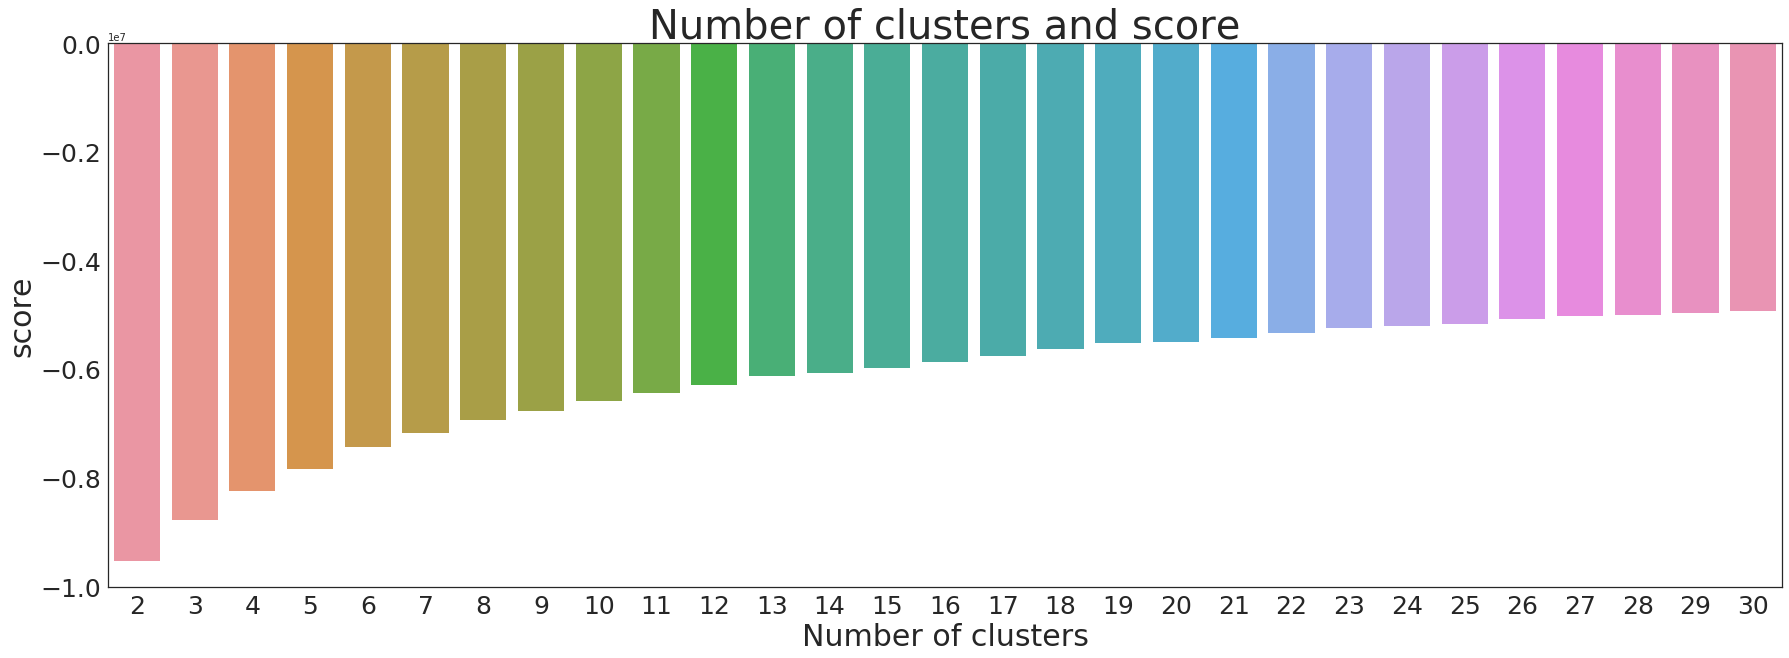

--- Run time: 24.62 mins ---


In [235]:
# this took half hour to run.
# Taking 25.0 percent of the data:  199516 rows
# Do NOT rerun it again, if you decide to re-run the whole project :) 
choose_k(X_pca_test_subset,k_min=2,k_max=30)

k: 2
score: -37972652.8644
--------------------------------

k: 3
score: -34928060.341
--------------------------------

k: 4
score: -32807608.9863
--------------------------------

k: 5
score: -31177923.7077
--------------------------------

k: 6
score: -29619317.6603
--------------------------------

k: 7
score: -28685014.9498
--------------------------------

k: 8
score: -27674660.5294
--------------------------------

k: 9
score: -26911374.8197
--------------------------------

k: 10
score: -26240156.0953
--------------------------------

k: 11
score: -25612716.8858
--------------------------------

k: 12
score: -24878265.0983
--------------------------------

k: 13
score: -24430332.1836
--------------------------------

k: 14
score: -23932669.4846
--------------------------------

k: 15
score: -23776349.5293
--------------------------------

k: 16
score: -23284164.3846
--------------------------------

k: 17
score: -22778097.8015
--------------------------------

k: 18
score: -227

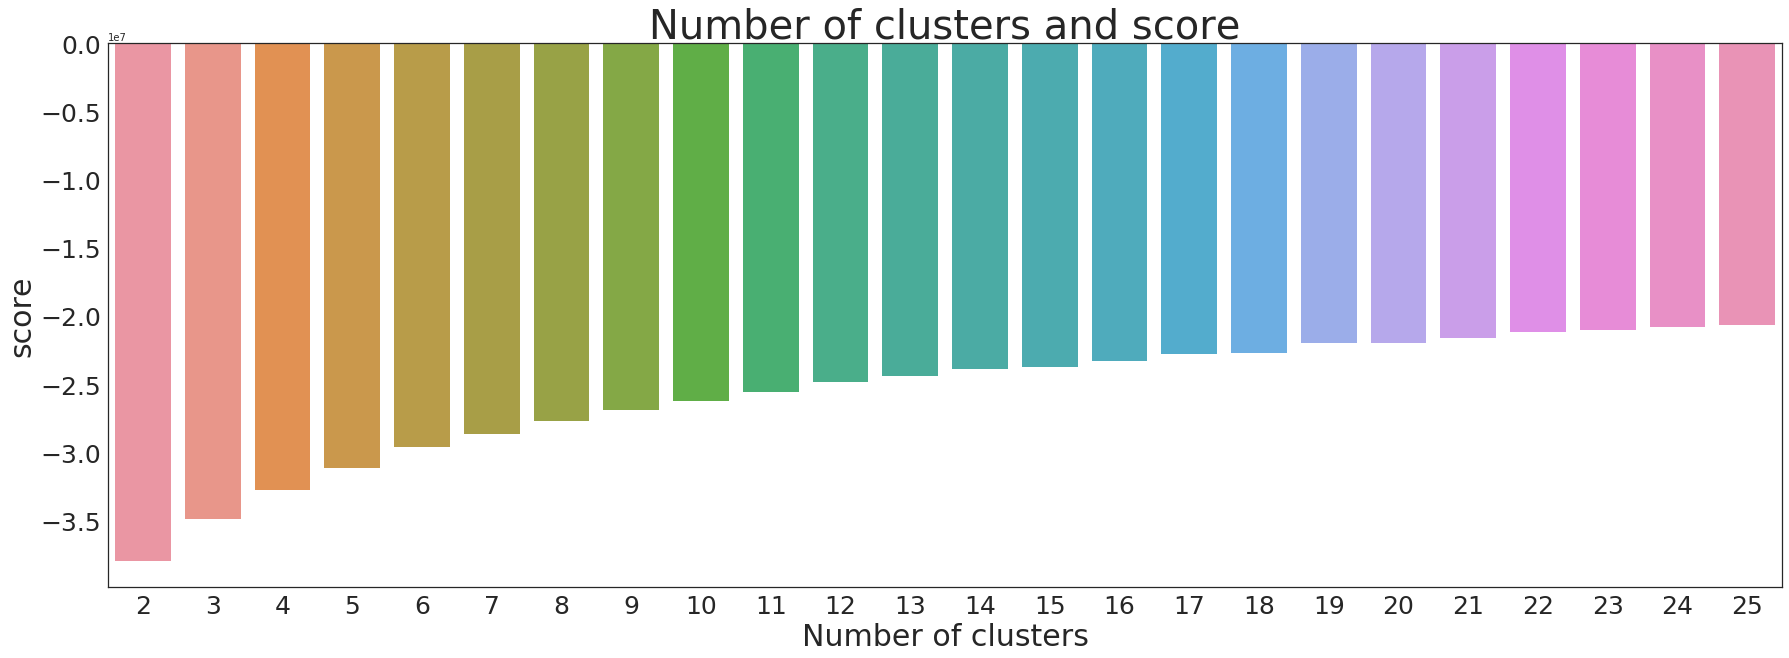

--- Run time: 75.23 mins ---


In [236]:
# this took 75-90 mins to run
# my understanding is here is how k means run time increases: if you add 10 more rows, it increases by 100 units(??)
# if you increase rows by 10 times, run time will increase by 100 times(?)
# maybe they meant computation complexity
# no, it doesn't look like it here. I increased data x4 (took all data), run time increased by 3 times.
# Using all the data
# Definitely do NOT rerun it again, if you decide to re-run the whole project :) 
choose_k(X_pca,k_min=2,k_max=25)

In [237]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_10 = KMeans(n_clusters = 10, random_state=42)

model_10 = kmeans_10.fit(X_pca)

clusters_general = model_10.predict(X_pca)

In [238]:
kmeans_10

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [239]:
model_10

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [240]:
clusters_general

array([3, 7, 8, ..., 2, 9, 6], dtype=int32)

In [241]:
len(clusters_general)

798067

In [242]:
# This number is the same as when i ran choose_k(X_pca,k_min=2,k_max=25) on k = 10
score_10 = model_10.score(X_pca)
score_10

-26240156.095346279

In [243]:
clusters = pd.DataFrame ({'clusters_general' : clusters_general})
clusters

clusters_general
0                      3
1                      7
2                      8
3                      6
4                      2
5                      2
6                      0
7                      7
8                      7
9                      5
10                     4
11                     2
12                     5
13                     2
14                     2
15                     7
16                     2
17                     9
18                     9
19                     7
20                     0
21                     4
22                     7
23                     4
24                     7
25                     3
26                     0
27                     1
28                     7
29                     5
30                     4
31                     2
32                     7
33                     8
34                     2
35                     2
36                     2
37                     8
38                     8
39                     7
40                     0
41                     4
42                     0
43                     3
44                     5
45                     0
46                     3
47                     2
48                     9
49                     6
50                     9
51                     3
52                     5
53                     9
54                     4
55                     8
56                     7
57                     5
58                     5
59                     8
60                     1
61                     8
62                     0
63                     9
64                     2
65                     3
66                     6
67                     8
68                     8
69                     7
70                     2
71                     0
72                     7
73                     2
74                     6
75                     8
76                     0
77                     9
78                     0
79                     7
80                     8
81                     4
82                     6
83                     7
84                     1
85                     9
86                     5
87                     7
88                     4
89                     7
90                     4
91                     0
92                     6
93                     5
94                     8
95                     7
96                     2
97                     0
98                     7
99                     5
...                  ...
797967                 5
797968                 3
797969                 7
797970                 8
797971                 5
797972                 4
797973                 5
797974                 3
797975                 0
797976                 8
797977                 1
797978                 2
797979                 4
797980                 3
797981                 8
797982                 3
797983                 7
797984                 2
797985                 0
797986                 7
797987                 6
797988                 6
797989                 1
797990                 2
797991                 1
797992                 1
797993                 1
797994                 1
797995                 0
797996                 5
797997                 6
797998                 2
797999                 1
798000                 5
798001                 8
798002                 5
798003                 6
798004                 8
798005                 1
798006                 4
798007                 2
798008                 8
798009                 7
798010                 0
798011                 7
798012                 3
798013                 5
798014                 6
798015                 4
798016                 7
798017                 7
798018                 7
798019                 4
798020                 0
798021                 2
798022                 6
798023                 4
798024                 2
798025  

In [244]:
clusters['clusters_general'].value_counts().sort_index()

0     63235
1     61591
2     84570
3     75084
4     88195
5     88080
6     86591
7    109102
8     82741
9     58878
Name: clusters_general, dtype: int64

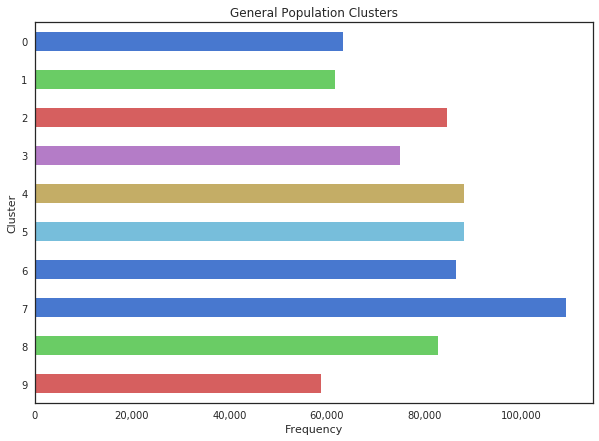

In [245]:
fig, ax = plt.subplots(1, 1,figsize=(10, 7))
clusters['clusters_general'].value_counts().sort_index().plot('barh').invert_yaxis() 

# title and axis labels
plt.title('General Population Clusters')
ax.set_ylabel('Cluster')
ax.set_xlabel('Frequency')

# commas for x axis 
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

plt.show()  

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

The number of clusters should be manageable for the marketing campaign purposes and easily explainable to stakeholder and CEO. Therefore, clusters more than 10 are not recommended (although it depends on how the clusters would be used). For day to day marketing operations, up to 10 is okay, more than 10 gets too granular and hard to manage. It's not feasible to have more than 10 marketing approaches.

Somewhat arbitrarily, I'll go with 10 clusters. 

I do not see an obvious elbow, but after 10 clusters I do not observe a very big improvement in score. Under 10, especially under 7, there is a big improvement in score. 

I also ran K-means with 2 to 25 clusters on only 25% of data vs on all data. The relationship between k and score is approximately the same in both runs (subset vs all data), as see in the graph. So it appears that for this dataset, if you want to choose k, you can just run k means on a subset. 

Cluster 7 is the biggest.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [246]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

### Apply preprocessing, feature transformation, and clustering from the general  demographics 
### onto the customer data, obtaining cluster predictions for the customer demographics data.

In [247]:
customers.shape

(191652, 85)

In [248]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [249]:
customers.head(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1          5.000   
1        -1                     4          1            nan   
2        -1                     4          2          2.000   
3         1                     4          1          2.000   
4        -1                     3          1          6.000   
5         1                     3          1          4.000   
6         2                     4          1          2.000   
7         1                     4          1          2.000   
8         2                     4          2          1.000   
9         1                     3          1          3.000   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   
5                  5              1                 5               1   
6                  5              1                 5               1   
7                  5              1                 5               1   
8                  2              2                 5               1   
9                  5              2                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      2                 2          2            0   
1                      3                 2          2            0   
2                      4                 4          2            0   
3                      1                 2          6            0   
4                      5                 2          2         1960   
5                      2                 3          5            0   
6                      1                 2          2         1942   
7                      2                 2          5         1938   
8                      1                 5          5         1914   
9                      3                 1          2         1959   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0            4.000                 1           1               20.000   
1              nan                 0           1                  nan   
2            3.000                 1           2               13.000   
3           10.000                 0           2                0.000   
4            2.000                 0           3               31.000   
5           11.000                 1           3               17.000   
6           10.000                 1           2               20.000   
7            8.000                 1           1               20.000   
8            3.000                 0           2                6.000   
9            1.000                 1           3               28.000   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                5.000            2.000            2.000          10.000   
1                  nan              nan              nan             nan   
2                3.000            1.000            1.000          10.000   
3                0.000            0.000            0.000           9.000   
4               10.000           10.000            5.000           1.000   
5                5.000            2.000            2.000           7.000   
6                5.000            2.000            2.000          10.000   
7                5.000            2.000            2.000          10.000   
8                2.000            1.000            1.000           1.000   
9                8.000            8.000            4.000          10.000   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0           5.0

In [250]:
customers.tail(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
191642         2                     4          2          2.000   
191643         2                     4          1          5.000   
191644         2                     4          2          6.000   
191645         2                     4          1          5.000   
191646         3                     2          2          2.000   
191647         1                     3          1          4.000   
191648        -1                     4          2          2.000   
191649         2                     4          1          2.000   
191650         3                     3          2          4.000   
191651         3                     2          1          2.000   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
191642                  2              1                 5               2   
191643                  5              1                 5               1   
191644                  2              1                 5               1   
191645                  5              1                 5               1   
191646                  2              1                 5               1   
191647                  5              1                 5               1   
191648                  5              1                 5               2   
191649                  5              1                 5               1   
191650                  2              1                 5               1   
191651                  5              1                 5               1   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
191642                      1                 5          6         1937   
191643                      3                 2          5         1947   
191644                      2                 5          5         1956   
191645                      3                 2          5         1955   
191646                      2                 5          5         1957   
191647                      1                 2          5            0   
191648                      2                 3          2            0   
191649                      1                 2          5         1944   
191650                      2                 5          2            0   
191651                      1                 2          6         1937   

        GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
191642            4.000                 0           1                6.000   
191643           11.000                 1           2               40.000   
191644            3.000                 1           2               32.000   
191645           11.000                 0           3               36.000   
191646           11.000                 0           2                5.000   
191647            3.000                 1           3                9.000   
191648           12.000                 0           2                0.000   
191649            7.000                 1           2               40.000   
191650            8.000                 0           2               32.000   
191651            1.000                 0           2               38.000   

        LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
191642                2.000            1.000            1.000           1.000   
191643               12.000           11.000            5.000          10.000   
191644               10.000            9.000            5.000           3.000   
191645               12.000           11.000            5.000           6.000   
191646                2.000            1.000            1.000           1.000   
191647                3.000            1.000            1.000           7.000   
191648                0.000            0.000            0.000           9.000   
191649               12.000           10.000            5.000      

In [251]:
# clean and encode
customers_cleaned_encoded = clean_data(customers)

Threshold of missing rows in the row:  30

Total nrow: 191652

Few Missing Values. Will be kept.
141725

Lots of Missing Values. Will be deleted
49927

% of rows with lots of missing values. % of data deleted 
0.260508630226
{40: [1, 2], 50: [3, 4], 60: [5, 6, 7], 70: [8, 9], 80: [10, 11, 12, 13], 90: [14, 15]}
PRAEGENDE_JUGENDJAHRE_DECADE     40     50     60     70    80    90
PRAEGENDE_JUGENDJAHRE                                               
1.000                          9931      0      0      0     0     0
2.000                         11316      0      0      0     0     0
3.000                             0  19534      0      0     0     0
4.000                             0  22216      0      0     0     0
5.000                             0      0  17167      0     0     0
6.000                             0      0  15457      0     0     0
7.000                             0      0    864      0     0     0
8.000                             0      0      0  14217     0    

In [252]:
customers_cleaned_encoded.shape

(141725, 70)

In [253]:
customers_cleaned_encoded.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                 4.000      1.000              5.000          1.000   
2                 4.000      2.000              5.000          1.000   
3                 4.000      1.000              5.000          1.000   
4                 3.000      1.000              3.000          1.000   
5                 3.000      1.000              5.000          1.000   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0             5.000           1.000                  2.000             2.000   
2             5.000           1.000                  4.000             4.000   
3             5.000           2.000                  1.000             2.000   
4             4.000           4.000                  5.000             2.000   
5             5.000           1.000                  2.000             3.000   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0             1.000       1.000           5.000      6.000      5.000   
2             1.000       2.000           5.000      2.000      2.000   
3             0.000       2.000           3.000      6.000      5.000   
4             0.000       3.000           5.000      4.000      5.000   
5             1.000       3.000           3.000      6.000      4.000   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0      2.000      6.000       6.000       7.000      3.000       4.000   
2      1.000      3.000       3.000       7.000      7.000       1.000   
3      3.000      4.000       7.000       5.000      3.000       4.000   
4      4.000      6.000       5.000       6.000      4.000       5.000   
5      4.000      1.000       7.000       6.000      4.000       6.000   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0      1.000       3.000      1.000       1.000          2.000        1.000   
2      2.000       7.000      5.000       6.000          4.000        1.000   
3      3.000       3.000      3.000       3.000          3.000        4.000   
4      5.000       3.000      5.000       2.000          5.000        4.000   
5      2.000       5.000      5.000       3.000          3.000        4.000   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0    0.000     1.000         2.000      0.000               1.000   
2    0.000     2.000         1.000      0.000               1.000   
3    0.000     1.000         0.000      0.000               4.000   
4    0.000     2.000         4.000      0.000               6.000   
5    0.000     2.000         2.000      0.000               1.000   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0           6.000           9.000                1.000         0.000   
2           6.000           9.000                1.000         0.000   
3             nan           9.000                  nan           nan   
4           2.000           9.000                7.000         0.000   
5           6.000           9.000                1.000         0.000   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
0        5.000          1992.000        2.000        2.000        0.000   
2        1.000          1992.000        2.000        2.000        0.000   
3        2.000          1992.000        3.000        0.000        0.000   
4        1.000          1992.000        0.000        3.000        2.000   
5        2.000          1992.000        2.000        2.000        1.000   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
0        0.000      4.000     3.000     2.000       4.000               4.000   
2        0.000      3.000     7.000     4.000       1.000               3.000   
3        0.000      4.000     7.000     1.000       7.000               4.000   
4        0.000      3.000     3.000     4.000       4.000               3.000   
5        0.000      3.000 

###### 10% of data in the general population was dropped due to lots (>30) of missing values in rows. 25% of customers data was dropped. This is important to note. What does it mean? Does it mean we know less about our customers than on avg about the general population?

###### Our assumption was that customers data is sort of like general population data. The proportion of rows with large amount of NANs is one thing I've found how they're different. There may be more differences.

In [254]:
customers_cleaned_encoded.isnull().sum()

ALTERSKATEGORIE_GROB                           233
ANREDE_KZ                                        0
FINANZ_MINIMALIST                                0
FINANZ_SPARER                                    0
FINANZ_VORSORGER                                 0
FINANZ_ANLEGER                                   0
FINANZ_UNAUFFAELLIGER                            0
FINANZ_HAUSBAUER                                 0
GREEN_AVANTGARDE                                 0
HEALTH_TYP                                    2339
RETOURTYP_BK_S                                3124
SEMIO_SOZ                                        0
SEMIO_FAM                                        0
SEMIO_REL                                        0
SEMIO_MAT                                        0
SEMIO_VERT                                       0
SEMIO_LUST                                       0
SEMIO_ERL                                        0
SEMIO_KULT                                       0
SEMIO_RAT                      

In [255]:
# number of columns with missing values
# this number was 34 for azdias as far as i remember
customers_cleaned_encoded.isnull().any().sum()

33

In [256]:
# Imputer produces an array, not a dataframe. I'll lose my columns I'll need to rebuild the df.
# So I need to save my column names
columns_list_customers = list(customers_cleaned_encoded.columns)
columns_list_customers

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'OST_WEST_KZ_O',
 'PRAEGENDE_

In [257]:
# impute
customers_cleaned_encoded_imputed = imputer.transform(customers_cleaned_encoded)

print(type(customers_cleaned_encoded_imputed))

customers_cleaned_encoded_imputed = pd.DataFrame(customers_cleaned_encoded_imputed,columns=columns_list_customers)

print(type(customers_cleaned_encoded_imputed))

customers_cleaned_encoded_imputed.head()

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                 4.000      1.000              5.000          1.000   
1                 4.000      2.000              5.000          1.000   
2                 4.000      1.000              5.000          1.000   
3                 3.000      1.000              3.000          1.000   
4                 3.000      1.000              5.000          1.000   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0             5.000           1.000                  2.000             2.000   
1             5.000           1.000                  4.000             4.000   
2             5.000           2.000                  1.000             2.000   
3             4.000           4.000                  5.000             2.000   
4             5.000           1.000                  2.000             3.000   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0             1.000       1.000           5.000      6.000      5.000   
1             1.000       2.000           5.000      2.000      2.000   
2             0.000       2.000           3.000      6.000      5.000   
3             0.000       3.000           5.000      4.000      5.000   
4             1.000       3.000           3.000      6.000      4.000   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0      2.000      6.000       6.000       7.000      3.000       4.000   
1      1.000      3.000       3.000       7.000      7.000       1.000   
2      3.000      4.000       7.000       5.000      3.000       4.000   
3      4.000      6.000       5.000       6.000      4.000       5.000   
4      4.000      1.000       7.000       6.000      4.000       6.000   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0      1.000       3.000      1.000       1.000          2.000        1.000   
1      2.000       7.000      5.000       6.000          4.000        1.000   
2      3.000       3.000      3.000       3.000          3.000        4.000   
3      5.000       3.000      5.000       2.000          5.000        4.000   
4      2.000       5.000      5.000       3.000          3.000        4.000   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0    0.000     1.000         2.000      0.000               1.000   
1    0.000     2.000         1.000      0.000               1.000   
2    0.000     1.000         0.000      0.000               4.000   
3    0.000     2.000         4.000      0.000               6.000   
4    0.000     2.000         2.000      0.000               1.000   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0           6.000           9.000                1.000         0.000   
1           6.000           9.000                1.000         0.000   
2           6.000           9.000                1.000         0.000   
3           2.000           9.000                7.000         0.000   
4           6.000           9.000                1.000         0.000   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
0        5.000          1992.000        2.000        2.000        0.000   
1        1.000          1992.000        2.000        2.000        0.000   
2        2.000          1992.000        3.000        0.000        0.000   
3        1.000          1992.000        0.000        3.000        2.000   
4        2.000          1992.000        2.000        2.000        1.000   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
0        0.000      4.000     3.000     2.000       4.000               4.000   
1        0.000      3.000     7.000     4.000       1.000               3.000   
2        0.000      4.000     7.000     1.000       7.000               4.000   
3        0.000      3.000     3.000     4.000       4.000               3.000   
4        0.000      3.000 

In [258]:
# we now should have no NANs
customers_cleaned_encoded_imputed.isnull().any().sum()

0

In [259]:
customers_cleaned_encoded_imputed.isnull().sum()

ALTERSKATEGORIE_GROB                         0
ANREDE_KZ                                    0
FINANZ_MINIMALIST                            0
FINANZ_SPARER                                0
FINANZ_VORSORGER                             0
FINANZ_ANLEGER                               0
FINANZ_UNAUFFAELLIGER                        0
FINANZ_HAUSBAUER                             0
GREEN_AVANTGARDE                             0
HEALTH_TYP                                   0
RETOURTYP_BK_S                               0
SEMIO_SOZ                                    0
SEMIO_FAM                                    0
SEMIO_REL                                    0
SEMIO_MAT                                    0
SEMIO_VERT                                   0
SEMIO_LUST                                   0
SEMIO_ERL                                    0
SEMIO_KULT                                   0
SEMIO_RAT                                    0
SEMIO_KRIT                                   0
SEMIO_DOM    

In [260]:
# checking how mode imputation worked

print(customers_cleaned_encoded['KKK'].isna().sum())
print(customers_cleaned_encoded['KKK'].value_counts())

print(customers_cleaned_encoded_imputed['KKK'].isna().sum())
print(customers_cleaned_encoded_imputed['KKK'].value_counts())

10137
3.000    40739
2.000    40049
1.000    28850
4.000    21950
Name: KKK, dtype: int64
0
3.000    50876
2.000    40049
1.000    28850
4.000    21950
Name: KKK, dtype: int64


In [261]:
# 'KKK'
# 10137+40739 = 50876
10137+40739

50876

In [262]:
# checking how mode imputation worked

print(customers_cleaned_encoded['ALTERSKATEGORIE_GROB'].isna().sum())
print(customers_cleaned_encoded['ALTERSKATEGORIE_GROB'].value_counts())

print(customers_cleaned_encoded_imputed['ALTERSKATEGORIE_GROB'].isna().sum())
print(customers_cleaned_encoded_imputed['ALTERSKATEGORIE_GROB'].value_counts())

233
4.000    83996
3.000    47377
2.000     5153
1.000     4966
Name: ALTERSKATEGORIE_GROB, dtype: int64
0
4.000    83996
3.000    47610
2.000     5153
1.000     4966
Name: ALTERSKATEGORIE_GROB, dtype: int64


##### We didn't refit the imputer to customers data. So ALTERSKATEGORIE_GROB were imputed with not 4, mode for customers, but 3, mode for general population. Now I understand better what they meant by the following

I use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a .fit() or .fit_transform() method to re-fit the old objects, nor should we be creating new sklearn objects! We should carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [263]:
233 + 47377

47610

In [264]:
azdias_cleaned_encoded.ALTERSKATEGORIE_GROB.value_counts()

3.000    310466
4.000    223265
2.000    137100
1.000    124433
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [265]:
customers_cleaned_encoded.ALTERSKATEGORIE_GROB.value_counts()

4.000    83996
3.000    47377
2.000     5153
1.000     4966
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [266]:
# scale

customers_scaled = scaler.transform(customers_cleaned_encoded_imputed)

print(type(customers_scaled))

customers_scaled = pd.DataFrame(customers_scaled, columns=columns_list_customers)

print(type(customers_scaled))

customers_scaled.head()

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                 1.184     -1.044              1.409         -1.156   
1                 1.184      0.958              1.409         -1.156   
2                 1.184     -1.044              1.409         -1.156   
3                 0.201     -1.044             -0.043         -1.156   
4                 0.201     -1.044              1.409         -1.156   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0             1.138          -1.250                 -0.470            -0.791   
1             1.138          -1.250                  0.959             0.629   
2             1.138          -0.571                 -1.185            -0.791   
3             0.412           0.787                  1.673            -0.791   
4             1.138          -1.250                 -0.470            -0.081   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0             1.885      -1.634           1.064      0.958      0.463   
1             1.885      -0.312           1.064     -1.102     -1.104   
2            -0.530      -0.312          -0.311      0.958      0.463   
3            -0.530       1.010           1.064     -0.072      0.463   
4             1.885       1.010          -0.311      0.958     -0.059   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0     -1.044      1.104       0.885       1.268     -0.888      -0.067   
1     -1.567     -0.464      -0.657       1.268      1.302      -1.600   
2     -0.521      0.059       1.399       0.317     -0.888      -0.067   
3      0.003      1.104       0.371       0.792     -0.341       0.443   
4      0.003     -1.509       1.399       0.792     -0.341       0.954   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0     -1.751      -0.880     -1.946      -1.764         -1.178       -1.543   
1     -1.146       1.392      0.244       0.913         -0.100       -1.543   
2     -0.541      -0.880     -0.851      -0.693         -0.639        0.156   
3      0.669      -0.880      0.244      -1.228          0.440        0.156   
4     -1.146       0.256      0.244      -0.693         -0.639        0.156   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0   -0.092    -1.083         0.234     -0.060              -2.209   
1   -0.092     0.923        -0.630     -0.060              -2.209   
2   -0.092    -1.083        -1.495     -0.060              -0.268   
3   -0.092     0.923         1.964     -0.060               1.027   
4   -0.092     0.923         0.234     -0.060              -2.209   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0           0.957           0.567               -0.467        -0.125   
1           0.957           0.567               -0.467        -0.125   
2           0.957           0.567               -0.467        -0.125   
3          -1.293           0.567               -0.083        -0.125   
4           0.957           0.567               -0.467        -0.125   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
0        1.275            -0.383        0.413        0.641       -0.595   
1       -1.305            -0.383        0.413        0.641       -0.595   
2       -0.660            -0.383        1.124       -0.966       -0.595   
3       -1.305            -0.383       -1.009        1.445        1.411   
4       -0.660            -0.383        0.413        0.641        0.408   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
0       -0.464      0.655    -0.529    -1.129      -0.271               0.283   
1       -0.464     -0.116     1.303     0.034      -1.750              -0.800   
2       -0.464      0.655     1.303    -1.710       1.208               0.283   
3       -0.464     -0.116    -0.529     0.034      -0.271              -0.800   
4       -0.464     -0.116 

In [267]:
customers_cleaned_encoded_imputed.describe().transpose()

count     mean     std  \
ALTERSKATEGORIE_GROB                      141725.000    3.486   0.730   
ANREDE_KZ                                 141725.000    1.331   0.470   
FINANZ_MINIMALIST                         141725.000    4.264   1.018   
FINANZ_SPARER                             141725.000    1.431   0.834   
FINANZ_VORSORGER                          141725.000    4.563   0.846   
FINANZ_ANLEGER                            141725.000    1.602   1.003   
FINANZ_UNAUFFAELLIGER                     141725.000    1.866   0.979   
FINANZ_HAUSBAUER                          141725.000    2.728   1.317   
GREEN_AVANTGARDE                          141725.000    0.497   0.500   
HEALTH_TYP                                141725.000    1.979   0.778   
RETOURTYP_BK_S                            141725.000    3.941   1.183   
SEMIO_SOZ                                 141725.000    4.328   1.619   
SEMIO_FAM                                 141725.000    3.894   1.683   
SEMIO_REL                                 141725.000    3.188   1.460   
SEMIO_MAT                                 141725.000    3.488   1.982   
SEMIO_VERT                                141725.000    5.194   1.761   
SEMIO_LUST                                141725.000    5.516   1.635   
SEMIO_ERL                                 141725.000    4.871   1.752   
SEMIO_KULT                                141725.000    3.913   1.753   
SEMIO_RAT                                 141725.000    2.889   1.401   
SEMIO_KRIT                                141725.000    3.915   1.779   
SEMIO_DOM                                 141725.000    4.000   1.592   
SEMIO_KAEM                                141725.000    3.598   1.794   
SEMIO_PFLICHT                             141725.000    3.031   1.432   
SEMIO_TRADV                               141725.000    2.907   1.393   
SOHO_KZ                                   141725.000    0.010   0.099   
VERS_TYP                                  141725.000    1.502   0.500   
ANZ_PERSONEN                              141725.000    2.269   1.391   
ANZ_TITEL                                 141725.000    0.020   0.152   
HH_EINKOMMEN_SCORE                        141725.000    3.254   1.655   
W_KEIT_KIND_HH                            141725.000    4.366   1.873   
WOHNDAUER_2008                            141725.000    8.647   1.153   
ANZ_HAUSHALTE_AKTIV                       141725.000    4.983  14.304   
ANZ_HH_TITEL                              141725.000    0.066   0.541   
KONSUMNAEHE                               141725.000    3.138   1.440   
MIN_GEBAEUDEJAHR                          141725.000 1993.057   3.080   
KBA05_ANTG1                               141725.000    2.113   1.425   
KBA05_ANTG2                               141725.000    1.157   1.091   
KBA05_ANTG3                               141725.000    0.297   0.751   
KBA05_ANTG4                               141725.000    0.147   0.468   
KBA05_GBZ                                 141725.000    3.604   1.150   
BALLRAUM                                  141725.000    4.302   2.115   
EWDICHTE                                  141725.000    3.882   1.608   
INNENSTADT                                141725.000    4.785   1.961   
GEBAEUDETYP_RASTER                        141725.000    3.853   0.830   
KKK                                       141725.000    2.465   0.983   
MOBI_REGIO                                141725.000    3.515   1.363   
ONLINE_AFFINITAET                         141725.000    2.997   1.352   
REGIOTYP                                  141725.000    4.127   1.955   
KBA13_ANZAHL_PKW                          141725.000  674.232 346.267   
PLZ8_ANTG1                                141725.000    2.527   0.899   
PLZ8_ANTG2                                141725.000    2.737   0.833   
PLZ8_ANTG3                                141725.000    1.401   0.880   
PLZ8_ANTG4                                141725.000    0.529   0.635   
PLZ8_HHZ                        

In [268]:
# notice how scaling didn't do its job here
customers_scaled.describe().transpose()

count   mean   std    min  \
ALTERSKATEGORIE_GROB                      141725.000  0.679 0.718 -1.767   
ANREDE_KZ                                 141725.000 -0.382 0.942 -1.044   
FINANZ_MINIMALIST                         141725.000  0.875 0.739 -1.495   
FINANZ_SPARER                             141725.000 -0.865 0.562 -1.156   
FINANZ_VORSORGER                          141725.000  0.821 0.615 -1.767   
FINANZ_ANLEGER                            141725.000 -0.841 0.681 -1.250   
FINANZ_UNAUFFAELLIGER                     141725.000 -0.566 0.699 -1.185   
FINANZ_HAUSBAUER                          141725.000 -0.274 0.935 -1.501   
GREEN_AVANTGARDE                          141725.000  0.669 1.208 -0.530   
HEALTH_TYP                                141725.000 -0.339 1.028 -1.634   
RETOURTYP_BK_S                            141725.000  0.336 0.813 -1.685   
SEMIO_SOZ                                 141725.000  0.097 0.834 -1.618   
SEMIO_FAM                                 141725.000 -0.115 0.880 -1.627   
SEMIO_REL                                 141725.000 -0.422 0.764 -1.567   
SEMIO_MAT                                 141725.000 -0.209 1.036 -1.509   
SEMIO_VERT                                141725.000  0.471 0.905 -1.685   
SEMIO_LUST                                141725.000  0.562 0.777 -1.585   
SEMIO_ERL                                 141725.000  0.136 0.959 -1.983   
SEMIO_KULT                                141725.000 -0.112 0.895 -1.600   
SEMIO_RAT                                 141725.000 -0.608 0.848 -1.751   
SEMIO_KRIT                                141725.000 -0.360 1.011 -2.016   
SEMIO_DOM                                 141725.000 -0.303 0.872 -1.946   
SEMIO_KAEM                                141725.000 -0.373 0.960 -1.764   
SEMIO_PFLICHT                             141725.000 -0.622 0.772 -1.718   
SEMIO_TRADV                               141725.000 -0.463 0.789 -1.543   
SOHO_KZ                                   141725.000  0.016 1.081 -0.092   
VERS_TYP                                  141725.000 -0.077 1.003 -1.083   
ANZ_PERSONEN                              141725.000  0.467 1.203 -1.495   
ANZ_TITEL                                 141725.000  0.235 2.210 -0.060   
HH_EINKOMMEN_SCORE                        141725.000 -0.750 1.071 -2.209   
W_KEIT_KIND_HH                            141725.000  0.038 1.054 -1.855   
WOHNDAUER_2008                            141725.000  0.384 0.599 -3.593   
ANZ_HAUSHALTE_AKTIV                       141725.000 -0.212 0.916 -0.467   
ANZ_HH_TITEL                              141725.000  0.080 1.675 -0.125   
KONSUMNAEHE                               141725.000  0.074 0.929 -1.305   
MIN_GEBAEUDEJAHR                          141725.000 -0.066 0.924 -2.484   
KBA05_ANTG1                               141725.000  0.493 1.013 -1.009   
KBA05_ANTG2                               141725.000 -0.036 0.876 -0.966   
KBA05_ANTG3                               141725.000 -0.297 0.754 -0.595   
KBA05_ANTG4                               141725.000 -0.230 0.747 -0.464   
KBA05_GBZ                                 141725.000  0.349 0.887 -1.659   
BALLRAUM                                  141725.000  0.068 0.968 -1.445   
EWDICHTE                                  141725.000 -0.034 0.935 -1.710   
INNENSTADT                                141725.000  0.116 0.967 -1.750   
GEBAEUDETYP_RASTER                        141725.000  0.124 0.899 -2.966   
KKK                                       141725.000 -0.298 1.043 -1.853   
MOBI_REGIO                                141725.000  0.446 0.935 -1.280   
ONLINE_AFFINITAET                         141725.000  0.165 0.870 -1.763   
REGIOTYP                                  141725.000 -0.260 1.081 -1.988   
KBA13_ANZAHL_PKW                          141725.000  0.120 0.986 -1.786   
PLZ8_ANTG1                                141725.000  0.293 0.938 -2.343   
PLZ8_ANTG2                                141725.000 -0.078 0.918 -3.094   
PLZ8_ANTG3         

I know we were told to NOT use fit_transform. 

However, the idea behind StandardScaler is to normalize variables so they have a mean of 0 and stdev of 1. 

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler

**If I just use transform without fitting, this doesn't work on customer data, it doesn't get properly normalized to mean of 0 and stdev of 1.**

I will diverge from the instructions here and refit the existing scaler to the customer data, so it's normalized properly. Or else I'm worried k-means won't work correctly.

I get the idea is to build a pipeline and to run customer data thru the pipeline, but I'm concerned by the fact that scaling doesn't appear to have worked properly in this case for customers data. 

I will still run K-means after "transform" or "fit_transform" and see if clusters are affected by it.

Customer data did get closer to 0 and 1 though after scaling it with general population scaler.

In [269]:
# this code is just like the one a few cells above, 
# but I"m re-fitting scaler to customer data to normalize it to mean of 0 and stdev of 1
# scale

"""
customers_scaled was obtained thru transform (using general population scaler)
customers_scaled_1 was obtained thru fit_transform (using customer scaler)
"""

customers_scaled_1 = scaler.fit_transform(customers_cleaned_encoded_imputed)

print(type(customers_scaled_1))

customers_scaled_1 = pd.DataFrame(customers_scaled_1, columns=columns_list_customers)

print(type(customers_scaled_1))

customers_scaled_1.head()

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                 0.704     -0.703              0.723         -0.517   
1                 0.704      1.423              0.723         -0.517   
2                 0.704     -0.703              0.723         -0.517   
3                -0.666     -0.703             -1.241         -0.517   
4                -0.666     -0.703              0.723         -0.517   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0             0.516          -0.601                  0.137            -0.553   
1             0.516          -0.601                  2.181             0.966   
2             0.516           0.397                 -0.885            -0.553   
3            -0.665           2.392                  3.202            -0.553   
4             0.516          -0.601                  0.137             0.206   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0             1.007      -1.259           0.895      1.033      0.657   
1             1.007       0.027           0.895     -1.438     -1.125   
2            -0.993       0.027          -0.796      1.033      0.657   
3            -0.993       1.312           0.895     -0.202      0.657   
4             1.007       1.312          -0.796      1.033      0.063   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0     -0.814      1.267       0.458       0.908     -1.068       0.049   
1     -1.499     -0.246      -1.246       0.908      1.215      -1.662   
2     -0.129      0.258       1.025      -0.316     -1.068       0.049   
3      0.556      1.267      -0.110       0.296     -0.497       0.620   
4      0.556     -1.255       1.025       0.296     -0.497       1.191   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0     -1.348      -0.514     -1.885      -1.449         -0.720       -1.369   
1     -0.635       1.734      0.628       1.339          0.677       -1.369   
2      0.079      -0.514     -0.628      -0.334         -0.022        0.785   
3      1.506      -0.514      0.628      -0.891          1.375        0.785   
4     -0.635       0.610      0.628      -0.334         -0.022        0.785   

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0   -0.100    -1.003        -0.193     -0.134              -1.362   
1   -0.100     0.997        -0.912     -0.134              -1.362   
2   -0.100    -1.003        -1.631     -0.134               0.451   
3   -0.100     0.997         1.244     -0.134               1.659   
4   -0.100     0.997        -0.193     -0.134              -1.362   

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0           0.872           0.306               -0.278        -0.123   
1           0.872           0.306               -0.278        -0.123   
2           0.872           0.306               -0.278        -0.123   
3          -1.263           0.306                0.141        -0.123   
4           0.872           0.306               -0.278        -0.123   

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  \
0        1.292            -0.343       -0.079        0.773       -0.395   
1       -1.484            -0.343       -0.079        0.773       -0.395   
2       -0.790            -0.343        0.622       -1.061       -0.395   
3       -1.484            -0.343       -1.482        1.690        2.267   
4       -0.790            -0.343       -0.079        0.773        0.936   

   KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  \
0       -0.314      0.345    -0.616    -1.171      -0.400               0.178   
1       -0.314     -0.525     1.276     0.073      -1.930              -1.027   
2       -0.314      0.345     1.276    -1.793       1.130               0.178   
3       -0.314     -0.525    -0.616     0.073      -0.400              -1.027   
4       -0.314     -0.525 

In [270]:
# now it's scaled nicely to mean of 0 and stdev of 1
customers_scaled_1.describe().transpose()

count   mean   std    min  \
ALTERSKATEGORIE_GROB                      141725.000  0.000 1.000 -3.406   
ANREDE_KZ                                 141725.000  0.000 1.000 -0.703   
FINANZ_MINIMALIST                         141725.000 -0.000 1.000 -3.206   
FINANZ_SPARER                             141725.000  0.000 1.000 -0.517   
FINANZ_VORSORGER                          141725.000  0.000 1.000 -4.210   
FINANZ_ANLEGER                            141725.000  0.000 1.000 -0.601   
FINANZ_UNAUFFAELLIGER                     141725.000  0.000 1.000 -0.885   
FINANZ_HAUSBAUER                          141725.000  0.000 1.000 -1.313   
GREEN_AVANTGARDE                          141725.000  0.000 1.000 -0.993   
HEALTH_TYP                                141725.000 -0.000 1.000 -1.259   
RETOURTYP_BK_S                            141725.000 -0.000 1.000 -2.486   
SEMIO_SOZ                                 141725.000 -0.000 1.000 -2.055   
SEMIO_FAM                                 141725.000 -0.000 1.000 -1.719   
SEMIO_REL                                 141725.000 -0.000 1.000 -1.499   
SEMIO_MAT                                 141725.000 -0.000 1.000 -1.255   
SEMIO_VERT                                141725.000  0.000 1.000 -2.382   
SEMIO_LUST                                141725.000  0.000 1.000 -2.763   
SEMIO_ERL                                 141725.000 -0.000 1.000 -2.209   
SEMIO_KULT                                141725.000  0.000 1.000 -1.662   
SEMIO_RAT                                 141725.000 -0.000 1.000 -1.348   
SEMIO_KRIT                                141725.000  0.000 1.000 -1.639   
SEMIO_DOM                                 141725.000 -0.000 1.000 -1.885   
SEMIO_KAEM                                141725.000 -0.000 1.000 -1.449   
SEMIO_PFLICHT                             141725.000 -0.000 1.000 -1.419   
SEMIO_TRADV                               141725.000 -0.000 1.000 -1.369   
SOHO_KZ                                   141725.000 -0.000 1.000 -0.100   
VERS_TYP                                  141725.000  0.000 1.000 -1.003   
ANZ_PERSONEN                              141725.000 -0.000 1.000 -1.631   
ANZ_TITEL                                 141725.000 -0.000 1.000 -0.134   
HH_EINKOMMEN_SCORE                        141725.000  0.000 1.000 -1.362   
W_KEIT_KIND_HH                            141725.000  0.000 1.000 -1.796   
WOHNDAUER_2008                            141725.000 -0.000 1.000 -6.635   
ANZ_HAUSHALTE_AKTIV                       141725.000 -0.000 1.000 -0.278   
ANZ_HH_TITEL                              141725.000 -0.000 1.000 -0.123   
KONSUMNAEHE                               141725.000 -0.000 1.000 -1.484   
MIN_GEBAEUDEJAHR                          141725.000 -0.000 1.000 -2.616   
KBA05_ANTG1                               141725.000  0.000 1.000 -1.482   
KBA05_ANTG2                               141725.000  0.000 1.000 -1.061   
KBA05_ANTG3                               141725.000  0.000 1.000 -0.395   
KBA05_ANTG4                               141725.000 -0.000 1.000 -0.314   
KBA05_GBZ                                 141725.000 -0.000 1.000 -2.263   
BALLRAUM                                  141725.000 -0.000 1.000 -1.562   
EWDICHTE                                  141725.000 -0.000 1.000 -1.793   
INNENSTADT                                141725.000 -0.000 1.000 -1.930   
GEBAEUDETYP_RASTER                        141725.000  0.000 1.000 -3.436   
KKK                                       141725.000  0.000 1.000 -1.491   
MOBI_REGIO                                141725.000  0.000 1.000 -1.846   
ONLINE_AFFINITAET                         141725.000  0.000 1.000 -2.216   
REGIOTYP                                  141725.000  0.000 1.000 -1.599   
KBA13_ANZAHL_PKW                          141725.000 -0.000 1.000 -1.933   
PLZ8_ANTG1                                141725.000 -0.000 1.000 -2.811   
PLZ8_ANTG2                                141725.000  0.000 1.000 -3.284   
PLZ8_ANTG3         

In [271]:
pca

PCA(copy=True, iterated_power='auto', n_components=23, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [272]:
def cluster_customer_data(my_customer_scaled_data, my_graph_title):
    """do PCA, k means prediction 
    data scaled with general population scaler with transform
    """
    # PCA
    customers_pca = pca.transform(my_customer_scaled_data)
    print(type(customers_pca))
    print()
    print('customers_pca')
    print(customers_pca)
    print()

    # predict with kmeans

    preds_customers = model_10.predict(customers_pca)
    print()
    print('preds_customers')
    print(preds_customers)
    print()

    # make a df with clusters
    clusters_customers = pd.DataFrame ({'clusters_customers' : preds_customers})
    print('clusters_customers')
    print(clusters_customers.head(30))

    print()
    print('clusters_customers summary')
    print(clusters_customers['clusters_customers'].value_counts().sort_index())


    #visualize
    fig, ax = plt.subplots(1, 1,figsize=(10, 7))
    clusters_customers['clusters_customers'].value_counts().sort_index().plot('barh').invert_yaxis() 

    # title and axis labels
    plt.title(my_graph_title)
    ax.set_ylabel('Cluster')
    ax.set_xlabel('Frequency')

    # commas for x axis 
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.xaxis.set_major_formatter(tick)

    plt.show()  
    
    return clusters_customers

<class 'numpy.ndarray'>

customers_pca
[[ -6.11349846e+00   1.26367633e+00   4.51624615e+00 ...,   5.82684947e-01
    6.68465743e-01  -2.87627831e-01]
 [ -9.85886812e-01   5.04474508e+00  -3.08658723e-01 ...,  -9.13001259e-01
   -8.52958642e-01  -5.54500696e-01]
 [ -4.62294421e+00   4.20880109e-01   2.46878937e+00 ...,  -7.95304746e-01
   -3.72791245e-01  -5.38535422e-03]
 ..., 
 [ -3.88545211e+00   3.16708754e+00   2.84906982e+00 ...,  -8.08336604e-01
   -2.26155234e-01   3.74865189e-02]
 [ -7.71574165e-01   2.85994775e+00  -1.94431550e+00 ...,  -4.49853496e-01
   -2.77239660e-01   1.22606848e-01]
 [ -4.27730615e+00  -2.68666526e+00   1.98565480e+00 ...,   7.98519018e-01
    9.33190636e-01  -5.50849392e-02]]


preds_customers
[7 7 4 ..., 7 8 4]

clusters_customers
    clusters_customers
0                    7
1                    7
2                    4
3                    6
4                    7
5                    7
6                    7
7                    1
8                

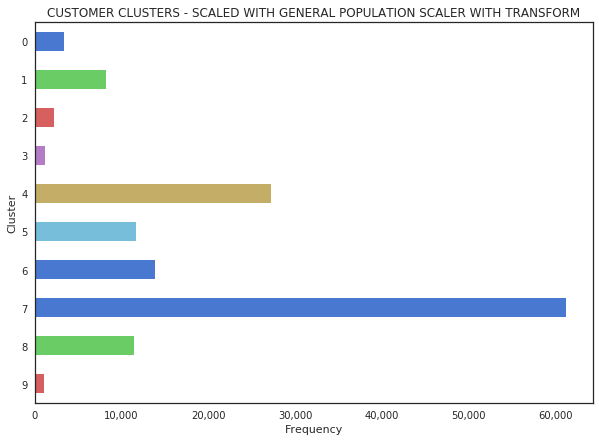

In [273]:
clusters_customers = cluster_customer_data(customers_scaled, 
                                           'CUSTOMER CLUSTERS - SCALED WITH GENERAL POPULATION SCALER WITH TRANSFORM')

<class 'numpy.ndarray'>

customers_pca
[[-4.23746511  0.16041729  3.26813252 ...,  0.67741733  0.75784593
  -0.43335095]
 [ 1.24245661  4.07498237 -2.05255157 ..., -1.00470502 -1.01046761
  -0.56929711]
 [-2.83842733 -0.95240616  1.11145631 ..., -0.66595892 -0.28169006
  -0.12803516]
 ..., 
 [-1.92260104  2.18188353  1.47168361 ..., -0.7474713  -0.32467245
  -0.01361919]
 [ 1.41360388  1.51919681 -3.77835715 ..., -0.28953571 -0.32031142
  -0.01535212]
 [-2.33839872 -4.69659083  0.57456595 ...,  0.94959892  1.21053172
  -0.25498035]]


preds_customers
[4 5 4 ..., 7 5 0]

clusters_customers
    clusters_customers
0                    4
1                    5
2                    4
3                    3
4                    6
5                    4
6                    7
7                    1
8                    0
9                    0
10                   4
11                   6
12                   5
13                   7
14                   7
15                   0
16           

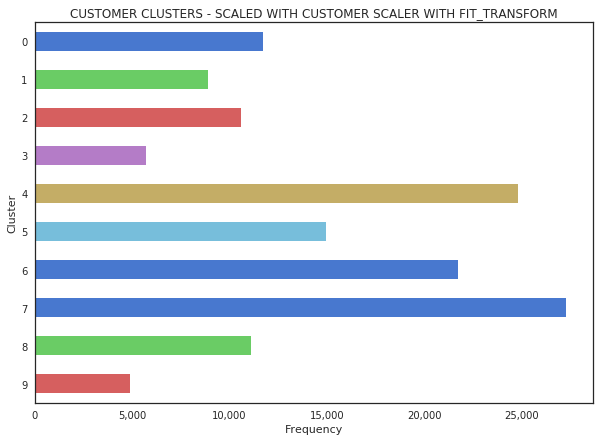

In [274]:
clusters_customers = cluster_customer_data(customers_scaled_1, 
                                           'CUSTOMER CLUSTERS - SCALED WITH CUSTOMER SCALER WITH FIT_TRANSFORM')

##### The below screenshot demonstrates how sensitive k means is to properly scaling the data. If the data is not correclty scaled, that changes the distances between points, affects clusters and produces a misleading result. I will go with the option on the right: scaling with fit_transform (contrary to what the task asked for). The results with fit_transform seem more conservative, less different from the general population. I believe the result on the left is not correct. It's produced by k means run on data which was not properly scaled to mean 0 and stdev 1 (because we didn't refit the scaler to customer data).

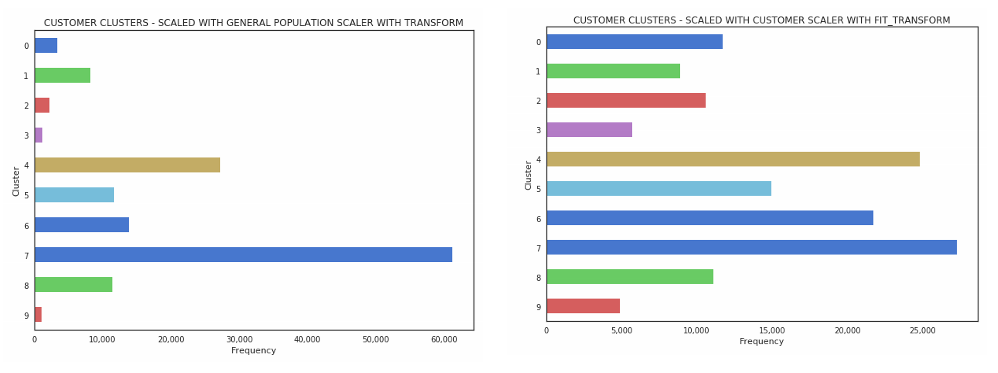

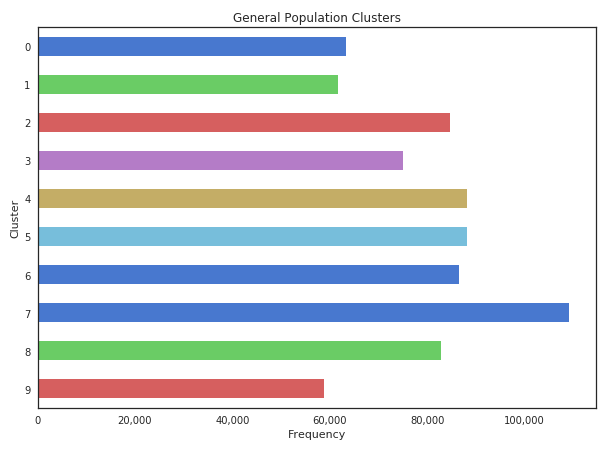

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [275]:
# this is just testing. Again, as described above, "transform" doesn't work well. "fit_transform" works fine


# keep this one commented out, dont use for analysis
# clusters_customers = cluster_customer_data(customers_scaled, 
#                                            'CUSTOMER CLUSTERS - SCALED WITH GENERAL POPULATION SCALER WITH TRANSFORM')

# use this one for analysis
# clusters_customers = cluster_customer_data(customers_scaled_1, 
#                                            'CUSTOMER CLUSTERS - SCALED WITH CUSTOMER SCALER WITH FIT_TRANSFORM')

In [276]:
# too many missing values in general population

print(len(azdias))
print(len(azdias_cleaned_encoded))
azdias_too_many_NA_in_rows = len(azdias) - len(azdias_cleaned_encoded)
print(azdias_too_many_NA_in_rows)

891221
798067
93154


In [277]:
# too many missing values in customers
print(len(customers))
print(len(customers_cleaned_encoded))
customers_too_many_NA_in_rows = len(customers) - len(customers_cleaned_encoded)
print(customers_too_many_NA_in_rows)

191652
141725
49927


In [278]:
# general pop clusters
summary_general = clusters['clusters_general'].value_counts().sort_index()
summary_general

0     63235
1     61591
2     84570
3     75084
4     88195
5     88080
6     86591
7    109102
8     82741
9     58878
Name: clusters_general, dtype: int64

In [279]:
# customer clusters
summary_customers = clusters_customers.clusters_customers.value_counts().sort_index()
summary_customers

0    11738
1     8880
2    10590
3     5742
4    24800
5    14979
6    21735
7    27279
8    11099
9     4883
Name: clusters_customers, dtype: int64

In [280]:
# create a dataframe with general population and customer clusters
# https://stackoverflow.com/questions/18062135/combining-two-series-into-a-dataframe-in-pandas
summary_comparison = pd.concat([summary_general, summary_customers], axis =1)
print(type(summary_comparison))
summary_comparison.reset_index(inplace=True)
summary_comparison.columns = ['cluster','general','customers']
summary_comparison

<class 'pandas.core.frame.DataFrame'>


cluster  general  customers
0        0    63235      11738
1        1    61591       8880
2        2    84570      10590
3        3    75084       5742
4        4    88195      24800
5        5    88080      14979
6        6    86591      21735
7        7   109102      27279
8        8    82741      11099
9        9    58878       4883

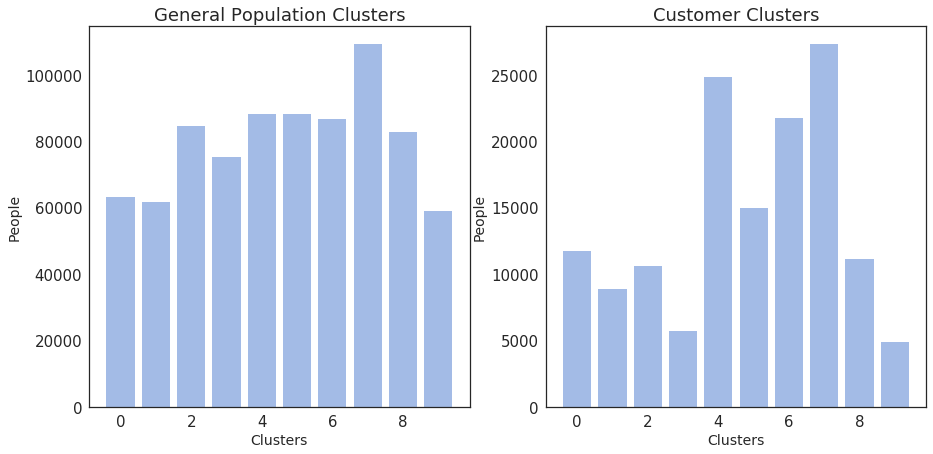

In [281]:
# visualize gen pop and cust clusters

fig, ax = plt.subplots(1, 2,figsize=(15, 7)) 

plt.subplot(1,2,1)  

plt.bar(summary_comparison['cluster'], summary_comparison['general'], align='center', alpha=0.5)

plt.xlabel('Clusters', fontsize=14)
plt.ylabel('People', fontsize=14)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
title = 'General Population Clusters'
plt.title(title,  fontsize=18)


plt.subplot(1,2,2) 
plt.bar(summary_comparison['cluster'], summary_comparison['customers'], align='center', alpha=0.5)

plt.xlabel('Clusters', fontsize=14)
plt.ylabel('People', fontsize=14)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


title = 'Customer Clusters'
plt.title(title,  fontsize=18)
plt.show()

In [282]:
# add clusters which are data with lots of missing rows
# https://thispointer.com/python-pandas-how-to-add-rows-in-a-dataframe-using-dataframe-append-loc-iloc/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html
summary_comparison_with_NAN_cluster = summary_comparison.append({'cluster' : -1, 
                                                'general': azdias_too_many_NA_in_rows, 
                                                'customers':customers_too_many_NA_in_rows},
                                              ignore_index=True).set_index('cluster', drop=False)
summary_comparison_with_NAN_cluster

cluster  general  customers
cluster                             
 0             0    63235      11738
 1             1    61591       8880
 2             2    84570      10590
 3             3    75084       5742
 4             4    88195      24800
 5             5    88080      14979
 6             6    86591      21735
 7             7   109102      27279
 8             8    82741      11099
 9             9    58878       4883
-1            -1    93154      49927

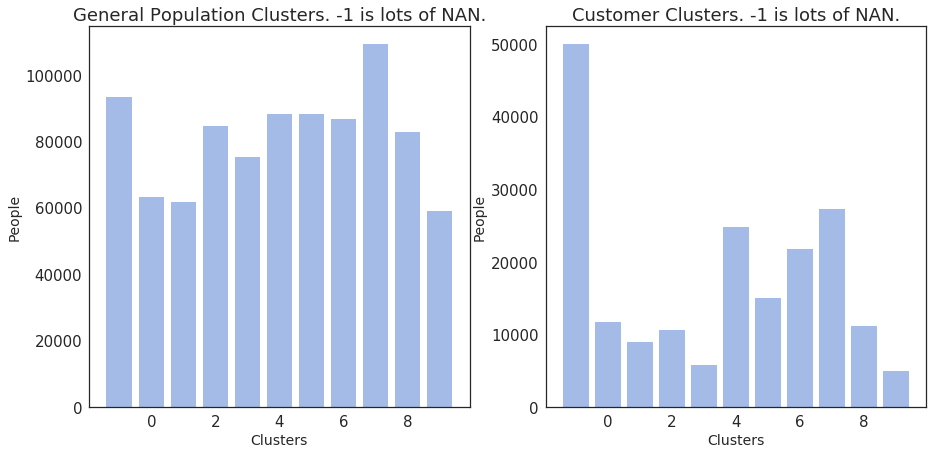

In [283]:
# visualize gen pop and cust clusters again. This time with NAN / null cluster

fig, ax = plt.subplots(1, 2,figsize=(15, 7)) 

plt.subplot(1,2,1)  

plt.bar(summary_comparison_with_NAN_cluster['cluster'], summary_comparison_with_NAN_cluster['general'], align='center', alpha=0.5)

plt.xlabel('Clusters', fontsize=14)
plt.ylabel('People', fontsize=14)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
title = 'General Population Clusters. -1 is lots of NAN.'
plt.title(title,  fontsize=18)


plt.subplot(1,2,2) 
plt.bar(summary_comparison_with_NAN_cluster['cluster'], summary_comparison_with_NAN_cluster['customers'], align='center', alpha=0.5)

plt.xlabel('Clusters', fontsize=14)
plt.ylabel('People', fontsize=14)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
title = 'Customer Clusters. -1 is lots of NAN.'
plt.title(title,  fontsize=18)
plt.show()

In [284]:
# all clusters for gen pop and cust, incuding NAN 
summary_comparison_with_NAN_cluster

cluster  general  customers
cluster                             
 0             0    63235      11738
 1             1    61591       8880
 2             2    84570      10590
 3             3    75084       5742
 4             4    88195      24800
 5             5    88080      14979
 6             6    86591      21735
 7             7   109102      27279
 8             8    82741      11099
 9             9    58878       4883
-1            -1    93154      49927

In [285]:
# https://stackoverflow.com/questions/43217916/pandas-data-precision
# show only two decimal points
pd.set_option('display.float_format', '{:0.4f}'.format)

In [286]:
# gen_perc & cust_perc show proportion of clusters
# diff is difference

summary_comparison_with_NAN_cluster['gen_perc'] = summary_comparison_with_NAN_cluster['general'] / len(azdias)
summary_comparison_with_NAN_cluster['cust_perc'] = summary_comparison_with_NAN_cluster['customers'] / len(customers)
summary_comparison_with_NAN_cluster['diff'] =summary_comparison_with_NAN_cluster['cust_perc']- summary_comparison_with_NAN_cluster['gen_perc']

summary_comparison_with_NAN_cluster

cluster  general  customers  gen_perc  cust_perc    diff
cluster                                                          
 0             0    63235      11738    0.0710     0.0612 -0.0097
 1             1    61591       8880    0.0691     0.0463 -0.0228
 2             2    84570      10590    0.0949     0.0553 -0.0396
 3             3    75084       5742    0.0842     0.0300 -0.0543
 4             4    88195      24800    0.0990     0.1294  0.0304
 5             5    88080      14979    0.0988     0.0782 -0.0207
 6             6    86591      21735    0.0972     0.1134  0.0162
 7             7   109102      27279    0.1224     0.1423  0.0199
 8             8    82741      11099    0.0928     0.0579 -0.0349
 9             9    58878       4883    0.0661     0.0255 -0.0406
-1            -1    93154      49927    0.1045     0.2605  0.1560

### Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.

In [287]:
print("Clusters from most likely ones to be target audience to least likely ones")
summary_comparison_with_NAN_cluster.sort_values(by='diff',ascending= False)
# 4 is the most likely to be target audience
# 3 is outside of the target audience

Clusters from most likely ones to be target audience to least likely ones


cluster  general  customers  gen_perc  cust_perc    diff
cluster                                                          
-1            -1    93154      49927    0.1045     0.2605  0.1560
 4             4    88195      24800    0.0990     0.1294  0.0304
 7             7   109102      27279    0.1224     0.1423  0.0199
 6             6    86591      21735    0.0972     0.1134  0.0162
 0             0    63235      11738    0.0710     0.0612 -0.0097
 5             5    88080      14979    0.0988     0.0782 -0.0207
 1             1    61591       8880    0.0691     0.0463 -0.0228
 8             8    82741      11099    0.0928     0.0579 -0.0349
 2             2    84570      10590    0.0949     0.0553 -0.0396
 9             9    58878       4883    0.0661     0.0255 -0.0406
 3             3    75084       5742    0.0842     0.0300 -0.0543

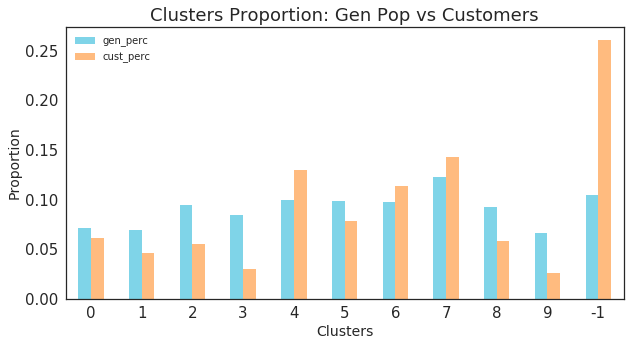

In [288]:
# https://stackoverflow.com/questions/42128467/matplotlib-plot-multiple-columns-of-pandas-data-frame-on-the-bar-chart
# https://stackoverflow.com/questions/51174691/how-to-increase-image-size-of-pandas-dataframe-plot-in-jupyter-notebook/51174822


summary_comparison_with_NAN_cluster.plot(x='cluster', y=['gen_perc', 'cust_perc'], 
                                         kind="bar",
                                         figsize=(10,5),
                                         alpha=0.5, 
                                         color=['#00aad2', '#ff7900'])


plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)
title = 'Clusters Proportion: Gen Pop vs Customers'
plt.title(title,  fontsize=18)


plt.show()

### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population? - See the discussion at the end of the project

In [289]:
print('Overrepresented in customers')
summary_comparison_with_NAN_cluster[summary_comparison_with_NAN_cluster['diff']>0].sort_values(by='diff',ascending= False)

Overrepresented in customers


cluster  general  customers  gen_perc  cust_perc   diff
cluster                                                         
-1            -1    93154      49927    0.1045     0.2605 0.1560
 4             4    88195      24800    0.0990     0.1294 0.0304
 7             7   109102      27279    0.1224     0.1423 0.0199
 6             6    86591      21735    0.0972     0.1134 0.0162

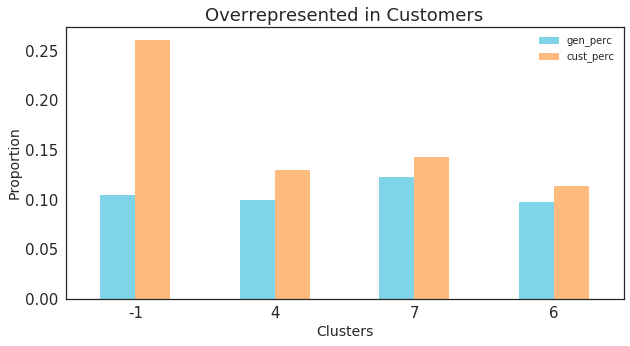

In [290]:

summary_comparison_with_NAN_cluster[summary_comparison_with_NAN_cluster['diff']>0].sort_values(by='diff',
                                                                                               ascending= False).plot(
    x='cluster', y=['gen_perc', 'cust_perc'], 
                                         kind="bar",
                                         figsize=(10,5),
                                         alpha=0.5, 
                                         color=['#00aad2', '#ff7900'])


plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)
title = 'Overrepresented in Customers'
plt.title(title,  fontsize=18)


plt.show()

### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population? - See the discussion at the end of the project

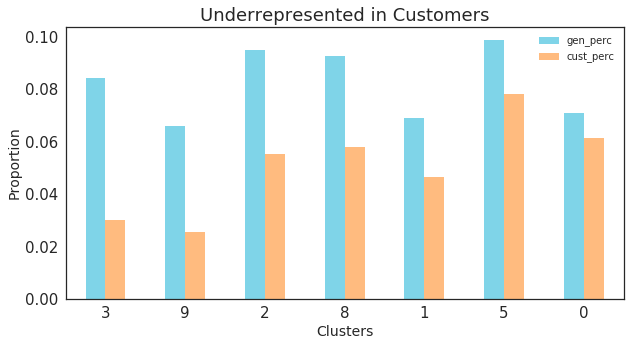

In [291]:
summary_comparison_with_NAN_cluster[summary_comparison_with_NAN_cluster['diff']<0].sort_values(by='diff',ascending= True).plot(
    x='cluster', y=['gen_perc', 'cust_perc'], 
                                         kind="bar",
                                         figsize=(10,5),
                                         alpha=0.5, 
                                         color=['#00aad2', '#ff7900'])


plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)
title = 'Underrepresented in Customers'
plt.title(title,  fontsize=18)


plt.show()

In [292]:
print('Underrepresented in customers')
summary_comparison_with_NAN_cluster[summary_comparison_with_NAN_cluster['diff']<0].sort_values(by='diff',ascending= False)

Underrepresented in customers


cluster  general  customers  gen_perc  cust_perc    diff
cluster                                                          
0              0    63235      11738    0.0710     0.0612 -0.0097
5              5    88080      14979    0.0988     0.0782 -0.0207
1              1    61591       8880    0.0691     0.0463 -0.0228
8              8    82741      11099    0.0928     0.0579 -0.0349
2              2    84570      10590    0.0949     0.0553 -0.0396
9              9    58878       4883    0.0661     0.0255 -0.0406
3              3    75084       5742    0.0842     0.0300 -0.0543

### Describe people over- and underrepresented

In [296]:
pca.inverse_transform(model_10.cluster_centers_)

array([[ -9.24191488e-01,  -1.16097958e+00,   5.39324601e-02,
          8.70070530e-01,  -8.81786417e-01,   6.09409115e-01,
          9.51211747e-01,  -6.64583242e-01,   2.77389281e-01,
         -4.70555505e-02,  -6.68973868e-01,   9.96761372e-01,
          1.29136949e+00,   1.22143261e+00,   7.90982597e-01,
          1.09428065e+00,  -5.81587940e-01,  -1.35857321e+00,
          1.40715317e+00,   2.27390682e-01,  -1.15929239e+00,
         -1.08331114e+00,  -1.27077483e+00,   7.59027574e-01,
          8.14425396e-01,   1.22459534e-02,  -2.57594490e-01,
          2.86605810e-01,  -2.53545202e-02,  -4.61070005e-01,
         -3.12206099e-01,  -1.91085205e-01,  -3.21427943e-01,
         -9.99714790e-02,   4.18542847e-01,   2.39956686e-01,
          4.27275069e-01,  -3.70771364e-02,  -2.88688531e-01,
         -3.74890454e-01,   4.76947260e-01,   3.13346478e-01,
         -5.15634664e-01,   4.16627045e-01,   2.80750031e-01,
         -8.62237843e-02,   4.42264201e-01,   7.10863521e-01,
        

In [297]:
scaler.inverse_transform(pca.inverse_transform(model_10.cluster_centers_))

array([[  2.81165489e+00,   7.84509948e-01,   4.31865683e+00,
          2.15739332e+00,   3.81688509e+00,   2.21323311e+00,
          2.79685293e+00,   1.85316216e+00,   6.35209181e-01,
          1.94269525e+00,   3.14979547e+00,   5.94133704e+00,
          6.06814709e+00,   4.97132294e+00,   5.05599694e+00,
          7.12137286e+00,   4.56546838e+00,   2.49044499e+00,
          6.37955225e+00,   3.20792410e+00,   1.85268793e+00,
          2.27595171e+00,   1.31904404e+00,   4.11791614e+00,
          4.04074705e+00,   1.10519563e-02,   1.37277333e+00,
          2.66781991e+00,   1.64966401e-02,   2.49126221e+00,
          3.78074080e+00,   8.42702877e+00,   3.85368991e-01,
          1.22484867e-02,   3.74130990e+00,   1.99379578e+03,
          2.72179247e+00,   1.11693538e+00,   7.98129218e-02,
         -2.85110886e-02,   4.15214065e+00,   4.96471934e+00,
          3.05316938e+00,   5.60173380e+00,   4.08562583e+00,
          2.38043772e+00,   4.11783442e+00,   3.95786593e+00,
        

In [298]:
# What kinds of people are part of a cluster that is overrepresented  and underrepresented in the
# customer data compared to the general population?

# adapted from:
# https://github.com/chauhan-nitin/Udacity-IdentifyCustomerSegments-Arvato/blob/master/Identify_Customer_Segments.ipynb

# Cluster center specs can be found below:
cluster_centroids = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(model_10.cluster_centers_)), columns=columns_list_customers)
cluster_centroids

# look at cluster centroids for 4 (underrepresented) and 3 (overrepresented)

# I exported to Excel, compared Excel vs data dictionary

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                2.8117     0.7845             4.3187         2.1574   
1                3.7239     1.3484             3.8953         1.2775   
2                2.7580     1.7617             3.7179         2.1448   
3                2.6286     1.7963             2.8390         2.3278   
4                3.8252     0.9369             5.2673         0.9193   
5                4.0612     1.7427             3.8982         0.9899   
6                3.8486     0.9040             4.4417         1.0760   
7                3.8821     1.3211             5.2954         0.8422   
8                3.9928     1.7063             4.7170         0.9535   
9                2.7560     0.7773             3.4252         2.3578   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0            3.8169          2.2132                 2.7969            1.8532   
1            4.7243          1.1283                 1.4737            3.6744   
2            3.8570          2.6906                 2.7395            2.4591   
3            3.8100          2.5382                 2.6228            3.7381   
4            4.9880          1.2039                 1.3803            1.8535   
5            5.0964          1.2290                 1.2771            3.7780   
6            4.9997          0.9003                 1.3246            3.0515   
7            5.0238          0.9309                 1.5637            1.8324   
8            4.9247          1.6269                 1.4304            2.4160   
9            3.7329          2.0817                 2.6332            3.1394   

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0            0.6352      1.9427          3.1498     5.9413     6.0681   
1            0.3879      2.0536          4.4420     4.4199     3.7846   
2            0.4549      2.1111          3.1950     3.3260     3.5726   
3            0.2801      2.0484          3.3347     3.6450     3.7862   
4            0.2626      2.0704          4.2837     4.9199     4.4154   
5            0.2806      1.8223          4.4156     3.1680     2.2215   
6            0.2866      2.1187          4.7699     5.2214     4.7885   
7            1.4242      1.8516          4.1530     4.2580     3.2725   
8            0.2687      1.7876          3.8857     3.0141     2.1431   
9            0.3802      2.0626          3.3585     6.3130     6.2936   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0     4.9713     5.0560      7.1214      4.5655     2.4904      6.3796   
1     2.7826     3.0370      4.9839      6.1264     5.2801      3.4565   
2     4.1367     4.5571      3.6209      4.5910     4.6566      3.7753   
3     4.3353     4.7269      3.3184      4.3441     4.5014      3.9816   
4     2.9480     3.1226      6.6006      5.8414     4.5967      4.4958   
5     1.7420     2.2084      3.8050      6.3125     6.7557      1.9656   
6     3.0948     3.5631      6.5256      5.9855     4.5478      4.6582   
7     2.3746     2.6130      5.5363      6.1586     5.4234      3.2607   
8     1.7756     2.1819      4.1261      6.0798     6.5928      2.1214   
9     5.0243     4.9680      6.8779      4.3726     2.3995      6.5252   

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0     3.2079      1.8527     2.2760      1.3190         4.1179       4.0407   
1     2.5087      4.2561     4.1536      3.9960         2.6183       2.3873   
2     4.7294      4.8435     5.1954      4.8519         4.4760       4.3462   
3     4.9113      4.9095     5.4144      5.3880         4.7153       4.4480   
4     1.8649      3.0546     2.7520      2.0046         2.3761       2.2961   
5     2.4674      5.3570     5.1535      5.2952         2.0545       1.8844   
6     1.8094      3.0624     2.9843      2.3744         2.4521       2.1680   
7     2.2276      3.8185     4.1575      3.5679         2.2303       2.3052   

In [299]:
# cluster_centroids.to_excel('customer_cluster_centroids.xlsx')

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

### Some things I'd do differently if I were to do this analysis again

I regret dropping some variables from the analysis, such as LP_STATUS_GROB (social status), SHOPPER_TYP (shopper type), and some other mixed type variables indicating social status and shopping habits. Super important. 

These are multilevel vars. I should have just recoded them as dummies. This is very important info for marketing, even critical.

I think even 10 clusters is overkill, hard to analyze and describe. Maybe 7 would have been better for marketing? 

The way I was creating calcualated variables was inefficient. I was creating temp vars and then dropping them. 
I could take a look at how other people were doing this.

I didn't need to run K means with 2,3,4...30 clusters on all data. 25% random sample/subset is sufficient for that.

## Target audience

### Cluster 4

Some of these are repetitive, or may slightly differ: middle class vs upper middle class etc, because we have several vars
describing the same thing. It's good to check if the cluster makes sense and the data is good, to make sure there are no big
contradictions

- male
- money saver
- investor
- home owner
- likely to be >60 years old
- shopper type: conservative Low-Returner
- not too social
- not dreamful
- religious
- average to low level of being cultured
- critically-minded
- dominant
- very rational
- with a combative attitude
- dutiful
- traditinal
- very high or high income
- average or unlikely to have kids in household
- likely to have lived in the same place for 10 or more years
    -(?? If I'm intepreting WOHNDAUER_2008 var correctly. Also, is this old data?)
- live 20 - 30 km to city center 
- low movement pattern
- high online affinity (this is surprising because I thought these were older people? Also, I'm not sure what this actually means. If they use internet?)
- midle class neighbourhood (interesting, I thought it was high or very high income. Why not a higher class neighbourhood)  
- upper middle class
- very good neighbourhood

We could also describe cluster 7 and 6

## Not target audience

### Cluster 3 
- female
- hard to tell age. In between these 2 groups: 30-45 adn 46-60
- saver, but less so than top cluster in target audience
- not a home owner
- average to low level of religiousness
- not materialistic
- dreamful
- average level of being cultured
- not critically minded
- not dominant
- not a combative attitude
- not dutiful
- not traditional 
- average neighbourhood    
- both of these classes: established middleclass and consumption-oriented middleclass
- 5 - 10 km to city center (or less)
- middle to high movement pattern, in between
- online affinity is high, higher than that of the top cluster in the target audience
- moddle class to lower middle class neighbourhood

We can also describe clustesrs 9 and 2.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.